In [ ]:
import pandas as pd
import os
import html
import requests
import json
import time
import itertools
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from gensim.models.phrases import Phrases, Phraser
import re
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from collections import defaultdict

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from sklearn.metrics import confusion_matrix
from scipy.stats import linregress

In [ ]:
from sklearn.linear_model import Lasso, LinearRegression

In [ ]:
import spacy
nlp = spacy.load('en', disable=['ner', 'parser'])

In [ ]:
os.chdir('D:/UofT/CSC2552/Project_Proposal/Data/Sample Data')

In [ ]:
reddit_dat=pd.read_csv("Submissions_Nov2016.csv", sep=',', encoding='utf-8')

In [21]:
#Filter for subreddits with more than 1000 submissions and more than 100 users
topSubreddit_dat=reddit_dat.groupby(['subreddit_id','subreddit'],as_index=False).agg({'id':'nunique',
                                                                                      'num_comments':'sum',
                                                                                      'score':'mean',
                                                                                     'author':'nunique'}).sort_values(['id'],ascending=False)
topSubreddit_dat['comments_per_sub']=topSubreddit_dat['num_comments']/topSubreddit_dat['id']
topSubreddit_dat=topSubreddit_dat.sort_values(['comments_per_sub'],ascending=False)
topSubreddit_dat=topSubreddit_dat[(topSubreddit_dat['id']>1000) & (topSubreddit_dat['author']>100)]

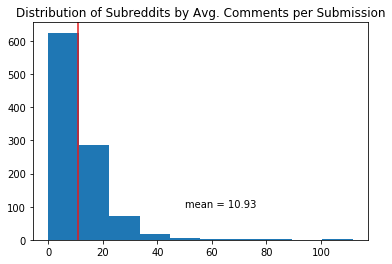

In [29]:
#Observe how the comment traffic distribution is across filtered subreddits
plt.hist(topSubreddit_dat['comments_per_sub']);
plt.title("Distribution of Subreddits by Avg. Comments per Submission");
plt.axvline(np.mean(topSubreddit_dat['comments_per_sub']), color='#e41a1c');
plt.text(50, 100, 'mean = %.2f' % np.mean(topSubreddit_dat['comments_per_sub']));

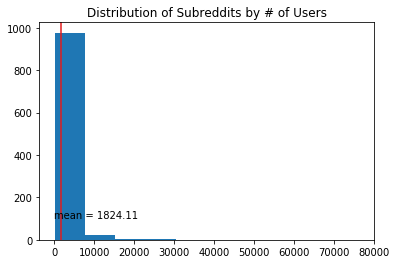

In [30]:
plt.hist(topSubreddit_dat['author']);
plt.title("Distribution of Subreddits by # of Users");
plt.axvline(np.mean(topSubreddit_dat['author']), color='#e41a1c');
plt.text(50, 100, 'mean = %.2f' % np.mean(topSubreddit_dat['author']));

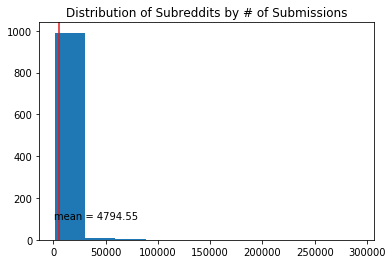

In [31]:
plt.hist(topSubreddit_dat['id']);
plt.title("Distribution of Subreddits by # of Submissions");
plt.axvline(np.mean(topSubreddit_dat['id']), color='#e41a1c');
plt.text(50, 100, 'mean = %.2f' % np.mean(topSubreddit_dat['id']));

In [32]:
#What's the total number of subreddits considered?
len(topSubreddit_dat)

1010

In [33]:
topSubreddit_dat=topSubreddit_dat.subreddit_id.unique()

In [34]:
reddit_dat=reddit_dat[reddit_dat['subreddit_id'].isin(topSubreddit_dat)]

In [ ]:
reddit_dat.to_csv('Submissions_Nov2016_AllFilteredSubreddits.csv')

In [36]:
web_source="([a-zA-Z]+\.((com)|(org)|(gov)|(us)|(ca)))"
reddit_dat['web_source']=reddit_dat["url"].str.extract(web_source)[0]

In [39]:
#Total No. of unique URL domains identified- Note this looks at the parent domain unlike more fine domain spaces already provided with Reddit
reddit_dat.web_source.nunique()

59561

In [41]:
#Identify Top domains in data
topDomain_dat=reddit_dat.groupby(['web_source'],as_index=False).agg({'id':'nunique'}).sort_values(['id'],ascending=False)
#At least 5000 submissions in data
topDomain_dat[topDomain_dat['id']>5000]

web_source       id
41934          reddit.com  2742460
24273           imgur.com   395335
59136         youtube.com   331382
41952   reddituploads.com   199903
54188         twitter.com    55428
19995          gfycat.com    25795
10492     contrishare.com    16674
54009          tumblr.com    13723
6505         blogspot.com    12664
46696      soundcloud.com    11622
58042       wordpress.com    10721
20769          google.com     9035
16746        facebook.com     8307
47900      streamable.com     6831
50796     theguardian.com     6712
36285         nytimes.com     6634
57561       wikipedia.org     6088
24937       instagram.com     5919
42421         reuters.com     5534
56493  washingtonpost.com     5370
20167           giphy.com     5286
12918      deviantart.com     5067
9857              cnn.com     5004

In [42]:
#News vs Blog Vs Social Media Vs Self Post
#Only select link sources from top that I am interested to compare and study
topDomains=['reddit.com','wikipedia.org',
            'twitter.com','facebook.com',
            'miamiherald.com','washingtonpost.com','theguardian.com','nytimes.com','cnn.com','huffingtonpost.com',
           'blogspot.com','wordpress.com']
#At least 5000 submissions in data
topDomain_dat[topDomain_dat['web_source'].isin(topDomains)]

web_source       id
41934          reddit.com  2742460
54188         twitter.com    55428
6505         blogspot.com    12664
58042       wordpress.com    10721
16746        facebook.com     8307
50796     theguardian.com     6712
36285         nytimes.com     6634
57561       wikipedia.org     6088
56493  washingtonpost.com     5370
9857              cnn.com     5004
23568  huffingtonpost.com     4275
32149     miamiherald.com      218

In [43]:
reddit_dat=reddit_dat[reddit_dat["web_source"].isin(topDomains)]

In [46]:
#About 3 million records to study, most posts are self posts though
reddit_dat.shape

(2863878, 21)

In [45]:
#Fill na and nan titles with blank
reddit_dat['title']=reddit_dat['title'].fillna('')
reddit_dat=reddit_dat[(reddit_dat['title']!='') & (reddit_dat['title']!=' ')]

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Distribution of # of Comments across Top Domains

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


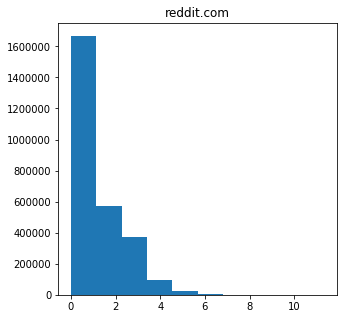

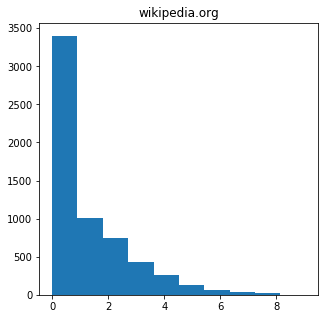

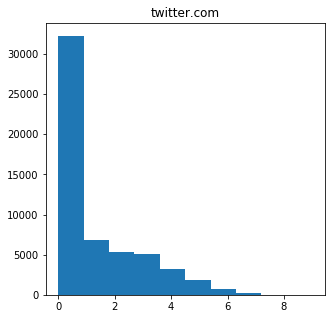

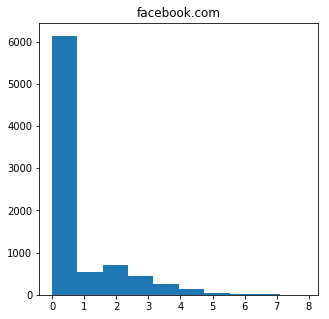

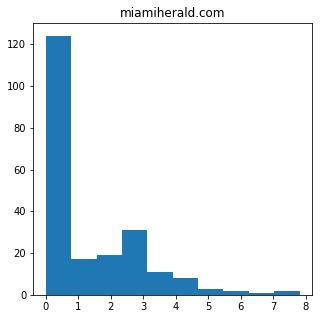

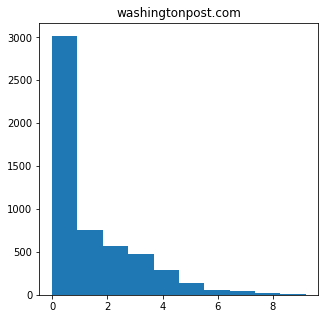

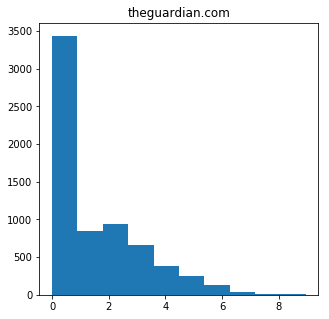

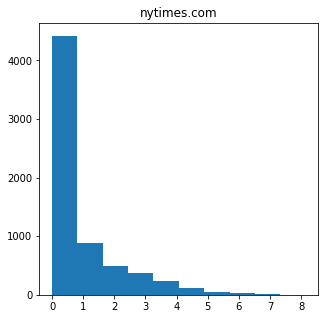

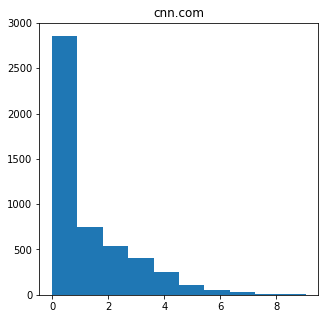

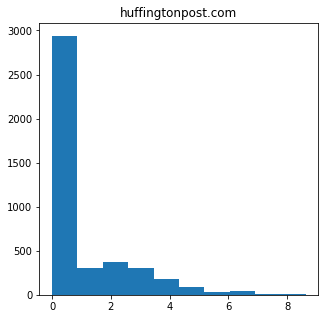

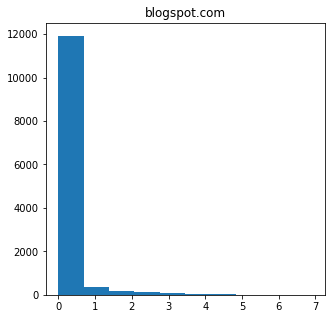

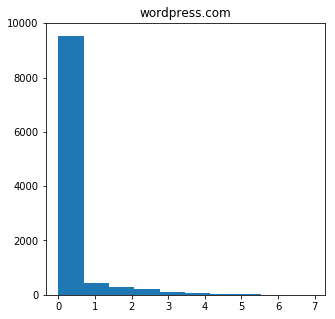

In [48]:
reddit_dat['log_num_comments']=np.log(reddit_dat['num_comments'])
reddit_dat['log_num_comments']=np.where(np.isinf(reddit_dat['log_num_comments']) | np.isnan(reddit_dat['log_num_comments']),0,reddit_dat['log_num_comments'])
for web_source in topDomains:
    plt.figure(figsize=(5,5))
    plt.hist(reddit_dat[reddit_dat["web_source"]==web_source].log_num_comments);
    plt.title(web_source)

As can be seen different URL domains have different distribution of comments on submissions, some domains are more discussed than others. We are interested in understanding what drives discussion of certain domains

### Distribution of Submission Score across Top Domains

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


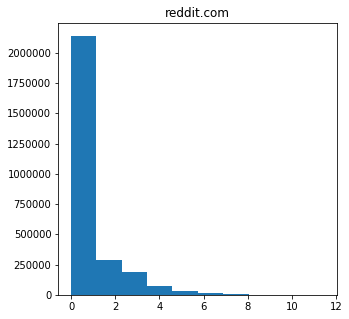

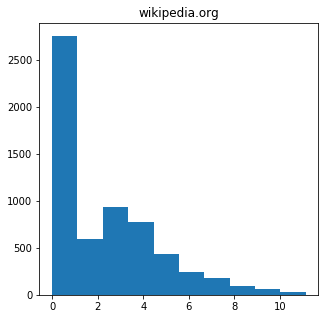

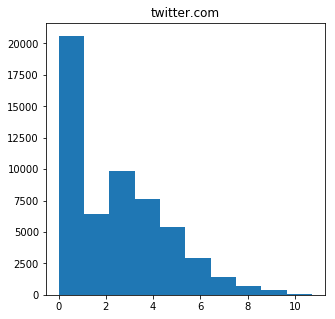

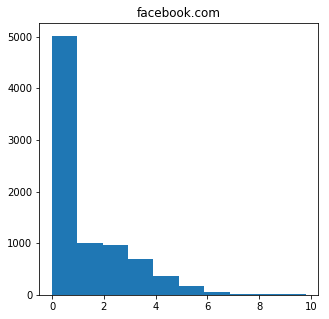

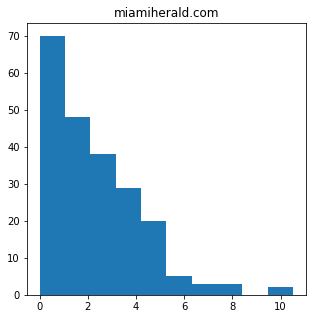

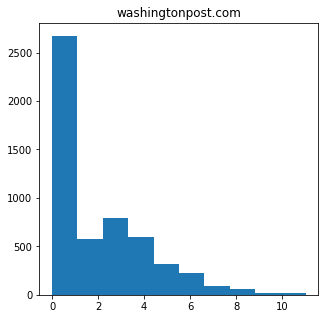

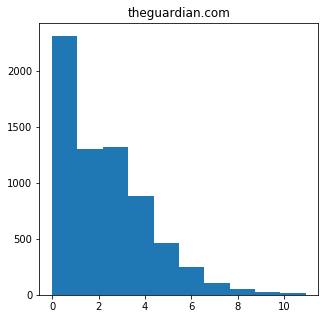

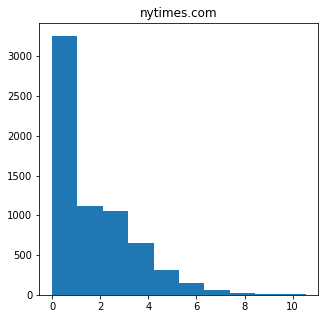

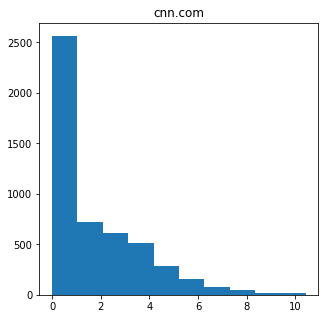

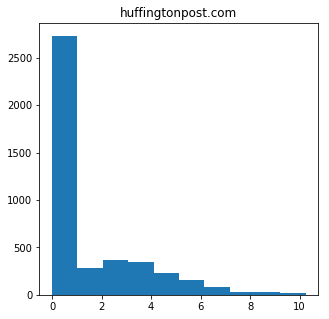

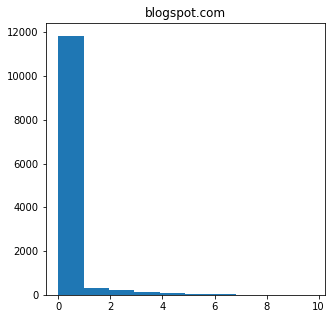

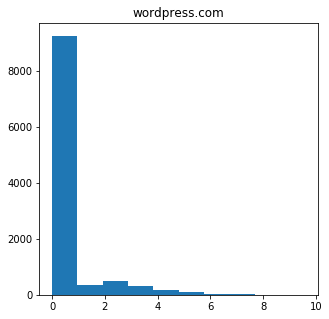

In [52]:
reddit_dat['log_score']=np.log(reddit_dat['score'])
reddit_dat['log_score']=np.where(np.isinf(reddit_dat['log_score']) | np.isnan(reddit_dat['log_score']),0,reddit_dat['log_score'])
for web_source in topDomains:
    plt.figure(figsize=(5,5))
    plt.hist(reddit_dat[reddit_dat["web_source"]==web_source].log_score);
    plt.title(web_source)

# Title Subjectivity vs Polarity analysis:

In [53]:
#Calculate sentiment and polarity scores of text title based on words in it's contents
reddit_dat['title_sentiment_polarity']=reddit_dat.apply(lambda x:TextBlob(x.title).sentiment.polarity,axis=1)
reddit_dat['title_sentiment_subjectivity']=reddit_dat.apply(lambda x:TextBlob(x.title).sentiment.subjectivity,axis=1)

In [54]:
reddit_dat.to_csv("Submissions_Nov2016_WithSentimentScoreAllFitleredSubreddit.csv")

In [ ]:
reddit_dat=pd.read_csv("Submissions_Nov2016_WithSentimentScoreAllFitleredSubreddit.csv")

In [58]:
subredditWebSourceDat=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'id':'nunique','num_comments':'mean','score':'mean',
                                                                         'title_sentiment_polarity':'mean',
                                                                         'title_sentiment_subjectivity':'mean'})

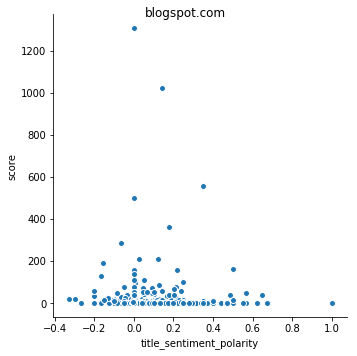

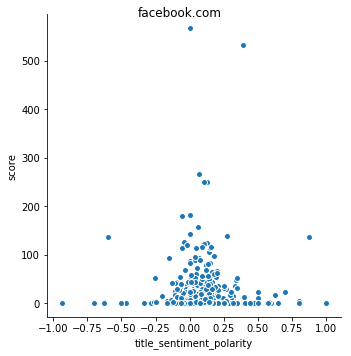

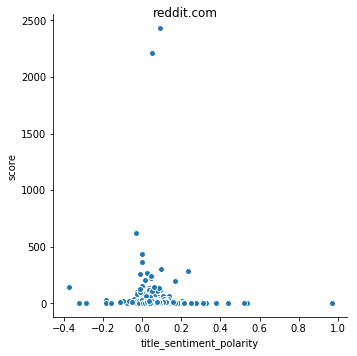

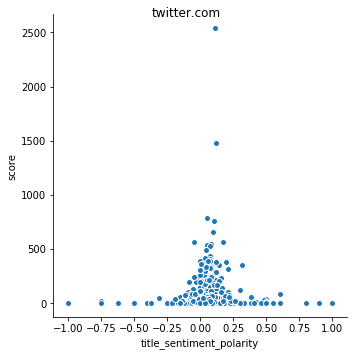

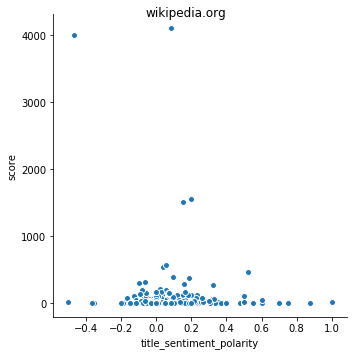

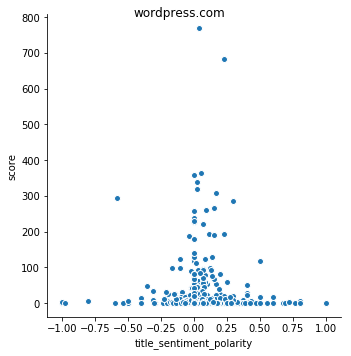

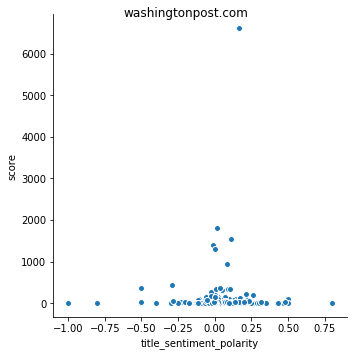

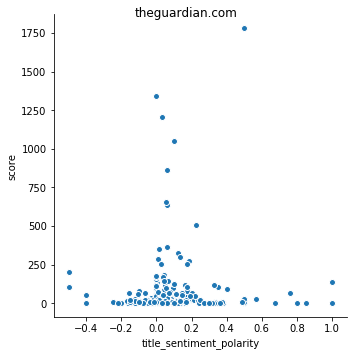

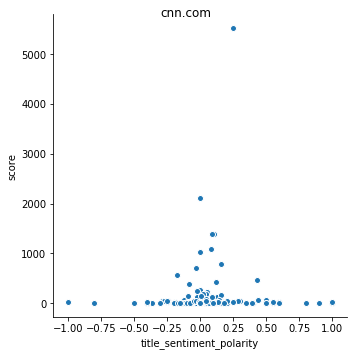

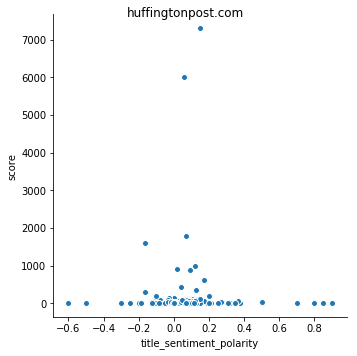

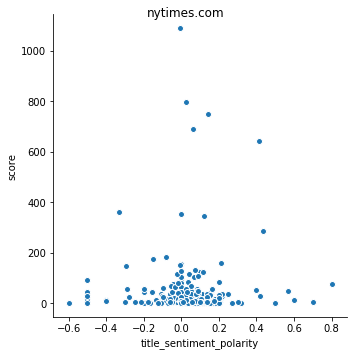

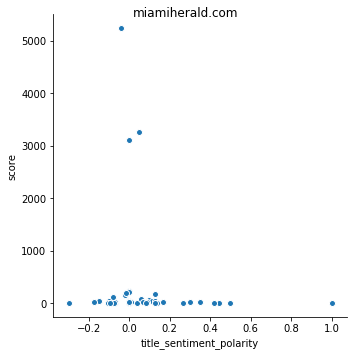

In [59]:
# Compare how choice of polarized words is correlated with the submission karma or score
for web_source in subredditWebSourceDat.web_source.unique():
    pplot=sns.pairplot(x_vars=['title_sentiment_polarity'],y_vars=['score'],data=subredditWebSourceDat[subredditWebSourceDat['web_source']==web_source],size=5)
    pplot.fig.suptitle(web_source);

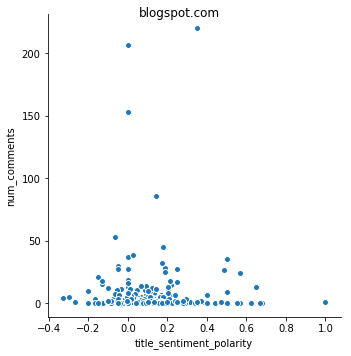

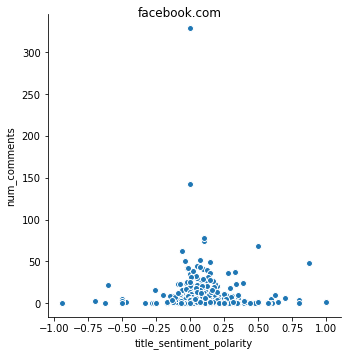

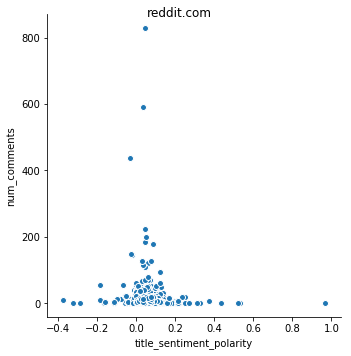

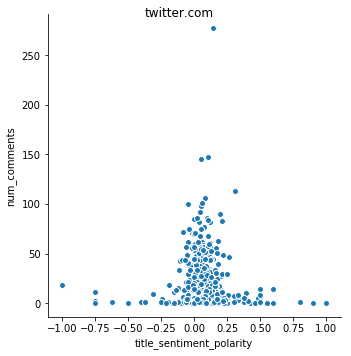

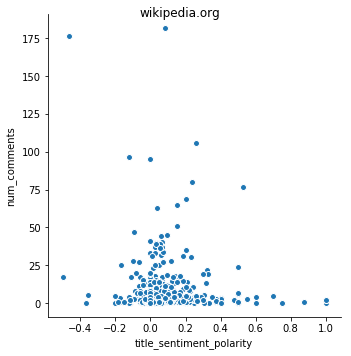

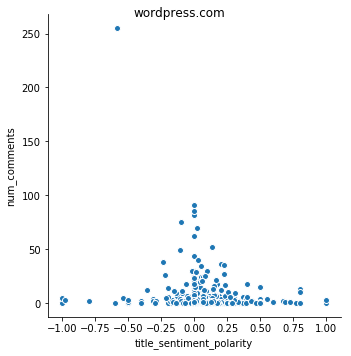

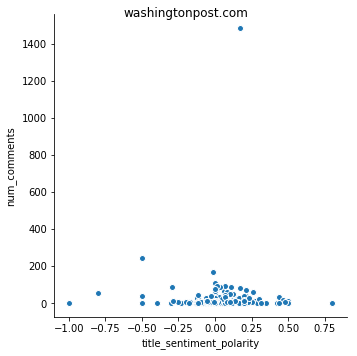

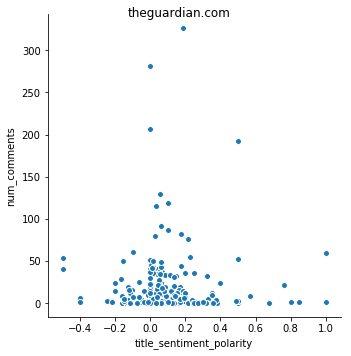

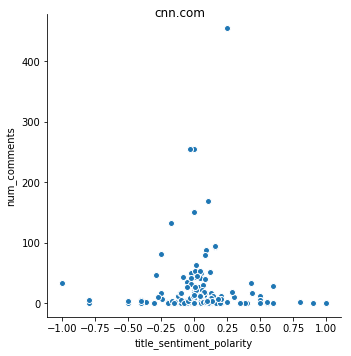

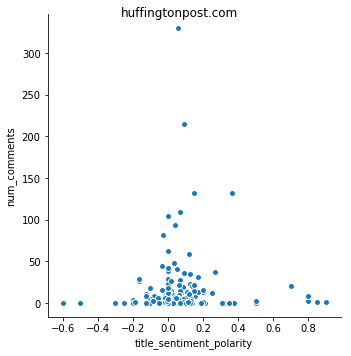

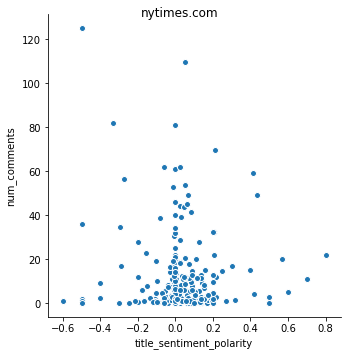

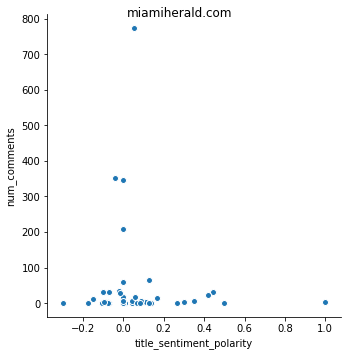

In [60]:
# Compare how choice of polarized words affects avg. number of comments
for web_source in subredditWebSourceDat.web_source.unique():
    pplot=sns.pairplot(x_vars=['title_sentiment_polarity'],y_vars=['num_comments'],data=subredditWebSourceDat[subredditWebSourceDat['web_source']==web_source],size=5)
    pplot.fig.suptitle(web_source);

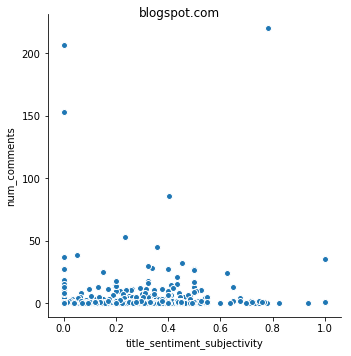

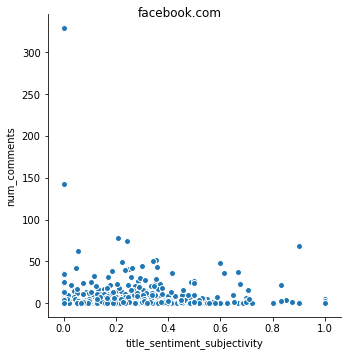

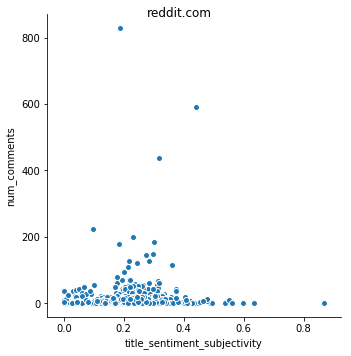

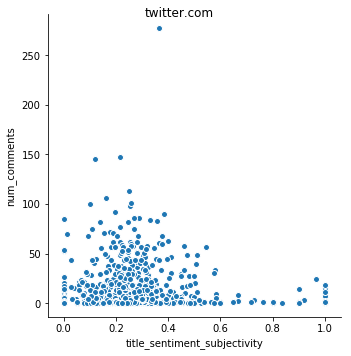

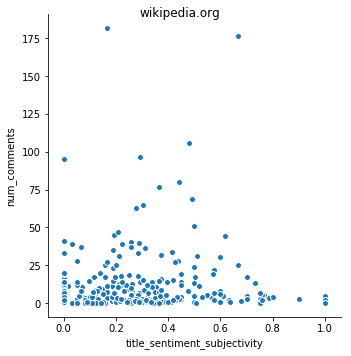

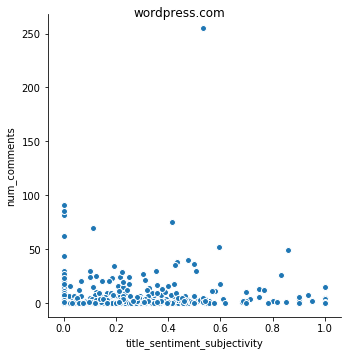

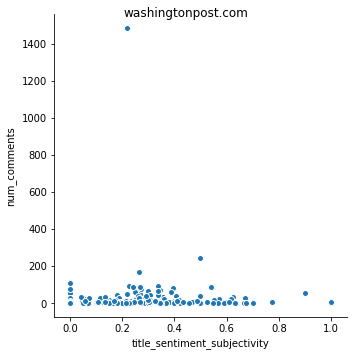

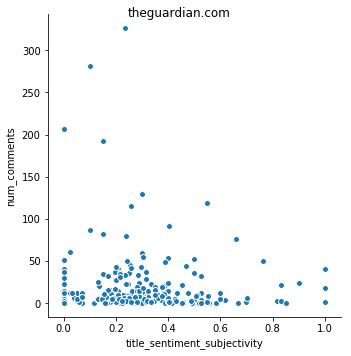

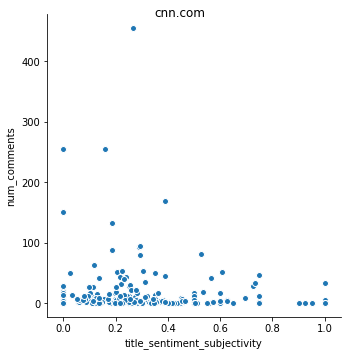

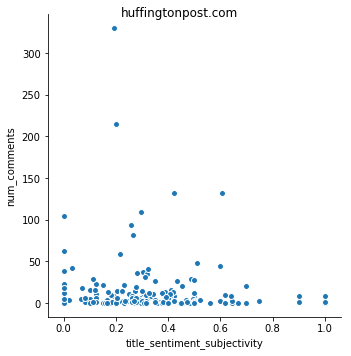

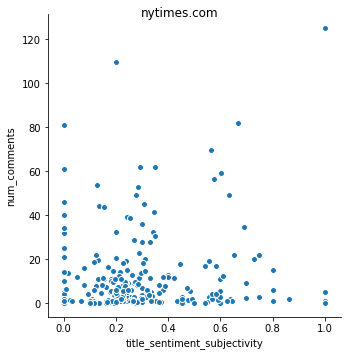

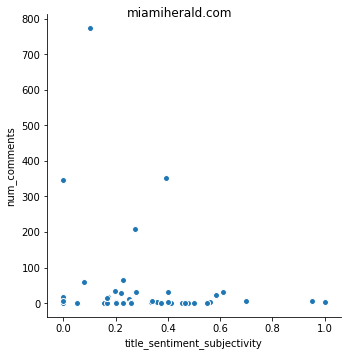

In [61]:
# Compare how choice of subjective words affects av.g. number of comments
for web_source in subredditWebSourceDat.web_source.unique():
    pplot=sns.pairplot(x_vars=['title_sentiment_subjectivity'],y_vars=['num_comments'],data=subredditWebSourceDat[subredditWebSourceDat['web_source']==web_source],size=5)
    pplot.fig.suptitle(web_source);

In [62]:
reddit_dat[['title_sentiment_polarity','num_comments']].corr()

title_sentiment_polarity  num_comments
title_sentiment_polarity                  1.000000     -0.007754
num_comments                             -0.007754      1.000000

In [63]:
reddit_dat[['title_sentiment_subjectivity','num_comments']].corr()

title_sentiment_subjectivity  num_comments
title_sentiment_subjectivity                      1.000000      0.009682
num_comments                                      0.009682      1.000000

In [64]:
linregress(reddit_dat['title_sentiment_polarity'], reddit_dat['num_comments'])

LinregressResult(slope=-4.350663709729904, intercept=11.235362872346855, rvalue=-0.007753597851771649, pvalue=2.4764337988592714e-39, stderr=0.33155996353267436)

In [65]:
linregress(reddit_dat['title_sentiment_subjectivity'], reddit_dat['num_comments'])

LinregressResult(slope=4.500150587824558, intercept=9.893295853267965, rvalue=0.009681979254274027, pvalue=2.4401879809052442e-60, stderr=0.2746410416048557)

In [66]:
AvgSentimentScoreBySubreddit=reddit_dat.groupby(['subreddit'],as_index=False).agg({'id':'nunique','title_sentiment_polarity':'mean','title_sentiment_subjectivity':'mean'})

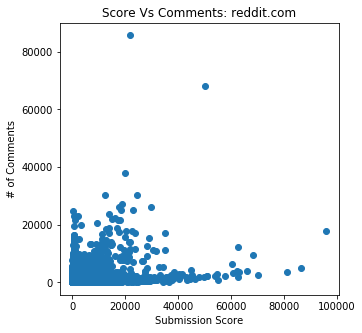

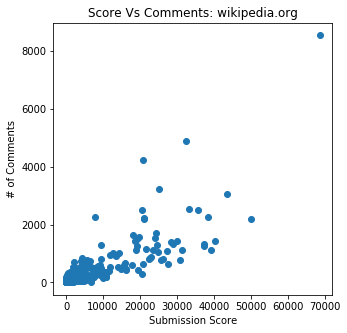

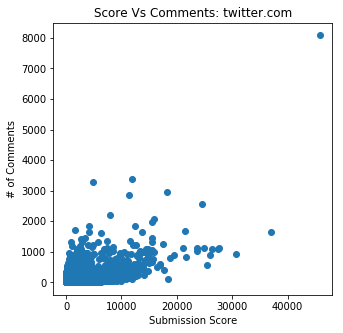

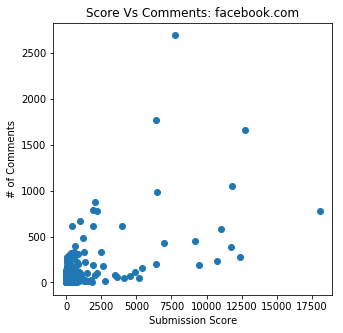

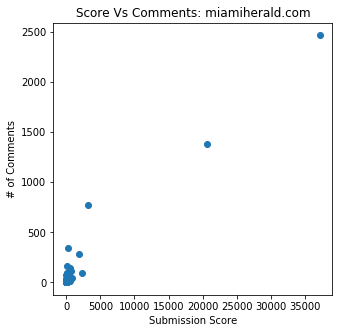

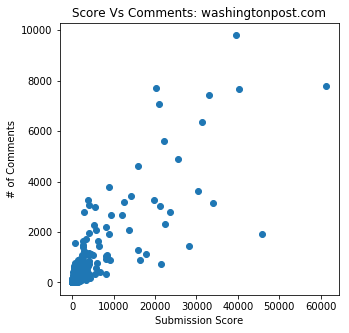

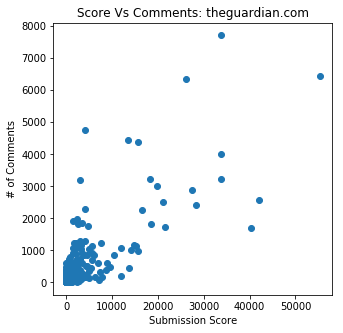

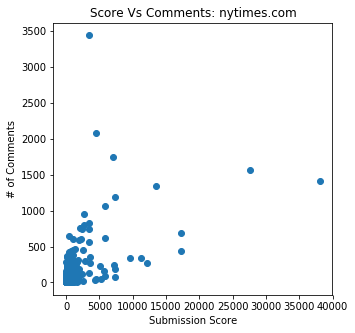

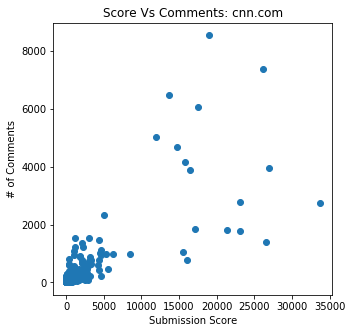

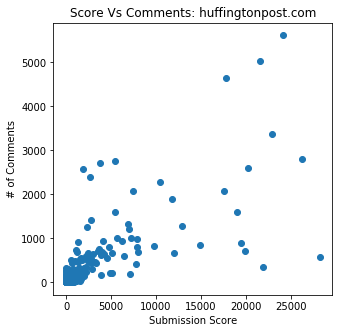

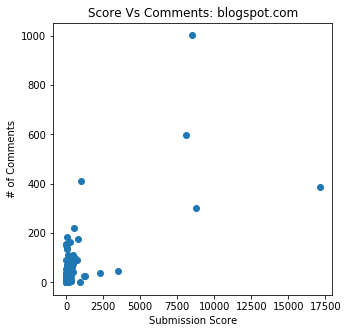

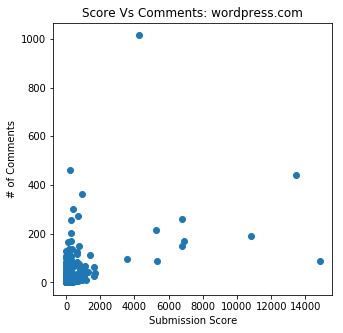

In [67]:
#Score Vs Comments- Top Domains
for web_source in topDomains:
    plt.figure(figsize=(5,5))
    plt.scatter(x=reddit_dat[reddit_dat['web_source']==web_source]["score"],y=reddit_dat[reddit_dat['web_source']==web_source]["num_comments"]);
    plt.xlabel("Submission Score");
    plt.ylabel("# of Comments");
    plt.title("Score Vs Comments: "+web_source);

In [68]:
linregress(reddit_dat['score'], reddit_dat['num_comments'])

LinregressResult(slope=0.1298639172170054, intercept=7.876637675348418, rvalue=0.3890997382842101, pvalue=0.0, stderr=0.00018167799378701952)

The Karma of a submission is highly correlated with  number of comments 

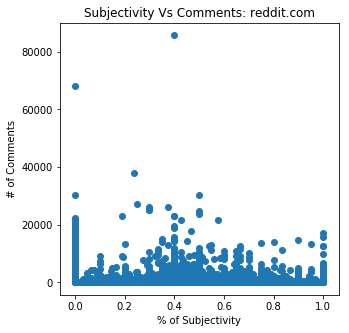

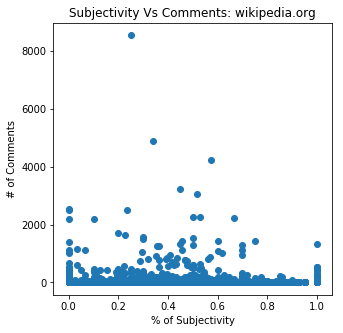

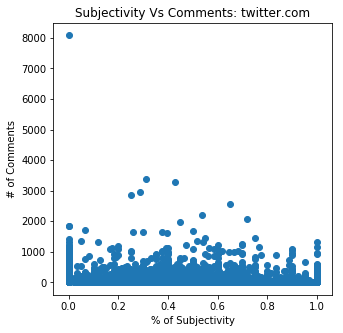

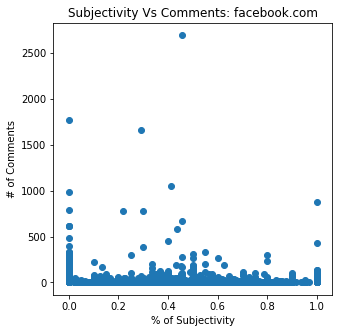

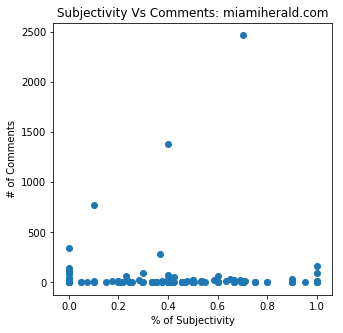

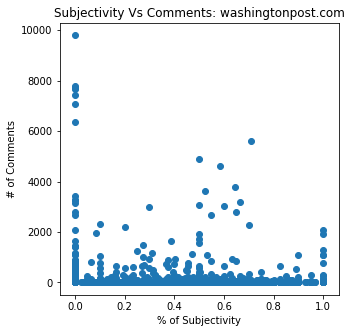

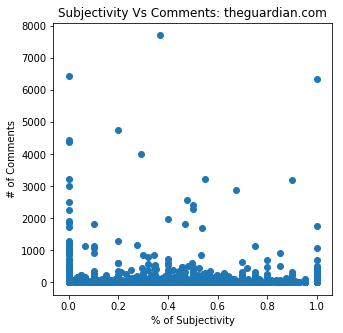

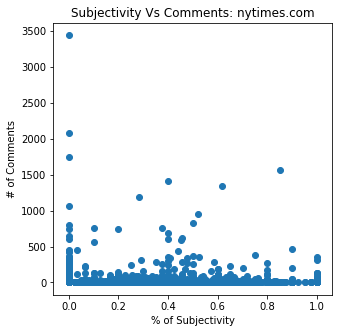

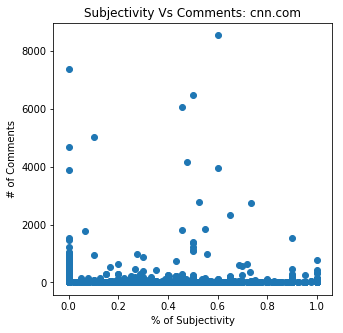

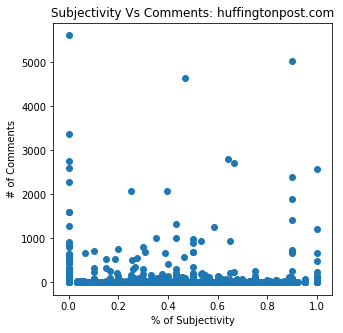

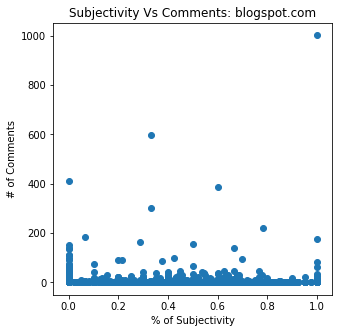

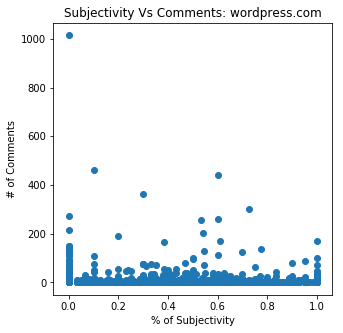

In [69]:
#Sentiment Subjectivity Vs Comments- Top Domains
for web_source in topDomains:
    plt.figure(figsize=(5,5))
    plt.scatter(x=reddit_dat[reddit_dat['web_source']==web_source]["title_sentiment_subjectivity"],y=reddit_dat[reddit_dat['web_source']==web_source]["num_comments"]);
    plt.xlabel("% of Subjectivity");
    plt.ylabel("# of Comments");
    plt.title("Subjectivity Vs Comments: "+web_source);

In [70]:
linregress(reddit_dat['title_sentiment_subjectivity'], reddit_dat['num_comments'])

LinregressResult(slope=4.500150587824558, intercept=9.893295853267965, rvalue=0.009681979254274027, pvalue=2.4401879809052442e-60, stderr=0.2746410416048557)

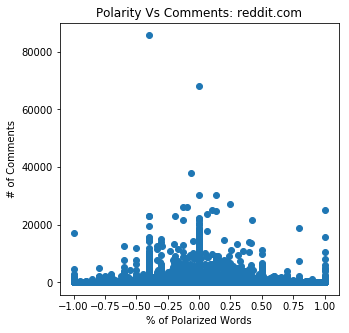

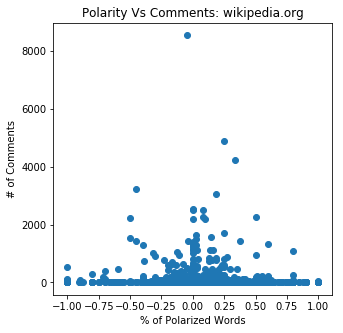

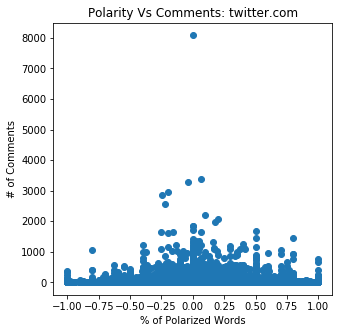

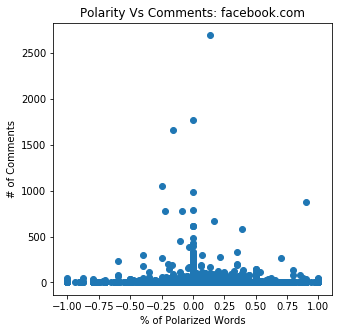

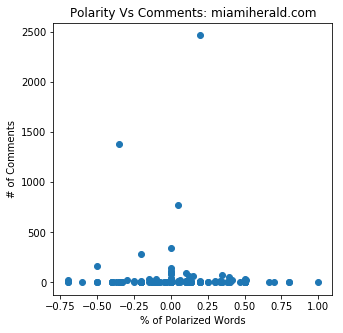

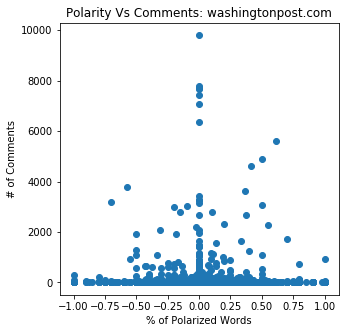

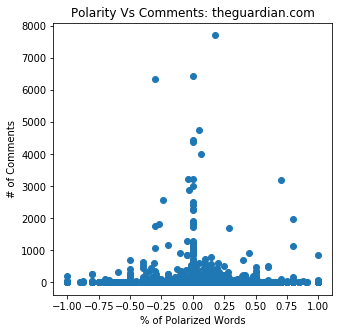

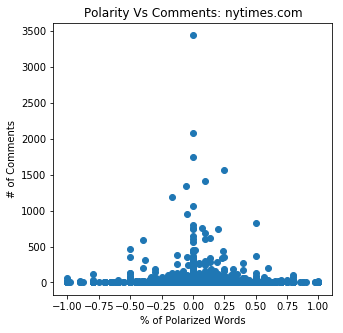

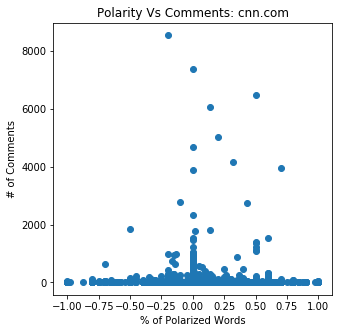

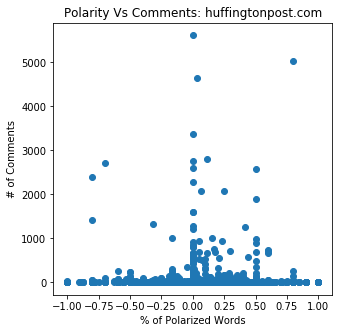

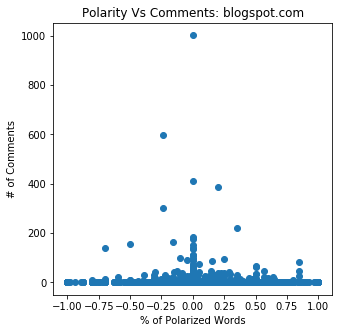

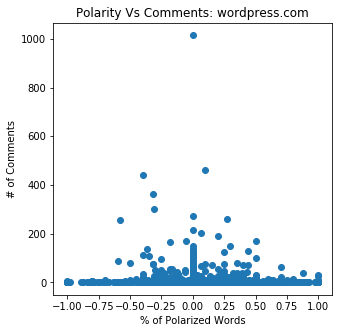

In [71]:
#Sentiment Polarity Vs Comments- Top Domains
for web_source in topDomains:
    plt.figure(figsize=(5,5))
    plt.scatter(x=reddit_dat[reddit_dat['web_source']==web_source]["title_sentiment_polarity"],y=reddit_dat[reddit_dat['web_source']==web_source]["num_comments"]);
    plt.xlabel("% of Polarized Words");
    plt.ylabel("# of Comments");
    plt.title("Polarity Vs Comments: "+web_source);

In [72]:
linregress(reddit_dat['title_sentiment_polarity'], reddit_dat['num_comments'])

LinregressResult(slope=-4.350663709729904, intercept=11.235362872346855, rvalue=-0.007753597851771649, pvalue=2.4764337988592714e-39, stderr=0.33155996353267436)

An Avg.of word polarity and subjectivity score of title content isn't sufficient enough to expalin the variance caused in comments for a submission as can be seen from the graphs

###  Compare across web sources how does the avg. score compare within subreddits:

In [73]:
reddit_dat['log_score']=np.log(reddit_dat['score'])
reddit_dat['log_score']=np.where(np.isinf(reddit_dat['log_score']),0,reddit_dat['log_score'])
AvgSentimentScoreBySubreddit=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'id':{'total_submissions':'nunique'},
                                                                                                'title_sentiment_polarity':{'title_sentiment_polarity_mean':'mean',
                                                                                                                           'title_sentiment_polarity_std':'std'},
                                                                                                'title_sentiment_subjectivity':{'title_sentiment_subjectivity_mean':'mean',
                                                                                                                                'title_sentiment_subjectivity_std':'std'},
                                                                                                'score':{'score_mean':'mean',
                                                                                                        'score_std':'std'},
                                                                                               'num_comments':{'total_comments':'sum',
                                                                                                               'average_comment_per_sub':'mean'}})
AvgSentimentScoreBySubreddit.columns = AvgSentimentScoreBySubreddit.columns.droplevel(level=0)
AvgSentimentScoreBySubreddit.columns=['subreddit','web_source','total_submissions',
                                     'title_sentiment_polarity_mean','title_sentiment_polarity_std',
                                     'title_sentiment_subjectivity_mean','title_sentiment_subjectivity_std',
                                     'score_mean',
                                     'score_std',
                                     'total_comments',
                                     'average_comment_per_sub']

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [76]:
AvgSentimentScoreBySubreddit['log_average_comment_per_sub']=np.log(round(AvgSentimentScoreBySubreddit['average_comment_per_sub'],0))

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [78]:
AvgSentimentScoreBySubreddit=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'id':'nunique','title_sentiment_polarity':'mean','title_sentiment_subjectivity':'mean','score':'mean','num_comments':'mean'})

In [79]:
reddit_dat['Sentiment_Flag']=np.where(reddit_dat['title_sentiment_polarity']>0, 'Positive',np.where(reddit_dat['title_sentiment_polarity']<0,'Negative','Neutral'))

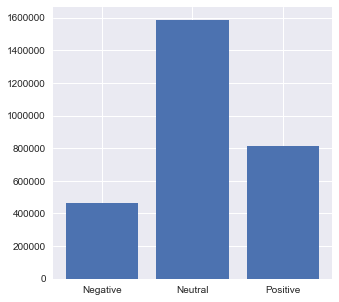

In [84]:
#No. of submissions with each sentiment flag
barplotDat=reddit_dat.groupby(['Sentiment_Flag'],as_index=False).agg({'id':'nunique'})
plt.bar(barplotDat['Sentiment_Flag'],barplotDat['id']);

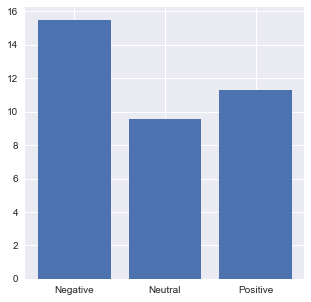

In [86]:
# Avg. Number of comments for each submission with sentiment
barplotDat=reddit_dat.groupby(['Sentiment_Flag'],as_index=False).agg({'num_comments':'mean'})
sns.set(rc={'figure.figsize':(5,5)})
plt.bar(barplotDat['Sentiment_Flag'],barplotDat['num_comments']);

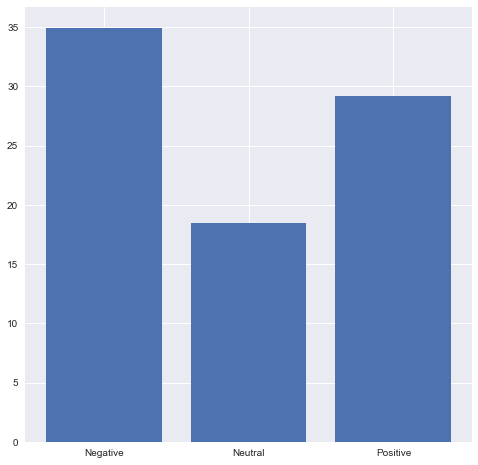

In [87]:
#Avg. score for each sentiment
barplotDat=reddit_dat.groupby(['Sentiment_Flag'],as_index=False).agg({'score':'mean'})
sns.set(rc={'figure.figsize':(8,8)})
plt.bar(barplotDat['Sentiment_Flag'],barplotDat['score']);

This graph is contradicting, since we would expect the polarity be reflective in the submission score receive

# Title Content Similarity Analysis:

In [88]:
#In order to perform sentiment analysis we use scores of Reddit submissions
reddit_dat['sentiment']=np.where(reddit_dat['score']>0,'Positive','Negative')

In [89]:
reddit_dat.dropna(subset=['title'],inplace=True)
reddit_dat['selftext'].fillna('',inplace=True)
reddit_dat['author'].fillna('',inplace=True)
reddit_dat.reset_index(drop=True,inplace=True)

In [90]:
def cleaning(doc):
    
    #Lower Case
    doc=doc.lower()
    
    #Recode html characters
    doc=html.unescape(doc)
    
    #Remove URL
    doc=doc.replace(r'(http\s?\:?\/?\/?)[a-zA-Z0-9]+\.(com|org|ca|us|gov|net)\/?\.?([a-z0-9]+)?','')
    doc=doc.replace(r'www\.[a-zA-Z0-9]\.(com|org|us|ca|gov|net)\/?\.?([a-z0-9]+)?','')
    
    #Remove all non-word characters
    doc=doc.replace(r'[^a-zA-Z]',' ')
    
    #Replace multiple spaces with single
    doc=doc.replace(r'\s+',' ')
    
    #Expand negation clitics
    negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
    neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
    doc=neg_pattern.sub(lambda x: negations_dic[x.group()],doc)
        
    return doc

def lemmatize_doc(doc):
    
    # Lemmatizes and removes stopwords
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(txt)

#Preporcessing Title
reddit_dat['title'] = [cleaning(doc) for doc in reddit_dat['title']]

#Lemmatize Title
reddit_dat['title'] = [lemmatize_doc(doc) for doc in nlp.pipe(reddit_dat['title'], batch_size=5000, n_threads=-1)]

#Preporcessing Title-Content
reddit_dat['selftext'] = [cleaning(doc) for doc in reddit_dat['selftext']]

#Lemmatize Title-Content
reddit_dat['selftext'] = [lemmatize_doc(doc) for doc in nlp.pipe(reddit_dat['selftext'], batch_size=5000, n_threads=-1)]

In [91]:
reddit_dat.to_csv("Submissions_Nov2016_PreprocessedAllFilteredSubreddit.csv")

In [572]:
reddit_dat=pd.read_csv("Submissions_Nov2016_PreprocessedAllFilteredSubreddit.csv")

### Distribution of title length across submissions

In [573]:
# Avg. Submission lengths.
lens = [len(str(doc.title)) for i,doc in reddit_dat.iterrows()]

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
C:\Users\bhara\Anaconda3\lib\site-packages\matplotlib\__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\bhara\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\bhara\Anaconda3\lib\site-packages\matplotlib\

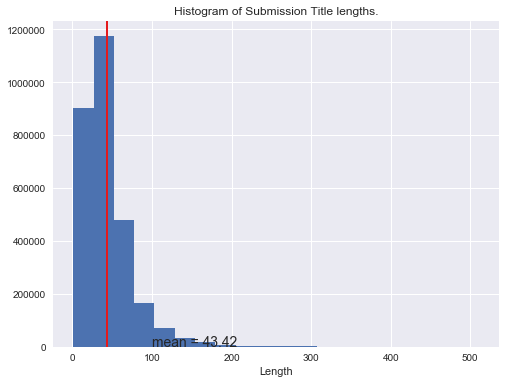

In [574]:
# Plot.
plt.rc('figure', figsize=(8,6));
plt.rc('font', size=14);
plt.rc('lines', linewidth=2);

# Histogram.
plt.hist(lens, bins=20);
plt.hold(True);
# Average length.
avg_len = sum(lens) / float(len(lens));
plt.axvline(avg_len, color='#e41a1c');
plt.hold(False);
plt.title('Histogram of Submission Title lengths.');
plt.xlabel('Length');
plt.text(100, 800, 'mean = %.2f' % avg_len);
#plt.show();
plt.savefig('Submission_Title_Length_Dist')

### Distribution of self text length across submissions

In [94]:
# Avg. Submission Desc lengths.
selfTextlens = [len(str(doc.selftext)) for i,doc in reddit_dat.iterrows()]

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\matplotlib\__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\bhara\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\bhara\Anaconda3\lib\site-packages\m

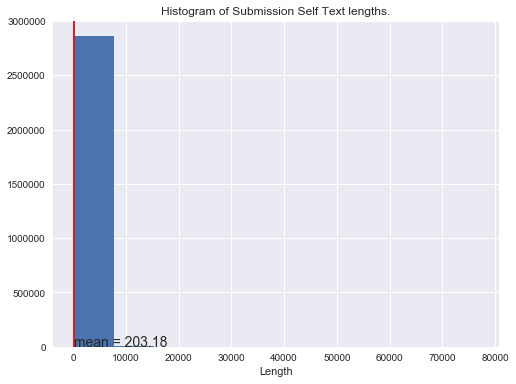

In [95]:
# Plot.
plt.rc('figure', figsize=(8,6));
plt.rc('font', size=14);
plt.rc('lines', linewidth=2);
# Histogram.
plt.hist(selfTextlens, bins=10);
plt.hold(True);

# Average length.
avg_len = sum(selfTextlens) / float(len(selfTextlens));
plt.axvline(avg_len, color='#e41a1c');
plt.hold(False);
plt.title('Histogram of Submission Self Text lengths.');
plt.xlabel('Length');
plt.text(100, 800, 'mean = %.2f' % avg_len);
plt.savefig('Submission_SelfText_Length_Dist')

### Features to identify extent of self and external moderation in subreddit

In [575]:
reddit_dat['deleted']=reddit_dat['selftext'].str.match(r"\[\s*delete\s*\]",case=False,na=0)
reddit_dat['removed']=reddit_dat['selftext'].str.match(r"\[\s*remove[\sa-z0-9]*\]",case=False,na=0)

In [576]:
subreddit_moderation_dat=reddit_dat.groupby(['subreddit_id','subreddit'],as_index=False).agg({'deleted':'sum','removed':'sum','id':'nunique','num_comments':'mean'})
subreddit_moderation_dat.columns=['subreddit_id','subreddit','subreddit_deleted','subreddit_removed','subreddit_total','avg_comments']

Text(0.5,1,'Distribution of Avg. Comments, across subreddits')

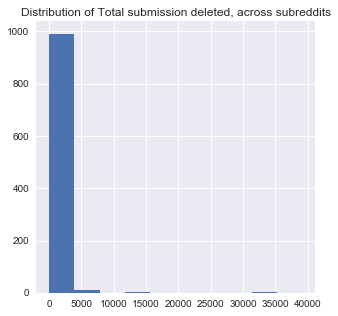

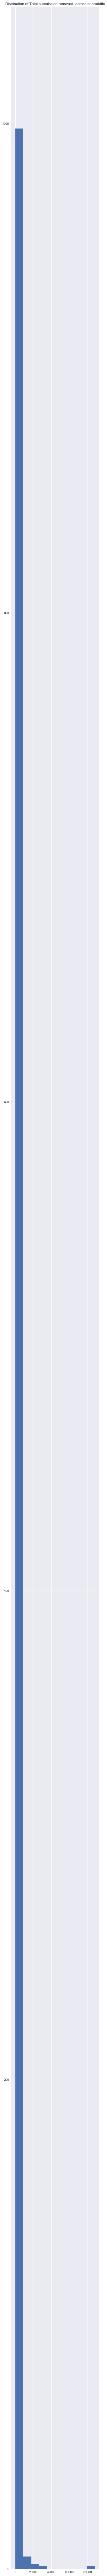

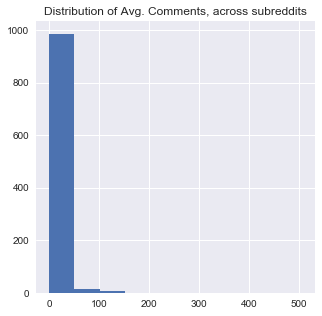

In [98]:
plt.figure(figsize=(5,5));
plt.hist(subreddit_moderation_dat['subreddit_deleted']);
plt.title("Distribution of Total submission deleted, across subreddits")

plt.figure(figsize=(5,150));
plt.hist(subreddit_moderation_dat['subreddit_removed']);
plt.title("Distribution of Total submission removed, across subreddits")

plt.figure(figsize=(5,5));
plt.hist(subreddit_moderation_dat['avg_comments']);
plt.title("Distribution of Avg. Comments, across subreddits")

In [577]:
subreddit_moderation_dat.drop(['avg_comments'],inplace=True,axis=1)

In [578]:
reddit_dat=reddit_dat.merge(subreddit_moderation_dat,on=['subreddit_id','subreddit'])

### Doc2Vec feature generation for title content:

In [579]:
def labelize_submissions(submissions,label):
    result = []
    prefix = label
    for i, t in submissions.iterrows():
        #print(t)
        result.append(TaggedDocument(str(t.title).split(), [prefix + '_%s' % t.subreddit_id +"_id_" + '%s' % t.id]))
    return result
  
all_x = reddit_dat[['subreddit_id','id','title']]

all_x_w2v = labelize_submissions(all_x, 'subreddit')

In [580]:
cores = multiprocessing.cpu_count()

In [581]:
submissionTitleModel = Doc2Vec(dm=1, dm_mean=1, vector_size=50, window=4, negative=5, min_count=2, workers=cores, alpha=0.025,epochs=10)
submissionTitleModel.build_vocab(all_x_w2v)
submissionTitleModel.train(all_x_w2v,total_examples=len(all_x_w2v),epochs=submissionTitleModel.epochs)

In [582]:
submissionTitleModel.init_sims(replace=True)

In [583]:
def get_vectors(model, corpus, size):
    #print(corpus.shape)
    vecs = np.zeros((corpus.shape[0], size))
    n = 0
    for i,row in corpus.iterrows():
        prefix = 'subreddit_' + str(row.subreddit_id)+"_id_"+str(row.id)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [584]:
#Retrieve Doc2Vec for a sample of first 100 submissions
submission_docVecs=get_vectors(submissionTitleModel,all_x,50)

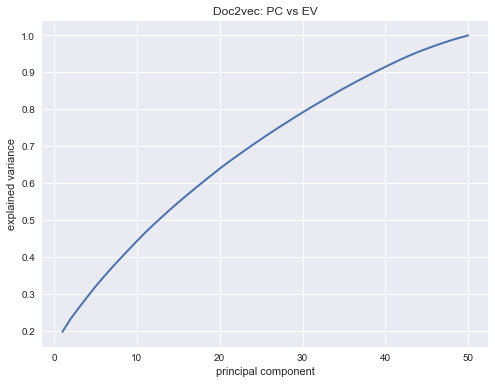

In [585]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
submission_docVecs_std = scaler.fit_transform(submission_docVecs)
d2v_pca = PCA().fit(submission_docVecs_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, d2v_pca.n_components_+1)
ax.plot(x_values, d2v_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(d2v_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Doc2vec: PC vs EV')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

### Evaluating Doc2Vec model using sentence similarities and word analogies:

In [587]:
print(reddit_dat[(reddit_dat['id']=='5e3bpt') & (reddit_dat['subreddit_id']=='t5_2qh3l')].title)
for tag in submissionTitleModel.docvecs.most_similar(positive='subreddit_t5_2qh3l_id_5e3bpt',topn=10):
    subreddit=re.match(r"(subreddit)\_([a-zA-Z0-9\_]+)\_(id)\_([a-zA-Z0-9\_]+)",tag[0])
    subreddit_id=subreddit.groups()[1]
    id=subreddit.groups()[3]
    print("Subreddit:"+subreddit_id+" ID:"+id)
    print(reddit_dat[(reddit_dat['id']==id) & (reddit_dat['subreddit_id']==subreddit_id)].title)

1772457    aloe vera face wash offer undeniable benefit
Name: title, dtype: object
Subreddit:t5_2s5oq ID:5budi1
1971108    lpt : offer gum mint etc . , bad breath try help
Name: title, dtype: object
Subreddit:t5_2qh1i ID:5ayifk
676194    tuft & needle , casper , purple claim reinvent...
Name: title, dtype: object
Subreddit:t5_2w844 ID:5d3s2n
1471742    natural color steel concrete ?
Name: title, dtype: object
Subreddit:t5_2tbbg ID:5caz6y
1698446    [ product question ] moisturizer similar eltam...
Name: title, dtype: object
Subreddit:t5_2xdht ID:5eh15f
1130400    stack nice cream
Name: title, dtype: object
Subreddit:t5_2rb5s ID:5cxocx
2502016    centre contact lens research uw look contact l...
Name: title, dtype: object
Subreddit:t5_3g4tc ID:5e21db
259187    [ pc ] [ h]winter cleaning list [ w ] key
Name: title, dtype: object
Subreddit:t5_2qhnd ID:5epxvw
2224748    find employment outside service sector retail ...
Name: title, dtype: object
Subreddit:t5_2qrtt ID:5aoptm
2316153    ques

In [589]:
submissionTitleModel.most_similar(['trump','sander'],['donald'],topn=20)

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('hrc', 0.6902214288711548),
 ('bernie', 0.6763989925384521),
 ('hitlary', 0.6541944742202759),
 ('hillary', 0.6109322309494019),
 ('establishment', 0.6083511114120483),
 ('democrat', 0.6066573262214661),
 ('-trump', 0.6037659049034119),
 ('gop', 0.5971938371658325),
 ('dnc', 0.5902267694473267),
 ('hrclint', 0.589631199836731),
 ('clinton', 0.5863369107246399),
 ('superpac', 0.5822337865829468),
 ('djt', 0.5789850354194641),
 ('killary', 0.5782930254936218),
 ('drumpf', 0.5779978036880493),
 ('tory', 0.5778664350509644),
 ('shillary', 0.5694374442100525),
 ('trumper', 0.567423939704895),
 ("trump'\x80\x99s", 0.5614213347434998),
 ('democratic', 0.5603697299957275)]

In [591]:
submissionTitleModel.most_similar(['black','male'],['white'],topn=20)

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('female', 0.676932156085968),
 ('adult', 0.631565511226654),
 ('asian', 0.6097654104232788),
 ('virgin', 0.5900529623031616),
 ('date', 0.5900152921676636),
 ('young', 0.5890138745307922),
 ('friend', 0.58402019739151),
 ('age', 0.582422137260437),
 ('guy', 0.5807467103004456),
 ('couple', 0.5748270750045776),
 ('man', 0.5718157887458801),
 ('ugly', 0.5690274834632874),
 ('girl', 0.5666281580924988),
 ('size', 0.5661135315895081),
 ('thick', 0.5654755234718323),
 ('woman', 0.5573119521141052),
 ('mature', 0.5519315004348755),
 ('circumcision', 0.5383689999580383),
 ('average', 0.5376831293106079),
 ('straight', 0.5372781157493591)]

In [592]:
reddit_dat['doc_key']='subreddit_'+reddit_dat['subreddit_id']+'_id_'+reddit_dat['id']

#### Subreddit2Vec Computing:

In [597]:
def subreddit2Vec(subreddit_dat,model,size):
    
    '''This function provides the subreddit vector embedding'''
    
    subreddit_id=subreddit_dat.subreddit_id.unique()[0]
    ids=subreddit_dat.id.unique()
    ids='subreddit_'+subreddit_id+'_id_'+ids
    vec=np.zeros((len(ids),size))
    for i,id in enumerate(ids):
        vec[i]=submissionTitleModel.docvecs[id]
    
    subredditVec=np.mean(vec,axis=0)
    
    return subredditVec

In [598]:
def subreddit_content_relevance(model,subreddit_dat,size):
    
    ''' A function to return subreddit specificity for a submission'''
    
    subredditVec=subreddit2Vec(subreddit_dat,model,size)
    subredditVec=subredditVec.reshape((1,size))
    subreddit_dat['SubTitle_Sim2Subreddit']=subreddit_dat.apply(lambda row: cosine_similarity(subredditVec,model.docvecs[row.doc_key].reshape((1,size)))[0][0],axis=1)
    
    return subreddit_dat[['subreddit_id','id','SubTitle_Sim2Subreddit']]

In [599]:
subreddit_ids=reddit_dat['subreddit_id'].unique()
reddit_w_sim_dat = pd.DataFrame()
reddit_dat=reddit_dat.loc[:, ~reddit_dat.columns.str.contains('^Unnamed')]
for subreddit_id in subreddit_ids:
    #print(subreddit_id)
    subreddit_dat=reddit_dat[reddit_dat['subreddit_id']==subreddit_id]
    subreddit_dat=subreddit_content_relevance(submissionTitleModel,subreddit_dat,50)
    reddit_w_sim_dat=reddit_w_sim_dat.append(subreddit_dat)

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

In [600]:
reddit_dat=reddit_dat.merge(reddit_w_sim_dat,on=['subreddit_id','id'])

In [601]:
reddit_dat['log_num_comments']=np.log(reddit_dat['num_comments'])
reddit_dat['log_num_comments']=np.where(np.isnan(reddit_dat['log_num_comments']) | np.isinf(reddit_dat['log_num_comments']),0,reddit_dat['log_num_comments'])

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


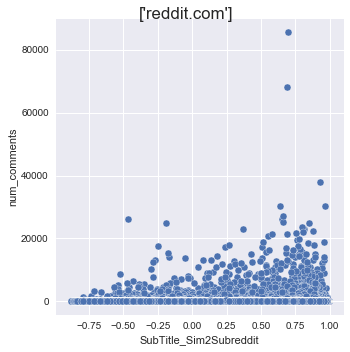

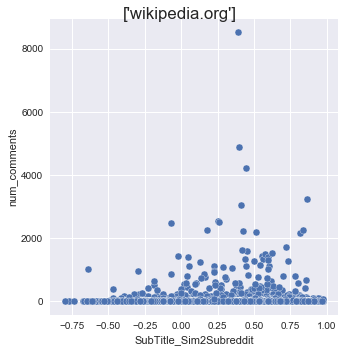

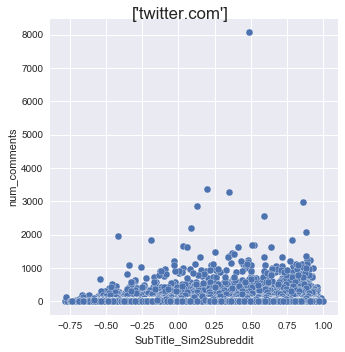

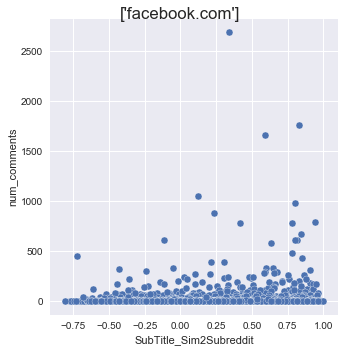

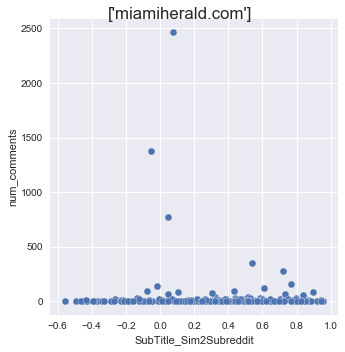

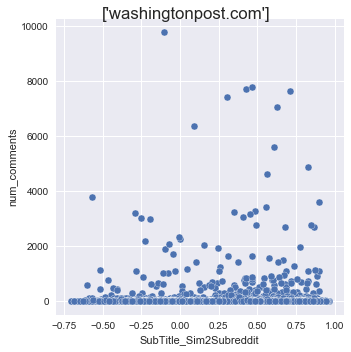

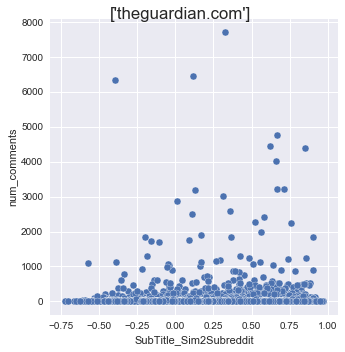

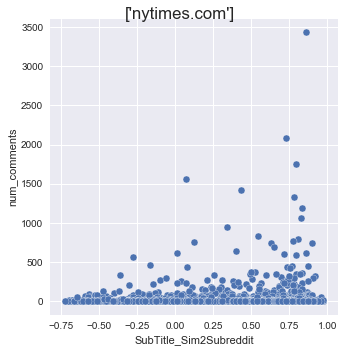

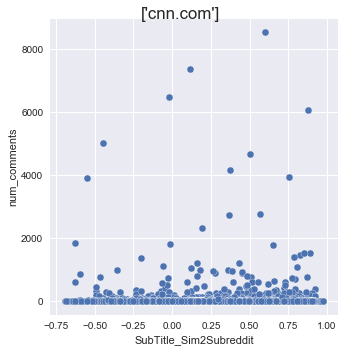

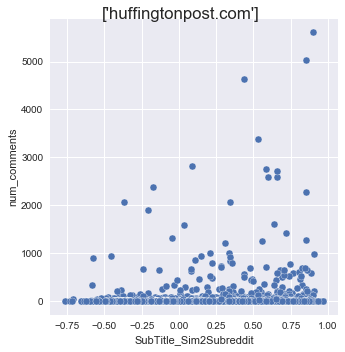

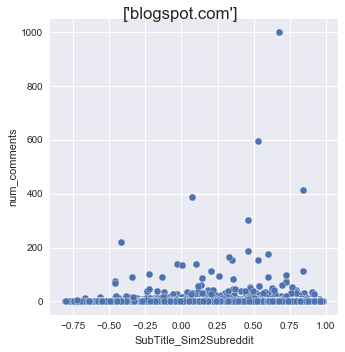

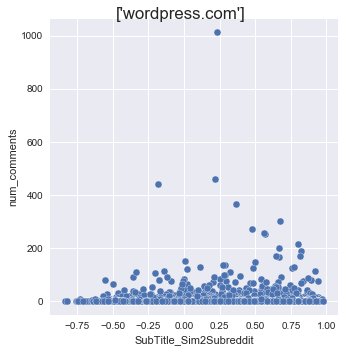

In [604]:
for web_source in topDomains:
    ax=sns.pairplot(x_vars=["SubTitle_Sim2Subreddit"], y_vars=["num_comments"], data=reddit_dat[reddit_dat["web_source"]==web_source], size=5);
    ax.fig.suptitle(reddit_dat[reddit_dat["web_source"]==web_source].web_source.unique())

In [605]:
linregress(reddit_dat['num_comments'],reddit_dat['SubTitle_Sim2Subreddit'])

LinregressResult(slope=7.313112380232048e-06, intercept=0.4404077662272532, rvalue=0.0025721050201706445, pvalue=1.3442347037483622e-05, stderr=1.680099523438496e-06)

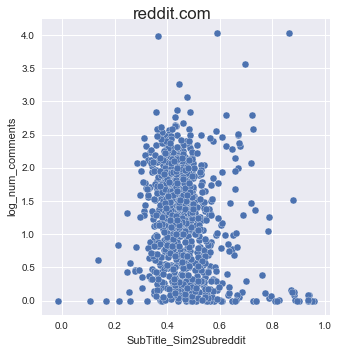

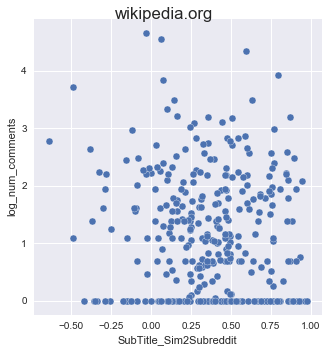

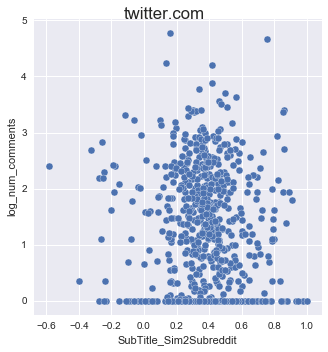

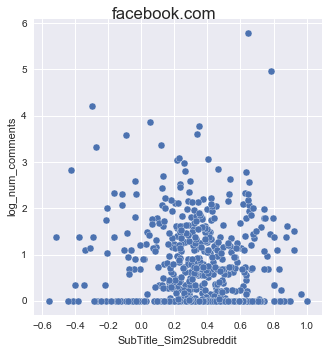

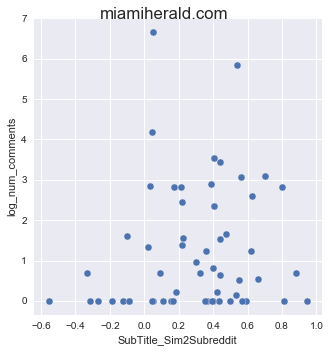

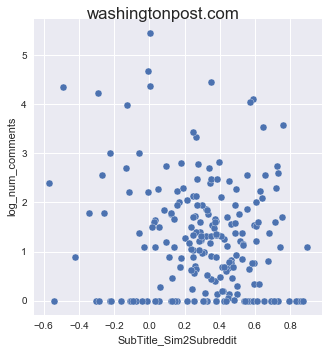

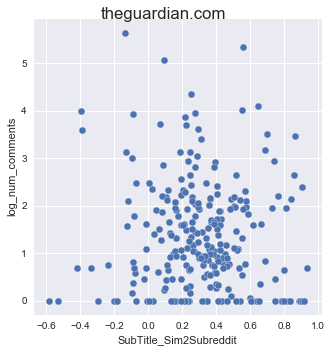

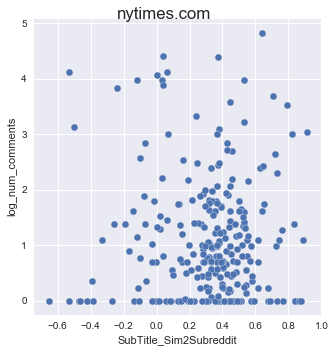

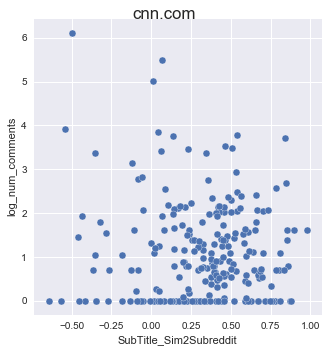

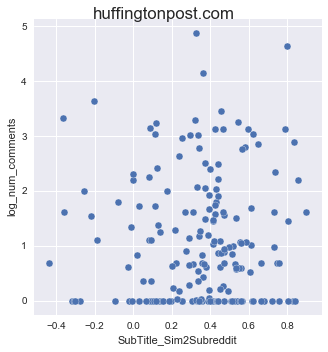

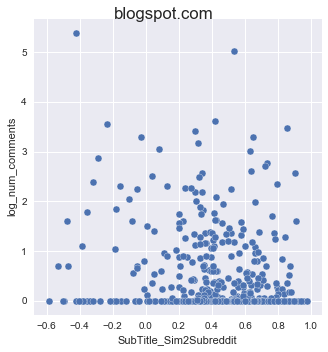

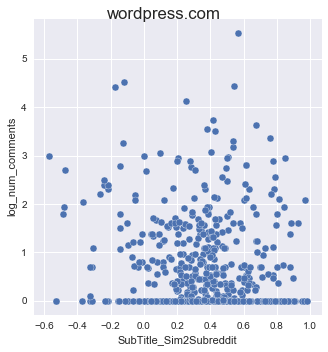

In [606]:
simAggDat=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'log_num_comments':'mean',
                                                             'SubTitle_Sim2Subreddit':'mean'})
for web_source in topDomains:
    ax=sns.pairplot(x_vars=["SubTitle_Sim2Subreddit"], y_vars=["log_num_comments"], data=simAggDat[simAggDat["web_source"]==web_source], size=5);
    ax.fig.suptitle(web_source)

Very weak correlation of number of comments to the similarity of title to overall Subreddity title vector representation style

#### URL2Vec Computing:

In [607]:
def url2Vec(subreddit_dat,model,size):
    
    '''This function provides the subreddit vector embedding'''
    
    ids=subreddit_dat.doc_key.unique()
    
    vec=np.zeros((len(ids),size))
        
    for i,id in enumerate(ids):
        vec[i]=submissionTitleModel.docvecs[id]
    
    urlVec=np.mean(vec,axis=0)
    
    return urlVec

In [608]:
def url_content_relevance(model,subreddit_dat,size):
    
    ''' A function to return subreddit specificity for a submission'''
    
    urlVec=url2Vec(subreddit_dat,model,size)
    urlVec=urlVec.reshape((1,size))
    subreddit_dat['SubTitle_Sim2WebSource']=subreddit_dat.apply(lambda row: cosine_similarity(urlVec,model.docvecs[row.doc_key].reshape((1,size)))[0][0],axis=1)
    
    return subreddit_dat[['subreddit_id','id','SubTitle_Sim2WebSource']]

In [609]:
web_sources=reddit_dat['web_source'].unique()
reddit_w_sim_dat = pd.DataFrame()
reddit_dat=reddit_dat.loc[:, ~reddit_dat.columns.str.contains('^Unnamed')]
for web_source in web_sources:
    #print(web_source)
    subreddit_dat=reddit_dat[reddit_dat['web_source']==web_source]
    subreddit_dat=url_content_relevance(submissionTitleModel,subreddit_dat,50)
    reddit_w_sim_dat=reddit_w_sim_dat.append(subreddit_dat)

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

In [610]:
reddit_dat=reddit_dat.merge(reddit_w_sim_dat,on=['subreddit_id','id'])

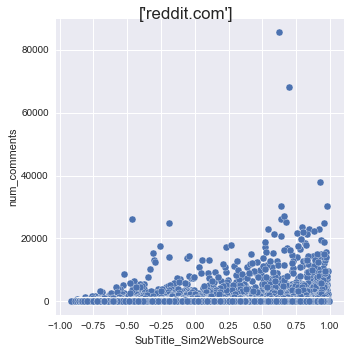

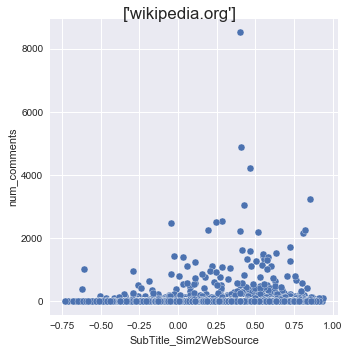

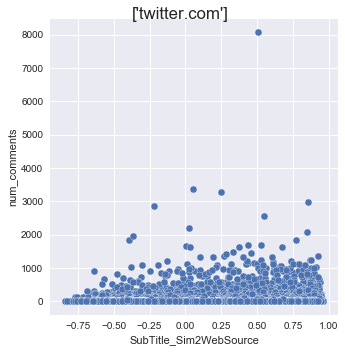

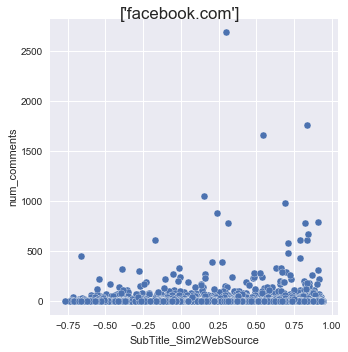

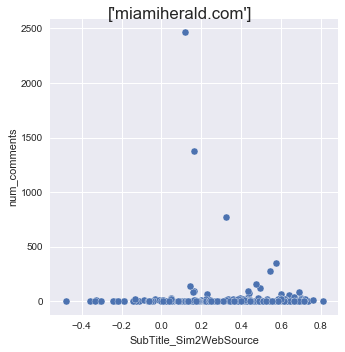

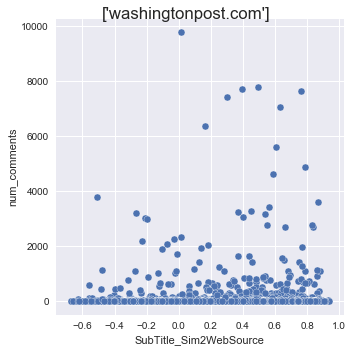

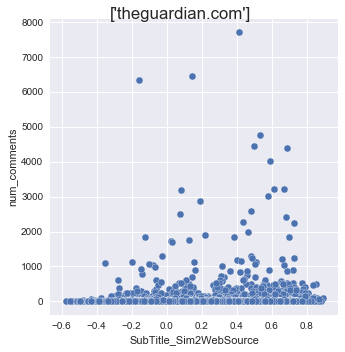

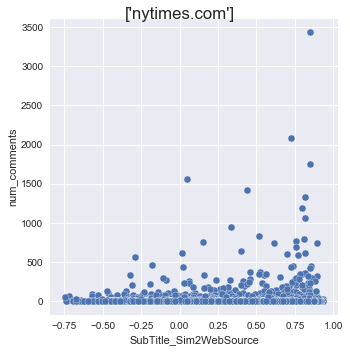

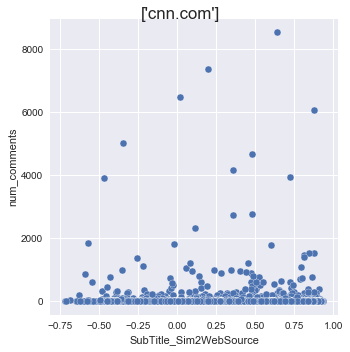

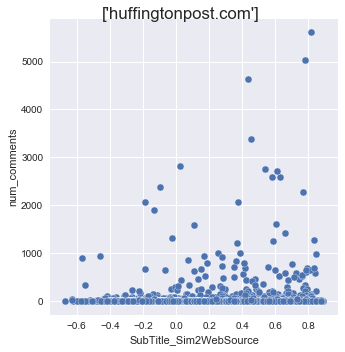

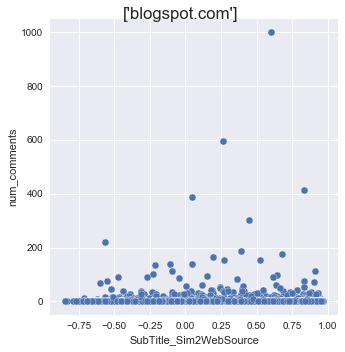

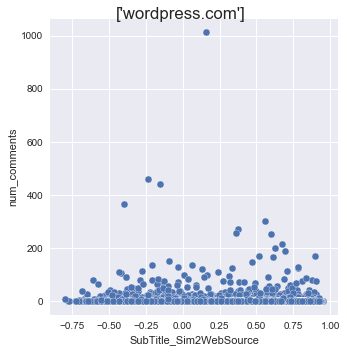

In [611]:
for web_source in topDomains:
    ax=sns.pairplot(x_vars=["SubTitle_Sim2WebSource"], y_vars=["num_comments"], data=reddit_dat[reddit_dat["web_source"]==web_source], size=5);
    ax.fig.suptitle(reddit_dat[reddit_dat["web_source"]==web_source].web_source.unique())

In [612]:
linregress(reddit_dat['SubTitle_Sim2WebSource'],reddit_dat['num_comments'])

LinregressResult(slope=1.0216232217807153, intercept=10.596503272520774, rvalue=0.003189119930891741, pvalue=6.778031807651126e-08, stderr=0.18929563114549816)

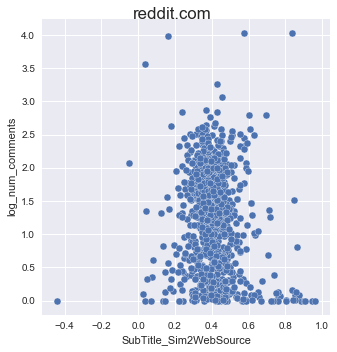

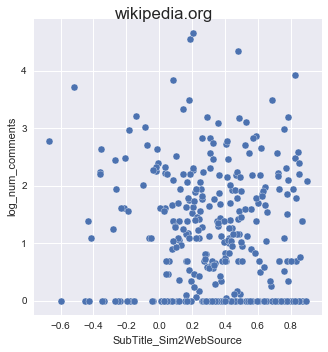

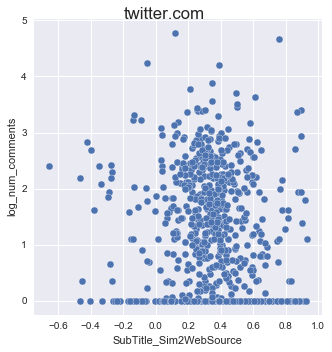

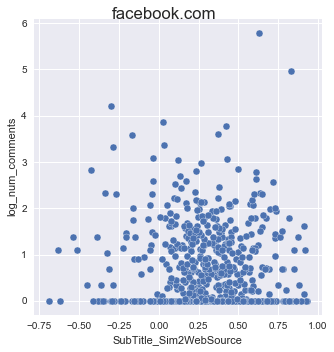

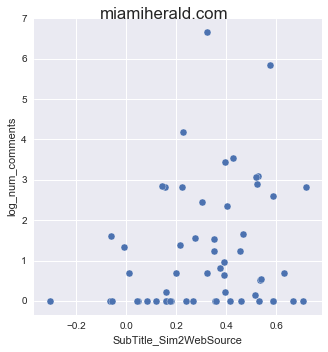

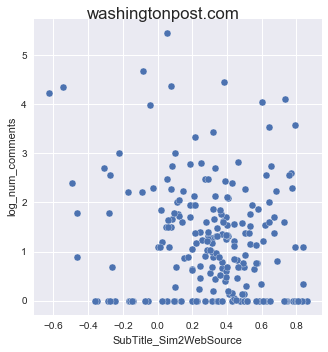

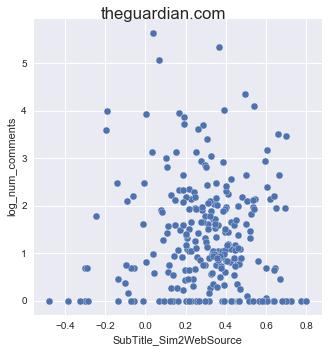

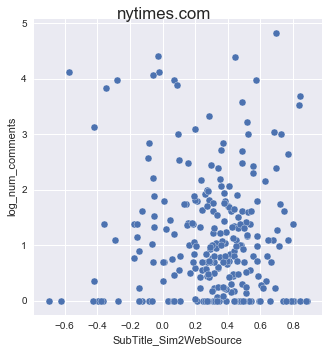

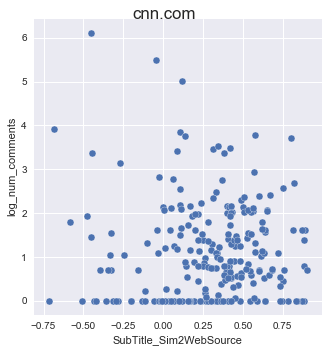

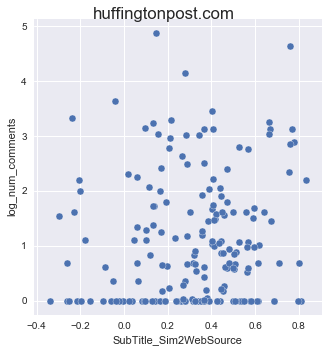

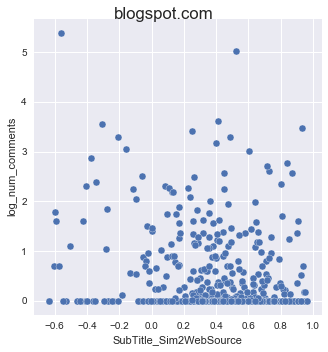

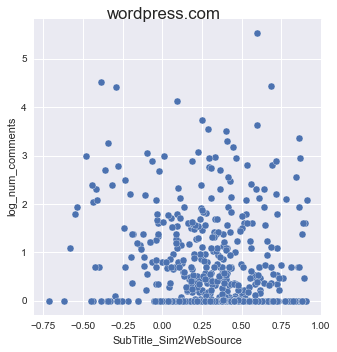

In [613]:
simAggDat=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'log_num_comments':'mean',
                                                             'SubTitle_Sim2WebSource':'mean'})
for web_source in topDomains:
    ax=sns.pairplot(x_vars=["SubTitle_Sim2WebSource"], y_vars=["log_num_comments"], data=simAggDat[simAggDat["web_source"]==web_source], size=5);
    ax.fig.suptitle(web_source)

In [614]:
reddit_dat.to_csv("Submission_Nov16_AllFilteredSubreddit_WithSimilarityScores_50.csv")

### Submission Time Analysis:

In [615]:
#Time of submission
reddit_dat['created_utc'] = pd.to_datetime(reddit_dat['created_utc'],unit='s')
reddit_dat['retrieved_on'] = pd.to_datetime(reddit_dat['retrieved_on'],unit='s')
reddit_dat['created_day']=reddit_dat['created_utc'].dt.weekday_name
reddit_dat['created_hour']=reddit_dat['created_utc'].dt.hour

In [616]:
aggDayDat=reddit_dat.groupby(['created_day','created_hour'],as_index=False).agg({'id':{'num_submissions':'nunique'},
                                         'num_comments':{'total_comments':'sum',
                                                         'avg_comments':'mean'}})
aggDayDat.columns.droplevel(level=0)
aggDayDat.columns=['Day','Hour', 'num_submissions', 'total_comments', 'avg_comments']

C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [617]:
heatmapDat=aggDayDat[['Day','Hour','avg_comments']]
heatmapDat['Day'] = pd.Categorical(heatmapDat['Day'], 
                                           categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], 
                                           ordered=True)
heatmapDat=heatmapDat.pivot(index='Day', columns='Hour', values='avg_comments')

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


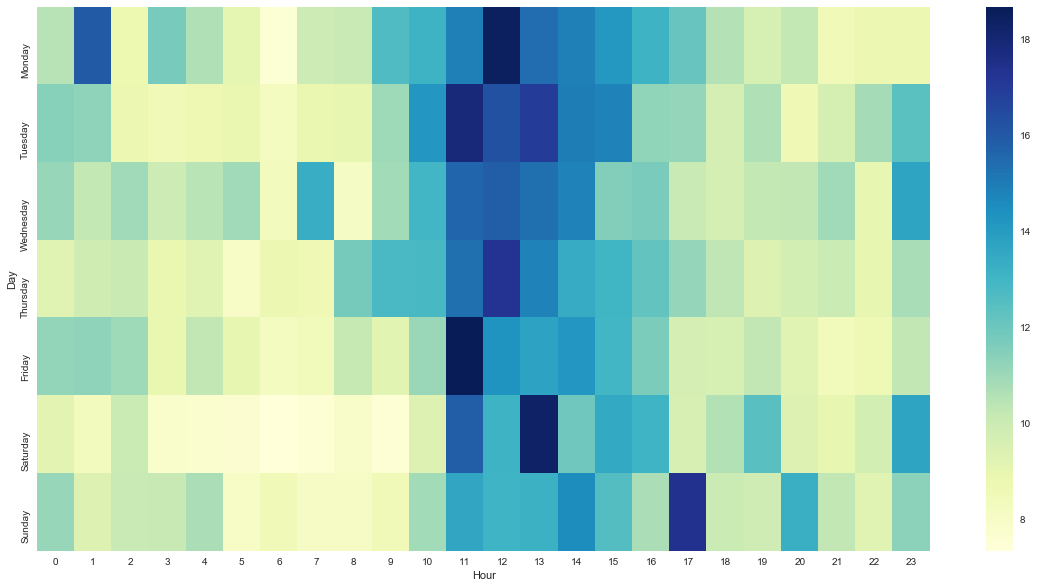

In [618]:
plt.figure(figsize=(20,10));
sns.heatmap(heatmapDat,cmap="YlGnBu");

Most activity is around 10-5

In [619]:
aggDayDat=reddit_dat.groupby(['created_day','created_hour'],as_index=False).agg({'id':{'num_submissions':'nunique'},
                                         'num_comments':{'total_comments':'sum',
                                                         'avg_comments':'mean'}})
aggDayDat.columns.droplevel(level=0)
aggDayDat.columns=['created_day','created_hour', 'num_submissions_perday', 'total_comments_perday', 'avg_comments_perday']

C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [620]:
reddit_dat=reddit_dat.merge(aggDayDat,on=['created_day','created_hour'])

In [621]:
np.corrcoef(reddit_dat['avg_comments_perday'],reddit_dat['num_comments'])

array([[1.        , 0.01629341],
       [0.01629341, 1.        ]])

In [622]:
linregress(reddit_dat['avg_comments_perday'],reddit_dat['num_comments'])

LinregressResult(slope=1.000000000000023, intercept=-2.611244553918368e-13, rvalue=0.01629341254880998, pvalue=2.2103079193970256e-167, stderr=0.03626211961609591)

Day and hour of submission has an impact on the number of comments the post receives

### Time since last submission, in subreddit:

In [623]:
from datetime import timedelta

In [624]:
reddit_dat['last_submission_time_websourceSubreddit']=reddit_dat.sort_values(['created_utc']).groupby(['subreddit','web_source'])['created_utc'].shift(1)
reddit_dat['last_submission_time_subReddit']=reddit_dat.sort_values(['created_utc']).groupby(['subreddit'])['created_utc'].shift(1)
reddit_dat['last_submission_time_websource']=reddit_dat.sort_values(['created_utc']).groupby(['web_source'])['created_utc'].shift(1)
reddit_dat['last_submission_time_subRedditAuth']=reddit_dat.sort_values(['created_utc']).groupby(['subreddit','author'])['created_utc'].shift(1)


reddit_dat['time_since_last_sub_websourceSubReddit']=(reddit_dat['created_utc']-reddit_dat['last_submission_time_websourceSubreddit'])/timedelta(hours=1)
reddit_dat['time_since_last_sub_SubReddit']=(reddit_dat['created_utc']-reddit_dat['last_submission_time_subReddit'])/timedelta(hours=1)
reddit_dat['time_since_last_sub_websource']=(reddit_dat['created_utc']-reddit_dat['last_submission_time_websource'])/timedelta(hours=1)
reddit_dat['time_since_last_sub_subRedditAuth']=(reddit_dat['created_utc']-reddit_dat['last_submission_time_subRedditAuth'])/timedelta(hours=1)

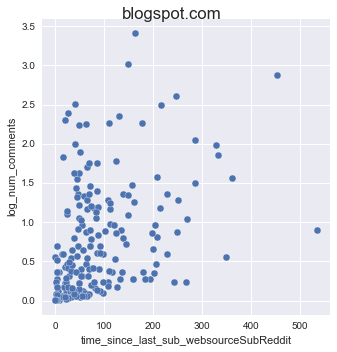

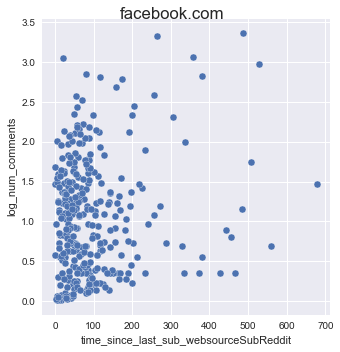

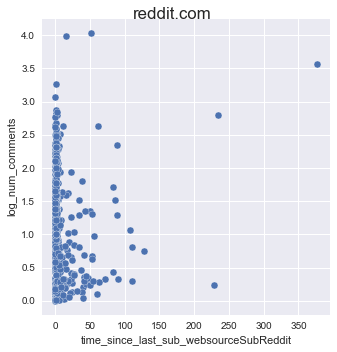

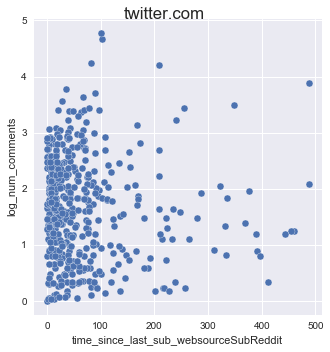

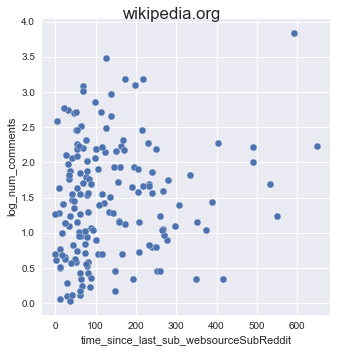

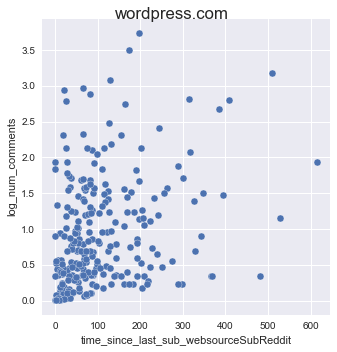

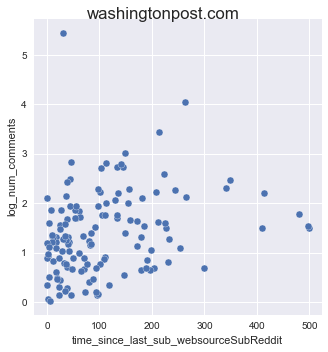

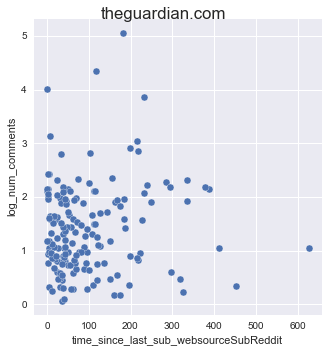

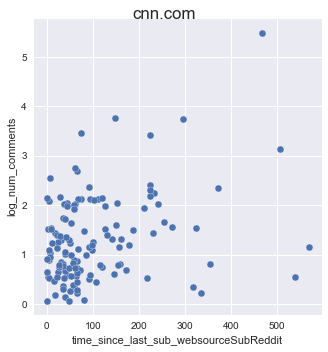

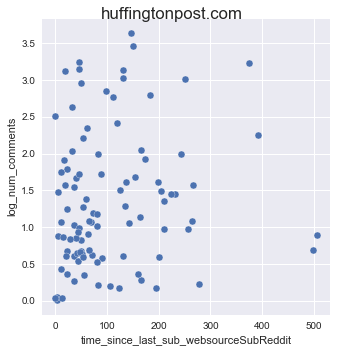

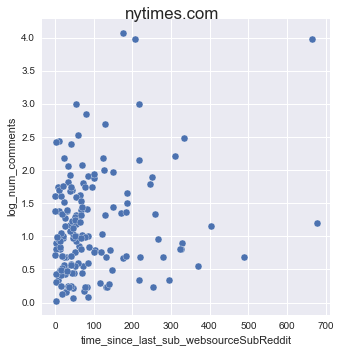

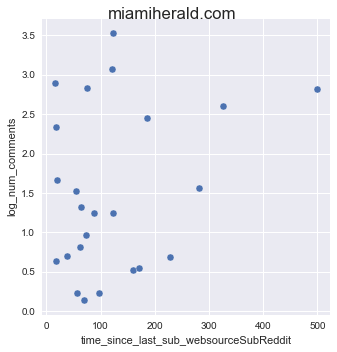

In [625]:
aggDat=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'log_num_comments':'mean',
                                                          'time_since_last_sub_websourceSubReddit':'mean'})
for web_source in aggDat.web_source.unique():
    ax=sns.pairplot(x_vars=["time_since_last_sub_websourceSubReddit"], y_vars=["log_num_comments"], 
                    data=aggDat[(aggDat["web_source"]==web_source) & (aggDat["log_num_comments"]>0)], size=5);
    ax.fig.suptitle(web_source)

Text(0.5,0.98,'Avg. Time Gap B/w Submissions and Avg. # of Comments, across subreddits')

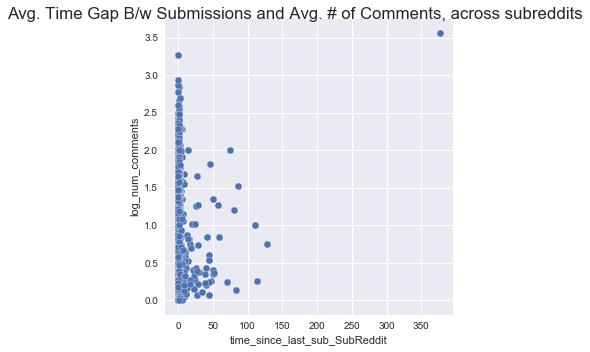

In [626]:
aggDat=reddit_dat.groupby(['subreddit'],as_index=False).agg({'log_num_comments':'mean',
                                                          'time_since_last_sub_SubReddit':'mean'})
ax=sns.pairplot(x_vars=["time_since_last_sub_SubReddit"], y_vars=["log_num_comments"], 
                    data=aggDat[(aggDat["log_num_comments"]>0)], size=5);
ax.fig.suptitle("Avg. Time Gap B/w Submissions and Avg. # of Comments, across subreddits")

Wit increase in time gap between submissions dedicated to a domain, on an average the number of comments increase exponentially. However, the time gap between submission within a subreddit doesn't have a huge impact.

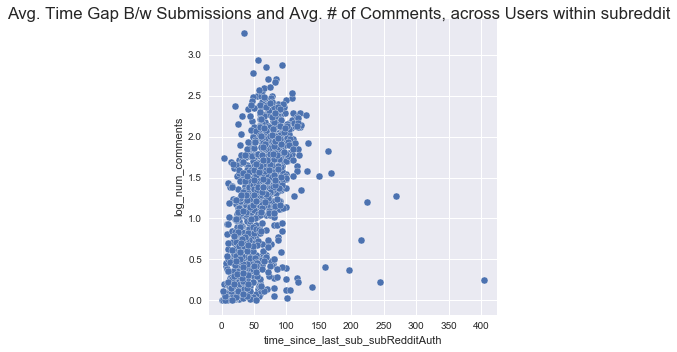

In [627]:
aggDat=reddit_dat.groupby(['subreddit'],as_index=False).agg({'log_num_comments':'mean',
                                                          'time_since_last_sub_subRedditAuth':'mean'})
ax=sns.pairplot(x_vars=["time_since_last_sub_subRedditAuth"], 
                y_vars=["log_num_comments"], 
                data=aggDat[(aggDat["log_num_comments"]>0)], size=5);
ax.fig.suptitle("Avg. Time Gap B/w Submissions and Avg. # of Comments, across Users within subreddit");

On an average, if users of a subreddit take more time b/w submission (upto 2 days) the comments increase for the post, after which comments seem to decrease on an average. Also, for most subreddits, avg. usersubmission time b/w posts is only about 2 days

### Author Activity analysis

In [628]:
# User  level feature analysis
userFeatDat=reddit_dat.groupby(['author','subreddit'],as_index=False).agg({'id':{'num_submissions_perauthsubreddit':'nunique'},
                                               'num_comments':{'avg_comments_perauthsubreddit':'mean'},
                                                                          'score':{'avg_score_authsubreddit':'mean'}})
userFeatDat.columns=userFeatDat.columns.droplevel(level=0)
userFeatDat.columns=['author', 'subreddit', 'num_submissions_perauthsubreddit', 'avg_comments_perauthsubreddit','avg_score_authsubreddit']

C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [629]:
subredditDat=reddit_dat.groupby(['subreddit'],as_index=False).agg({'id':{'num_submissions_persubreddit':'nunique'},
                                               'num_comments':{'avg_comments_persubreddit':'mean'}})
subredditDat.columns=subredditDat.columns.droplevel(level=0)
subredditDat.columns=['subreddit', 'num_submissions_persubreddit', 'avg_comments_persubreddit']

C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [630]:
userFeatDat=userFeatDat.merge(subredditDat,on=['subreddit'])

In [631]:
userFeatDat['author_submission_in_subreddit_pct']=userFeatDat['num_submissions_perauthsubreddit']/userFeatDat['num_submissions_persubreddit']
userFeatDat['author_recd_cmmnts_in_subreddit_pct']=userFeatDat['avg_comments_perauthsubreddit']/userFeatDat['avg_comments_persubreddit']

In [632]:
len(reddit_dat[(reddit_dat['author']=='[deleted]') | (reddit_dat['author'].isnull()) |(reddit_dat['author']==' ')]) #18% of submissions are from deleted authors

684025

In [633]:
reddit_dat.shape

(2863878, 47)

In [634]:
reddit_dat=reddit_dat.merge(userFeatDat,on=['subreddit','author'])

In [635]:
userFeatDat=reddit_dat.groupby(['author'],as_index=False).agg({'subreddit':'nunique',
                                                              'web_source':'nunique',
                                                              'num_comments':'mean'})
userFeatDat.columns=['author','no_subreddits_perauth','no_websource_perauth','avg_comments_perauth']

In [636]:
reddit_dat=reddit_dat.merge(userFeatDat,on=['author'])

In [637]:
reddit_dat['log_author_submission_in_subreddit_pct']=np.log(reddit_dat['author_submission_in_subreddit_pct'])
reddit_dat['log_author_submission_in_subreddit_pct']=np.where(np.isnan(reddit_dat['log_author_submission_in_subreddit_pct']) | 
                                                              np.isinf(reddit_dat['log_author_submission_in_subreddit_pct'])
                                                              ,0,reddit_dat['log_author_submission_in_subreddit_pct'])

In [638]:
aggDat=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'num_comments':'mean',
                                                                         'avg_score_authsubreddit':'mean',
                                                                        'avg_comments_perauthsubreddit':'mean',
                                                                        'num_submissions_perauthsubreddit':'mean',
                                                                         'no_subreddits_perauth':'mean',
                                                                         'no_websource_perauth':'mean'})

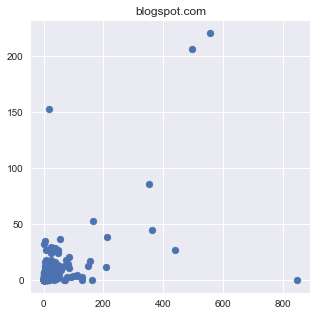

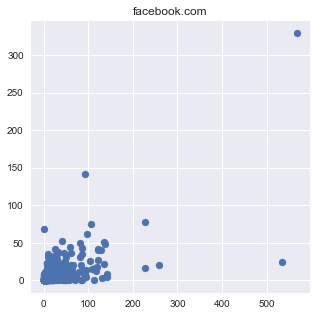

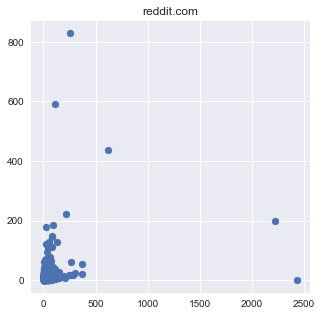

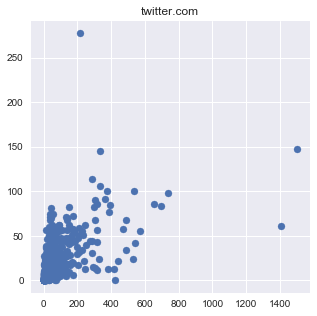

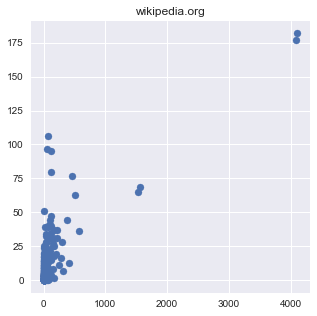

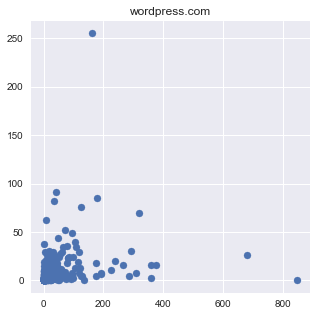

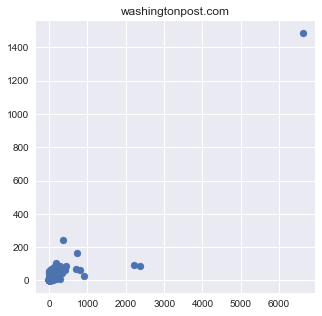

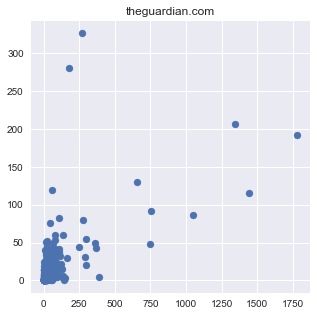

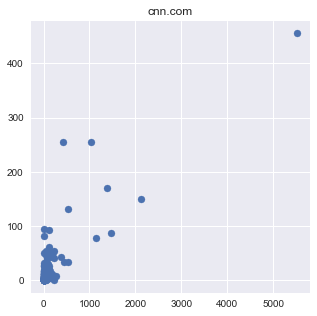

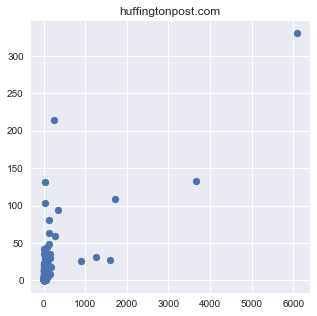

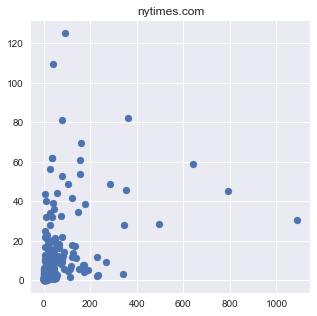

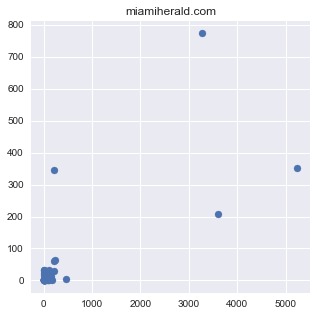

In [639]:
for web_source in aggDat.web_source.unique():
    plt.figure(figsize=(5,5))
    aggDat_sub=aggDat[aggDat['web_source']==web_source]
    plt.scatter(x=aggDat_sub['avg_score_authsubreddit'],y=aggDat_sub['num_comments'])
    plt.title(web_source)

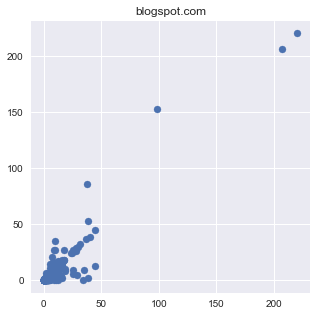

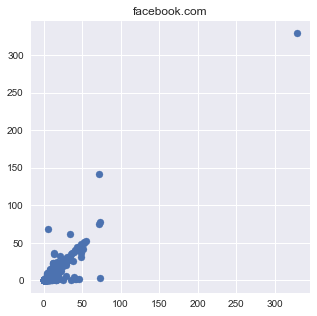

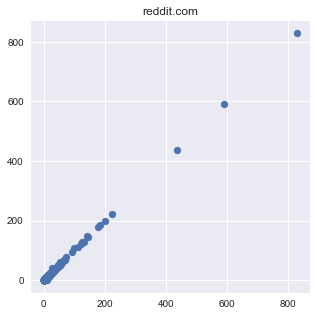

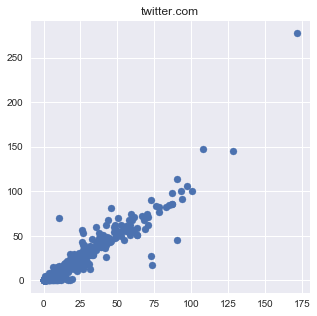

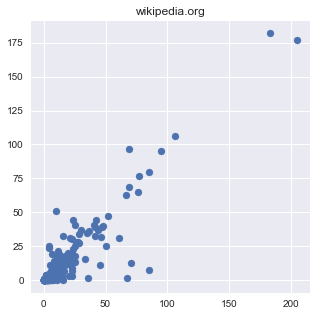

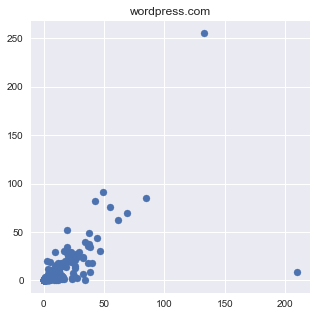

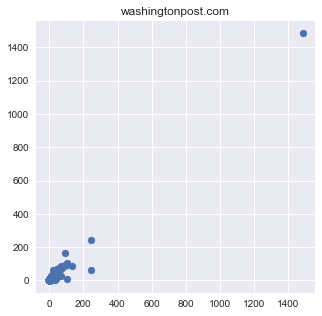

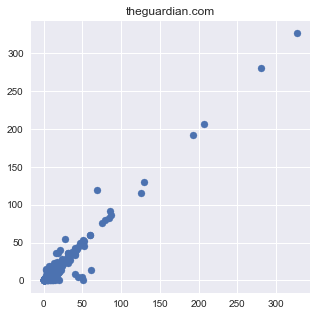

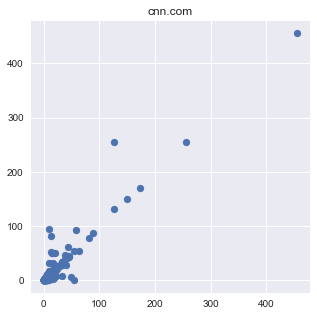

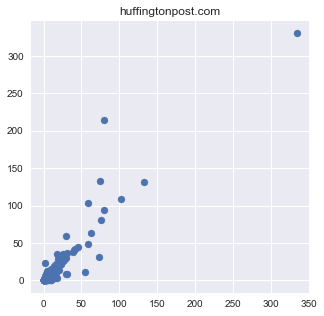

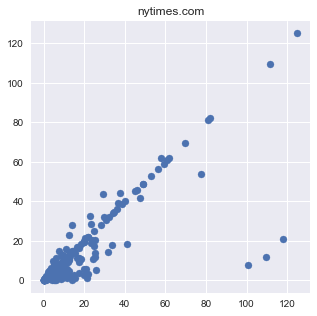

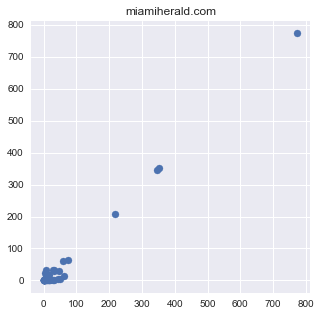

In [640]:
for web_source in aggDat.web_source.unique():
    plt.figure(figsize=(5,5))
    aggDat_sub=aggDat[aggDat['web_source']==web_source]
    plt.scatter(x=aggDat_sub['avg_comments_perauthsubreddit'],y=aggDat_sub['num_comments'])
    plt.title(web_source);

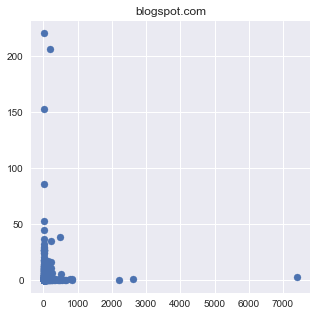

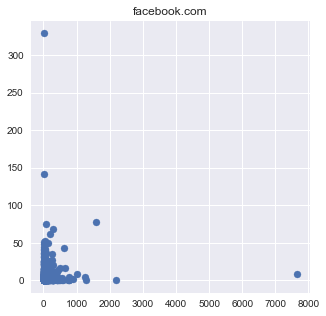

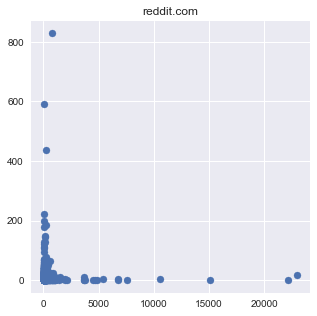

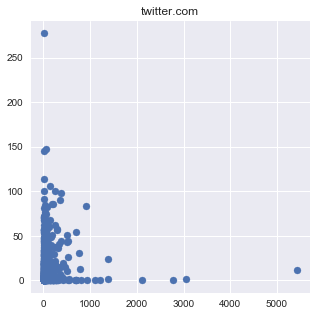

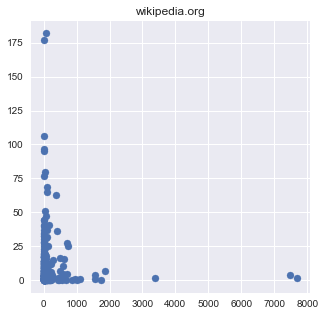

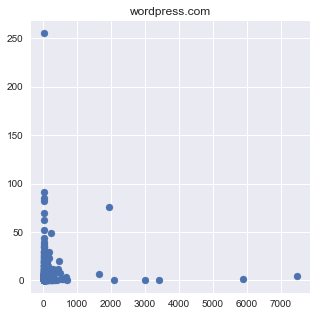

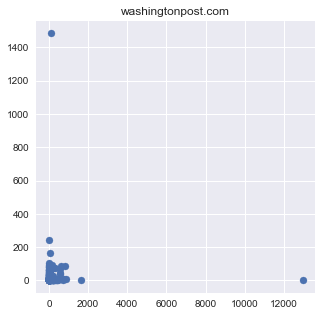

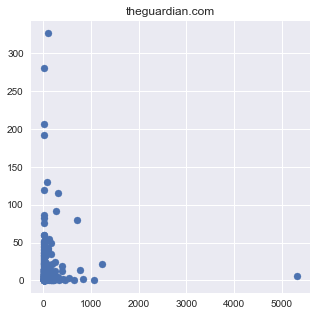

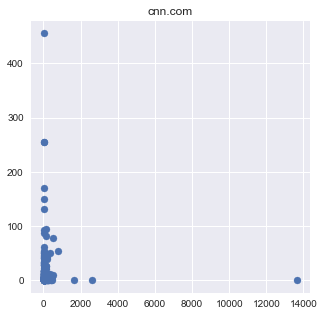

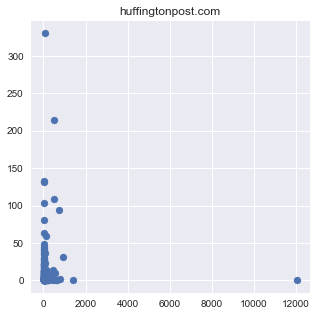

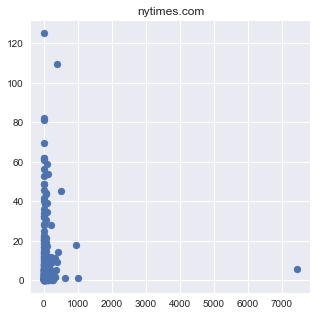

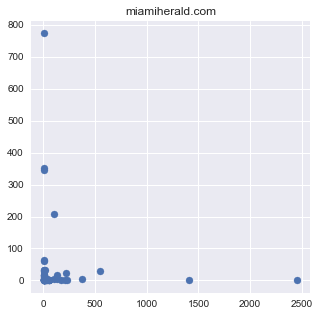

In [641]:
for web_source in aggDat.web_source.unique():
    plt.figure(figsize=(5,5))
    aggDat_sub=aggDat[aggDat['web_source']==web_source] 
    plt.scatter(x=aggDat_sub['num_submissions_perauthsubreddit'],y=aggDat_sub['num_comments'])
    plt.title(web_source);

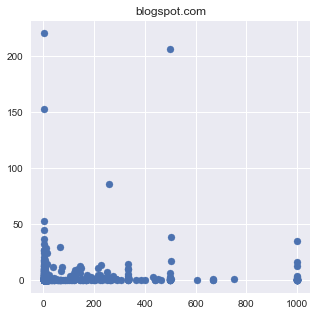

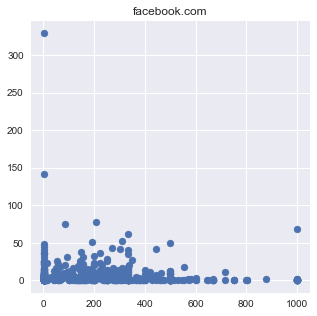

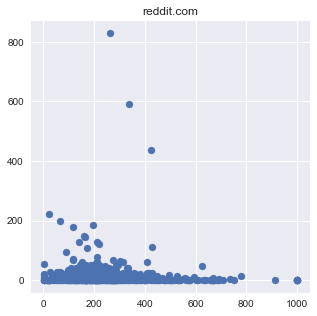

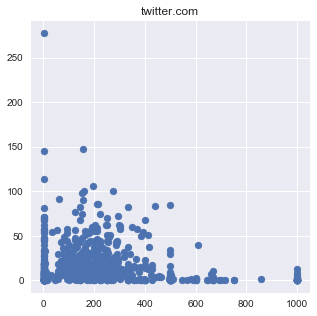

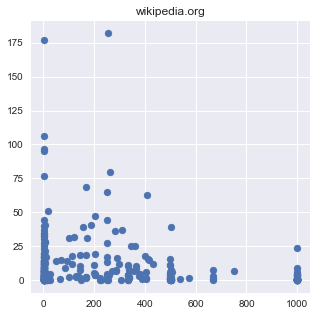

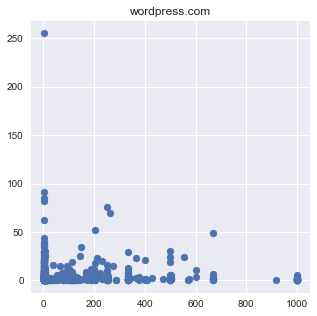

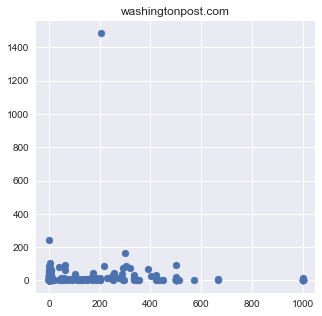

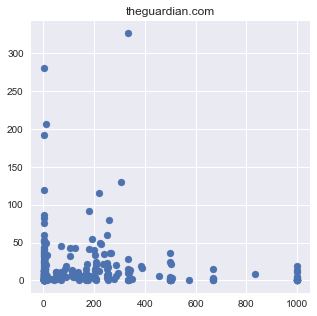

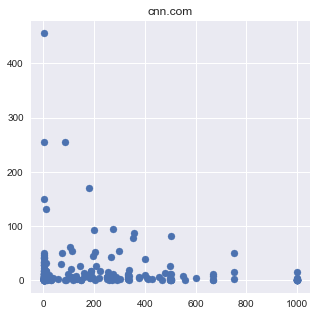

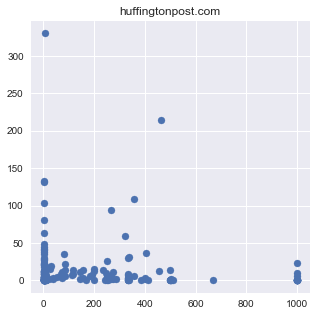

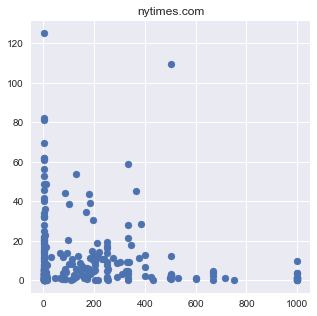

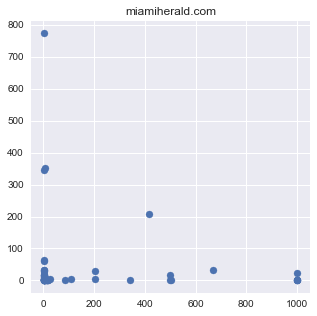

In [642]:
for web_source in aggDat.web_source.unique():
    plt.figure(figsize=(5,5))
    aggDat_sub=aggDat[aggDat['web_source']==web_source] 
    plt.scatter(x=aggDat_sub['no_subreddits_perauth'],y=aggDat_sub['num_comments'])
    plt.title(web_source);

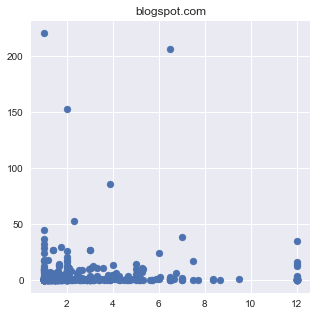

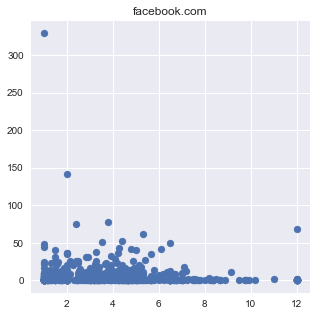

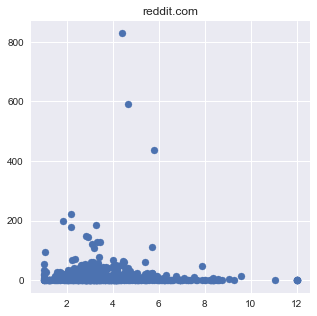

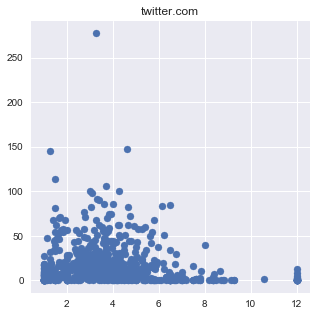

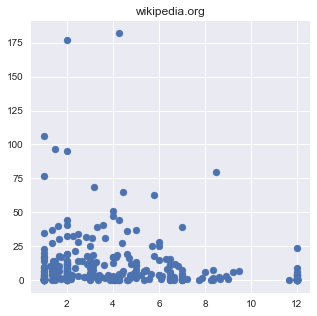

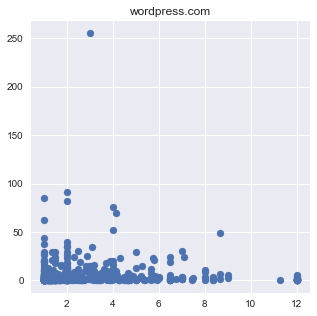

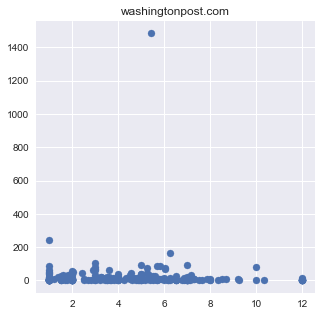

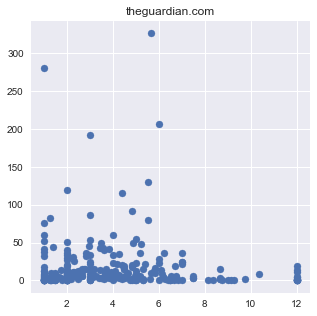

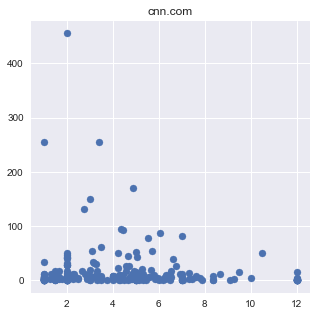

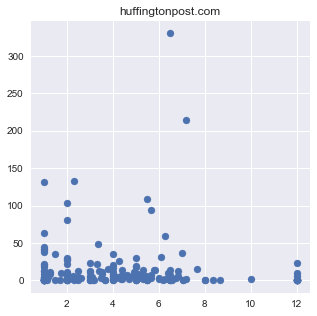

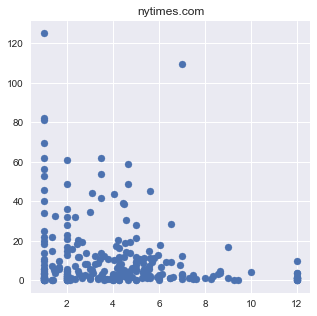

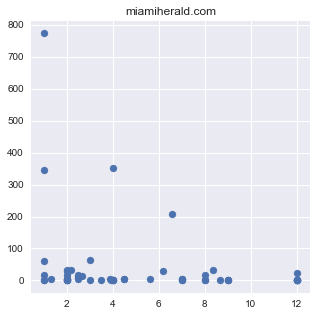

In [643]:
for web_source in aggDat.web_source.unique():
    plt.figure(figsize=(5,5))
    aggDat_sub=aggDat[aggDat['web_source']==web_source] 
    plt.scatter(x=aggDat_sub['no_websource_perauth'],y=aggDat_sub['num_comments'])
    plt.title(web_source);

In [644]:
reddit_dat[['num_comments','avg_score_authsubreddit','no_websource_perauth',
                       'no_subreddits_perauth','num_submissions_perauthsubreddit','avg_comments_perauthsubreddit']].corr()

num_comments  avg_score_authsubreddit  \
num_comments                          1.000000                 0.296136   
avg_score_authsubreddit               0.296136                 1.000000   
no_websource_perauth                 -0.027298                -0.022124   
no_subreddits_perauth                -0.027273                -0.029082   
num_submissions_perauthsubreddit     -0.016298                -0.017143   
avg_comments_perauthsubreddit         0.660962                 0.448037   

                                  no_websource_perauth  no_subreddits_perauth  \
num_comments                                 -0.027298              -0.027273   
avg_score_authsubreddit                      -0.022124              -0.029082   
no_websource_perauth                          1.000000               0.993827   
no_subreddits_perauth                         0.993827               1.000000   
num_submissions_perauthsubreddit              0.555631               0.558467   
avg_comments_perauthsubreddit                -0.041301              -0.041263   

                                  num_submissions_perauthsubreddit  \
num_comments                                             -0.016298   
avg_score_authsubreddit                                  -0.017143   
no_websource_perauth                                      0.555631   
no_subreddits_perauth                                     0.558467   
num_submissions_perauthsubreddit                          1.000000   
avg_comments_perauthsubreddit                            -0.024658   

                                  avg_comments_perauthsubreddit  
num_comments                                           0.660962  
avg_score_authsubreddit                                0.448037  
no_websource_perauth                                  -0.041301  
no_subreddits_perauth                                 -0.041263  
num_submissions_perauthsubreddit                      -0.024658  
avg_comments_perauthsubreddit                          1.000000

No. of comments a post receives depends on how popular is the author within the community.

### Author and Link Flair Analysis:

In [645]:
reddit_dat.loc[~reddit_dat['author_flair_text'].isnull(),'is_author_flair'] = 1
reddit_dat.loc[reddit_dat['author_flair_text'].isnull(),'is_author_flair'] = 0

In [646]:
reddit_dat.loc[~reddit_dat['link_flair_text'].isnull(),'is_link_flair'] = 1
reddit_dat.loc[reddit_dat['link_flair_text'].isnull(),'is_link_flair'] = 0

### Subreddit activity analysis:

In [647]:
#Subreddit popularity
subredditFeatDat=reddit_dat.groupby(['subreddit_id'],as_index=False).agg({'author':{'num_unq_authors':'nunique'},
                                                                     'num_comments':{'avg_comments':'mean'},
                                                                    'id':{'num_submissions':'nunique'}})
subredditFeatDat.columns=subredditFeatDat.columns.droplevel(level=0)
subredditFeatDat.columns=['subreddit_id','num_unq_authors_persubreddit','avg_comments_persubreddit','num_submissions_persubreddit']

C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [648]:
reddit_dat=reddit_dat.merge(subredditFeatDat,on=['subreddit_id'])

In [649]:
reddit_dat['submission_age']=(reddit_dat.retrieved_on-reddit_dat.created_utc)/timedelta(hours=1)

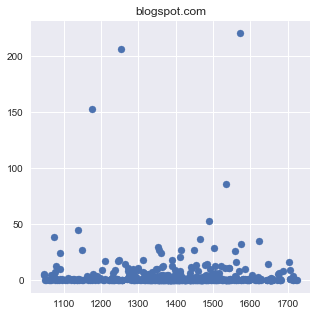

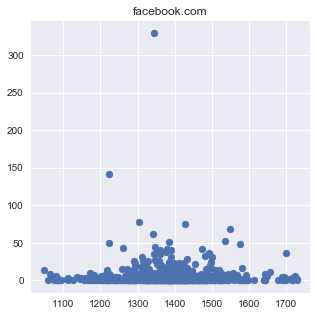

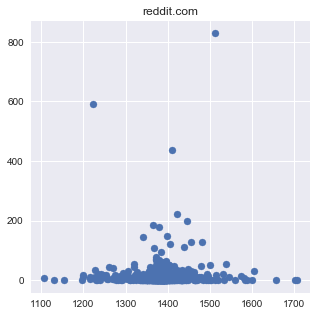

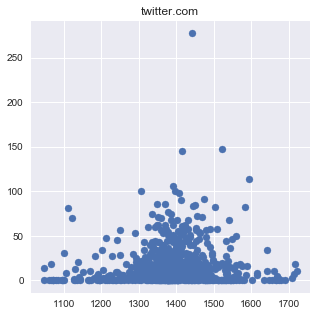

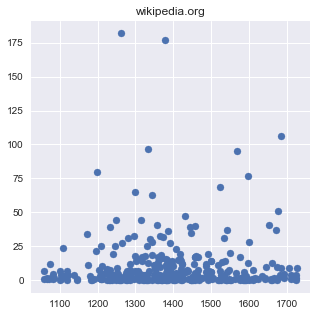

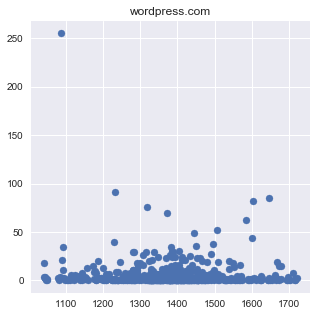

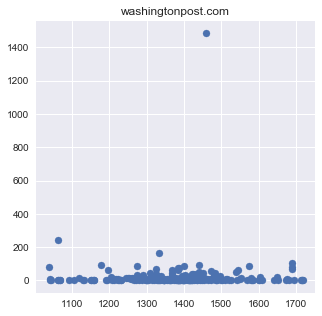

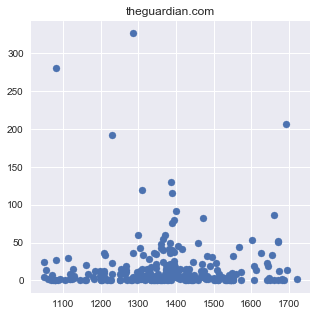

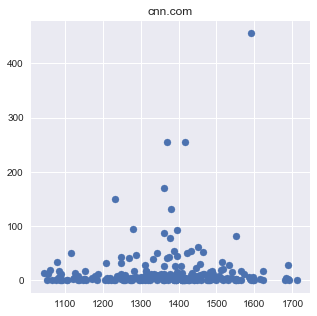

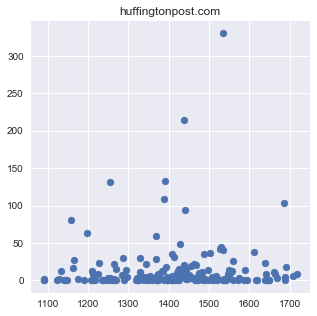

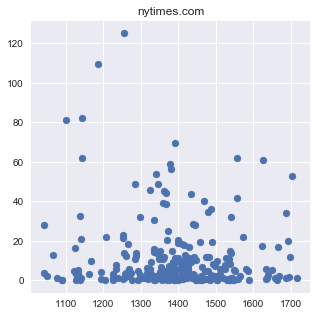

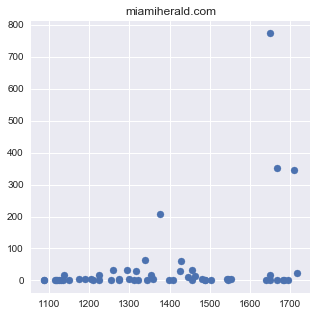

In [650]:
aggDat=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'submission_age':'mean',
                                                                          'num_comments':'mean'})
for web_source in aggDat.web_source.unique():
    plt.figure(figsize=(5,5))
    aggDat_sub=aggDat[aggDat['web_source']==web_source]
    plt.scatter(x=aggDat_sub['submission_age'],y=aggDat_sub['num_comments'])
    plt.title(web_source)

In [651]:
np.corrcoef(reddit_dat.submission_age,reddit_dat.score)

array([[1.        , 0.00362436],
       [0.00362436, 1.        ]])

### Title Length and Self Text Length analysis:

In [652]:
reddit_dat['title_length']=reddit_dat['title'].str.split().str.len()

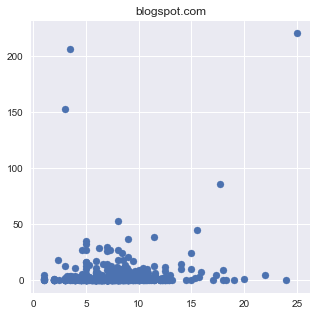

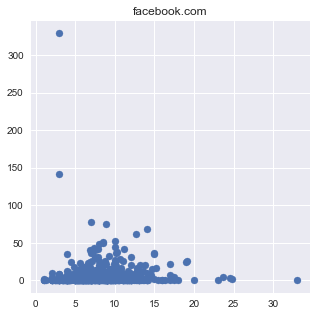

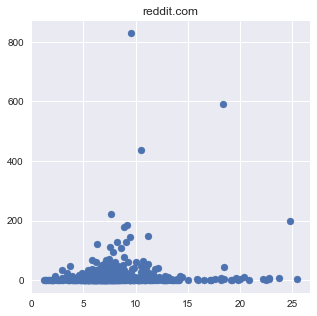

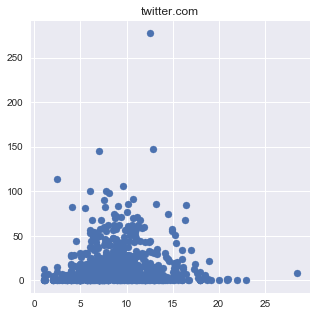

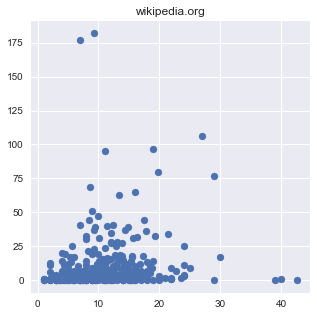

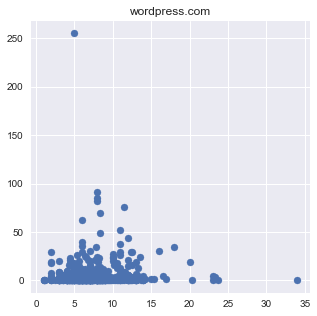

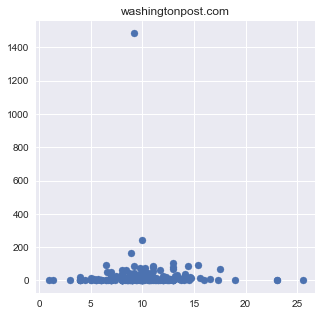

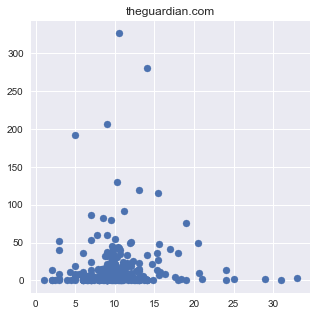

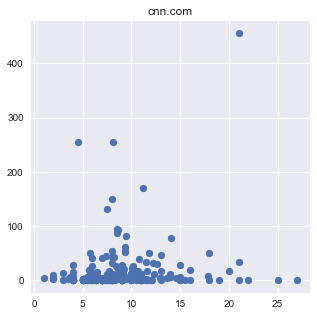

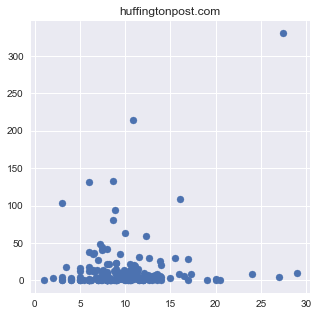

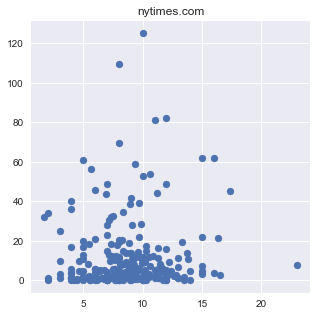

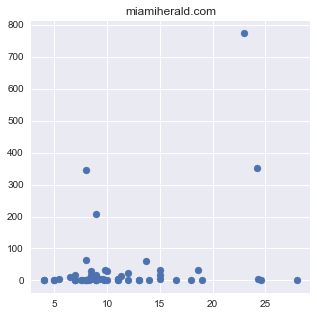

In [653]:
aggDat=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'title_length':'mean',
                                                                          'num_comments':'mean'})
for web_source in aggDat.web_source.unique():
    plt.figure(figsize=(5,5))
    aggDat_sub=aggDat[aggDat['web_source']==web_source]
    plt.scatter(x=aggDat_sub['title_length'],y=aggDat_sub['num_comments'])
    plt.title(web_source)

In [656]:
np.corrcoef(reddit_dat.title_length,reddit_dat.num_comments)

array([[nan, nan],
       [nan,  1.]])

In [663]:
linregress(aggDat.title_length,aggDat.num_comments)

LinregressResult(slope=0.9481908468056238, intercept=4.357097498652601, rvalue=0.09858790708170523, pvalue=7.709501811068085e-12, stderr=0.13820113870366077)

In [658]:
reddit_dat['selftText_len']=reddit_dat['selftext'].str.split().str.len()

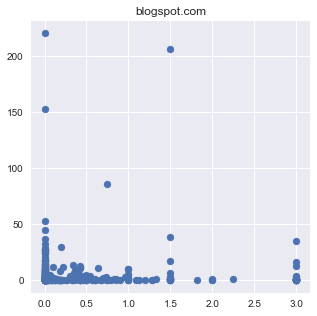

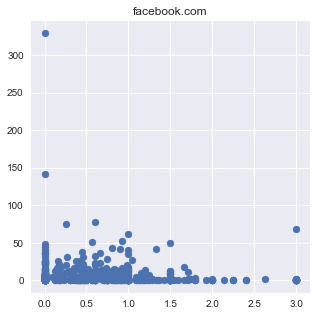

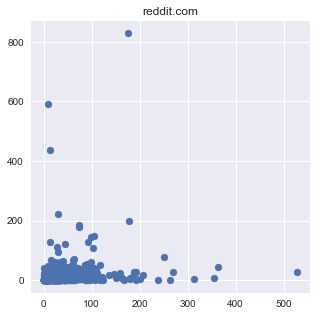

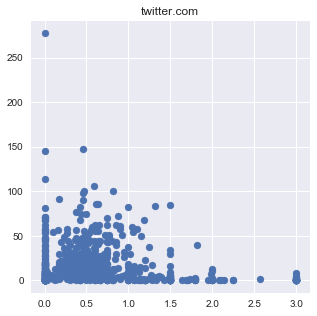

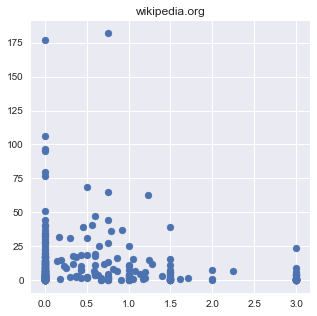

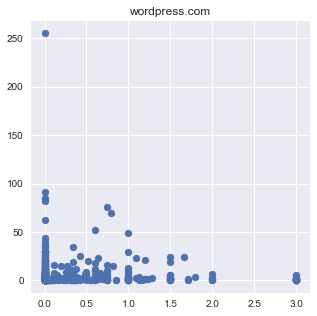

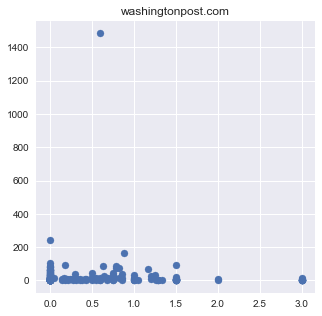

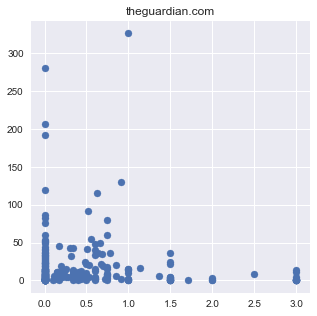

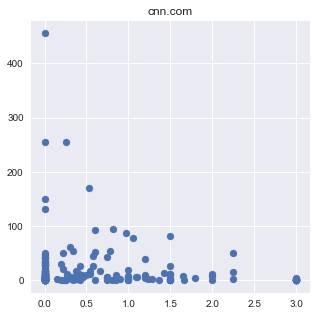

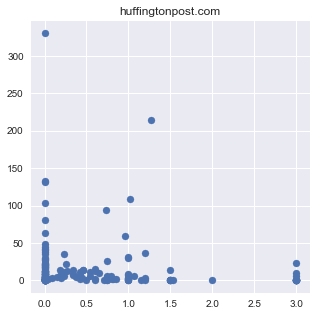

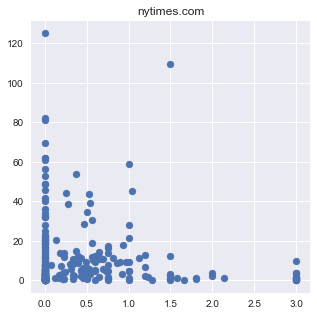

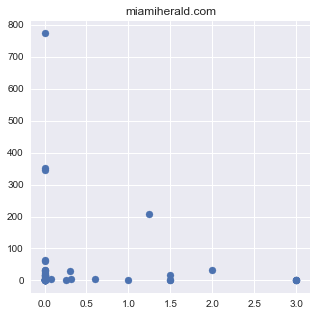

In [250]:
aggDat=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'selftText_len':'mean',
                                                                          'num_comments':'mean'})
for web_source in aggDat.web_source.unique():
    plt.figure(figsize=(5,5))
    aggDat_sub=aggDat[aggDat['web_source']==web_source]
    plt.scatter(x=aggDat_sub['selftText_len'],y=aggDat_sub['num_comments'])
    plt.title(web_source)

In [661]:
linregress(aggDat.selftText_len,aggDat.num_comments)

AttributeError: 'DataFrame' object has no attribute 'selftText_len'

### Removing Bot and Deleted Users:

In [664]:
reddit_dat=reddit_dat[~((reddit_dat['author'].str.startswith('bot')) | (reddit_dat['author'].str.endswith('bot')))]

In [665]:
reddit_dat.shape

(2862344, 66)

In [666]:
reddit_dat=reddit_dat[~((reddit_dat['author']==' ') | 
                        (reddit_dat['author']=='[deleted]') |
                       (reddit_dat['author'].isnull()))]

In [667]:
reddit_dat.shape

(2178319, 66)

In [668]:
reddit_dat.to_csv("Subreddit_Nov2016Submissions_AllFilteredSubredditsAddFeat.csv")

### How does previous post popularity of a URL in a domain influence popularity of new post?

In [672]:
reddit_dat['prev_post_num_comments']=reddit_dat.sort_values(['created_utc']).groupby(['subreddit','web_source'])['num_comments'].shift(1)

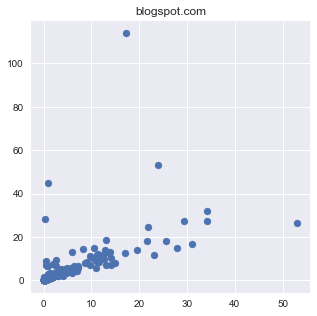

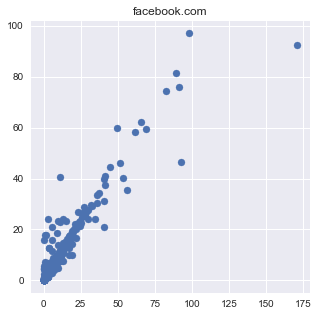

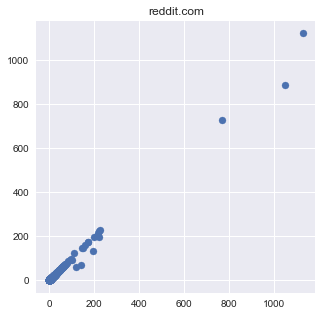

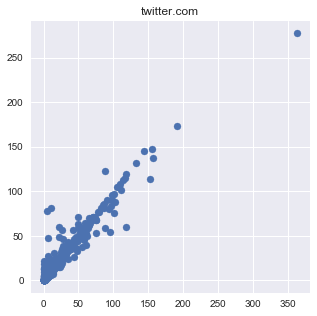

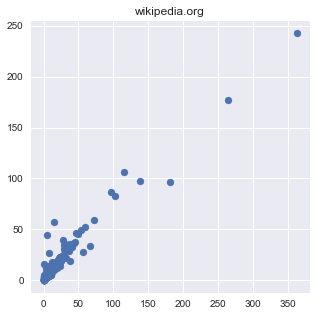

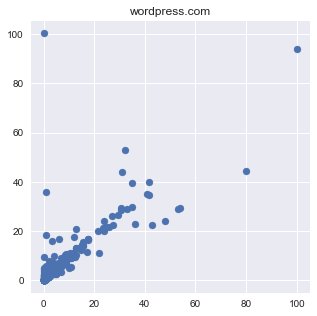

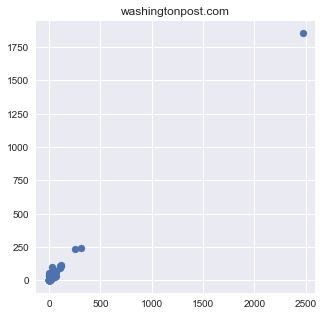

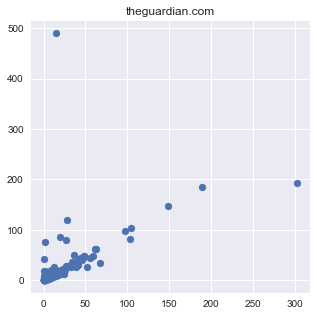

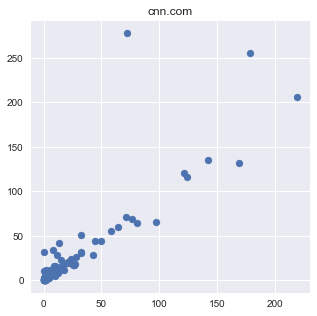

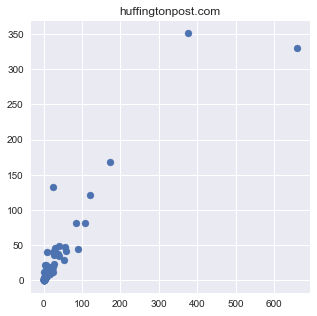

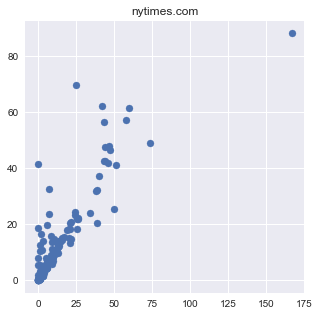

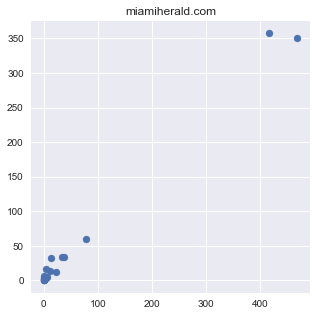

In [284]:
aggDat=reddit_dat.groupby(['subreddit','web_source'],as_index=False).agg({'prev_post_num_comments':'mean',
                                                                          'num_comments':'mean'})
for web_source in aggDat.web_source.unique():
    plt.figure(figsize=(5,5))
    aggDat_sub=aggDat[aggDat['web_source']==web_source]
    plt.scatter(x=aggDat_sub['prev_post_num_comments'],y=aggDat_sub['num_comments'])
    plt.title(web_source)

### Removing all deleted posts from analysis

In [673]:
reddit_dat=reddit_dat[~((reddit_dat['title']==' ') | 
                        (reddit_dat['title']=='[ delete ]') |
                       (reddit_dat['title'].isnull()))]

In [674]:
reddit_dat.shape

(2177368, 67)

### All Reddit All URL Modelling:

In [675]:
modelling_data=reddit_dat[['subreddit','id','author','web_source',
                           'num_comments','is_self',
                           'over_18','ups','downs',
                           'title_length','selftText_len',
                           'title_sentiment_subjectivity','title_sentiment_polarity',
                           'avg_comments_perday',
                           'subreddit_deleted','subreddit_removed',
                          'SubTitle_Sim2Subreddit','SubTitle_Sim2WebSource',
                           'time_since_last_sub_websourceSubReddit','time_since_last_sub_SubReddit',
                           'time_since_last_sub_websource','time_since_last_sub_subRedditAuth',
                           'avg_score_authsubreddit',
                           'is_author_flair','is_link_flair',
                          'num_unq_authors_persubreddit','no_subreddits_perauth','no_websource_perauth',
                           'avg_comments_persubreddit_y','submission_age','prev_post_num_comments']]

In [676]:
modelling_data=modelling_data.drop_duplicates(keep=False)

In [677]:
#Keep only those posts for modelling which received at least 1 comment
modelling_data=modelling_data[modelling_data['num_comments']>0]

In [678]:
modelling_data['percentile_rank_cmmnts']=modelling_data.groupby(['subreddit']).num_comments.rank(pct=True)

In [698]:
X=modelling_data.loc[:, ~modelling_data.columns.isin(['num_comments','subreddit','id','author','web_source','percentile_rank_cmmnts'])]
Y=modelling_data[['num_comments']]

In [680]:
#day_dummies_dat = pd.get_dummies(X['created_day']).rename(columns=lambda x: 'Day_' + str(x))

In [681]:
#day_dummies_dat.sum(axis=0)

In [682]:
#hour_dummies_dat = pd.get_dummies(X['created_hour']).rename(columns=lambda x: 'Hour_' + str(x))

In [683]:
#hour_dummies_dat.sum(axis=0)

In [684]:
#X.drop(['created_day','created_hour'],inplace=True,axis=1)

In [685]:
#X=pd.concat([X,day_dummies_dat,hour_dummies_dat], axis=1)

In [699]:
X.fillna(0,inplace=True)

C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [700]:
#Setting up Train and Test for a simple model
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [688]:
#Building an overall Model
model=Lasso()
model.fit(X_train,y_train)
train_score=model.score(X_train,y_train)
test_score=model.score(X_test,y_test)
coeff_used = np.sum(model.coef_!=0)

In [689]:
train_score

0.16014013910083047

In [690]:
test_score

0.1734110248212275

In [691]:
y_test_pred=model.predict(X_test)
y_train_pred=model.predict(X_train)
train_rmse=np.sqrt(np.mean(np.power((y_train.unstack()-y_train_pred),2)))
test_rmse=np.sqrt(np.mean(np.power((y_test.unstack()-y_test_pred),2)))

In [692]:
train_rmse

179.29616877111835

In [693]:
test_rmse

146.35411480846295

In [694]:
coeff_used

15

In [695]:
X.columns[model.coef_!=0]

Index(['ups', 'selftText_len', 'avg_comments_perday', 'subreddit_deleted',
       'subreddit_removed', 'time_since_last_sub_websourceSubReddit',
       'time_since_last_sub_subRedditAuth', 'avg_score_authsubreddit',
       'is_link_flair', 'num_unq_authors_persubreddit',
       'no_subreddits_perauth', 'no_websource_perauth',
       'avg_comments_persubreddit_y', 'submission_age',
       'prev_post_num_comments'],
      dtype='object')

In [696]:
pd.DataFrame(X.columns,model.coef_)

0
 0.000000                                 is_self
 0.000000                                 over_18
 0.143880                                     ups
 0.000000                                   downs
-0.000000                            title_length
 0.055864                           selftText_len
 0.000000            title_sentiment_subjectivity
-0.000000                title_sentiment_polarity
 0.695379                     avg_comments_perday
-0.000040                       subreddit_deleted
 0.000775                       subreddit_removed
 0.000000                  SubTitle_Sim2Subreddit
 0.000000                  SubTitle_Sim2WebSource
-0.029417  time_since_last_sub_websourceSubReddit
-0.000000           time_since_last_sub_SubReddit
-0.000000           time_since_last_sub_websource
 0.006860       time_since_last_sub_subRedditAuth
-0.014620                 avg_score_authsubreddit
 0.000000                         is_author_flair
 0.481700                           is_link_flair
-0.000794            num_unq_authors_persubreddit
 0.446712                   no_subreddits_perauth
-1.488061                    no_websource_perauth
 1.075927             avg_comments_persubreddit_y
 0.003225                          submission_age
 0.027570                  prev_post_num_comments

In [390]:
model.intercept_

array([-16.19615665])

In [ ]:
#Try out GBM
from sklearn.ensemble import GradientBoostingRegressor
model=GradientBoostingRegressor(loss='ls',learning_rate=0.1, n_estimators=100)
model.fit(X_train,y_train)

C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### URL level modelling:

In [697]:
model=Lasso()

subreddit_model_perf_dict={'subreddit':[],'total_submissions':[],
                           'train_rsq':[],'test_rsq':[],'train_rmse':[],'test_rmse':[],
                          'sig_features':[]}

for web_source in modelling_data.web_source.unique():
    
    subreddit_dat=modelling_data[modelling_data['web_source']==web_source]
    X=subreddit_dat.loc[:, ~subreddit_dat.columns.isin(['num_comments','subreddit','id','author','web_source'])]
    Y=subreddit_dat[['num_comments']]
    
    #day_dummies_dat = pd.get_dummies(X['created_day']).rename(columns=lambda x: 'Day_' + str(x))
    #hour_dummies_dat = pd.get_dummies(X['created_hour']).rename(columns=lambda x: 'Hour_' + str(x))
    
    #X.drop(['created_day','created_hour'],inplace=True,axis=1)
    
    #X=pd.concat([X,day_dummies_dat,hour_dummies_dat], axis=1)
    X.fillna(0,inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=400)
    
    model.fit(X_train,y_train)
    train_score=model.score(X_train,y_train)
    test_score=model.score(X_test,y_test)
    y_test_pred=model.predict(X_test)
    y_train_pred=model.predict(X_train)
    train_rmse=np.sqrt(np.mean(np.power((y_train.unstack()-y_train_pred),2)))
    test_rmse=np.sqrt(np.mean(np.power((y_test.unstack()-y_test_pred),2)))
    total_submission=subreddit_dat.shape[0]
    sig_feat=','.join(list(X.columns[model.coef_!=0]))
    
    #Adding all metrics to global Perf. Dict
    
    subreddit_model_perf_dict['subreddit'].append(subreddit)
    subreddit_model_perf_dict['total_submissions'].append(total_submission)
    
    subreddit_model_perf_dict['train_rsq'].append(train_score)
    subreddit_model_perf_dict['test_rsq'].append(test_score)
    
    subreddit_model_perf_dict['train_rmse'].append(train_rmse)
    subreddit_model_perf_dict['test_rmse'].append(test_rmse)
    
    subreddit_model_perf_dict['sig_features'].append(sig_feat)
    
    print("Web Source: "+str(web_source)+" | "+"Total Sub: "+str(total_submission)+" | "+"Avg. Comments Train: "+str(np.mean(y_train['num_comments']))+" | "+"Avg. Comments Test: "+str(np.mean(y_test['num_comments']))+" | "+"Train R-Sq: "+str(train_score)+" | "+"Test R-Sq: "+str(test_score))

C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Web Source: reddit.com | Total Sub: 1610609 | Avg. Comments Train: 16.87261425583586 | Avg. Comments Test: 16.36655470080694 | Train R-Sq: 0.15646723585335154 | Test R-Sq: 0.19572788975889566


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Web Source: nytimes.com | Total Sub: 3520 | Avg. Comments Train: 21.89042207792208 | Avg. Comments Test: 16.839015151515152 | Train R-Sq: 0.3859525341729215 | Test R-Sq: 0.3495143689640553


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Web Source: theguardian.com | Total Sub: 4182 | Avg. Comments Train: 52.68944311581824 | Avg. Comments Test: 60.352988047808765 | Train R-Sq: 0.6807281593424194 | Test R-Sq: 0.6166452385953387


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Web Source: wordpress.com | Total Sub: 3381 | Avg. Comments Train: 6.0456466610312765 | Avg. Comments Test: 5.921182266009852 | Train R-Sq: 0.384549493298849 | Test R-Sq: 0.0896770960469867


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Web Source: twitter.com | Total Sub: 30962 | Avg. Comments Train: 34.04904720158723 | Avg. Comments Test: 31.703520292819462 | Train R-Sq: 0.5237683633965771 | Test R-Sq: 0.4782362674942971


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Web Source: facebook.com | Total Sub: 3747 | Avg. Comments Train: 17.130434782608695 | Avg. Comments Test: 15.412444444444445 | Train R-Sq: 0.5561732860907826 | Test R-Sq: 0.44345353692741024


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Web Source: blogspot.com | Total Sub: 3126 | Avg. Comments Train: 4.75 | Avg. Comments Test: 2.784648187633262 | Train R-Sq: 0.7308253634472147 | Test R-Sq: 0.026001838510638753


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Web Source: wikipedia.org | Total Sub: 3601 | Avg. Comments Train: 46.85357142857143 | Avg. Comments Test: 36.26086956521739 | Train R-Sq: 0.7635481944415196 | Test R-Sq: 0.5808261914981009


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Web Source: washingtonpost.com | Total Sub: 3281 | Avg. Comments Train: 71.8462543554007 | Avg. Comments Test: 79.70152284263959 | Train R-Sq: 0.7417680984631881 | Test R-Sq: 0.7054905181967127


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Web Source: cnn.com | Total Sub: 2873 | Avg. Comments Train: 48.921929388364 | Avg. Comments Test: 55.7030162412993 | Train R-Sq: 0.7002575672486138 | Test R-Sq: 0.5784656559607397


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Web Source: huffingtonpost.com | Total Sub: 1706 | Avg. Comments Train: 70.40452261306532 | Avg. Comments Test: 61.40625 | Train R-Sq: 0.5950785976349379 | Test R-Sq: 0.6301242460058268


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Web Source: miamiherald.com | Total Sub: 137 | Avg. Comments Train: 63.71578947368421 | Avg. Comments Test: 26.19047619047619 | Train R-Sq: 0.9651318692740543 | Test R-Sq: 0.1655714154865806


## Subreddit level, all URL modelling

In [394]:
model=Lasso()

subreddit_model_perf_dict={'subreddit':[],'total_submissions':[],
                           'train_rsq':[],'test_rsq':[],'train_rmse':[],'test_rmse':[],
                          'sig_features':[]}

for subreddit in modelling_data.subreddit.unique():
    
    subreddit_dat=modelling_data[modelling_data['subreddit']==subreddit]
    X=subreddit_dat.loc[:, ~subreddit_dat.columns.isin(['num_comments','subreddit','id','author','web_source'])]
    Y=subreddit_dat[['num_comments']]
    
    #day_dummies_dat = pd.get_dummies(X['created_day']).rename(columns=lambda x: 'Day_' + str(x))
    #hour_dummies_dat = pd.get_dummies(X['created_hour']).rename(columns=lambda x: 'Hour_' + str(x))
    
    #X.drop(['created_day','created_hour'],inplace=True,axis=1)
    
    #X=pd.concat([X,day_dummies_dat,hour_dummies_dat], axis=1)
    X.fillna(0,inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=400)
    
    model.fit(X_train,y_train)
    train_score=model.score(X_train,y_train)
    test_score=model.score(X_test,y_test)
    y_test_pred=model.predict(X_test)
    y_train_pred=model.predict(X_train)
    train_rmse=np.sqrt(np.mean(np.power((y_train.unstack()-y_train_pred),2)))
    test_rmse=np.sqrt(np.mean(np.power((y_test.unstack()-y_test_pred),2)))
    total_submission=subreddit_dat.shape[0]
    sig_feat=','.join(list(X.columns[model.coef_!=0]))
    
    #Adding all metrics to global Perf. Dict
    
    subreddit_model_perf_dict['subreddit'].append(subreddit)
    subreddit_model_perf_dict['total_submissions'].append(total_submission)
    
    subreddit_model_perf_dict['train_rsq'].append(train_score)
    subreddit_model_perf_dict['test_rsq'].append(test_score)
    
    subreddit_model_perf_dict['train_rmse'].append(train_rmse)
    subreddit_model_perf_dict['test_rmse'].append(test_rmse)
    
    subreddit_model_perf_dict['sig_features'].append(sig_feat)
    
    print("Subreddit: "+str(subreddit)+" | "+"Total Sub: "+str(total_submission)+" | "+"Avg. Comments Train: "+str(np.mean(y_train['num_comments']))+" | "+"Avg. Comments Test: "+str(np.mean(y_test['num_comments']))+" | "+"Train R-Sq: "+str(train_score)+" | "+"Test R-Sq: "+str(test_score))

C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DestinyTheGame | Total Sub: 8475 | Avg. Comments Train: 26.257585974376266 | Avg. Comments Test: 27.23358238301219 | Train R-Sq: 0.4721028898069085 | Test R-Sq: 0.2579347365841125


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Fireteams | Total Sub: 23324 | Avg. Comments Train: 2.3542815141492097 | Avg. Comments Test: 2.3068019434124034 | Train R-Sq: 0.47131530897095497 | Test R-Sq: -0.0017850177424705294


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Showerthoughts | Total Sub: 22374 | Avg. Comments Train: 11.954792158865972 | Avg. Comments Test: 11.886042008044093 | Train R-Sq: 0.8584014810018651 | Test R-Sq: 0.802044180584047


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AskReddit | Total Sub: 150050 | Avg. Comments Train: 26.001932689103633 | Avg. Comments Test: 28.34106408974786 | Train R-Sq: 0.7086443522760157 | Test R-Sq: 0.6962397106129161


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Pets | Total Sub: 425 | Avg. Comments Train: 7.1447811447811445 | Avg. Comments Test: 7.2265625 | Train R-Sq: 0.3168456088111744 | Test R-Sq: 0.19568750267928403


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Overwatch | Total Sub: 23598 | Avg. Comments Train: 15.340779755418332 | Avg. Comments Test: 14.865819209039548 | Train R-Sq: 0.20432705122188735 | Test R-Sq: 0.5459424474103071


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DestinySherpa | Total Sub: 777 | Avg. Comments Train: 5.948434622467771 | Avg. Comments Test: 6.619658119658119 | Train R-Sq: 0.29828614630952155 | Test R-Sq: 0.247402441878106


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: xboxone | Total Sub: 5432 | Avg. Comments Train: 15.871120462914256 | Avg. Comments Test: 15.29079754601227 | Train R-Sq: 0.389602220136574 | Test R-Sq: 0.3446665602619534


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: heroesofthestorm | Total Sub: 4905 | Avg. Comments Train: 18.56714244101369 | Avg. Comments Test: 20.536684782608695 | Train R-Sq: 0.3886063502843844 | Test R-Sq: 0.46512476036764644


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: The_Donald | Total Sub: 66007 | Avg. Comments Train: 11.3547095489568 | Avg. Comments Test: 12.64167045397162 | Train R-Sq: 0.2747165805141223 | Test R-Sq: 0.17822384720942208


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Metalcore | Total Sub: 349 | Avg. Comments Train: 23.401639344262296 | Avg. Comments Test: 20.476190476190474 | Train R-Sq: 0.3158056521851035 | Test R-Sq: -0.13878342758664286


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: OutOfTheLoop | Total Sub: 2315 | Avg. Comments Train: 14.35679012345679 | Avg. Comments Test: 7.781294964028777 | Train R-Sq: 0.6747812196863996 | Test R-Sq: 0.7662874867696396


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: yugioh | Total Sub: 1627 | Avg. Comments Train: 20.81195079086116 | Avg. Comments Test: 23.8159509202454 | Train R-Sq: 0.30538807872156426 | Test R-Sq: 0.33152636450841744


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ireland | Total Sub: 719 | Avg. Comments Train: 28.403578528827037 | Avg. Comments Test: 23.287037037037038 | Train R-Sq: 0.26968257660538686 | Test R-Sq: -0.3045318553980194


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: pokemontrades | Total Sub: 16122 | Avg. Comments Train: 13.614355338945503 | Avg. Comments Test: 13.393425677072566 | Train R-Sq: 0.28879932136262265 | Test R-Sq: 0.1699412804937741


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Parenting | Total Sub: 972 | Avg. Comments Train: 23.272058823529413 | Avg. Comments Test: 21.695205479452056 | Train R-Sq: 0.36411624813256094 | Test R-Sq: 0.36264926847260975


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dirtykikpals | Total Sub: 3375 | Avg. Comments Train: 1.7091447925486876 | Avg. Comments Test: 1.6742349457058243 | Train R-Sq: 0.1026649355783511 | Test R-Sq: 0.010666845185223428


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RocketLeagueExchange | Total Sub: 106581 | Avg. Comments Train: 5.614039085328257 | Avg. Comments Test: 5.876465989053949 | Train R-Sq: 0.11510254989472657 | Test R-Sq: 0.09818423083945249


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: actuallesbians | Total Sub: 916 | Avg. Comments Train: 16.822152886115443 | Avg. Comments Test: 13.665454545454546 | Train R-Sq: 0.32458435361074034 | Test R-Sq: -0.011321433010788695


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GlobalOffensiveTrade | Total Sub: 33499 | Avg. Comments Train: 3.058723186489829 | Avg. Comments Test: 2.979004975124378 | Train R-Sq: 0.27614392791556236 | Test R-Sq: 0.261998420534997


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: 2007scape | Total Sub: 5038 | Avg. Comments Train: 10.374645490640953 | Avg. Comments Test: 10.351851851851851 | Train R-Sq: 0.42698092486495054 | Test R-Sq: 0.15252179699473933


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: discordapp | Total Sub: 805 | Avg. Comments Train: 3.689165186500888 | Avg. Comments Test: 3.772727272727273 | Train R-Sq: 0.22265400492395981 | Test R-Sq: 0.12671557647094445


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: spam | Total Sub: 8209 | Avg. Comments Train: 1.0262791507135398 | Avg. Comments Test: 1.0332927324401138 | Train R-Sq: 0.00021810796415466793 | Test R-Sq: -0.0002709090025276861


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: osugame | Total Sub: 1009 | Avg. Comments Train: 12.5 | Avg. Comments Test: 14.910891089108912 | Train R-Sq: 0.45801317094141797 | Test R-Sq: 0.238357284432959


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gaypornhunters | Total Sub: 708 | Avg. Comments Train: 2.1353535353535356 | Avg. Comments Test: 2.2018779342723005 | Train R-Sq: 0.23853898044742894 | Test R-Sq: 0.19326080505444587


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: nfl | Total Sub: 3398 | Avg. Comments Train: 210.16694701429773 | Avg. Comments Test: 201.83137254901962 | Train R-Sq: 0.14740067008195445 | Test R-Sq: 0.1513753893485854


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: pokemon | Total Sub: 14220 | Avg. Comments Train: 22.851717902350813 | Avg. Comments Test: 18.15002344116268 | Train R-Sq: 0.2423471840291435 | Test R-Sq: -0.7288103199252387


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: witcher | Total Sub: 1203 | Avg. Comments Train: 8.446555819477435 | Avg. Comments Test: 8.35180055401662 | Train R-Sq: 0.17327846357280585 | Test R-Sq: -0.9708462350949498


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: askscience | Total Sub: 6090 | Avg. Comments Train: 5.48956134177809 | Avg. Comments Test: 8.661740558292282 | Train R-Sq: 0.7862568621970979 | Test R-Sq: 0.8544779807088877


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: cheatatmathhomework | Total Sub: 1358 | Avg. Comments Train: 3.411578947368421 | Avg. Comments Test: 3.4387254901960786 | Train R-Sq: 0.002154484742554197 | Test R-Sq: 0.01012591697506604


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Games | Total Sub: 964 | Avg. Comments Train: 41.06973293768546 | Avg. Comments Test: 39.80689655172414 | Train R-Sq: 0.7305474990161243 | Test R-Sq: 0.6722254157427379


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: explainlikeimfive | Total Sub: 10845 | Avg. Comments Train: 9.66236332499012 | Avg. Comments Test: 11.28057775046097 | Train R-Sq: 0.7525787019797757 | Test R-Sq: 0.6597175796863124


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Fitness | Total Sub: 5925 | Avg. Comments Train: 18.84735953701471 | Avg. Comments Test: 17.604049493813275 | Train R-Sq: 0.3594585208709822 | Test R-Sq: 0.4769677465960396


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: worldpowers | Total Sub: 2631 | Avg. Comments Train: 8.27485062466051 | Avg. Comments Test: 7.286075949367088 | Train R-Sq: 0.048921530347580726 | Test R-Sq: -0.008617538142420056


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AppNana | Total Sub: 584 | Avg. Comments Train: 1.232843137254902 | Avg. Comments Test: 1.2443181818181819 | Train R-Sq: 0.006216038844653382 | Test R-Sq: -0.012619054678089103


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: applehelp | Total Sub: 1341 | Avg. Comments Train: 4.337953091684435 | Avg. Comments Test: 4.255583126550868 | Train R-Sq: 0.11646116707092657 | Test R-Sq: 0.06748473168587599


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dirtypenpals | Total Sub: 1279 | Avg. Comments Train: 2.9675977653631285 | Avg. Comments Test: 2.90625 | Train R-Sq: 0.28140067237302846 | Test R-Sq: 0.15127945056393355


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: titanfall | Total Sub: 7406 | Avg. Comments Train: 11.830825617283951 | Avg. Comments Test: 16.166516651665166 | Train R-Sq: 0.41074882491111986 | Test R-Sq: 0.12569104313742552


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Kappa | Total Sub: 810 | Avg. Comments Train: 13.213403880070548 | Avg. Comments Test: 13.716049382716049 | Train R-Sq: 0.391809858287277 | Test R-Sq: 0.3040498920890907


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AgeplayPenPals | Total Sub: 393 | Avg. Comments Train: 1.4 | Avg. Comments Test: 1.271186440677966 | Train R-Sq: 0.034097166911427834 | Test R-Sq: 0.051257366503732145


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: skyrim | Total Sub: 6639 | Avg. Comments Train: 8.749515816655906 | Avg. Comments Test: 8.902610441767068 | Train R-Sq: 0.37811926939597085 | Test R-Sq: 0.22835325999874856


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: wowguilds | Total Sub: 792 | Avg. Comments Train: 2.6588447653429603 | Avg. Comments Test: 2.563025210084034 | Train R-Sq: 0.052354555621058396 | Test R-Sq: 0.0468604417552928


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: breakingmom | Total Sub: 1363 | Avg. Comments Train: 14.452830188679245 | Avg. Comments Test: 13.54523227383863 | Train R-Sq: 0.2402219716432511 | Test R-Sq: 0.1736799456533007


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AskHistorians | Total Sub: 2299 | Avg. Comments Train: 6.003729024238657 | Avg. Comments Test: 6.633333333333334 | Train R-Sq: 0.7624211917279826 | Test R-Sq: 0.6013752864743767


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FUTMobile | Total Sub: 2309 | Avg. Comments Train: 7.202351485148514 | Avg. Comments Test: 6.650793650793651 | Train R-Sq: 0.10604432625161775 | Test R-Sq: 0.06911675906187376


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: relationships | Total Sub: 9933 | Avg. Comments Train: 18.933410038832157 | Avg. Comments Test: 16.960738255033558 | Train R-Sq: 0.4672875976617417 | Test R-Sq: 0.4992825931734136


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Undertale | Total Sub: 585 | Avg. Comments Train: 7.963325183374083 | Avg. Comments Test: 7.875 | Train R-Sq: 0.23700172477021342 | Test R-Sq: 0.3902112106068688


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gtaonline | Total Sub: 1252 | Avg. Comments Train: 17.003424657534246 | Avg. Comments Test: 14.27127659574468 | Train R-Sq: 0.5274079858939574 | Test R-Sq: 0.5378271854666014


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Guildwars2 | Total Sub: 2225 | Avg. Comments Train: 25.858702633269107 | Avg. Comments Test: 25.396706586826348 | Train R-Sq: 0.48718350241110464 | Test R-Sq: 0.3570703686665013


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CasualPokemonTrades | Total Sub: 2488 | Avg. Comments Train: 10.487650775416427 | Avg. Comments Test: 10.423025435073628 | Train R-Sq: 0.5918433162045937 | Test R-Sq: 0.6181520224386348


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: pokemongo | Total Sub: 7525 | Avg. Comments Train: 15.3770647427378 | Avg. Comments Test: 15.648361381753764 | Train R-Sq: 0.5692733122405024 | Test R-Sq: 0.3034240591506716


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: guns | Total Sub: 1654 | Avg. Comments Train: 25.56439066551426 | Avg. Comments Test: 25.183098591549296 | Train R-Sq: 0.5149702680671087 | Test R-Sq: 0.09702706575850863


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MDMA | Total Sub: 638 | Avg. Comments Train: 9.033632286995516 | Avg. Comments Test: 8.489583333333334 | Train R-Sq: 0.23375904841494474 | Test R-Sq: 0.08261332910245034


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: confession | Total Sub: 762 | Avg. Comments Train: 15.151969981238274 | Avg. Comments Test: 17.305676855895197 | Train R-Sq: 0.5102515619612662 | Test R-Sq: 0.5245724935352076


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: battlefield_one | Total Sub: 9786 | Avg. Comments Train: 10.035912408759124 | Avg. Comments Test: 11.57391008174387 | Train R-Sq: 0.27284083187670594 | Test R-Sq: 0.4886499690023756


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: mentalhealth | Total Sub: 466 | Avg. Comments Train: 4.245398773006135 | Avg. Comments Test: 4.271428571428571 | Train R-Sq: 0.12123832352322472 | Test R-Sq: 0.21745901553749503


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: legaladvice | Total Sub: 6312 | Avg. Comments Train: 11.638750565866909 | Avg. Comments Test: 11.162618796198522 | Train R-Sq: 0.5215862027237451 | Test R-Sq: -0.14649092344503956


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: leagueoflegends | Total Sub: 24368 | Avg. Comments Train: 20.077973852377323 | Avg. Comments Test: 20.041991519627956 | Train R-Sq: 0.5608713145508951 | Test R-Sq: 0.5194392532576403


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: HomeworkHelp | Total Sub: 1053 | Avg. Comments Train: 3.354138398914518 | Avg. Comments Test: 3.2278481012658227 | Train R-Sq: 0.0016389149215161325 | Test R-Sq: -0.006437609204465566


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Roleplaykik | Total Sub: 1076 | Avg. Comments Train: 2.5630810092961487 | Avg. Comments Test: 2.8142414860681115 | Train R-Sq: 0.012314756595111609 | Test R-Sq: -0.0144232619927962


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: personalfinance | Total Sub: 8014 | Avg. Comments Train: 13.6407559279729 | Avg. Comments Test: 13.673180873180874 | Train R-Sq: 0.660021899961915 | Test R-Sq: 0.5915268166165548


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: conspiracy | Total Sub: 4353 | Avg. Comments Train: 19.691499835904168 | Avg. Comments Test: 16.641653905053598 | Train R-Sq: 0.6829697241534529 | Test R-Sq: 0.46183538518331335


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: drunkenpeasants | Total Sub: 801 | Avg. Comments Train: 8.485714285714286 | Avg. Comments Test: 9.178423236514522 | Train R-Sq: 0.37243048728563877 | Test R-Sq: 0.4135677842075244


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: writing | Total Sub: 1345 | Avg. Comments Train: 13.505844845908609 | Avg. Comments Test: 12.98019801980198 | Train R-Sq: 0.33602688299122263 | Test R-Sq: 0.12242450518047954


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CrazyIdeas | Total Sub: 840 | Avg. Comments Train: 9.134353741496598 | Avg. Comments Test: 8.30952380952381 | Train R-Sq: 0.7333997030902276 | Test R-Sq: 0.2321257781195022


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: nba | Total Sub: 3370 | Avg. Comments Train: 108.76600254345061 | Avg. Comments Test: 142.67062314540058 | Train R-Sq: 0.3761850726744297 | Test R-Sq: 0.10668227333088842


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MLS | Total Sub: 439 | Avg. Comments Train: 83.9771986970684 | Avg. Comments Test: 102.3030303030303 | Train R-Sq: 0.5007840793133316 | Test R-Sq: 0.5047685520053935


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: westworld | Total Sub: 8065 | Avg. Comments Train: 23.62090345438441 | Avg. Comments Test: 19.597520661157024 | Train R-Sq: 0.5676331340326681 | Test R-Sq: -1.3104967638250788


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Nexus6P | Total Sub: 974 | Avg. Comments Train: 11.472834067547725 | Avg. Comments Test: 12.293515358361775 | Train R-Sq: 0.4582404480002451 | Test R-Sq: 0.3576526485754302


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: politics | Total Sub: 5964 | Avg. Comments Train: 109.86511739338764 | Avg. Comments Test: 115.54078212290503 | Train R-Sq: 0.678431127439167 | Test R-Sq: 0.5203184462255666


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dating_advice | Total Sub: 1592 | Avg. Comments Train: 5.880610412926392 | Avg. Comments Test: 5.822175732217573 | Train R-Sq: 0.2974012496355247 | Test R-Sq: 0.2779304407499258


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PSVR | Total Sub: 2984 | Avg. Comments Train: 16.08572796934866 | Avg. Comments Test: 16.655133928571427 | Train R-Sq: 0.3431762164278348 | Test R-Sq: 0.22672786029175274


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: tipofmypenis | Total Sub: 2188 | Avg. Comments Train: 2.257348138471587 | Avg. Comments Test: 2.08675799086758 | Train R-Sq: 0.5757926071284871 | Test R-Sq: 0.35836924278799975


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: elderscrollsonline | Total Sub: 3711 | Avg. Comments Train: 10.257604928763959 | Avg. Comments Test: 9.570017953321365 | Train R-Sq: 0.4043485826261467 | Test R-Sq: 0.2641342403547554


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GlobalOffensive | Total Sub: 7809 | Avg. Comments Train: 18.975118916941092 | Avg. Comments Test: 17.670081092616304 | Train R-Sq: 0.6704281450355497 | Test R-Sq: 0.3681341782948037


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TheRedPill | Total Sub: 731 | Avg. Comments Train: 46.154598825831705 | Avg. Comments Test: 46.872727272727275 | Train R-Sq: 0.5447115812954 | Test R-Sq: 0.7291198673761706


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hardwareswap | Total Sub: 5198 | Avg. Comments Train: 6.608301264431006 | Avg. Comments Test: 6.791666666666667 | Train R-Sq: 0.3072649323425509 | Test R-Sq: 0.22681815823684134


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GooglePixel | Total Sub: 3296 | Avg. Comments Train: 14.171651495448634 | Avg. Comments Test: 13.109201213346815 | Train R-Sq: 0.1074684840787171 | Test R-Sq: 0.4414744157790651


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: cscareerquestions | Total Sub: 2284 | Avg. Comments Train: 11.981852315394242 | Avg. Comments Test: 12.272594752186588 | Train R-Sq: 0.635704468176943 | Test R-Sq: 0.4792990925269932


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: buildapc | Total Sub: 19179 | Avg. Comments Train: 7.7731098696461824 | Avg. Comments Test: 7.531803962460897 | Train R-Sq: 0.7965021916830471 | Test R-Sq: 0.8225397229676896


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: offmychest | Total Sub: 2258 | Avg. Comments Train: 6.133544303797469 | Avg. Comments Test: 6.140117994100295 | Train R-Sq: 0.5009167363382532 | Test R-Sq: 0.2462040127753179


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: pcmasterrace | Total Sub: 12848 | Avg. Comments Train: 14.42577560324697 | Avg. Comments Test: 14.456290531776913 | Train R-Sq: 0.3348168946419946 | Test R-Sq: 0.31888300116819224


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: bestof | Total Sub: 810 | Avg. Comments Train: 42.151675485008816 | Avg. Comments Test: 66.63786008230453 | Train R-Sq: 0.5502589693557975 | Test R-Sq: 0.5600324030202208


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: photography | Total Sub: 1338 | Avg. Comments Train: 21.09722222222222 | Avg. Comments Test: 23.186567164179106 | Train R-Sq: 0.3665899047919612 | Test R-Sq: 0.4028180146641387


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: wow | Total Sub: 8263 | Avg. Comments Train: 23.82451590594744 | Avg. Comments Test: 22.06292860024203 | Train R-Sq: 0.4188526462782013 | Test R-Sq: 0.4560664094354717


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: beertrade | Total Sub: 1620 | Avg. Comments Train: 4.617283950617284 | Avg. Comments Test: 5.6419753086419755 | Train R-Sq: 0.05989132881950854 | Test R-Sq: 0.04627480913378845


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: thedivision | Total Sub: 6340 | Avg. Comments Train: 15.6403785488959 | Avg. Comments Test: 17.072029442691903 | Train R-Sq: 0.44771580314398685 | Test R-Sq: 0.4189331297432446


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: streetwear | Total Sub: 2905 | Avg. Comments Train: 13.812100344318742 | Avg. Comments Test: 16.125 | Train R-Sq: 0.5289515380227273 | Test R-Sq: 0.49183926066230754


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TeamRedditTeams | Total Sub: 828 | Avg. Comments Train: 2.302245250431779 | Avg. Comments Test: 2.285140562248996 | Train R-Sq: 0.06302480813889444 | Test R-Sq: 0.04328628988379357


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CasualConversation | Total Sub: 2171 | Avg. Comments Train: 34.50691244239631 | Avg. Comments Test: 30.75 | Train R-Sq: 0.21634400858248481 | Test R-Sq: 0.26779059062866517


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: tipofmytongue | Total Sub: 6282 | Avg. Comments Train: 4.119854446213327 | Avg. Comments Test: 4.26684350132626 | Train R-Sq: 0.25935031364232697 | Test R-Sq: 0.36536576377916447


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: sex | Total Sub: 4283 | Avg. Comments Train: 11.444296197464977 | Avg. Comments Test: 13.38910505836576 | Train R-Sq: 0.38748270617689007 | Test R-Sq: 0.3783512113873173


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: r4r | Total Sub: 1383 | Avg. Comments Train: 2.9266528925619837 | Avg. Comments Test: 3.4168674698795183 | Train R-Sq: 0.23105778117437983 | Test R-Sq: 0.22009891251383873


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Kikpals | Total Sub: 949 | Avg. Comments Train: 1.5948795180722892 | Avg. Comments Test: 1.743859649122807 | Train R-Sq: 0.11251906447691218 | Test R-Sq: 0.15487611644485577


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MensRights | Total Sub: 336 | Avg. Comments Train: 16.02127659574468 | Avg. Comments Test: 15.158415841584159 | Train R-Sq: 0.35955399535634225 | Test R-Sq: 0.13479444846606958


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Infinitewarfare | Total Sub: 7725 | Avg. Comments Train: 10.13648973552802 | Avg. Comments Test: 10.06729939603106 | Train R-Sq: 0.4611379329456349 | Test R-Sq: 0.5669268560769531


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NoStupidQuestions | Total Sub: 6715 | Avg. Comments Train: 7.499787234042553 | Avg. Comments Test: 6.9851116625310175 | Train R-Sq: 0.5086224854496479 | Test R-Sq: 0.43307774257300646


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: borrow | Total Sub: 1438 | Avg. Comments Train: 4.224652087475149 | Avg. Comments Test: 3.9050925925925926 | Train R-Sq: 0.1686079083301414 | Test R-Sq: 0.1343465647765686


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: unitedkingdom | Total Sub: 949 | Avg. Comments Train: 56.90210843373494 | Avg. Comments Test: 58.14035087719298 | Train R-Sq: 0.4095854042115552 | Test R-Sq: 0.45578909429242564


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Rainbow6 | Total Sub: 7526 | Avg. Comments Train: 9.844912680334092 | Avg. Comments Test: 9.840566873339238 | Train R-Sq: 0.2908564700024372 | Test R-Sq: 0.37516154438284727


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: comicbooks | Total Sub: 906 | Avg. Comments Train: 20.873817034700316 | Avg. Comments Test: 19.533088235294116 | Train R-Sq: 0.32415842822949137 | Test R-Sq: 0.11838994548256954


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: darksouls | Total Sub: 1063 | Avg. Comments Train: 15.021505376344086 | Avg. Comments Test: 13.871473354231975 | Train R-Sq: 0.341159418089797 | Test R-Sq: 0.37818559843002564


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: trees | Total Sub: 7099 | Avg. Comments Train: 8.544777621251761 | Avg. Comments Test: 9.641784037558686 | Train R-Sq: 0.810591021103299 | Test R-Sq: 0.42156114033391456


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NBA2k | Total Sub: 3562 | Avg. Comments Train: 7.938628158844765 | Avg. Comments Test: 7.619270346117867 | Train R-Sq: 0.23834860120533186 | Test R-Sq: 0.2396852906644139


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CFB | Total Sub: 3372 | Avg. Comments Train: 183.02033898305083 | Avg. Comments Test: 209.25592885375494 | Train R-Sq: 0.16393101581532 | Test R-Sq: 0.22925023227546693


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: HITsWorthTurkingFor | Total Sub: 1175 | Avg. Comments Train: 4.088807785888078 | Avg. Comments Test: 4.257790368271955 | Train R-Sq: 0.30011312911146193 | Test R-Sq: 0.30612111661705443


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SuicideWatch | Total Sub: 1643 | Avg. Comments Train: 5.739130434782608 | Avg. Comments Test: 5.448275862068965 | Train R-Sq: 0.23299898754995396 | Test R-Sq: 0.14643425661564946


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: youtube | Total Sub: 1240 | Avg. Comments Train: 4.082949308755761 | Avg. Comments Test: 3.9731182795698925 | Train R-Sq: 0.24461043652165193 | Test R-Sq: 0.14876083337399193


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: WritingPrompts | Total Sub: 9886 | Avg. Comments Train: 4.458815028901734 | Avg. Comments Test: 4.943695212407283 | Train R-Sq: 0.8662719212712259 | Test R-Sq: 0.7760113917061293


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FIFA | Total Sub: 11348 | Avg. Comments Train: 12.937177388895883 | Avg. Comments Test: 14.215859030837004 | Train R-Sq: 0.3429645471621807 | Test R-Sq: 0.09410033463155221


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: tipofmyjoystick | Total Sub: 1037 | Avg. Comments Train: 5.624827586206896 | Avg. Comments Test: 6.096153846153846 | Train R-Sq: 0.11554530189560597 | Test R-Sq: 0.11366207106077253


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Battlefield | Total Sub: 2489 | Avg. Comments Train: 12.346727898966705 | Avg. Comments Test: 9.093708165997322 | Train R-Sq: 0.821119512286733 | Test R-Sq: 0.3289336019914961


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: cosplay | Total Sub: 176 | Avg. Comments Train: 3.4227642276422765 | Avg. Comments Test: 3.150943396226415 | Train R-Sq: 0.16883497643160494 | Test R-Sq: 0.01966156086256654


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: GetMotivated | Total Sub: 360 | Avg. Comments Train: 15.527777777777779 | Avg. Comments Test: 11.648148148148149 | Train R-Sq: 0.6273043253658734 | Test R-Sq: 0.32101443041971045


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: techsupport | Total Sub: 6689 | Avg. Comments Train: 5.0166595472020505 | Avg. Comments Test: 5.022919780767315 | Train R-Sq: 0.3835247952315797 | Test R-Sq: 0.387250906810399


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Music | Total Sub: 2315 | Avg. Comments Train: 18.55617283950617 | Avg. Comments Test: 14.969784172661871 | Train R-Sq: 0.19590953502605513 | Test R-Sq: 0.859062549941158


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: EnoughTrumpSpam | Total Sub: 4947 | Avg. Comments Train: 18.926632004621606 | Avg. Comments Test: 20.514478114478113 | Train R-Sq: 0.7941839052478585 | Test R-Sq: 0.4134684808681266


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hearthstone | Total Sub: 9318 | Avg. Comments Train: 20.768629254829808 | Avg. Comments Test: 23.185979971387695 | Train R-Sq: 0.25354451685134216 | Test R-Sq: 0.45659007192889395


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: secretsanta | Total Sub: 1111 | Avg. Comments Train: 9.463320463320464 | Avg. Comments Test: 12.754491017964073 | Train R-Sq: 0.30923950004821565 | Test R-Sq: 0.5377372825739097


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: movies | Total Sub: 1951 | Avg. Comments Train: 60.060805860805864 | Avg. Comments Test: 68.76621160409556 | Train R-Sq: 0.26313819375881253 | Test R-Sq: 0.2553048363530881


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dirtyr4r | Total Sub: 418 | Avg. Comments Train: 2.7945205479452055 | Avg. Comments Test: 3.2142857142857144 | Train R-Sq: 0.14616740384458016 | Test R-Sq: 0.18813873333418152


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: edmproduction | Total Sub: 1060 | Avg. Comments Train: 13.134770889487871 | Avg. Comments Test: 13.581761006289309 | Train R-Sq: 0.10154273733738339 | Test R-Sq: 0.23723108423725248


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RecruitCS | Total Sub: 1555 | Avg. Comments Train: 1.7159926470588236 | Avg. Comments Test: 1.7130620985010707 | Train R-Sq: 0.11697117542264035 | Test R-Sq: 0.08842365767214078


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RandomActsOfMuffDive | Total Sub: 1163 | Avg. Comments Train: 1.49017199017199 | Avg. Comments Test: 1.527220630372493 | Train R-Sq: 0.4877458373445974 | Test R-Sq: 0.39531210411021755


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Marvel | Total Sub: 644 | Avg. Comments Train: 16.346666666666668 | Avg. Comments Test: 11.984536082474227 | Train R-Sq: 0.5614471946719876 | Test R-Sq: -0.8779204099625721


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Coffee | Total Sub: 788 | Avg. Comments Train: 13.724137931034482 | Avg. Comments Test: 14.021097046413502 | Train R-Sq: 0.862524161178847 | Test R-Sq: -0.04047939087872443


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SeattleWA | Total Sub: 442 | Avg. Comments Train: 27.566343042071196 | Avg. Comments Test: 26.714285714285715 | Train R-Sq: 0.18061135779320048 | Test R-Sq: 0.13339017194623481


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FlashTV | Total Sub: 1159 | Avg. Comments Train: 27.230579531442665 | Avg. Comments Test: 28.67528735632184 | Train R-Sq: 0.3408385005558988 | Test R-Sq: 0.11754657061087415


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Advice | Total Sub: 4117 | Avg. Comments Train: 4.907670947587643 | Avg. Comments Test: 5.283980582524272 | Train R-Sq: 0.42956285804269856 | Test R-Sq: 0.6578286251468621


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: skyrimmods | Total Sub: 4426 | Avg. Comments Train: 10.569722401549386 | Avg. Comments Test: 11.213102409638553 | Train R-Sq: 0.40518517757887557 | Test R-Sq: 0.10564124610500059


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MechanicalKeyboards | Total Sub: 2023 | Avg. Comments Train: 13.75635593220339 | Avg. Comments Test: 15.047775947281714 | Train R-Sq: 0.5544286291036465 | Test R-Sq: -0.23717150639205387


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Smite | Total Sub: 5309 | Avg. Comments Train: 19.134553283100107 | Avg. Comments Test: 18.99309478970496 | Train R-Sq: 0.24223087017499745 | Test R-Sq: 0.1107273422019246


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: windowsphone | Total Sub: 908 | Avg. Comments Train: 11.864566929133858 | Avg. Comments Test: 12.912087912087912 | Train R-Sq: 0.47349374855012594 | Test R-Sq: 0.37556774854887753


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Eve | Total Sub: 2320 | Avg. Comments Train: 27.602216748768473 | Avg. Comments Test: 25.232758620689655 | Train R-Sq: 0.22938871296255392 | Test R-Sq: 0.41569456460779464


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: australia | Total Sub: 756 | Avg. Comments Train: 33.816635160680526 | Avg. Comments Test: 30.45374449339207 | Train R-Sq: 0.24005269611645885 | Test R-Sq: 0.3505765751217632


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: askgaybros | Total Sub: 2016 | Avg. Comments Train: 22.378454996456412 | Avg. Comments Test: 19.755371900826447 | Train R-Sq: 0.39742950883467265 | Test R-Sq: 0.4773880495197284


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: shittyaskscience | Total Sub: 2159 | Avg. Comments Train: 5.5446724023825285 | Avg. Comments Test: 5.75462962962963 | Train R-Sq: 0.871556902638059 | Test R-Sq: 0.7669441479265015


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: vancouver | Total Sub: 726 | Avg. Comments Train: 19.8996062992126 | Avg. Comments Test: 20.862385321100916 | Train R-Sq: 0.4267200823516312 | Test R-Sq: 0.15151118357447135


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: beyondthebump | Total Sub: 1561 | Avg. Comments Train: 14.757326007326007 | Avg. Comments Test: 14.699360341151387 | Train R-Sq: 0.25249559648222075 | Test R-Sq: 0.2074398919212287


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: exxxchange | Total Sub: 300 | Avg. Comments Train: 1.9333333333333333 | Avg. Comments Test: 1.7666666666666666 | Train R-Sq: 0.3087373456179 | Test R-Sq: -0.6023834004190229


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: paragon | Total Sub: 2117 | Avg. Comments Train: 15.657663740715732 | Avg. Comments Test: 14.729559748427674 | Train R-Sq: 0.402574160162965 | Test R-Sq: 0.07756513543121979


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TheSilphRoad | Total Sub: 3531 | Avg. Comments Train: 27.481991096721973 | Avg. Comments Test: 26.25 | Train R-Sq: 0.4649639843964598 | Test R-Sq: 0.5492055416516959


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Pokemongiveaway | Total Sub: 2726 | Avg. Comments Train: 26.566037735849058 | Avg. Comments Test: 26.68948655256724 | Train R-Sq: 0.6529155508143843 | Test R-Sq: 0.6335555399254919


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: copypasta | Total Sub: 1987 | Avg. Comments Train: 2.866906474820144 | Avg. Comments Test: 3.0603015075376883 | Train R-Sq: 0.5371639584449275 | Test R-Sq: 0.5161497244392389


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CallOfDuty | Total Sub: 337 | Avg. Comments Train: 15.957446808510639 | Avg. Comments Test: 16.04901960784314 | Train R-Sq: 0.36012090092120386 | Test R-Sq: 0.46916170726988554


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: BleachBraveSouls | Total Sub: 1043 | Avg. Comments Train: 16.9013698630137 | Avg. Comments Test: 19.51437699680511 | Train R-Sq: 0.22115656489794833 | Test R-Sq: 0.3915580764001234


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PoliticalDiscussion | Total Sub: 2699 | Avg. Comments Train: 62.65802011646374 | Avg. Comments Test: 43.91975308641975 | Train R-Sq: 0.39540703310855085 | Test R-Sq: -0.06485791550280351


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: buildapcforme | Total Sub: 1347 | Avg. Comments Train: 4.89384288747346 | Avg. Comments Test: 4.676543209876543 | Train R-Sq: 0.1624720794823934 | Test R-Sq: 0.1457968690846666


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hillaryclinton | Total Sub: 1935 | Avg. Comments Train: 53.980797636632204 | Avg. Comments Test: 52.50946643717728 | Train R-Sq: 0.5802048974367557 | Test R-Sq: 0.47828395608784013


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SkincareAddiction | Total Sub: 2048 | Avg. Comments Train: 6.312630844382414 | Avg. Comments Test: 6.177235772357723 | Train R-Sq: 0.25589076321520354 | Test R-Sq: 0.300951917036097


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Jokes | Total Sub: 9365 | Avg. Comments Train: 12.82044241037376 | Avg. Comments Test: 11.539857651245551 | Train R-Sq: 0.7208426836599146 | Test R-Sq: 0.6086108743832382


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: math | Total Sub: 831 | Avg. Comments Train: 13.049913941480206 | Avg. Comments Test: 13.44 | Train R-Sq: 0.31845894820436693 | Test R-Sq: 0.5601838760120833


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DnD | Total Sub: 4619 | Avg. Comments Train: 15.154964429322611 | Avg. Comments Test: 15.47979797979798 | Train R-Sq: 0.19824054936282087 | Test R-Sq: 0.3860854397280923


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SwagBucks | Total Sub: 898 | Avg. Comments Train: 8.939490445859873 | Avg. Comments Test: 8.496296296296297 | Train R-Sq: 0.17886426935478042 | Test R-Sq: 0.27698968552131875


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RocketLeague | Total Sub: 3490 | Avg. Comments Train: 11.714285714285714 | Avg. Comments Test: 10.972301814708691 | Train R-Sq: 0.11400367171498192 | Test R-Sq: 0.39726482091904447


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: friendsafari | Total Sub: 5636 | Avg. Comments Train: 10.66108998732573 | Avg. Comments Test: 10.740390301596689 | Train R-Sq: 0.1717680816942423 | Test R-Sq: 0.23430466729686006


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Planetside | Total Sub: 891 | Avg. Comments Train: 20.738362760834672 | Avg. Comments Test: 23.30597014925373 | Train R-Sq: 0.3484308365384087 | Test R-Sq: 0.365869512231905


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: programming | Total Sub: 51 | Avg. Comments Train: 18.457142857142856 | Avg. Comments Test: 43.125 | Train R-Sq: 0.6797169575535802 | Test R-Sq: 0.7360433449502126


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: csgogambling | Total Sub: 67 | Avg. Comments Train: 1.5434782608695652 | Avg. Comments Test: 1.619047619047619 | Train R-Sq: 0.016403693314338108 | Test R-Sq: -0.038675659942091656


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: roosterteeth | Total Sub: 728 | Avg. Comments Train: 13.88212180746562 | Avg. Comments Test: 33.15068493150685 | Train R-Sq: 0.7940068865492556 | Test R-Sq: 0.10333842898977996


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: mexico | Total Sub: 453 | Avg. Comments Train: 22.902208201892744 | Avg. Comments Test: 22.102941176470587 | Train R-Sq: 0.28695100777215976 | Test R-Sq: 0.010451705229734265


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DCcomics | Total Sub: 768 | Avg. Comments Train: 17.934823091247672 | Avg. Comments Test: 16.341991341991342 | Train R-Sq: 0.5884976396659256 | Test R-Sq: -0.2705623065262479


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: darksouls3 | Total Sub: 4941 | Avg. Comments Train: 18.305668016194332 | Avg. Comments Test: 18.05192178017532 | Train R-Sq: 0.4465008265806857 | Test R-Sq: 0.4085059897536373


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: HomeImprovement | Total Sub: 1498 | Avg. Comments Train: 9.776717557251908 | Avg. Comments Test: 10.277777777777779 | Train R-Sq: 0.5539261439266372 | Test R-Sq: 0.15740484301163893


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FurryKikPals | Total Sub: 1044 | Avg. Comments Train: 1.3534246575342466 | Avg. Comments Test: 1.4713375796178343 | Train R-Sq: 0.03402852100132503 | Test R-Sq: 0.016488586245995585


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: halloween | Total Sub: 46 | Avg. Comments Train: 3.28125 | Avg. Comments Test: 1.2857142857142858 | Train R-Sq: 0.4270440239288166 | Test R-Sq: -197.37033786644258


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FashionReps | Total Sub: 2188 | Avg. Comments Train: 12.981711299804049 | Avg. Comments Test: 13.149162861491629 | Train R-Sq: 0.3415855524717286 | Test R-Sq: -0.6768041091326948


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SuggestALaptop | Total Sub: 2469 | Avg. Comments Train: 6.173611111111111 | Avg. Comments Test: 5.682860998650472 | Train R-Sq: 0.6853198120221444 | Test R-Sq: -1.54798585574741


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: civ | Total Sub: 2872 | Avg. Comments Train: 10.996019900497512 | Avg. Comments Test: 13.2830626450116 | Train R-Sq: 0.5897235659875997 | Test R-Sq: 0.4157811251729782


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: runescape | Total Sub: 3607 | Avg. Comments Train: 11.302694136291601 | Avg. Comments Test: 11.187442289935365 | Train R-Sq: 0.5455183069434065 | Test R-Sq: 0.46213460302021947


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AskWomen | Total Sub: 2354 | Avg. Comments Train: 38.407407407407405 | Avg. Comments Test: 38.835926449787834 | Train R-Sq: 0.5996629849013408 | Test R-Sq: 0.5830848611342243


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: graphic_design | Total Sub: 458 | Avg. Comments Train: 7.4125 | Avg. Comments Test: 7.913043478260869 | Train R-Sq: 0.4827310922569007 | Test R-Sq: 0.7751180628712178


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: redditrequest | Total Sub: 383 | Avg. Comments Train: 2.3208955223880596 | Avg. Comments Test: 2.208695652173913 | Train R-Sq: 0.0750622578667478 | Test R-Sq: -0.0833172730808538


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: horror | Total Sub: 602 | Avg. Comments Train: 18.225653206650833 | Avg. Comments Test: 22.414364640883978 | Train R-Sq: 0.24913381071912 | Test R-Sq: 0.31805321068148906


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: medicalschool | Total Sub: 663 | Avg. Comments Train: 18.709051724137932 | Avg. Comments Test: 19.673366834170853 | Train R-Sq: 0.4581859281521994 | Test R-Sq: 0.23377095496124312


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: excel | Total Sub: 1408 | Avg. Comments Train: 6.418274111675127 | Avg. Comments Test: 6.58628841607565 | Train R-Sq: 0.25098953577925154 | Test R-Sq: 0.15333712434505997


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DBZDokkanBattle | Total Sub: 5093 | Avg. Comments Train: 12.19719495091164 | Avg. Comments Test: 11.327879581151832 | Train R-Sq: 0.32635410429207556 | Test R-Sq: 0.24872262359960906


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: apple | Total Sub: 4378 | Avg. Comments Train: 15.1233681462141 | Avg. Comments Test: 14.132420091324201 | Train R-Sq: 0.39051179521180257 | Test R-Sq: 0.45123401709511535


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: childfree | Total Sub: 1189 | Avg. Comments Train: 29.979567307692307 | Avg. Comments Test: 31.647058823529413 | Train R-Sq: 0.4935795941382776 | Test R-Sq: 0.39653350142539967


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: IAmA | Total Sub: 1430 | Avg. Comments Train: 112.5104895104895 | Avg. Comments Test: 51.536130536130536 | Train R-Sq: 0.8086754287034187 | Test R-Sq: -0.5524821797439645


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dbxv | Total Sub: 2129 | Avg. Comments Train: 8.518120805369128 | Avg. Comments Test: 9.192488262910798 | Train R-Sq: 0.44051162968175556 | Test R-Sq: 0.2464081206295362


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: 2meirl4meirl | Total Sub: 66 | Avg. Comments Train: 17.043478260869566 | Avg. Comments Test: 5.6 | Train R-Sq: 0.9497308541013968 | Test R-Sq: -13.891424025274718


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: depression | Total Sub: 5252 | Avg. Comments Train: 6.48993471164309 | Avg. Comments Test: 5.895939086294416 | Train R-Sq: 0.3419983223496911 | Test R-Sq: 0.14219480549543473


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PlanetDolan | Total Sub: 365 | Avg. Comments Train: 35.35294117647059 | Avg. Comments Test: 21.80909090909091 | Train R-Sq: 0.8834756920111003 | Test R-Sq: 0.6376378176838906


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: wallstreetbets | Total Sub: 1933 | Avg. Comments Train: 14.337028824833704 | Avg. Comments Test: 15.8 | Train R-Sq: 0.3136719487369267 | Test R-Sq: -1.200972617044521


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: findareddit | Total Sub: 865 | Avg. Comments Train: 3.4165289256198346 | Avg. Comments Test: 3.55 | Train R-Sq: 0.30569073063625796 | Test R-Sq: 0.29411783816864945


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: netflix | Total Sub: 469 | Avg. Comments Train: 6.365853658536586 | Avg. Comments Test: 4.276595744680851 | Train R-Sq: 0.6035998129477762 | Test R-Sq: 0.3344246145857561


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SchoolIdolFestival | Total Sub: 449 | Avg. Comments Train: 35.42675159235669 | Avg. Comments Test: 22.651851851851852 | Train R-Sq: 0.2731759945019663 | Test R-Sq: -0.20071858520185293


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: relationship_advice | Total Sub: 3196 | Avg. Comments Train: 9.463567277603934 | Avg. Comments Test: 8.763295099061523 | Train R-Sq: 0.36437452777312396 | Test R-Sq: 0.46609429965416005


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Geosim | Total Sub: 1254 | Avg. Comments Train: 9.391106043329533 | Avg. Comments Test: 8.679045092838196 | Train R-Sq: 0.10491255510288866 | Test R-Sq: -0.11839634623349893


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: kratom | Total Sub: 2198 | Avg. Comments Train: 17.495448634590378 | Avg. Comments Test: 16.151515151515152 | Train R-Sq: 0.12295271711566258 | Test R-Sq: 0.11878383223525822


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: newzealand | Total Sub: 690 | Avg. Comments Train: 35.631469979296064 | Avg. Comments Test: 38.83574879227053 | Train R-Sq: 0.4093106523893462 | Test R-Sq: 0.6212778081064753


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Guitar | Total Sub: 3255 | Avg. Comments Train: 11.379719051799825 | Avg. Comments Test: 11.041965199590583 | Train R-Sq: 0.5591374173333976 | Test R-Sq: 0.647414586932386


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: deadbydaylight | Total Sub: 2402 | Avg. Comments Train: 15.976204640095181 | Avg. Comments Test: 15.640776699029127 | Train R-Sq: 0.3814123276144761 | Test R-Sq: 0.42295615276549325


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: software | Total Sub: 254 | Avg. Comments Train: 4.4124293785310735 | Avg. Comments Test: 5.103896103896104 | Train R-Sq: 0.42941195657321807 | Test R-Sq: 0.259935294566348


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CoDCompetitive | Total Sub: 805 | Avg. Comments Train: 16.373001776198933 | Avg. Comments Test: 18.446280991735538 | Train R-Sq: 0.3014682434449313 | Test R-Sq: 0.2795925390446137


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: jailbreak | Total Sub: 3827 | Avg. Comments Train: 8.069081404032861 | Avg. Comments Test: 7.955613577023499 | Train R-Sq: 0.4061159622068472 | Test R-Sq: 0.21109949209793344


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: tifu | Total Sub: 3016 | Avg. Comments Train: 24.124585504500235 | Avg. Comments Test: 17.513812154696133 | Train R-Sq: 0.8982632122667716 | Test R-Sq: 0.8154540805956416


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: playstation | Total Sub: 453 | Avg. Comments Train: 6.347003154574132 | Avg. Comments Test: 5.830882352941177 | Train R-Sq: 0.5902595761763925 | Test R-Sq: 0.04885683873178326


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PhotoshopRequest | Total Sub: 485 | Avg. Comments Train: 3.784660766961652 | Avg. Comments Test: 4.390410958904109 | Train R-Sq: 0.3103903613642389 | Test R-Sq: 0.09065291267013598


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MMA | Total Sub: 1342 | Avg. Comments Train: 100.90947816826412 | Avg. Comments Test: 116.5409429280397 | Train R-Sq: 0.12723493382575957 | Test R-Sq: 0.1365222193274065


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: suggestmeabook | Total Sub: 1013 | Avg. Comments Train: 7.992947813822285 | Avg. Comments Test: 8.046052631578947 | Train R-Sq: 0.46135946629287294 | Test R-Sq: 0.388070294725553


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: anime | Total Sub: 3811 | Avg. Comments Train: 39.0108736407949 | Avg. Comments Test: 43.04020979020979 | Train R-Sq: 0.42571211612327325 | Test R-Sq: 0.47031742319116093


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Shadowverse | Total Sub: 1147 | Avg. Comments Train: 11.336658354114713 | Avg. Comments Test: 10.857971014492753 | Train R-Sq: 0.275378532300119 | Test R-Sq: 0.22906623518328784


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DotA2 | Total Sub: 6791 | Avg. Comments Train: 23.50347149168946 | Avg. Comments Test: 21.40971540726202 | Train R-Sq: 0.4721908023344832 | Test R-Sq: 0.5181701512325592


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NoFap | Total Sub: 5490 | Avg. Comments Train: 7.549050221181369 | Avg. Comments Test: 6.471766848816029 | Train R-Sq: 0.3255324251342815 | Test R-Sq: 0.48221245650512373


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: footballmanagergames | Total Sub: 798 | Avg. Comments Train: 6.523297491039426 | Avg. Comments Test: 6.254166666666666 | Train R-Sq: 0.15881985297442403 | Test R-Sq: 0.2929529723161567


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AskThe_Donald | Total Sub: 1497 | Avg. Comments Train: 13.579751671442216 | Avg. Comments Test: 15.168888888888889 | Train R-Sq: 0.3880657888889736 | Test R-Sq: 0.31942733382843747


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: raisedbynarcissists | Total Sub: 2949 | Avg. Comments Train: 12.170542635658915 | Avg. Comments Test: 13.824858757062147 | Train R-Sq: 0.46743331335216864 | Test R-Sq: 0.6058310127256297


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: circlejerk | Total Sub: 3442 | Avg. Comments Train: 4.063096720630967 | Avg. Comments Test: 3.1055179090029044 | Train R-Sq: 0.8164568717015632 | Test R-Sq: 0.6665585623455401


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: pathofexile | Total Sub: 3716 | Avg. Comments Train: 19.796232218377547 | Avg. Comments Test: 17.86816143497758 | Train R-Sq: 0.2890147091373876 | Test R-Sq: 0.3395164257637011


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: watch_dogs | Total Sub: 1916 | Avg. Comments Train: 7.693512304250559 | Avg. Comments Test: 6.88 | Train R-Sq: 0.23366273263717985 | Test R-Sq: 0.3165291497081236


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PuzzleAndDragons | Total Sub: 1929 | Avg. Comments Train: 12.842222222222222 | Avg. Comments Test: 10.50259067357513 | Train R-Sq: 0.08932982443994808 | Test R-Sq: 0.19787491368998988


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Bitcoin | Total Sub: 1716 | Avg. Comments Train: 18.114904246461283 | Avg. Comments Test: 18.594174757281554 | Train R-Sq: 0.3167223570991128 | Test R-Sq: 0.3989413588625109


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: asktrp | Total Sub: 1550 | Avg. Comments Train: 10.11336405529954 | Avg. Comments Test: 11.526881720430108 | Train R-Sq: 0.3311595439046462 | Test R-Sq: 0.3804077078316699


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FFRecordKeeper | Total Sub: 1426 | Avg. Comments Train: 30.120240480961925 | Avg. Comments Test: 27.9696261682243 | Train R-Sq: 0.2941906269900152 | Test R-Sq: 0.029151836187463195


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: electronic_cigarette | Total Sub: 3327 | Avg. Comments Train: 19.266752577319586 | Avg. Comments Test: 20.143143143143142 | Train R-Sq: 0.2909496471739206 | Test R-Sq: 0.07652993468700509


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: bjj | Total Sub: 1089 | Avg. Comments Train: 25.77034120734908 | Avg. Comments Test: 19.394495412844037 | Train R-Sq: 0.3956798617221541 | Test R-Sq: -0.4441823067843984


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: maddenmobilebuysell | Total Sub: 363 | Avg. Comments Train: 1.8976377952755905 | Avg. Comments Test: 1.8623853211009174 | Train R-Sq: 0.02624871589665634 | Test R-Sq: 0.020829844170373257


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: mechmarket | Total Sub: 2479 | Avg. Comments Train: 7.95043227665706 | Avg. Comments Test: 7.477150537634409 | Train R-Sq: 0.43272624690657824 | Test R-Sq: 0.10705877766448291


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Dentistry | Total Sub: 625 | Avg. Comments Train: 5.839816933638444 | Avg. Comments Test: 5.526595744680851 | Train R-Sq: 0.09810113385545416 | Test R-Sq: 0.12160919711560213


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RandomActsOfBlowJob | Total Sub: 2958 | Avg. Comments Train: 1.736231884057971 | Avg. Comments Test: 1.625 | Train R-Sq: 0.6017508169888772 | Test R-Sq: 0.32607052724004826


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dogs | Total Sub: 2081 | Avg. Comments Train: 10.688186813186814 | Avg. Comments Test: 11.024 | Train R-Sq: 0.27418496467516196 | Test R-Sq: 0.047753422227292175


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: BabyBumps | Total Sub: 2443 | Avg. Comments Train: 15.880701754385965 | Avg. Comments Test: 15.568894952251023 | Train R-Sq: 0.2172858476884919 | Test R-Sq: 0.14058263115931136


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AndroidQuestions | Total Sub: 1470 | Avg. Comments Train: 4.392614188532556 | Avg. Comments Test: 3.795918367346939 | Train R-Sq: 0.26353247810556 | Test R-Sq: 0.028754803748488263


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ContestOfChampions | Total Sub: 1032 | Avg. Comments Train: 13.301939058171746 | Avg. Comments Test: 13.106451612903227 | Train R-Sq: 0.06886642732291104 | Test R-Sq: 0.05707769816525976


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Unity3D | Total Sub: 665 | Avg. Comments Train: 5.875268817204301 | Avg. Comments Test: 5.26 | Train R-Sq: 0.11858060304512996 | Test R-Sq: 0.1991266943257176


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Anxiety | Total Sub: 1753 | Avg. Comments Train: 5.700896495517522 | Avg. Comments Test: 6.201520912547529 | Train R-Sq: 0.4544422440548228 | Test R-Sq: 0.3775092333177015


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: LifeProTips | Total Sub: 2681 | Avg. Comments Train: 28.21641791044776 | Avg. Comments Test: 28.765217391304347 | Train R-Sq: 0.8029190079714914 | Test R-Sq: 0.9096093247457899


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ptcgo | Total Sub: 893 | Avg. Comments Train: 11.9248 | Avg. Comments Test: 12.906716417910447 | Train R-Sq: 0.39442081968992215 | Test R-Sq: 0.538977888994771


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DarkNetMarkets | Total Sub: 1904 | Avg. Comments Train: 14.382882882882884 | Avg. Comments Test: 12.893356643356643 | Train R-Sq: 0.40272078892475194 | Test R-Sq: 0.05536623780613181


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: sysadmin | Total Sub: 2011 | Avg. Comments Train: 21.00497512437811 | Avg. Comments Test: 19.688741721854306 | Train R-Sq: 0.670104269137934 | Test R-Sq: 0.6957004097886659


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: summonerschool | Total Sub: 3596 | Avg. Comments Train: 19.248708780294002 | Avg. Comments Test: 22.405004633920296 | Train R-Sq: 0.02244401628849757 | Test R-Sq: 0.03637835053012517


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: creepy | Total Sub: 27 | Avg. Comments Train: 10.11111111111111 | Avg. Comments Test: 10.555555555555555 | Train R-Sq: 0.9885408111164606 | Test R-Sq: 0.34453868043664637


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: pumparum | Total Sub: 1788 | Avg. Comments Train: 8.598721023181454 | Avg. Comments Test: 9.147113594040968 | Train R-Sq: 0.2741009758686308 | Test R-Sq: 0.42008787294954897


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DoesAnybodyElse | Total Sub: 696 | Avg. Comments Train: 8.827515400410677 | Avg. Comments Test: 10.23444976076555 | Train R-Sq: 0.7396154164837971 | Test R-Sq: 0.4827983713503412


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: synthesizers | Total Sub: 567 | Avg. Comments Train: 17.707070707070706 | Avg. Comments Test: 19.04093567251462 | Train R-Sq: 0.3806272233522365 | Test R-Sq: 0.2259855195059558


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: travel | Total Sub: 1546 | Avg. Comments Train: 8.54713493530499 | Avg. Comments Test: 8.512931034482758 | Train R-Sq: 0.27974522050465767 | Test R-Sq: 0.2793553940946477


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Catholicism | Total Sub: 770 | Avg. Comments Train: 16.17439703153989 | Avg. Comments Test: 16.16017316017316 | Train R-Sq: 0.1235040799421908 | Test R-Sq: 0.19224510251302307


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Incels | Total Sub: 1002 | Avg. Comments Train: 36.171184022824534 | Avg. Comments Test: 31.91362126245847 | Train R-Sq: 0.216839434616651 | Test R-Sq: 0.09141773851168833


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: asktransgender | Total Sub: 2820 | Avg. Comments Train: 13.823201621073961 | Avg. Comments Test: 14.771867612293144 | Train R-Sq: 0.33750348390105966 | Test R-Sq: 0.30103700274929424


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SquaredCircle | Total Sub: 5295 | Avg. Comments Train: 58.93955747436589 | Avg. Comments Test: 41.15481434864695 | Train R-Sq: 0.03567583024070475 | Test R-Sq: 0.022309948314553685


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: LetsPlayVideos | Total Sub: 43 | Avg. Comments Train: 4.866666666666666 | Avg. Comments Test: 2.1538461538461537 | Train R-Sq: 0.9241859408478317 | Test R-Sq: -0.44635453286514104


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AskMen | Total Sub: 2329 | Avg. Comments Train: 44.37300613496932 | Avg. Comments Test: 45.68812589413448 | Train R-Sq: 0.16805982466418404 | Test R-Sq: 0.16431328537557466


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: funny | Total Sub: 519 | Avg. Comments Train: 6.633608815426998 | Avg. Comments Test: 3.0833333333333335 | Train R-Sq: 0.8708017374917505 | Test R-Sq: -7.005994024797456


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: tf2 | Total Sub: 1636 | Avg. Comments Train: 16.105676855895197 | Avg. Comments Test: 15.158859470468432 | Train R-Sq: 0.5665848196261709 | Test R-Sq: -2.4341511192210623


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: sweden | Total Sub: 663 | Avg. Comments Train: 21.560344827586206 | Avg. Comments Test: 29.09547738693467 | Train R-Sq: 0.28255358167321354 | Test R-Sq: 0.04218451509227361


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: StarWars | Total Sub: 1101 | Avg. Comments Train: 27.558441558441558 | Avg. Comments Test: 21.274924471299094 | Train R-Sq: 0.32997657089831134 | Test R-Sq: 0.48802587146011744


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: nintendo | Total Sub: 1062 | Avg. Comments Train: 23.524899057873487 | Avg. Comments Test: 19.018808777429467 | Train R-Sq: 0.11627979149418342 | Test R-Sq: 0.2194942185914006


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: OkCupid | Total Sub: 925 | Avg. Comments Train: 70.4822256568779 | Avg. Comments Test: 75.74820143884892 | Train R-Sq: 0.22662895388703527 | Test R-Sq: 0.1704018790907479


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: fivenightsatfreddys | Total Sub: 1412 | Avg. Comments Train: 18.88259109311741 | Avg. Comments Test: 18.224056603773583 | Train R-Sq: 0.5689198324450933 | Test R-Sq: 0.3717637271589699


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: gaming | Total Sub: 4795 | Avg. Comments Train: 11.237783075089393 | Avg. Comments Test: 8.99166087560806 | Train R-Sq: 0.8028607207713895 | Test R-Sq: -0.020979952108182376


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: beauty | Total Sub: 57 | Avg. Comments Train: 8.615384615384615 | Avg. Comments Test: 8.833333333333334 | Train R-Sq: 0.33909435508976493 | Test R-Sq: -0.01766079790879016


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: worldnews | Total Sub: 2180 | Avg. Comments Train: 37.745740498034074 | Avg. Comments Test: 27.744648318042813 | Train R-Sq: 0.8737662818773608 | Test R-Sq: 0.5520710913782731


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Twitch | Total Sub: 2030 | Avg. Comments Train: 6.719211822660099 | Avg. Comments Test: 6.302134646962233 | Train R-Sq: 0.26147777922132176 | Test R-Sq: 0.2349744479643028


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: seduction | Total Sub: 860 | Avg. Comments Train: 9.122923588039868 | Avg. Comments Test: 9.294573643410853 | Train R-Sq: 0.6358029094398637 | Test R-Sq: 0.10345585452058315


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DirtySnapchat | Total Sub: 1454 | Avg. Comments Train: 2.5398230088495577 | Avg. Comments Test: 2.4393592677345537 | Train R-Sq: 0.4432637971883816 | Test R-Sq: 0.26755458254869624


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PS4 | Total Sub: 6053 | Avg. Comments Train: 12.107387302336559 | Avg. Comments Test: 11.450440528634362 | Train R-Sq: 0.43597054492613363 | Test R-Sq: 0.38426428110328364


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PokemonPlaza | Total Sub: 1404 | Avg. Comments Train: 14.40631364562118 | Avg. Comments Test: 19.38388625592417 | Train R-Sq: 0.451336892162215 | Test R-Sq: 0.3207825297500785


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: makinghiphop | Total Sub: 589 | Avg. Comments Train: 34.3373786407767 | Avg. Comments Test: 38.80225988700565 | Train R-Sq: 0.8725750638730603 | Test R-Sq: 0.8631262465267973


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ffxiv | Total Sub: 2085 | Avg. Comments Train: 26.88211103495545 | Avg. Comments Test: 26.971246006389777 | Train R-Sq: 0.3898286655441521 | Test R-Sq: 0.40868712439175076


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: fantasyfootball | Total Sub: 6369 | Avg. Comments Train: 65.43225661731718 | Avg. Comments Test: 68.12558869701726 | Train R-Sq: 0.1409053223555674 | Test R-Sq: 0.1287796112639521


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: learnpython | Total Sub: 1493 | Avg. Comments Train: 6.5311004784688995 | Avg. Comments Test: 6.095982142857143 | Train R-Sq: 0.4984925939941983 | Test R-Sq: 0.12766910654109287


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: rupaulsdragrace | Total Sub: 783 | Avg. Comments Train: 22.58941605839416 | Avg. Comments Test: 27.395744680851063 | Train R-Sq: 0.15907379412481426 | Test R-Sq: 0.05225758267597036


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: history | Total Sub: 1218 | Avg. Comments Train: 23.735915492957748 | Avg. Comments Test: 15.10655737704918 | Train R-Sq: 0.6361929790053604 | Test R-Sq: 0.7669926567254202


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MGTOW | Total Sub: 1234 | Avg. Comments Train: 18.38933951332561 | Avg. Comments Test: 19.110512129380055 | Train R-Sq: 0.5975333280212032 | Test R-Sq: 0.426809345664441


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: avengersacademygame | Total Sub: 1077 | Avg. Comments Train: 10.235059760956176 | Avg. Comments Test: 8.679012345679013 | Train R-Sq: 0.22026140158165664 | Test R-Sq: 0.17750094296005214


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: television | Total Sub: 981 | Avg. Comments Train: 42.02040816326531 | Avg. Comments Test: 60.8 | Train R-Sq: 0.6761949418892536 | Test R-Sq: 0.5589150189494118


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: minnesotavikings | Total Sub: 813 | Avg. Comments Train: 28.358523725834797 | Avg. Comments Test: 67.74180327868852 | Train R-Sq: 0.049642869025373515 | Test R-Sq: 0.0380163440957586


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: kickstarter | Total Sub: 137 | Avg. Comments Train: 4.031578947368421 | Avg. Comments Test: 3.857142857142857 | Train R-Sq: 0.3792281674242123 | Test R-Sq: -0.08604277959568107


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CODZombies | Total Sub: 2992 | Avg. Comments Train: 12.009551098376313 | Avg. Comments Test: 11.805122494432071 | Train R-Sq: 0.49985815236810116 | Test R-Sq: 0.45425853308423547


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: UHCMatches | Total Sub: 827 | Avg. Comments Train: 1.9377162629757785 | Avg. Comments Test: 1.8795180722891567 | Train R-Sq: 0.024984930788523152 | Test R-Sq: 0.025661116040260664


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: teenagers | Total Sub: 2328 | Avg. Comments Train: 15.27501534683855 | Avg. Comments Test: 16.778254649499285 | Train R-Sq: 0.13735373580832222 | Test R-Sq: 0.03676355260684672


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: WorldOfWarships | Total Sub: 1170 | Avg. Comments Train: 24.512820512820515 | Avg. Comments Test: 25.31054131054131 | Train R-Sq: 0.35551098176244544 | Test R-Sq: 0.2898036530068253


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DFO | Total Sub: 701 | Avg. Comments Train: 7.953061224489796 | Avg. Comments Test: 6.914691943127962 | Train R-Sq: 0.27919792341654015 | Test R-Sq: -0.03542549210159329


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MLBTheShow | Total Sub: 709 | Avg. Comments Train: 11.090725806451612 | Avg. Comments Test: 12.43661971830986 | Train R-Sq: 0.17928503092669237 | Test R-Sq: 0.08709010860700539


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dbz | Total Sub: 1600 | Avg. Comments Train: 38.07142857142857 | Avg. Comments Test: 23.197916666666668 | Train R-Sq: 0.884170740217141 | Test R-Sq: 0.1008360413698901


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GameSale | Total Sub: 1582 | Avg. Comments Train: 6.084010840108401 | Avg. Comments Test: 6.347368421052631 | Train R-Sq: 0.24380257145662665 | Test R-Sq: 0.26479650678832045


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: WeAreTheMusicMakers | Total Sub: 1142 | Avg. Comments Train: 10.02377972465582 | Avg. Comments Test: 9.9533527696793 | Train R-Sq: 0.8261880539809772 | Test R-Sq: 0.909683932721888


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SCJerk | Total Sub: 859 | Avg. Comments Train: 3.7321131447587352 | Avg. Comments Test: 3.945736434108527 | Train R-Sq: 0.1802245732245107 | Test R-Sq: 0.19335757580789248


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: forhire | Total Sub: 610 | Avg. Comments Train: 2.46135831381733 | Avg. Comments Test: 2.7650273224043715 | Train R-Sq: 0.23430676180903298 | Test R-Sq: 0.11156927500769198


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GiftofGames | Total Sub: 1335 | Avg. Comments Train: 6.117773019271948 | Avg. Comments Test: 6.802992518703242 | Train R-Sq: 0.5766643270700157 | Test R-Sq: 0.46285932101811844


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: OverwatchUniversity | Total Sub: 1317 | Avg. Comments Train: 14.845819761129208 | Avg. Comments Test: 15.626262626262626 | Train R-Sq: 0.43511346152468255 | Test R-Sq: 0.33434704105600155


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RandomActsofCards | Total Sub: 989 | Avg. Comments Train: 10.148843930635838 | Avg. Comments Test: 8.956228956228957 | Train R-Sq: 0.3763688527963325 | Test R-Sq: 0.3944693373465362


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DiepioPartyLinks | Total Sub: 472 | Avg. Comments Train: 3.478787878787879 | Avg. Comments Test: 2.8309859154929575 | Train R-Sq: 0.01587652918275395 | Test R-Sq: -0.053405761806705865


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Multicopter | Total Sub: 647 | Avg. Comments Train: 9.632743362831858 | Avg. Comments Test: 9.215384615384615 | Train R-Sq: 0.5407777690740634 | Test R-Sq: 0.18704103434181063


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: datascience | Total Sub: 83 | Avg. Comments Train: 9.586206896551724 | Avg. Comments Test: 13.12 | Train R-Sq: 0.25281647717736255 | Test R-Sq: 0.1416549382348269


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: KingdomHearts | Total Sub: 1113 | Avg. Comments Train: 9.757381258023107 | Avg. Comments Test: 10.296407185628743 | Train R-Sq: 0.3808443027035725 | Test R-Sq: 0.18059499849177327


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FFXIVRECRUITMENT | Total Sub: 291 | Avg. Comments Train: 2.044334975369458 | Avg. Comments Test: 2.0795454545454546 | Train R-Sq: 0.001704197526962381 | Test R-Sq: 0.0028232512432794232


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TwoXChromosomes | Total Sub: 1585 | Avg. Comments Train: 36.71325518485122 | Avg. Comments Test: 27.569327731092436 | Train R-Sq: 0.5274152292992185 | Test R-Sq: 0.7298782589131294


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: vgstreams | Total Sub: 54 | Avg. Comments Train: 1.4324324324324325 | Avg. Comments Test: 1.2941176470588236 | Train R-Sq: 0.5685196891973493 | Test R-Sq: 0.049461074543696304


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AMA | Total Sub: 810 | Avg. Comments Train: 22.8342151675485 | Avg. Comments Test: 20.7119341563786 | Train R-Sq: 0.48851337416484175 | Test R-Sq: 0.29411625474044234


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PostPreview | Total Sub: 46 | Avg. Comments Train: 2.0 | Avg. Comments Test: 2.7142857142857144 | Train R-Sq: 0.1425802195543484 | Test R-Sq: -0.09737727195155399


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: melbourne | Total Sub: 642 | Avg. Comments Train: 38.27616926503341 | Avg. Comments Test: 32.58031088082902 | Train R-Sq: 0.8589454187764445 | Test R-Sq: 0.6179163403932667


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Philippines | Total Sub: 1602 | Avg. Comments Train: 44.99197145405888 | Avg. Comments Test: 51.29313929313929 | Train R-Sq: 0.25751531180381027 | Test R-Sq: 0.2501264705413133


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AskDocs | Total Sub: 2438 | Avg. Comments Train: 3.487690504103165 | Avg. Comments Test: 3.5901639344262297 | Train R-Sq: 0.14756374163992303 | Test R-Sq: 0.15521042887856373


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: rant | Total Sub: 1000 | Avg. Comments Train: 7.232857142857143 | Avg. Comments Test: 7.213333333333333 | Train R-Sq: 0.5333434602550913 | Test R-Sq: 0.33452978306166925


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: changemyview | Total Sub: 785 | Avg. Comments Train: 65.1183970856102 | Avg. Comments Test: 63.20762711864407 | Train R-Sq: 0.5458293814482447 | Test R-Sq: 0.30155023546992377


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: lgbt | Total Sub: 597 | Avg. Comments Train: 13.258992805755396 | Avg. Comments Test: 9.033333333333333 | Train R-Sq: 0.864217465276539 | Test R-Sq: -0.34941607630955507


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: thewalkingdead | Total Sub: 1477 | Avg. Comments Train: 42.41142303969022 | Avg. Comments Test: 49.049549549549546 | Train R-Sq: 0.46172986859760456 | Test R-Sq: 0.5887423944462189


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Drugs | Total Sub: 4488 | Avg. Comments Train: 13.669213626233683 | Avg. Comments Test: 12.279881217520416 | Train R-Sq: 0.5634054421283599 | Test R-Sq: 0.2612863728520872


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: malefashionadvice | Total Sub: 3218 | Avg. Comments Train: 13.880106571936057 | Avg. Comments Test: 12.748447204968944 | Train R-Sq: 0.4916554897165221 | Test R-Sq: 0.39202579968977574


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NoMansSkyTheGame | Total Sub: 3264 | Avg. Comments Train: 15.809982486865149 | Avg. Comments Test: 16.945918367346938 | Train R-Sq: 0.512938032743802 | Test R-Sq: 0.19453154643942872


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: HelpMeFind | Total Sub: 492 | Avg. Comments Train: 2.8372093023255816 | Avg. Comments Test: 2.3175675675675675 | Train R-Sq: 0.1384281036113606 | Test R-Sq: 0.05794819494792714


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hapas | Total Sub: 436 | Avg. Comments Train: 12.773770491803278 | Avg. Comments Test: 15.633587786259541 | Train R-Sq: 0.3196850570725379 | Test R-Sq: 0.09291332478682857


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: iphone | Total Sub: 2058 | Avg. Comments Train: 8.038194444444445 | Avg. Comments Test: 7.755663430420712 | Train R-Sq: 0.4655624149258225 | Test R-Sq: 0.2322456301536077


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MandelaEffect | Total Sub: 493 | Avg. Comments Train: 25.695652173913043 | Avg. Comments Test: 23.64189189189189 | Train R-Sq: 0.7870901166905846 | Test R-Sq: 0.19443514887721902


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: rickandmorty | Total Sub: 414 | Avg. Comments Train: 7.186851211072664 | Avg. Comments Test: 6.536 | Train R-Sq: 0.18482346274844663 | Test R-Sq: -0.4953102132022251


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: lfg | Total Sub: 647 | Avg. Comments Train: 4.966814159292035 | Avg. Comments Test: 4.661538461538462 | Train R-Sq: 0.29905118687116156 | Test R-Sq: -0.008724569641678226


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: deals | Total Sub: 74 | Avg. Comments Train: 8.549019607843137 | Avg. Comments Test: 3.217391304347826 | Train R-Sq: 0.9576377913408787 | Test R-Sq: -0.36939178503455805


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AntiJokes | Total Sub: 489 | Avg. Comments Train: 6.081871345029239 | Avg. Comments Test: 5.891156462585034 | Train R-Sq: 0.8781149192234107 | Test R-Sq: 0.2941267935220374


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: CringeAnarchy | Total Sub: 116 | Avg. Comments Train: 18.62962962962963 | Avg. Comments Test: 18.6 | Train R-Sq: 0.7532698648883983 | Test R-Sq: 0.43985993549176106


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: smashbros | Total Sub: 1686 | Avg. Comments Train: 25.364406779661017 | Avg. Comments Test: 26.40316205533597 | Train R-Sq: 0.3633942566988368 | Test R-Sq: 0.17905963972109185


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: self | Total Sub: 1074 | Avg. Comments Train: 15.537949400798935 | Avg. Comments Test: 43.05882352941177 | Train R-Sq: 0.6889893013471355 | Test R-Sq: 0.9461493531047156


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: gwent | Total Sub: 1578 | Avg. Comments Train: 11.58786231884058 | Avg. Comments Test: 12.130801687763713 | Train R-Sq: 0.1162274905145373 | Test R-Sq: 0.11131227800753318


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ClashRoyale | Total Sub: 6182 | Avg. Comments Train: 12.442338802865727 | Avg. Comments Test: 12.147169811320754 | Train R-Sq: 0.39969982655647385 | Test R-Sq: 0.35560348067820025


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Cooking | Total Sub: 947 | Avg. Comments Train: 19.303625377643506 | Avg. Comments Test: 19.15438596491228 | Train R-Sq: 0.5179566944831303 | Test R-Sq: -0.2945021315114238


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: motorcycles | Total Sub: 1266 | Avg. Comments Train: 22.339729119638825 | Avg. Comments Test: 22.876315789473683 | Train R-Sq: 0.5118170720872324 | Test R-Sq: 0.28462374888398934


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: jobs | Total Sub: 1738 | Avg. Comments Train: 6.602796052631579 | Avg. Comments Test: 7.379310344827586 | Train R-Sq: 0.36485115940813473 | Test R-Sq: 0.47719580234420467


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: 3dshacks | Total Sub: 970 | Avg. Comments Train: 31.67157584683358 | Avg. Comments Test: 24.1786941580756 | Train R-Sq: 0.19011774569545226 | Test R-Sq: -0.035547848402447846


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: cowboys | Total Sub: 666 | Avg. Comments Train: 63.71030042918455 | Avg. Comments Test: 38.04 | Train R-Sq: 0.12583118971429919 | Test R-Sq: -0.7630653091406259


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: supremeclothing | Total Sub: 1319 | Avg. Comments Train: 9.772481040086674 | Avg. Comments Test: 11.363636363636363 | Train R-Sq: 0.26618627865593125 | Test R-Sq: 0.2446028273381103


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Teachers | Total Sub: 715 | Avg. Comments Train: 11.764 | Avg. Comments Test: 13.17674418604651 | Train R-Sq: 0.3038665709650705 | Test R-Sq: 0.3064299537431484


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Piracy | Total Sub: 948 | Avg. Comments Train: 8.861236802413273 | Avg. Comments Test: 8.319298245614036 | Train R-Sq: 0.6368068342838332 | Test R-Sq: 0.7433721101262728


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: fakeid | Total Sub: 1691 | Avg. Comments Train: 11.625528317836011 | Avg. Comments Test: 9.938976377952756 | Train R-Sq: 0.18922415923554514 | Test R-Sq: 0.06595755656368507


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: StardustCrusaders | Total Sub: 718 | Avg. Comments Train: 23.878486055776893 | Avg. Comments Test: 22.333333333333332 | Train R-Sq: 0.6550564012006114 | Test R-Sq: 0.12779612190241374


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gamedev | Total Sub: 1027 | Avg. Comments Train: 14.818941504178273 | Avg. Comments Test: 17.514563106796118 | Train R-Sq: 0.3974399737037072 | Test R-Sq: 0.15044352803778283


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RotMG | Total Sub: 1050 | Avg. Comments Train: 12.085714285714285 | Avg. Comments Test: 12.803174603174604 | Train R-Sq: 0.43936123055391 | Test R-Sq: 0.24012004339373003


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MakeupAddiction | Total Sub: 2069 | Avg. Comments Train: 15.822513812154696 | Avg. Comments Test: 15.028985507246377 | Train R-Sq: 0.6256077821831469 | Test R-Sq: 0.18209425739747698


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NHLHUT | Total Sub: 3948 | Avg. Comments Train: 13.92978646398842 | Avg. Comments Test: 13.562025316455696 | Train R-Sq: 0.423297747372818 | Test R-Sq: 0.48000566519349774


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: magicTCG | Total Sub: 2126 | Avg. Comments Train: 23.901209677419356 | Avg. Comments Test: 26.0141065830721 | Train R-Sq: 0.24885183453432813 | Test R-Sq: 0.30279233803169336


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AirForce | Total Sub: 813 | Avg. Comments Train: 23.23022847100176 | Avg. Comments Test: 18.168032786885245 | Train R-Sq: 0.8117368448092027 | Test R-Sq: 0.7711923799076121


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: raspberry_pi | Total Sub: 913 | Avg. Comments Train: 5.347417840375587 | Avg. Comments Test: 6.375912408759124 | Train R-Sq: 0.36720910537189144 | Test R-Sq: 0.02698576718922241


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: JUSTNOMIL | Total Sub: 1432 | Avg. Comments Train: 31.121756487025948 | Avg. Comments Test: 27.453488372093023 | Train R-Sq: 0.5111026174184022 | Test R-Sq: 0.456452106453444


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SteamAccountsForSale | Total Sub: 277 | Avg. Comments Train: 2.4041450777202074 | Avg. Comments Test: 2.130952380952381 | Train R-Sq: 0.018830136981172862 | Test R-Sq: -0.21967086152267457


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: HillaryForPrison | Total Sub: 667 | Avg. Comments Train: 12.914163090128755 | Avg. Comments Test: 8.114427860696518 | Train R-Sq: 0.7559954749410333 | Test R-Sq: 0.5098004710369441


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: whowouldwin | Total Sub: 2891 | Avg. Comments Train: 19.147305981216014 | Avg. Comments Test: 18.20852534562212 | Train R-Sq: 0.3506461689891346 | Test R-Sq: 0.3359871474383137


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: researchchemicals | Total Sub: 752 | Avg. Comments Train: 13.005703422053232 | Avg. Comments Test: 13.495575221238939 | Train R-Sq: 0.24263357895098533 | Test R-Sq: 0.28456634073760856


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Vive | Total Sub: 2601 | Avg. Comments Train: 16.037912087912087 | Avg. Comments Test: 15.590268886043534 | Train R-Sq: 0.3252051647821511 | Test R-Sq: 0.5506918982390414


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RoyaleRecruit | Total Sub: 615 | Avg. Comments Train: 2.0 | Avg. Comments Test: 1.9351351351351351 | Train R-Sq: 0.05707716316878164 | Test R-Sq: 0.06204959772394859


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: learnmath | Total Sub: 1029 | Avg. Comments Train: 5.052777777777778 | Avg. Comments Test: 4.705501618122978 | Train R-Sq: 0.22641281836286598 | Test R-Sq: 0.2232989140058883


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: razer | Total Sub: 764 | Avg. Comments Train: 6.754681647940075 | Avg. Comments Test: 6.530434782608696 | Train R-Sq: 0.49174315470320384 | Test R-Sq: -0.0485197189534774


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: headphones | Total Sub: 1502 | Avg. Comments Train: 13.940057088487155 | Avg. Comments Test: 16.328159645232816 | Train R-Sq: 0.5960926318394619 | Test R-Sq: 0.42427157671133586


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: BDSMpersonals | Total Sub: 145 | Avg. Comments Train: 2.603960396039604 | Avg. Comments Test: 2.7954545454545454 | Train R-Sq: 0.7543099830138615 | Test R-Sq: 0.27480556514888677


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: learnprogramming | Total Sub: 2509 | Avg. Comments Train: 6.369589977220957 | Avg. Comments Test: 7.254980079681275 | Train R-Sq: 0.5899950321863121 | Test R-Sq: -3.1198628229106395


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: drunk | Total Sub: 708 | Avg. Comments Train: 8.585858585858587 | Avg. Comments Test: 9.525821596244132 | Train R-Sq: 0.24279782087807356 | Test R-Sq: 0.009578295581536778


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: OverwatchLFT | Total Sub: 1483 | Avg. Comments Train: 3.3246628131021194 | Avg. Comments Test: 3.4629213483146066 | Train R-Sq: 0.04747532643533292 | Test R-Sq: 0.05284783226057432


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NSFW_KIK | Total Sub: 537 | Avg. Comments Train: 1.144 | Avg. Comments Test: 1.0740740740740742 | Train R-Sq: 0.030408236685958046 | Test R-Sq: -0.031959837227692134


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Military | Total Sub: 286 | Avg. Comments Train: 16.795 | Avg. Comments Test: 15.94186046511628 | Train R-Sq: 0.2448247178826779 | Test R-Sq: -0.1800263727704403


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: noveltranslations | Total Sub: 2430 | Avg. Comments Train: 7.718400940623163 | Avg. Comments Test: 7.7366255144032925 | Train R-Sq: 0.3232248291529396 | Test R-Sq: 0.43649093752774604


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: rocket_league_trading | Total Sub: 2290 | Avg. Comments Train: 4.149095446038677 | Avg. Comments Test: 4.013100436681222 | Train R-Sq: 0.029113274111615794 | Test R-Sq: 0.028216860010263464


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: eu4 | Total Sub: 2153 | Avg. Comments Train: 10.437956204379562 | Avg. Comments Test: 8.212074303405572 | Train R-Sq: 0.5231910736078835 | Test R-Sq: 0.5640053518646334


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: microgrowery | Total Sub: 798 | Avg. Comments Train: 9.948028673835125 | Avg. Comments Test: 8.029166666666667 | Train R-Sq: 0.28756307457481045 | Test R-Sq: -0.05257537052895622


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Metal | Total Sub: 229 | Avg. Comments Train: 58.03125 | Avg. Comments Test: 57.89855072463768 | Train R-Sq: 0.44649991526175803 | Test R-Sq: 0.1184236667815415


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: videos | Total Sub: 723 | Avg. Comments Train: 13.432806324110672 | Avg. Comments Test: 41.13824884792627 | Train R-Sq: 0.48222215752124353 | Test R-Sq: 0.7456908621239857


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dishonored | Total Sub: 2802 | Avg. Comments Train: 11.87200407955125 | Avg. Comments Test: 12.336504161712247 | Train R-Sq: 0.6884292624006736 | Test R-Sq: 0.17116880574819937


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PoliticalVideo | Total Sub: 151 | Avg. Comments Train: 2.2 | Avg. Comments Test: 1.9782608695652173 | Train R-Sq: 0.7779305697580737 | Test R-Sq: -0.7615373741357054


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: OnePieceTC | Total Sub: 1529 | Avg. Comments Train: 24.265420560747664 | Avg. Comments Test: 22.028322440087145 | Train R-Sq: 0.42338054176940054 | Test R-Sq: 0.007131862772909892


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Sneakers | Total Sub: 1697 | Avg. Comments Train: 9.128896377422073 | Avg. Comments Test: 17.274509803921568 | Train R-Sq: 0.2542264542846727 | Test R-Sq: 0.30821109380937717


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: food | Total Sub: 341 | Avg. Comments Train: 6.197478991596639 | Avg. Comments Test: 4.922330097087379 | Train R-Sq: 0.33617393925461925 | Test R-Sq: -0.1964120427535645


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: cars | Total Sub: 2411 | Avg. Comments Train: 25.416716064018967 | Avg. Comments Test: 31.41160220994475 | Train R-Sq: 0.21977304794572594 | Test R-Sq: 0.11523987425328941


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: giftcardexchange | Total Sub: 1546 | Avg. Comments Train: 2.4020332717190387 | Avg. Comments Test: 2.7564655172413794 | Train R-Sq: 0.053641468897330014 | Test R-Sq: 0.01562641742514559


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: computers | Total Sub: 919 | Avg. Comments Train: 4.104199066874028 | Avg. Comments Test: 3.7572463768115942 | Train R-Sq: 0.22615086025123643 | Test R-Sq: 0.34475055333304605


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AskOuija | Total Sub: 2336 | Avg. Comments Train: 15.373700305810397 | Avg. Comments Test: 14.77888730385164 | Train R-Sq: 0.06785941509859361 | Test R-Sq: 0.14246360016025905


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: starcitizen | Total Sub: 2091 | Avg. Comments Train: 35.6431989063568 | Avg. Comments Test: 33.22770700636943 | Train R-Sq: 0.20478370243839195 | Test R-Sq: 0.30283338452842645


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Competitiveoverwatch | Total Sub: 1498 | Avg. Comments Train: 25.845419847328245 | Avg. Comments Test: 26.08 | Train R-Sq: 0.4670382747832945 | Test R-Sq: 0.4996153909968677


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: philosophy | Total Sub: 438 | Avg. Comments Train: 6.264705882352941 | Avg. Comments Test: 21.734848484848484 | Train R-Sq: 0.6294607327208877 | Test R-Sq: 0.5345623105371966


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: playrust | Total Sub: 3209 | Avg. Comments Train: 11.119323241317899 | Avg. Comments Test: 10.40706126687435 | Train R-Sq: 0.36833279637051175 | Test R-Sq: -0.004901263094867492


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Tinder | Total Sub: 486 | Avg. Comments Train: 20.235294117647058 | Avg. Comments Test: 11.438356164383562 | Train R-Sq: 0.8854201146236679 | Test R-Sq: 0.33449374912191154


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ForeverAlone | Total Sub: 699 | Avg. Comments Train: 20.171779141104295 | Avg. Comments Test: 21.84285714285714 | Train R-Sq: 0.32614634747919546 | Test R-Sq: 0.18615519491521038


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: csgotrade | Total Sub: 308 | Avg. Comments Train: 1.4325581395348836 | Avg. Comments Test: 1.2795698924731183 | Train R-Sq: 0.0044263193641608245 | Test R-Sq: -0.011540283611713997


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ShittyLifeProTips | Total Sub: 430 | Avg. Comments Train: 6.019933554817276 | Avg. Comments Test: 4.286821705426356 | Train R-Sq: 0.5312859599276625 | Test R-Sq: 0.7701128863675033


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Christianity | Total Sub: 1578 | Avg. Comments Train: 30.592391304347824 | Avg. Comments Test: 32.87763713080169 | Train R-Sq: 0.21632069486485395 | Test R-Sq: 0.30244289430578764


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: funkopop | Total Sub: 1192 | Avg. Comments Train: 13.721822541966427 | Avg. Comments Test: 17.07262569832402 | Train R-Sq: 0.26891540073828823 | Test R-Sq: 0.24618683750285222


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: argentina | Total Sub: 500 | Avg. Comments Train: 55.082857142857144 | Avg. Comments Test: 59.88 | Train R-Sq: 0.37501002780590065 | Test R-Sq: -0.039840455256562324


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Kanye | Total Sub: 1196 | Avg. Comments Train: 13.194743130227002 | Avg. Comments Test: 11.732590529247911 | Train R-Sq: 0.11856937545130418 | Test R-Sq: 0.38500608386090684


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DBZDokkanMarketplace | Total Sub: 765 | Avg. Comments Train: 5.7214953271028035 | Avg. Comments Test: 5.843478260869565 | Train R-Sq: 0.08873235286158722 | Test R-Sq: 0.10892035774413134


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: fountainpens | Total Sub: 661 | Avg. Comments Train: 14.512987012987013 | Avg. Comments Test: 12.386934673366834 | Train R-Sq: 0.13013906908268036 | Test R-Sq: 0.0815899654427048


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GrandTheftAutoV | Total Sub: 504 | Avg. Comments Train: 8.315340909090908 | Avg. Comments Test: 10.697368421052632 | Train R-Sq: 0.7184020344957533 | Test R-Sq: 0.38563215881526813


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: toronto | Total Sub: 371 | Avg. Comments Train: 21.98069498069498 | Avg. Comments Test: 21.910714285714285 | Train R-Sq: 0.5601345724549582 | Test R-Sq: 0.5051780867728513


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hometheater | Total Sub: 1113 | Avg. Comments Train: 7.214377406931964 | Avg. Comments Test: 8.182634730538922 | Train R-Sq: 0.4796978908672942 | Test R-Sq: 0.7665524618944254


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: casualiama | Total Sub: 1189 | Avg. Comments Train: 24.348557692307693 | Avg. Comments Test: 22.532212885154063 | Train R-Sq: 0.6251005799276896 | Test R-Sq: 0.7476464871968288


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GamerPals | Total Sub: 625 | Avg. Comments Train: 3.3020594965675056 | Avg. Comments Test: 3.6808510638297873 | Train R-Sq: 0.05112044108992708 | Test R-Sq: 0.048306809865250044


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Entrepreneur | Total Sub: 2338 | Avg. Comments Train: 10.231051344743276 | Avg. Comments Test: 10.525641025641026 | Train R-Sq: 0.5722692150776982 | Test R-Sq: -0.4242761046648764


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: opieandanthony | Total Sub: 1132 | Avg. Comments Train: 19.24621212121212 | Avg. Comments Test: 19.811764705882354 | Train R-Sq: 0.5238509119810157 | Test R-Sq: 0.4054973255472647


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Brawlhalla | Total Sub: 1054 | Avg. Comments Train: 9.359565807327002 | Avg. Comments Test: 9.990536277602523 | Train R-Sq: 0.14747992305433288 | Test R-Sq: 0.1968300092194729


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: stocks | Total Sub: 853 | Avg. Comments Train: 9.306532663316583 | Avg. Comments Test: 10.0703125 | Train R-Sq: 0.3740811582876804 | Test R-Sq: 0.5126755503751559


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: halo | Total Sub: 727 | Avg. Comments Train: 16.385826771653544 | Avg. Comments Test: 16.050228310502284 | Train R-Sq: 0.4560291600128897 | Test R-Sq: -10.082098539773693


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: stopdrinking | Total Sub: 3147 | Avg. Comments Train: 12.591734786557675 | Avg. Comments Test: 11.733333333333333 | Train R-Sq: 0.4752989415565916 | Test R-Sq: 0.4180979418863963


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: premed | Total Sub: 767 | Avg. Comments Train: 15.082089552238806 | Avg. Comments Test: 16.17748917748918 | Train R-Sq: 0.30166237310604316 | Test R-Sq: 0.34933930198666174


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MaddenUltimateTeam | Total Sub: 3779 | Avg. Comments Train: 10.073724007561436 | Avg. Comments Test: 11.61816578483245 | Train R-Sq: 0.20220757789509458 | Test R-Sq: 0.2615107838071449


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Needafriend | Total Sub: 533 | Avg. Comments Train: 4.2761394101876675 | Avg. Comments Test: 3.59375 | Train R-Sq: 0.3041888867970223 | Test R-Sq: 0.05427062312726094


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: WWEGames | Total Sub: 693 | Avg. Comments Train: 5.927835051546392 | Avg. Comments Test: 6.447115384615385 | Train R-Sq: 0.3439523027924621 | Test R-Sq: 0.28266358060411545


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: nottheonion | Total Sub: 304 | Avg. Comments Train: 12.528301886792454 | Avg. Comments Test: 31.782608695652176 | Train R-Sq: 0.9179626388583191 | Test R-Sq: -3.7768251277461795


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: loseit | Total Sub: 2534 | Avg. Comments Train: 16.66779469825155 | Avg. Comments Test: 19.053876478318003 | Train R-Sq: 0.5515175434540892 | Test R-Sq: 0.25014726853338676


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: LSD | Total Sub: 1419 | Avg. Comments Train: 8.113796576032225 | Avg. Comments Test: 7.741784037558685 | Train R-Sq: 0.2855464590441512 | Test R-Sq: 0.1884578820359375


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Libertarian | Total Sub: 772 | Avg. Comments Train: 26.255555555555556 | Avg. Comments Test: 28.948275862068964 | Train R-Sq: 0.5127746234710094 | Test R-Sq: 0.7605350611463942


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: OnePiece | Total Sub: 1521 | Avg. Comments Train: 21.9906015037594 | Avg. Comments Test: 24.671772428884026 | Train R-Sq: 0.6915456117781056 | Test R-Sq: 0.4923131553536656


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FinalFantasy | Total Sub: 1277 | Avg. Comments Train: 14.081746920492721 | Avg. Comments Test: 23.731770833333332 | Train R-Sq: 0.2505304191380451 | Test R-Sq: 0.059968185142942006


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: poker | Total Sub: 839 | Avg. Comments Train: 15.773424190800682 | Avg. Comments Test: 21.376984126984127 | Train R-Sq: 0.3766649921108397 | Test R-Sq: 0.05078268385012075


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dayz | Total Sub: 847 | Avg. Comments Train: 15.39695945945946 | Avg. Comments Test: 16.274509803921568 | Train R-Sq: 0.40101401083085647 | Test R-Sq: -0.043804686735808174


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ar15 | Total Sub: 795 | Avg. Comments Train: 12.496402877697841 | Avg. Comments Test: 13.652719665271967 | Train R-Sq: 0.2600905337697855 | Test R-Sq: 0.770686317237253


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MonsterHunter | Total Sub: 774 | Avg. Comments Train: 17.00924214417745 | Avg. Comments Test: 14.583690987124463 | Train R-Sq: 0.21520179809910367 | Test R-Sq: -0.012819836101643833


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: WayOfTheBern | Total Sub: 1004 | Avg. Comments Train: 35.24501424501425 | Avg. Comments Test: 26.417218543046356 | Train R-Sq: 0.6756085238612283 | Test R-Sq: -0.4350644755998381


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: blackdesertonline | Total Sub: 1933 | Avg. Comments Train: 11.887657058388765 | Avg. Comments Test: 13.775862068965518 | Train R-Sq: 0.1467467125689207 | Test R-Sq: 0.25972477932136007


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: 3DS | Total Sub: 1638 | Avg. Comments Train: 18.706806282722514 | Avg. Comments Test: 17.298780487804876 | Train R-Sq: 0.4304594619711002 | Test R-Sq: 0.2786299327992511


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: drums | Total Sub: 413 | Avg. Comments Train: 7.8788927335640135 | Avg. Comments Test: 7.193548387096774 | Train R-Sq: 0.49642460374661623 | Test R-Sq: 0.1600474778074753


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Patriots | Total Sub: 655 | Avg. Comments Train: 62.80786026200873 | Avg. Comments Test: 25.360406091370557 | Train R-Sq: 0.24432957128632693 | Test R-Sq: -18.06041011093491


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: nosleep | Total Sub: 1866 | Avg. Comments Train: 13.987748851454825 | Avg. Comments Test: 13.528571428571428 | Train R-Sq: 0.7706304569912747 | Test R-Sq: 0.7244973638119302


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: france | Total Sub: 663 | Avg. Comments Train: 52.22844827586207 | Avg. Comments Test: 58.02010050251256 | Train R-Sq: 0.5569193388473339 | Test R-Sq: 0.4675871568950385


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hcteams | Total Sub: 1523 | Avg. Comments Train: 20.28048780487805 | Avg. Comments Test: 21.89059080962801 | Train R-Sq: 0.533083386848777 | Test R-Sq: 0.35164815391276927


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: minecraftsuggestions | Total Sub: 1433 | Avg. Comments Train: 7.438683948155534 | Avg. Comments Test: 6.730232558139535 | Train R-Sq: 0.33750872073142013 | Test R-Sq: 0.09953232250043953


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: books | Total Sub: 1523 | Avg. Comments Train: 26.201688555347094 | Avg. Comments Test: 20.687089715536104 | Train R-Sq: 0.5625522656200972 | Test R-Sq: -5.098285737951838


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Rivenmains | Total Sub: 642 | Avg. Comments Train: 9.416481069042316 | Avg. Comments Test: 8.927461139896373 | Train R-Sq: 0.28288365808971627 | Test R-Sq: -0.21679424203927833


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: army | Total Sub: 647 | Avg. Comments Train: 36.43362831858407 | Avg. Comments Test: 34.205128205128204 | Train R-Sq: 0.15060478745222006 | Test R-Sq: 0.17209781304248284


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Windows10 | Total Sub: 1240 | Avg. Comments Train: 5.845622119815668 | Avg. Comments Test: 6.309139784946237 | Train R-Sq: 0.494489646723886 | Test R-Sq: 0.26823626766534847


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ApplyingToCollege | Total Sub: 1376 | Avg. Comments Train: 6.2232606438213915 | Avg. Comments Test: 5.743341404358354 | Train R-Sq: 0.31533720223521344 | Test R-Sq: 0.2847374858420971


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: h1z1 | Total Sub: 2415 | Avg. Comments Train: 8.088165680473372 | Avg. Comments Test: 8.870344827586207 | Train R-Sq: 0.3517154124876287 | Test R-Sq: 0.47492073606204754


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: InteriorDesign | Total Sub: 112 | Avg. Comments Train: 6.0 | Avg. Comments Test: 5.5 | Train R-Sq: 0.5745369809073959 | Test R-Sq: -0.15378367256306993


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: BattleRite | Total Sub: 1045 | Avg. Comments Train: 14.46374829001368 | Avg. Comments Test: 14.101910828025478 | Train R-Sq: 0.15324763441306255 | Test R-Sq: 0.2507939885918846


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: BigBrother | Total Sub: 799 | Avg. Comments Train: 144.4364937388193 | Avg. Comments Test: 180.80416666666667 | Train R-Sq: 0.33664900113440244 | Test R-Sq: 0.48530119733976335


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: stevenuniverse | Total Sub: 908 | Avg. Comments Train: 19.296062992125986 | Avg. Comments Test: 27.095238095238095 | Train R-Sq: 0.19019473569325762 | Test R-Sq: 0.1428278012205838


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: EngineeringStudents | Total Sub: 782 | Avg. Comments Train: 9.760511882998172 | Avg. Comments Test: 9.05531914893617 | Train R-Sq: 0.32680994588609924 | Test R-Sq: 0.010656169078711586


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hockey | Total Sub: 2063 | Avg. Comments Train: 151.09349030470915 | Avg. Comments Test: 137.50888529886913 | Train R-Sq: 0.4438658894423171 | Test R-Sq: 0.3956385497663422


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ifyoulikeblank | Total Sub: 641 | Avg. Comments Train: 6.821428571428571 | Avg. Comments Test: 6.217616580310881 | Train R-Sq: 0.49988105160222046 | Test R-Sq: 0.42546206647638884


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MSLGame | Total Sub: 814 | Avg. Comments Train: 11.170474516695958 | Avg. Comments Test: 11.204081632653061 | Train R-Sq: 0.48398016105129094 | Test R-Sq: -0.015867568945045374


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: socialism | Total Sub: 725 | Avg. Comments Train: 19.149901380670613 | Avg. Comments Test: 16.279816513761467 | Train R-Sq: 0.9259402310548696 | Test R-Sq: 0.3489850407126066


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: notinteresting | Total Sub: 393 | Avg. Comments Train: 4.607272727272727 | Avg. Comments Test: 6.677966101694915 | Train R-Sq: 0.8340994639691885 | Test R-Sq: 0.3117668837687442


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: marvelstudios | Total Sub: 1460 | Avg. Comments Train: 24.744618395303327 | Avg. Comments Test: 20.203196347031962 | Train R-Sq: 0.17334990276510376 | Test R-Sq: 0.13403994289544663


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: churning | Total Sub: 639 | Avg. Comments Train: 61.0 | Avg. Comments Test: 70.8125 | Train R-Sq: 0.5209752057994489 | Test R-Sq: 0.5180134344272179


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Repsneakers | Total Sub: 1077 | Avg. Comments Train: 12.96281540504648 | Avg. Comments Test: 14.385802469135802 | Train R-Sq: 0.1637194582064122 | Test R-Sq: 0.11289941219449817


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Warframe | Total Sub: 4456 | Avg. Comments Train: 16.005129849310677 | Avg. Comments Test: 16.899775617053105 | Train R-Sq: 0.23137719459409214 | Test R-Sq: 0.28844826628277


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: me_irl | Total Sub: 242 | Avg. Comments Train: 6.431952662721893 | Avg. Comments Test: 2.4794520547945207 | Train R-Sq: 0.9172696509256454 | Test R-Sq: -0.16911380144829713


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: boardgames | Total Sub: 1942 | Avg. Comments Train: 22.373068432671083 | Avg. Comments Test: 25.274442538593483 | Train R-Sq: 0.18779869643791636 | Test R-Sq: 0.2539733680505709


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: summonerswar | Total Sub: 2449 | Avg. Comments Train: 25.09801633605601 | Avg. Comments Test: 24.87891156462585 | Train R-Sq: 0.7060011722434918 | Test R-Sq: 0.6844808196242744


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: opiates | Total Sub: 1772 | Avg. Comments Train: 16.28467741935484 | Avg. Comments Test: 16.703007518796994 | Train R-Sq: 0.2628393779713749 | Test R-Sq: 0.1745698748968718


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: todayilearned | Total Sub: 2716 | Avg. Comments Train: 68.72751183587586 | Avg. Comments Test: 54.97914110429448 | Train R-Sq: 0.7629855183752237 | Test R-Sq: 0.5578902544585331


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Android | Total Sub: 1851 | Avg. Comments Train: 27.27876447876448 | Avg. Comments Test: 24.575539568345324 | Train R-Sq: 0.5755305280959415 | Test R-Sq: 0.4119712222987434


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: StarWarsBattlefront | Total Sub: 862 | Avg. Comments Train: 12.424543946932006 | Avg. Comments Test: 14.895752895752896 | Train R-Sq: 0.6585082228706289 | Test R-Sq: 0.3862256456458347


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: socialskills | Total Sub: 525 | Avg. Comments Train: 6.782016348773842 | Avg. Comments Test: 5.930379746835443 | Train R-Sq: 0.4986239231029452 | Test R-Sq: -0.1518162396383096


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Frugal | Total Sub: 653 | Avg. Comments Train: 32.68271334792122 | Avg. Comments Test: 38.673469387755105 | Train R-Sq: 0.26836132711907146 | Test R-Sq: 0.37501632770835924


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: atheism | Total Sub: 1329 | Avg. Comments Train: 34.72043010752688 | Avg. Comments Test: 35.18295739348371 | Train R-Sq: 0.827913985845629 | Test R-Sq: 0.4644016554934579


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hiphopheads | Total Sub: 1103 | Avg. Comments Train: 50.96632124352332 | Avg. Comments Test: 40.85498489425982 | Train R-Sq: 0.6774849964727252 | Test R-Sq: 0.6598152629498045


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Amd | Total Sub: 1194 | Avg. Comments Train: 20.07305389221557 | Avg. Comments Test: 19.571030640668525 | Train R-Sq: 0.47941914891840753 | Test R-Sq: 0.4146116788563876


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: uwaterloo | Total Sub: 1143 | Avg. Comments Train: 9.95875 | Avg. Comments Test: 9.997084548104956 | Train R-Sq: 0.26834953303976683 | Test R-Sq: 0.3635958730469756


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: diablo3 | Total Sub: 809 | Avg. Comments Train: 10.128975265017667 | Avg. Comments Test: 9.168724279835391 | Train R-Sq: 0.6501914049774753 | Test R-Sq: 0.456584530636911


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: airsoftmarket | Total Sub: 525 | Avg. Comments Train: 5.858310626702997 | Avg. Comments Test: 5.7974683544303796 | Train R-Sq: 0.21673309669910257 | Test R-Sq: 0.04104916738331543


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: trap | Total Sub: 257 | Avg. Comments Train: 16.932960893854748 | Avg. Comments Test: 22.94871794871795 | Train R-Sq: 0.6099640670549086 | Test R-Sq: 0.7024277939518296


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: finance | Total Sub: 191 | Avg. Comments Train: 9.451127819548873 | Avg. Comments Test: 8.53448275862069 | Train R-Sq: 0.6045371684679239 | Test R-Sq: -0.6266039571113342


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: fo4 | Total Sub: 1661 | Avg. Comments Train: 12.175559380378658 | Avg. Comments Test: 10.811623246492985 | Train R-Sq: 0.48476151352883357 | Test R-Sq: 0.31767120490264267


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: askphilosophy | Total Sub: 956 | Avg. Comments Train: 8.041853512705531 | Avg. Comments Test: 8.05226480836237 | Train R-Sq: 0.26892190169175945 | Test R-Sq: 0.26573882386695


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Ask_Politics | Total Sub: 808 | Avg. Comments Train: 7.642477876106195 | Avg. Comments Test: 6.753086419753086 | Train R-Sq: 0.46365892155097965 | Test R-Sq: 0.3926371231836995


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: WikiLeaks | Total Sub: 700 | Avg. Comments Train: 25.80204081632653 | Avg. Comments Test: 25.16190476190476 | Train R-Sq: 0.5625124048559798 | Test R-Sq: 0.2721284200170456


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Seahawks | Total Sub: 462 | Avg. Comments Train: 71.83591331269349 | Avg. Comments Test: 58.74820143884892 | Train R-Sq: 0.18807001676307133 | Test R-Sq: 0.03848163609528377


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: weekendgunnit | Total Sub: 130 | Avg. Comments Train: 15.54945054945055 | Avg. Comments Test: 12.846153846153847 | Train R-Sq: 0.3186769696383336 | Test R-Sq: 0.04721794832833581


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: chicago | Total Sub: 626 | Avg. Comments Train: 22.88812785388128 | Avg. Comments Test: 17.75531914893617 | Train R-Sq: 0.5723300550514719 | Test R-Sq: 0.6119132208890559


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: funkoswap | Total Sub: 1112 | Avg. Comments Train: 7.748071979434448 | Avg. Comments Test: 10.613772455089821 | Train R-Sq: 0.3904710133939431 | Test R-Sq: 0.13966670310581764


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AdoptMyVillager | Total Sub: 649 | Avg. Comments Train: 11.068281938325992 | Avg. Comments Test: 11.046153846153846 | Train R-Sq: 0.36123128906869156 | Test R-Sq: -0.4942999523986622


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SteamGameSwap | Total Sub: 655 | Avg. Comments Train: 3.2903930131004366 | Avg. Comments Test: 3.5431472081218276 | Train R-Sq: 0.12611183667803916 | Test R-Sq: 0.030880874220859725


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ACTrade | Total Sub: 2669 | Avg. Comments Train: 18.714132762312634 | Avg. Comments Test: 17.48689138576779 | Train R-Sq: 0.6081800873540292 | Test R-Sq: 0.47421869834924163


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: tmobile | Total Sub: 1426 | Avg. Comments Train: 12.429859719438877 | Avg. Comments Test: 11.457943925233645 | Train R-Sq: 0.3942426320261976 | Test R-Sq: -5.770774889343969


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ottawa | Total Sub: 732 | Avg. Comments Train: 20.650390625 | Avg. Comments Test: 19.195454545454545 | Train R-Sq: 0.3360725390412742 | Test R-Sq: 0.010418341286462574


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MakeNewFriendsHere | Total Sub: 433 | Avg. Comments Train: 4.627062706270627 | Avg. Comments Test: 3.6538461538461537 | Train R-Sq: 0.16353082704884403 | Test R-Sq: -0.2458142933652827


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RWBY | Total Sub: 963 | Avg. Comments Train: 30.661721068249257 | Avg. Comments Test: 42.31833910034602 | Train R-Sq: 0.2807872918728046 | Test R-Sq: 0.1175086397530064


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: bladeandsoul | Total Sub: 1045 | Avg. Comments Train: 11.666210670314637 | Avg. Comments Test: 11.398089171974522 | Train R-Sq: 0.21215063429071146 | Test R-Sq: -0.5645828971818829


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: technology | Total Sub: 822 | Avg. Comments Train: 23.63478260869565 | Avg. Comments Test: 19.190283400809715 | Train R-Sq: 0.8541477158094071 | Test R-Sq: -7.137953205760764


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: bloodborne | Total Sub: 1299 | Avg. Comments Train: 13.06050605060506 | Avg. Comments Test: 12.96923076923077 | Train R-Sq: 0.30902012900570397 | Test R-Sq: 0.2746831795404773


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: slashdiablo | Total Sub: 1268 | Avg. Comments Train: 7.829763246899661 | Avg. Comments Test: 8.018372703412073 | Train R-Sq: 0.22343472858114055 | Test R-Sq: 0.2819404534986768


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: exmormon | Total Sub: 2428 | Avg. Comments Train: 18.729252501471453 | Avg. Comments Test: 18.662551440329217 | Train R-Sq: 0.41084944675518986 | Test R-Sq: 0.27577636085002855


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MaddenMobileForums | Total Sub: 1197 | Avg. Comments Train: 6.825567502986858 | Avg. Comments Test: 7.166666666666667 | Train R-Sq: 0.5358162577088827 | Test R-Sq: 0.6387541255840736


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ecigclassifieds | Total Sub: 690 | Avg. Comments Train: 9.26086956521739 | Avg. Comments Test: 9.101449275362318 | Train R-Sq: 0.0859559063016 | Test R-Sq: 0.043316554895007076


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: unturned | Total Sub: 645 | Avg. Comments Train: 9.891352549889135 | Avg. Comments Test: 11.010309278350515 | Train R-Sq: 0.23695768453655905 | Test R-Sq: 0.1319209779215652


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GameTrade | Total Sub: 721 | Avg. Comments Train: 4.974206349206349 | Avg. Comments Test: 4.751152073732719 | Train R-Sq: 0.07160503364390192 | Test R-Sq: 0.024572059285630332


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: houston | Total Sub: 671 | Avg. Comments Train: 18.87633262260128 | Avg. Comments Test: 18.663366336633665 | Train R-Sq: 0.32520591417941225 | Test R-Sq: 0.175914553974041


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: pcgaming | Total Sub: 1155 | Avg. Comments Train: 27.594059405940595 | Avg. Comments Test: 20.072046109510087 | Train R-Sq: 0.3727372689954278 | Test R-Sq: 0.34466063220814647


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: mac | Total Sub: 764 | Avg. Comments Train: 6.3632958801498125 | Avg. Comments Test: 6.808695652173913 | Train R-Sq: 0.3348874304018006 | Test R-Sq: 0.27714059487493736


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: london | Total Sub: 591 | Avg. Comments Train: 18.012106537530265 | Avg. Comments Test: 18.4438202247191 | Train R-Sq: 0.48377097781784467 | Test R-Sq: 0.39458505869004945


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: brasil | Total Sub: 848 | Avg. Comments Train: 27.381112984822934 | Avg. Comments Test: 25.32156862745098 | Train R-Sq: 0.42989269641145034 | Test R-Sq: 0.42727004939064767


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CHICubs | Total Sub: 889 | Avg. Comments Train: 17.35369774919614 | Avg. Comments Test: 13.55056179775281 | Train R-Sq: 0.8875175562707317 | Test R-Sq: 0.0973671154057425


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: drawing | Total Sub: 59 | Avg. Comments Train: 3.5365853658536586 | Avg. Comments Test: 4.111111111111111 | Train R-Sq: 0.11636851601764696 | Test R-Sq: -27.73501763886248


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: megalinks | Total Sub: 443 | Avg. Comments Train: 10.19032258064516 | Avg. Comments Test: 7.571428571428571 | Train R-Sq: 0.1317345336551986 | Test R-Sq: 0.07960865335233658


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: nocontext | Total Sub: 477 | Avg. Comments Train: 3.141141141141141 | Avg. Comments Test: 2.6666666666666665 | Train R-Sq: 0.7356322518540759 | Test R-Sq: 0.9328986659013152


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ADHD | Total Sub: 1598 | Avg. Comments Train: 10.415026833631485 | Avg. Comments Test: 9.6125 | Train R-Sq: 0.541657139534456 | Test R-Sq: -0.11180226343467227


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: spotify | Total Sub: 396 | Avg. Comments Train: 5.6606498194945845 | Avg. Comments Test: 6.302521008403361 | Train R-Sq: 0.6510636701685976 | Test R-Sq: 0.678923602199786


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: bravefrontier | Total Sub: 692 | Avg. Comments Train: 43.888429752066116 | Avg. Comments Test: 45.13942307692308 | Train R-Sq: 0.4396368569360861 | Test R-Sq: 0.431750482276565


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NintendoSwitch | Total Sub: 1265 | Avg. Comments Train: 35.50282485875706 | Avg. Comments Test: 36.31315789473684 | Train R-Sq: 0.4963007412128876 | Test R-Sq: 0.5019296181005098


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Pathfinder_RPG | Total Sub: 1519 | Avg. Comments Train: 19.06585136406397 | Avg. Comments Test: 16.535087719298247 | Train R-Sq: 0.3005903530650651 | Test R-Sq: -0.2557772432110259


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: sports | Total Sub: 424 | Avg. Comments Train: 9.91891891891892 | Avg. Comments Test: 12.125 | Train R-Sq: 0.922529941282819 | Test R-Sq: -2.3241947015005415


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: boston | Total Sub: 551 | Avg. Comments Train: 20.064935064935064 | Avg. Comments Test: 19.819277108433734 | Train R-Sq: 0.5547267841477365 | Test R-Sq: 0.24082709776630337


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: weddingplanning | Total Sub: 1165 | Avg. Comments Train: 15.68957055214724 | Avg. Comments Test: 14.491428571428571 | Train R-Sq: 0.1308399107054592 | Test R-Sq: 0.10001550218220834


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: google | Total Sub: 284 | Avg. Comments Train: 5.883838383838384 | Avg. Comments Test: 3.7790697674418605 | Train R-Sq: 0.8294438120395097 | Test R-Sq: 0.2122900981148299


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Political_Revolution | Total Sub: 1257 | Avg. Comments Train: 18.585893060295792 | Avg. Comments Test: 30.973544973544975 | Train R-Sq: 0.7468570985295011 | Test R-Sq: 0.8360932457089346


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gamingsuggestions | Total Sub: 861 | Avg. Comments Train: 8.37375415282392 | Avg. Comments Test: 8.463320463320464 | Train R-Sq: 0.4054639354946914 | Test R-Sq: 0.34756457850499367


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Aquariums | Total Sub: 1006 | Avg. Comments Train: 7.360795454545454 | Avg. Comments Test: 8.698675496688741 | Train R-Sq: 0.1489195513192073 | Test R-Sq: 0.3887330969916467


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AskScienceFiction | Total Sub: 1284 | Avg. Comments Train: 16.318485523385302 | Avg. Comments Test: 18.634715025906736 | Train R-Sq: 0.5625626480348531 | Test R-Sq: 0.5120716384642083


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Stellaris | Total Sub: 1096 | Avg. Comments Train: 11.696219035202086 | Avg. Comments Test: 11.896656534954408 | Train R-Sq: 0.5632540512521156 | Test R-Sq: -0.7647367464506801


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Silverbugs | Total Sub: 476 | Avg. Comments Train: 18.54054054054054 | Avg. Comments Test: 15.167832167832168 | Train R-Sq: 0.14108552575655908 | Test R-Sq: -0.025265464875419585


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: milliondollarextreme | Total Sub: 299 | Avg. Comments Train: 22.14354066985646 | Avg. Comments Test: 21.3 | Train R-Sq: 0.19361713046714946 | Test R-Sq: -0.02308936200056899


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: howardstern | Total Sub: 575 | Avg. Comments Train: 21.855721393034827 | Avg. Comments Test: 22.895953757225435 | Train R-Sq: 0.2593574189725507 | Test R-Sq: 0.10107462752024754


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: snapchat | Total Sub: 742 | Avg. Comments Train: 2.0578034682080926 | Avg. Comments Test: 2.2645739910313902 | Train R-Sq: 0.23808317953609337 | Test R-Sq: -0.31380486459638157


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: asoiaf | Total Sub: 933 | Avg. Comments Train: 33.9249617151608 | Avg. Comments Test: 32.07142857142857 | Train R-Sq: 0.4524299716341199 | Test R-Sq: 0.12903151368236554


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: KotakuInAction | Total Sub: 433 | Avg. Comments Train: 45.442244224422446 | Avg. Comments Test: 61.284615384615385 | Train R-Sq: 0.21008549576154134 | Test R-Sq: 0.5720011858139988


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gameswap | Total Sub: 836 | Avg. Comments Train: 7.312820512820513 | Avg. Comments Test: 7.346613545816733 | Train R-Sq: 0.3728676948201718 | Test R-Sq: 0.11417321729201813


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GreenBayPackers | Total Sub: 453 | Avg. Comments Train: 72.92744479495268 | Avg. Comments Test: 49.27205882352941 | Train R-Sq: 0.20375477911545514 | Test R-Sq: -0.0044583861035587535


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: survivor | Total Sub: 1245 | Avg. Comments Train: 37.091848450057405 | Avg. Comments Test: 37.85828877005348 | Train R-Sq: 0.25282797380738065 | Test R-Sq: 0.19285860431066273


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: csgo | Total Sub: 406 | Avg. Comments Train: 4.598591549295775 | Avg. Comments Test: 4.139344262295082 | Train R-Sq: 0.29442832066931957 | Test R-Sq: 0.3176391890496332


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: justneckbeardthings | Total Sub: 59 | Avg. Comments Train: 14.390243902439025 | Avg. Comments Test: 26.11111111111111 | Train R-Sq: 0.3967237760255198 | Test R-Sq: -0.18691534922152608


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: LosAngeles | Total Sub: 554 | Avg. Comments Train: 19.41343669250646 | Avg. Comments Test: 21.335329341317365 | Train R-Sq: 0.4565208505852653 | Test R-Sq: 0.06287878298023775


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: WWE | Total Sub: 648 | Avg. Comments Train: 14.216335540838852 | Avg. Comments Test: 20.348717948717947 | Train R-Sq: 0.0629327320640003 | Test R-Sq: 0.008382971186581822


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: fantasybball | Total Sub: 1721 | Avg. Comments Train: 29.10797342192691 | Avg. Comments Test: 25.941972920696326 | Train R-Sq: 0.3224452058445225 | Test R-Sq: 0.24805355684936636


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CanadaPolitics | Total Sub: 91 | Avg. Comments Train: 41.87301587301587 | Avg. Comments Test: 42.535714285714285 | Train R-Sq: 0.2987870872210615 | Test R-Sq: 0.003999394791078914


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: education | Total Sub: 129 | Avg. Comments Train: 7.011111111111111 | Avg. Comments Test: 2.6666666666666665 | Train R-Sq: 0.9291646131562085 | Test R-Sq: -1.7543221251040486


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ImGoingToHellForThis | Total Sub: 174 | Avg. Comments Train: 4.884297520661157 | Avg. Comments Test: 7.39622641509434 | Train R-Sq: 0.5078319629251209 | Test R-Sq: 0.24382494298883428


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: lego | Total Sub: 452 | Avg. Comments Train: 9.39240506329114 | Avg. Comments Test: 9.272058823529411 | Train R-Sq: 0.17887398708883728 | Test R-Sq: 0.20128213490036795


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: cats | Total Sub: 704 | Avg. Comments Train: 4.117886178861789 | Avg. Comments Test: 3.4764150943396226 | Train R-Sq: 0.17060883870706367 | Test R-Sq: 0.06256115140955987


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TalesFromRetail | Total Sub: 581 | Avg. Comments Train: 38.039408866995075 | Avg. Comments Test: 36.42285714285714 | Train R-Sq: 0.7306084912915911 | Test R-Sq: 0.7539674254479055


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Portland | Total Sub: 639 | Avg. Comments Train: 34.85011185682327 | Avg. Comments Test: 35.494791666666664 | Train R-Sq: 0.5509479913963953 | Test R-Sq: 0.6627445374868908


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RocketLeagueFriends | Total Sub: 1264 | Avg. Comments Train: 2.909502262443439 | Avg. Comments Test: 2.9947368421052634 | Train R-Sq: 0.22444328265604305 | Test R-Sq: -0.07511438510550295


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MobiusFF | Total Sub: 1321 | Avg. Comments Train: 17.685064935064936 | Avg. Comments Test: 19.544080604534006 | Train R-Sq: 0.39455301706841933 | Test R-Sq: 0.39988322742912163


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: exjw | Total Sub: 855 | Avg. Comments Train: 18.204013377926422 | Avg. Comments Test: 19.684824902723737 | Train R-Sq: 0.22226928343636565 | Test R-Sq: 0.21022773665202754


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: harrypotter | Total Sub: 1531 | Avg. Comments Train: 14.416433239962652 | Avg. Comments Test: 18.434782608695652 | Train R-Sq: 0.07609045296998995 | Test R-Sq: 0.0634996115433012


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SampleSize | Total Sub: 442 | Avg. Comments Train: 3.323624595469256 | Avg. Comments Test: 2.263157894736842 | Train R-Sq: 0.6343314720749358 | Test R-Sq: -0.4714072047204949


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: golf | Total Sub: 680 | Avg. Comments Train: 12.724789915966387 | Avg. Comments Test: 20.230392156862745 | Train R-Sq: 0.11321953331425993 | Test R-Sq: 0.011207740348955886


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Calgary | Total Sub: 557 | Avg. Comments Train: 26.55784061696658 | Avg. Comments Test: 27.81547619047619 | Train R-Sq: 0.22741701830567132 | Test R-Sq: 0.19144608442416325


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: The_Division | Total Sub: 903 | Avg. Comments Train: 6.92879746835443 | Avg. Comments Test: 6.804428044280443 | Train R-Sq: 0.24645619537033248 | Test R-Sq: -0.011313291365786515


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: teslamotors | Total Sub: 550 | Avg. Comments Train: 26.241558441558443 | Avg. Comments Test: 22.418181818181818 | Train R-Sq: 0.43785751044870225 | Test R-Sq: 0.143908824973477


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TheWeeknd | Total Sub: 588 | Avg. Comments Train: 8.761557177615572 | Avg. Comments Test: 10.152542372881356 | Train R-Sq: 0.24896593578869072 | Test R-Sq: 0.09158139521917996


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GaryJohnson | Total Sub: 526 | Avg. Comments Train: 14.345108695652174 | Avg. Comments Test: 22.9873417721519 | Train R-Sq: 0.5702180052142307 | Test R-Sq: 0.07559683675693352


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: radiohead | Total Sub: 851 | Avg. Comments Train: 17.8218487394958 | Avg. Comments Test: 14.46484375 | Train R-Sq: 0.3687556218172152 | Test R-Sq: 0.17479481023793064


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: chess | Total Sub: 529 | Avg. Comments Train: 24.018918918918917 | Avg. Comments Test: 27.59748427672956 | Train R-Sq: 0.6235774948074448 | Test R-Sq: 0.42524029579473255


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: britishproblems | Total Sub: 1436 | Avg. Comments Train: 18.938308457711443 | Avg. Comments Test: 17.89327146171694 | Train R-Sq: 0.7088033519846471 | Test R-Sq: 0.8486513596965272


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: manga | Total Sub: 912 | Avg. Comments Train: 11.568965517241379 | Avg. Comments Test: 17.266423357664234 | Train R-Sq: 0.3166726528974464 | Test R-Sq: 0.18279505950568053


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: swtor | Total Sub: 987 | Avg. Comments Train: 13.946376811594202 | Avg. Comments Test: 17.511784511784512 | Train R-Sq: 0.332126375139137 | Test R-Sq: 0.41833940414083093


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Maplestory | Total Sub: 2258 | Avg. Comments Train: 8.020886075949367 | Avg. Comments Test: 7.908554572271386 | Train R-Sq: 0.34289334589174114 | Test R-Sq: 0.34199172164234015


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Nootropics | Total Sub: 650 | Avg. Comments Train: 12.36923076923077 | Avg. Comments Test: 10.071794871794872 | Train R-Sq: 0.6366050078109652 | Test R-Sq: -0.1783027777978381


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: running | Total Sub: 1070 | Avg. Comments Train: 20.27636849132176 | Avg. Comments Test: 23.193146417445483 | Train R-Sq: 0.3345031720539333 | Test R-Sq: 0.24776270253815305


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: feedthebeast | Total Sub: 1576 | Avg. Comments Train: 10.628286491387126 | Avg. Comments Test: 10.56448202959831 | Train R-Sq: 0.5625886729515494 | Test R-Sq: 0.3096494819037895


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AppleWatch | Total Sub: 774 | Avg. Comments Train: 7.933456561922366 | Avg. Comments Test: 7.343347639484978 | Train R-Sq: 0.267054448358476 | Test R-Sq: 0.32363622268714476


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Dota2Trade | Total Sub: 432 | Avg. Comments Train: 4.129139072847682 | Avg. Comments Test: 3.292307692307692 | Train R-Sq: 0.10064339671884814 | Test R-Sq: 0.02301466308531741


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: wallpapers | Total Sub: 13 | Avg. Comments Train: 1.3333333333333333 | Avg. Comments Test: 1.25 | Train R-Sq: 0.4102280701504897 | Test R-Sq: -1.2241448117657856


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Paladins | Total Sub: 2614 | Avg. Comments Train: 9.548387096774194 | Avg. Comments Test: 9.201273885350318 | Train R-Sq: 0.4226813955173442 | Test R-Sq: 0.16911069699919878


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: forza | Total Sub: 688 | Avg. Comments Train: 11.316008316008316 | Avg. Comments Test: 10.652173913043478 | Train R-Sq: 0.5106020157869295 | Test R-Sq: 0.33991898633567363


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: cigars | Total Sub: 1094 | Avg. Comments Train: 16.21830065359477 | Avg. Comments Test: 17.267477203647417 | Train R-Sq: 0.1973445550342693 | Test R-Sq: 0.1994405067882783


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: amiugly | Total Sub: 1017 | Avg. Comments Train: 15.440225035161744 | Avg. Comments Test: 17.065359477124183 | Train R-Sq: 0.5192615272939831 | Test R-Sq: 0.4193546865925991


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: webdev | Total Sub: 1052 | Avg. Comments Train: 8.35054347826087 | Avg. Comments Test: 7.7784810126582276 | Train R-Sq: 0.9099903561890543 | Test R-Sq: 0.6425665313264851


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Instagram | Total Sub: 193 | Avg. Comments Train: 16.044444444444444 | Avg. Comments Test: 3.9310344827586206 | Train R-Sq: 0.9193951984029157 | Test R-Sq: -7.674370276916333


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: startups | Total Sub: 747 | Avg. Comments Train: 8.582375478927203 | Avg. Comments Test: 7.377777777777778 | Train R-Sq: 0.6534035117001874 | Test R-Sq: -0.19478048555129024


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: weed | Total Sub: 375 | Avg. Comments Train: 5.8396946564885495 | Avg. Comments Test: 6.283185840707965 | Train R-Sq: 0.17569015961818413 | Test R-Sq: 0.07787094064517863


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Random_Acts_Of_Pizza | Total Sub: 917 | Avg. Comments Train: 2.517940717628705 | Avg. Comments Test: 1.9130434782608696 | Train R-Sq: 0.35176694811866605 | Test R-Sq: -0.7912142835628715


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Neverwinter | Total Sub: 821 | Avg. Comments Train: 10.548780487804878 | Avg. Comments Test: 10.097165991902834 | Train R-Sq: 0.2817024927821391 | Test R-Sq: 0.04460647966732967


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: canada | Total Sub: 688 | Avg. Comments Train: 42.266112266112266 | Avg. Comments Test: 36.63768115942029 | Train R-Sq: 0.6108762259922634 | Test R-Sq: 0.3600617578449231


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: JonTron | Total Sub: 95 | Avg. Comments Train: 12.424242424242424 | Avg. Comments Test: 11.931034482758621 | Train R-Sq: 0.5479518723424406 | Test R-Sq: -0.2884231997942841


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: oculus | Total Sub: 1259 | Avg. Comments Train: 18.2894438138479 | Avg. Comments Test: 18.833333333333332 | Train R-Sq: 0.1932493159345653 | Test R-Sq: 0.3697592413845152


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FFXV | Total Sub: 3343 | Avg. Comments Train: 12.33974358974359 | Avg. Comments Test: 12.931206380857427 | Train R-Sq: 0.1363035555913784 | Test R-Sq: 0.2795405567309177


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: the_meltdown | Total Sub: 444 | Avg. Comments Train: 48.93225806451613 | Avg. Comments Test: 45.96268656716418 | Train R-Sq: 0.6719039494849601 | Test R-Sq: 0.8675268594689047


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: totalwar | Total Sub: 1036 | Avg. Comments Train: 17.969655172413795 | Avg. Comments Test: 15.382636655948554 | Train R-Sq: 0.4725847361337382 | Test R-Sq: 0.32494067765188017


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Starcitizen_trades | Total Sub: 603 | Avg. Comments Train: 8.381516587677725 | Avg. Comments Test: 4.602209944751381 | Train R-Sq: 0.9929637499057703 | Test R-Sq: -0.47004278455577975


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: quotes | Total Sub: 422 | Avg. Comments Train: 5.064406779661017 | Avg. Comments Test: 7.291338582677166 | Train R-Sq: 0.7785146600008509 | Test R-Sq: 0.6201842176740244


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: test | Total Sub: 286 | Avg. Comments Train: 9.865 | Avg. Comments Test: 6.709302325581396 | Train R-Sq: 0.19888931987252967 | Test R-Sq: 0.1255270750194356


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: democrats | Total Sub: 369 | Avg. Comments Train: 11.294573643410853 | Avg. Comments Test: 6.063063063063063 | Train R-Sq: 0.457253771001145 | Test R-Sq: -0.32613083014358923


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FFBraveExvius | Total Sub: 3705 | Avg. Comments Train: 35.23062090242962 | Avg. Comments Test: 43.58812949640288 | Train R-Sq: 0.45490796460385 | Test R-Sq: 0.4803417531217732


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: korea | Total Sub: 420 | Avg. Comments Train: 14.360544217687075 | Avg. Comments Test: 15.34920634920635 | Train R-Sq: 0.2300604120907246 | Test R-Sq: 0.19618489589994048


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Monitors | Total Sub: 931 | Avg. Comments Train: 5.236559139784946 | Avg. Comments Test: 4.725 | Train R-Sq: 0.19872371901262242 | Test R-Sq: 0.15590641721209098


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: progressive | Total Sub: 134 | Avg. Comments Train: 10.397849462365592 | Avg. Comments Test: 11.390243902439025 | Train R-Sq: 0.42000916362918606 | Test R-Sq: 0.17082013251752448


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gonewildaudio | Total Sub: 785 | Avg. Comments Train: 14.774134790528233 | Avg. Comments Test: 13.097457627118644 | Train R-Sq: 0.5095715256207141 | Test R-Sq: 0.3505801797317152


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: detroitlions | Total Sub: 610 | Avg. Comments Train: 28.370023419203747 | Avg. Comments Test: 15.300546448087431 | Train R-Sq: 0.3984211065603246 | Test R-Sq: -24.046190550688323


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: oneplus | Total Sub: 1786 | Avg. Comments Train: 10.6144 | Avg. Comments Test: 10.184701492537313 | Train R-Sq: 0.37704236133889635 | Test R-Sq: 0.3458698811130285


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: BattlefieldLFG | Total Sub: 711 | Avg. Comments Train: 2.680080482897384 | Avg. Comments Test: 2.7523364485981308 | Train R-Sq: 0.008510100801016884 | Test R-Sq: -0.0018828601768277053


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AskTrumpSupporters | Total Sub: 1611 | Avg. Comments Train: 26.49600709849157 | Avg. Comments Test: 25.204545454545453 | Train R-Sq: 0.5325522485167202 | Test R-Sq: 0.4695709934412554


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: nyc | Total Sub: 229 | Avg. Comments Train: 9.7125 | Avg. Comments Test: 9.130434782608695 | Train R-Sq: 0.6101101283714307 | Test R-Sq: 0.3268080908552359


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Conservative | Total Sub: 472 | Avg. Comments Train: 34.303030303030305 | Avg. Comments Test: 20.732394366197184 | Train R-Sq: 0.22512238879479018 | Test R-Sq: -0.37194931132015174


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: malehairadvice | Total Sub: 353 | Avg. Comments Train: 3.0728744939271255 | Avg. Comments Test: 3.6037735849056602 | Train R-Sq: 0.4946743818068195 | Test R-Sq: 0.044958951355895116


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PokeMoonSun | Total Sub: 3141 | Avg. Comments Train: 9.150591446769791 | Avg. Comments Test: 7.081654294803817 | Train R-Sq: 0.1336377274024363 | Test R-Sq: -0.11941584667074114


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: exmuslim | Total Sub: 582 | Avg. Comments Train: 22.96068796068796 | Avg. Comments Test: 20.674285714285713 | Train R-Sq: 0.1810859926430104 | Test R-Sq: -0.01860161169501784


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: singapore | Total Sub: 477 | Avg. Comments Train: 61.78078078078078 | Avg. Comments Test: 45.21527777777778 | Train R-Sq: 0.2988498995752421 | Test R-Sq: 0.4959632847304968


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: BMW | Total Sub: 299 | Avg. Comments Train: 6.0669856459330145 | Avg. Comments Test: 8.577777777777778 | Train R-Sq: 0.051974623069828696 | Test R-Sq: 0.05785187085971988


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: nvidia | Total Sub: 1675 | Avg. Comments Train: 10.011092150170649 | Avg. Comments Test: 14.606361829025845 | Train R-Sq: 0.5832710830008896 | Test R-Sq: -0.32707789943004273


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dndnext | Total Sub: 1225 | Avg. Comments Train: 17.582263710618438 | Avg. Comments Test: 17.402173913043477 | Train R-Sq: 0.34689985917154276 | Test R-Sq: -0.3035591523554253


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Minecraft | Total Sub: 1492 | Avg. Comments Train: 9.237547892720306 | Avg. Comments Test: 8.866071428571429 | Train R-Sq: 0.7879197454370722 | Test R-Sq: -0.02646519263466507


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DIY | Total Sub: 1121 | Avg. Comments Train: 6.92219387755102 | Avg. Comments Test: 8.189910979228486 | Train R-Sq: 0.9291761508050029 | Test R-Sq: 0.9576792183558603


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Madden | Total Sub: 855 | Avg. Comments Train: 6.20066889632107 | Avg. Comments Test: 5.793774319066148 | Train R-Sq: 0.36695519899833123 | Test R-Sq: 0.3978767481187949


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: asmr | Total Sub: 141 | Avg. Comments Train: 5.744897959183674 | Avg. Comments Test: 12.488372093023257 | Train R-Sq: 0.24686053792339813 | Test R-Sq: 0.4145278983811912


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PoliticalHumor | Total Sub: 80 | Avg. Comments Train: 3.4642857142857144 | Avg. Comments Test: 2.125 | Train R-Sq: 0.24567358506707435 | Test R-Sq: -0.36107039915470157


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: usedpanties | Total Sub: 157 | Avg. Comments Train: 1.5321100917431192 | Avg. Comments Test: 1.7083333333333333 | Train R-Sq: 0.003999191058459806 | Test R-Sq: -0.015130022576552493


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: playark | Total Sub: 1223 | Avg. Comments Train: 14.072429906542055 | Avg. Comments Test: 14.779291553133515 | Train R-Sq: 0.3057138274279584 | Test R-Sq: 0.36821691742453355


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Austin | Total Sub: 629 | Avg. Comments Train: 23.62272727272727 | Avg. Comments Test: 27.613756613756614 | Train R-Sq: 0.38170345765656066 | Test R-Sq: 0.26548226517563134


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Ebay | Total Sub: 488 | Avg. Comments Train: 7.008797653958944 | Avg. Comments Test: 6.775510204081633 | Train R-Sq: 0.19426205846474542 | Test R-Sq: 0.1565076288406222


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Fishing | Total Sub: 196 | Avg. Comments Train: 6.226277372262774 | Avg. Comments Test: 7.406779661016949 | Train R-Sq: 0.24517519565306378 | Test R-Sq: 0.10687470302096347


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: POLITIC | Total Sub: 237 | Avg. Comments Train: 5.157575757575757 | Avg. Comments Test: 6.0 | Train R-Sq: 0.4647652661542435 | Test R-Sq: -0.06141377526971304


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Naruto | Total Sub: 653 | Avg. Comments Train: 16.792122538293217 | Avg. Comments Test: 15.193877551020408 | Train R-Sq: 0.219927902795229 | Test R-Sq: 0.08439841980395069


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: translator | Total Sub: 563 | Avg. Comments Train: 4.16497461928934 | Avg. Comments Test: 4.331360946745562 | Train R-Sq: 0.2346390219145638 | Test R-Sq: 0.08065762773370144


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: csgo_trading | Total Sub: 682 | Avg. Comments Train: 1.3396226415094339 | Avg. Comments Test: 1.5853658536585367 | Train R-Sq: 0.008807976202527601 | Test R-Sq: -0.02492450841562222


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: woahdude | Total Sub: 23 | Avg. Comments Train: 3.4375 | Avg. Comments Test: 6.571428571428571 | Train R-Sq: 0.9770325540979592 | Test R-Sq: -2.137961514086491


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MachineLearning | Total Sub: 115 | Avg. Comments Train: 13.575 | Avg. Comments Test: 9.685714285714285 | Train R-Sq: 0.27635211691192707 | Test R-Sq: 0.36492250603974524


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ShouldIbuythisgame | Total Sub: 895 | Avg. Comments Train: 7.5814696485623 | Avg. Comments Test: 7.657992565055762 | Train R-Sq: 0.4830061057452145 | Test R-Sq: 0.1651510157525714


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: WhereIsAssange | Total Sub: 831 | Avg. Comments Train: 28.438898450946645 | Avg. Comments Test: 21.736 | Train R-Sq: 0.5768666712229973 | Test R-Sq: 0.49259000681986054


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: guitarpedals | Total Sub: 461 | Avg. Comments Train: 12.524844720496894 | Avg. Comments Test: 11.352517985611511 | Train R-Sq: 0.2781336469930614 | Test R-Sq: 0.36058750295734765


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ftm | Total Sub: 1114 | Avg. Comments Train: 10.21951219512195 | Avg. Comments Test: 9.51641791044776 | Train R-Sq: 0.1283369587049492 | Test R-Sq: 0.15087444915736414


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: indiegameswap | Total Sub: 1157 | Avg. Comments Train: 8.370828182941903 | Avg. Comments Test: 9.238505747126437 | Train R-Sq: 0.02728430928305359 | Test R-Sq: 0.025534348053049664


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Vaping | Total Sub: 988 | Avg. Comments Train: 6.602026049204052 | Avg. Comments Test: 6.242424242424242 | Train R-Sq: 0.14505086928731803 | Test R-Sq: 0.08220281662061224


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: marketing | Total Sub: 354 | Avg. Comments Train: 5.182186234817814 | Avg. Comments Test: 4.4953271028037385 | Train R-Sq: 0.3378740443380198 | Test R-Sq: 0.26968003503772897


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: bodybuilding | Total Sub: 336 | Avg. Comments Train: 27.782978723404256 | Avg. Comments Test: 14.623762376237623 | Train R-Sq: 0.552722662155399 | Test R-Sq: -2.6376211464994377


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: donaldglover | Total Sub: 994 | Avg. Comments Train: 7.5525179856115106 | Avg. Comments Test: 6.080267558528428 | Train R-Sq: 0.2579209033974129 | Test R-Sq: -0.13853891023501497


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FULLCOMMUNISM | Total Sub: 356 | Avg. Comments Train: 9.855421686746988 | Avg. Comments Test: 10.906542056074766 | Train R-Sq: 0.7050029759609918 | Test R-Sq: 0.7347888752077418


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Gamingcirclejerk | Total Sub: 758 | Avg. Comments Train: 14.49622641509434 | Avg. Comments Test: 15.342105263157896 | Train R-Sq: 0.7910314811947722 | Test R-Sq: 0.7527828841847504


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: starbucks | Total Sub: 766 | Avg. Comments Train: 12.05410447761194 | Avg. Comments Test: 13.08695652173913 | Train R-Sq: 0.1965047140230236 | Test R-Sq: 0.12672327305998765


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PlanetCoaster | Total Sub: 2014 | Avg. Comments Train: 7.007806955287438 | Avg. Comments Test: 8.626446280991736 | Train R-Sq: 0.4229575259262791 | Test R-Sq: 0.20684201295722815


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: islam | Total Sub: 520 | Avg. Comments Train: 21.156593406593405 | Avg. Comments Test: 17.974358974358974 | Train R-Sq: 0.13746695741253812 | Test R-Sq: -0.22335413371199575


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TheSimpsons | Total Sub: 109 | Avg. Comments Train: 8.355263157894736 | Avg. Comments Test: 5.696969696969697 | Train R-Sq: 0.2196875574189684 | Test R-Sq: -2.1271911303774687


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hacking | Total Sub: 304 | Avg. Comments Train: 8.462264150943396 | Avg. Comments Test: 10.48913043478261 | Train R-Sq: 0.4849625998559667 | Test R-Sq: 0.5152238082754366


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: sharditkeepit | Total Sub: 908 | Avg. Comments Train: 3.6346456692913387 | Avg. Comments Test: 3.597069597069597 | Train R-Sq: 0.03810938022120247 | Test R-Sq: 0.03300290707263398


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Monstercat | Total Sub: 438 | Avg. Comments Train: 19.045751633986928 | Avg. Comments Test: 21.53030303030303 | Train R-Sq: 0.43990506750628 | Test R-Sq: 0.4750039934409267


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: rule34 | Total Sub: 20 | Avg. Comments Train: 6.571428571428571 | Avg. Comments Test: 14.833333333333334 | Train R-Sq: 0.8497389539943239 | Test R-Sq: 0.3181845195220734


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NewTubers | Total Sub: 1672 | Avg. Comments Train: 8.346153846153847 | Avg. Comments Test: 7.607569721115538 | Train R-Sq: 0.3964121902757522 | Test R-Sq: 0.26388761187784227


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: masseffect | Total Sub: 1244 | Avg. Comments Train: 21.00919540229885 | Avg. Comments Test: 19.32085561497326 | Train R-Sq: 0.38194069720106183 | Test R-Sq: 0.6189972691191403


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: startrek | Total Sub: 608 | Avg. Comments Train: 25.35058823529412 | Avg. Comments Test: 18.530054644808743 | Train R-Sq: 0.4646487524315466 | Test R-Sq: 0.4293459798011361


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: syriancivilwar | Total Sub: 2020 | Avg. Comments Train: 17.285714285714285 | Avg. Comments Test: 16.072607260726073 | Train R-Sq: 0.5432803024816282 | Test R-Sq: 0.16623437536483066


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: southpark | Total Sub: 640 | Avg. Comments Train: 23.180803571428573 | Avg. Comments Test: 19.630208333333332 | Train R-Sq: 0.23646998521747398 | Test R-Sq: 0.10525480956103528


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FifaCareers | Total Sub: 634 | Avg. Comments Train: 7.781038374717833 | Avg. Comments Test: 7.958115183246074 | Train R-Sq: 0.2857406826516392 | Test R-Sq: 0.30246443046020643


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: podemos | Total Sub: 1501 | Avg. Comments Train: 9.626666666666667 | Avg. Comments Test: 11.106430155210642 | Train R-Sq: 0.12949144620432496 | Test R-Sq: 0.12886136951529115


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: arrow | Total Sub: 1295 | Avg. Comments Train: 23.233995584988964 | Avg. Comments Test: 23.627249357326477 | Train R-Sq: 0.30130626941237915 | Test R-Sq: 0.10757013553334283


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: mopeio | Total Sub: 686 | Avg. Comments Train: 7.65625 | Avg. Comments Test: 8.237864077669903 | Train R-Sq: 0.28010824058291517 | Test R-Sq: 0.11091558514367561


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: playrustlfg | Total Sub: 553 | Avg. Comments Train: 2.2661498708010335 | Avg. Comments Test: 2.36144578313253 | Train R-Sq: 0.0045431743505222055 | Test R-Sq: -0.007794426763058971


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Sexsells | Total Sub: 269 | Avg. Comments Train: 1.7872340425531914 | Avg. Comments Test: 1.8024691358024691 | Train R-Sq: 0.19885454226429167 | Test R-Sq: 0.14498980260665872


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Hunting | Total Sub: 366 | Avg. Comments Train: 8.1484375 | Avg. Comments Test: 10.845454545454546 | Train R-Sq: 0.023066111686959042 | Test R-Sq: 0.11875902681961215


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FrankOcean | Total Sub: 1238 | Avg. Comments Train: 6.773672055427252 | Avg. Comments Test: 6.833333333333333 | Train R-Sq: 0.4040475809290812 | Test R-Sq: 0.267922510406292


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FalloutMods | Total Sub: 496 | Avg. Comments Train: 6.821325648414986 | Avg. Comments Test: 7.221476510067114 | Train R-Sq: 0.19029054703744785 | Test R-Sq: 0.07489057112748787


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SWGalaxyOfHeroes | Total Sub: 1508 | Avg. Comments Train: 14.056872037914692 | Avg. Comments Test: 14.463576158940397 | Train R-Sq: 0.3494977199558158 | Test R-Sq: 0.16229144943823348


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MtF | Total Sub: 430 | Avg. Comments Train: 7.850498338870432 | Avg. Comments Test: 8.10077519379845 | Train R-Sq: 0.44738169108262976 | Test R-Sq: 0.020960910284454237


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: shrooms | Total Sub: 430 | Avg. Comments Train: 7.953488372093023 | Avg. Comments Test: 7.286821705426356 | Train R-Sq: 0.32026496185816233 | Test R-Sq: -0.19879934475422378


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: worldbuilding | Total Sub: 1240 | Avg. Comments Train: 22.860599078341014 | Avg. Comments Test: 23.849462365591396 | Train R-Sq: 0.42630063824492637 | Test R-Sq: 0.21117729511650962


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: skiing | Total Sub: 416 | Avg. Comments Train: 13.106529209621993 | Avg. Comments Test: 11.288 | Train R-Sq: 0.44291019667339687 | Test R-Sq: 0.10044547276722604


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: space | Total Sub: 410 | Avg. Comments Train: 12.484320557491289 | Avg. Comments Test: 12.601626016260163 | Train R-Sq: 0.73552060269014 | Test R-Sq: 0.5455231169952133


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: warriors | Total Sub: 594 | Avg. Comments Train: 43.95421686746988 | Avg. Comments Test: 30.39664804469274 | Train R-Sq: 0.27050524482827776 | Test R-Sq: 0.1559923086122088


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: arma | Total Sub: 356 | Avg. Comments Train: 6.963855421686747 | Avg. Comments Test: 12.130841121495328 | Train R-Sq: 0.45929656807090935 | Test R-Sq: 0.3208189039072541


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: vinyl | Total Sub: 384 | Avg. Comments Train: 21.64179104477612 | Avg. Comments Test: 13.732758620689655 | Train R-Sq: 0.2986077865142337 | Test R-Sq: 0.18170896915696055


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: wowservers | Total Sub: 864 | Avg. Comments Train: 22.718543046357617 | Avg. Comments Test: 19.615384615384617 | Train R-Sq: 0.820822100163138 | Test R-Sq: 0.38792368472611527


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: sydney | Total Sub: 480 | Avg. Comments Train: 28.297619047619047 | Avg. Comments Test: 28.95138888888889 | Train R-Sq: 0.3892329688118308 | Test R-Sq: 0.3534671587271241


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gardening | Total Sub: 343 | Avg. Comments Train: 5.704166666666667 | Avg. Comments Test: 5.135922330097087 | Train R-Sq: 0.631969758502083 | Test R-Sq: -0.23921630691383888


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Diablo | Total Sub: 979 | Avg. Comments Train: 20.64963503649635 | Avg. Comments Test: 36.58843537414966 | Train R-Sq: 0.1551405426343878 | Test R-Sq: 0.13538662675609636


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: listentothis | Total Sub: 415 | Avg. Comments Train: 8.279310344827586 | Avg. Comments Test: 6.12 | Train R-Sq: 0.9297493386573551 | Test R-Sq: -4.260590984503138


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Enough_Sanders_Spam | Total Sub: 874 | Avg. Comments Train: 17.937806873977088 | Avg. Comments Test: 16.288973384030417 | Train R-Sq: 0.30983393441859963 | Test R-Sq: 0.03077429886089733


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TumblrInAction | Total Sub: 30 | Avg. Comments Train: 8.476190476190476 | Avg. Comments Test: 184.77777777777777 | Train R-Sq: 0.9814306772081303 | Test R-Sq: -0.010628694392265105


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GilmoreGirls | Total Sub: 1357 | Avg. Comments Train: 20.38145416227608 | Avg. Comments Test: 25.600490196078432 | Train R-Sq: 0.28410290788737635 | Test R-Sq: 0.28409868056284504


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Drama | Total Sub: 657 | Avg. Comments Train: 48.348583877995644 | Avg. Comments Test: 45.4040404040404 | Train R-Sq: 0.5781367579982859 | Test R-Sq: 0.20980650144707558


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: javascript | Total Sub: 378 | Avg. Comments Train: 11.420454545454545 | Avg. Comments Test: 8.114035087719298 | Train R-Sq: 0.6069409891823935 | Test R-Sq: -0.5876891757983518


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Terraria | Total Sub: 894 | Avg. Comments Train: 8.7088 | Avg. Comments Test: 7.382899628252788 | Train R-Sq: 0.6539312536031732 | Test R-Sq: -0.18671608372954585


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: dataisbeautiful | Total Sub: 227 | Avg. Comments Train: 21.31645569620253 | Avg. Comments Test: 3.0144927536231885 | Train R-Sq: 0.9087142618493527 | Test R-Sq: -2.3868345288958013


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: subaru | Total Sub: 643 | Avg. Comments Train: 6.177777777777778 | Avg. Comments Test: 6.678756476683938 | Train R-Sq: 0.15845337276285398 | Test R-Sq: 0.2176037556524341


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SmallYTChannel | Total Sub: 20 | Avg. Comments Train: 2.5714285714285716 | Avg. Comments Test: 1.8333333333333333 | Train R-Sq: 0.09381170647779659 | Test R-Sq: -0.6501630525780546


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AnimalCrossing | Total Sub: 1638 | Avg. Comments Train: 7.298429319371728 | Avg. Comments Test: 11.315040650406504 | Train R-Sq: 0.25116556078592844 | Test R-Sq: 0.2740404535679327


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ShinyPokemon | Total Sub: 394 | Avg. Comments Train: 5.927272727272728 | Avg. Comments Test: 6.915966386554622 | Train R-Sq: 0.8863737344208952 | Test R-Sq: 0.7656693285585311


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: altright | Total Sub: 724 | Avg. Comments Train: 13.4901185770751 | Avg. Comments Test: 14.412844036697248 | Train R-Sq: 0.3948837464366159 | Test R-Sq: 0.40011358344340753


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: blackfriday | Total Sub: 407 | Avg. Comments Train: 15.679577464788732 | Avg. Comments Test: 5.642276422764228 | Train R-Sq: 0.17711496363187718 | Test R-Sq: -4.069612411661975


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: crochet | Total Sub: 305 | Avg. Comments Train: 7.018779342723005 | Avg. Comments Test: 6.282608695652174 | Train R-Sq: 0.22982220646392126 | Test R-Sq: -0.06722246448863523


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: healthcare | Total Sub: 68 | Avg. Comments Train: 3.3404255319148937 | Avg. Comments Test: 1.619047619047619 | Train R-Sq: 0.4361165218294932 | Test R-Sq: -27.842951676179762


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Rateme | Total Sub: 38 | Avg. Comments Train: 13.038461538461538 | Avg. Comments Test: 16.0 | Train R-Sq: 0.8435329632649688 | Test R-Sq: 0.30412765647544326


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: feet | Total Sub: 35 | Avg. Comments Train: 4.583333333333333 | Avg. Comments Test: 8.272727272727273 | Train R-Sq: 0.35717728948372907 | Test R-Sq: 0.11996170988821109


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: environment | Total Sub: 222 | Avg. Comments Train: 8.141935483870968 | Avg. Comments Test: 20.059701492537314 | Train R-Sq: 0.9013383689134008 | Test R-Sq: 0.5375376051736851


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: IASIP | Total Sub: 204 | Avg. Comments Train: 9.80281690140845 | Avg. Comments Test: 7.17741935483871 | Train R-Sq: 0.7297331282517319 | Test R-Sq: 0.31964273291368356


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: croatia | Total Sub: 363 | Avg. Comments Train: 24.011811023622048 | Avg. Comments Test: 25.165137614678898 | Train R-Sq: 0.25152000728216484 | Test R-Sq: 0.062085957745343756


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: nostalgia | Total Sub: 39 | Avg. Comments Train: 2.888888888888889 | Avg. Comments Test: 4.0 | Train R-Sq: 0.3396353439774731 | Test R-Sq: 0.16528840253937016


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: nsfwhardcore | Total Sub: 2 | Avg. Comments Train: 3.0 | Avg. Comments Test: 1.0 | Train R-Sq: 1.0 | Test R-Sq: 0.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Design | Total Sub: 91 | Avg. Comments Train: 7.857142857142857 | Avg. Comments Test: 5.392857142857143 | Train R-Sq: 0.6134431131731388 | Test R-Sq: -0.1515998226854618


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NLSSCircleJerk | Total Sub: 20 | Avg. Comments Train: 30.857142857142858 | Avg. Comments Test: 6.0 | Train R-Sq: 0.9928383671866479 | Test R-Sq: -3.353325708756783


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Turkey | Total Sub: 289 | Avg. Comments Train: 18.237623762376238 | Avg. Comments Test: 16.149425287356323 | Train R-Sq: 0.30641308517677635 | Test R-Sq: 0.14121822512753268


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SargonofAkkad | Total Sub: 270 | Avg. Comments Train: 6.031746031746032 | Avg. Comments Test: 8.17283950617284 | Train R-Sq: 0.4796635550564793 | Test R-Sq: 0.38819667680687275


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ufc | Total Sub: 254 | Avg. Comments Train: 16.389830508474578 | Avg. Comments Test: 17.974025974025974 | Train R-Sq: 0.3759414137845877 | Test R-Sq: 0.15704087530956404


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Le_Pen | Total Sub: 460 | Avg. Comments Train: 7.1521739130434785 | Avg. Comments Test: 7.702898550724638 | Train R-Sq: 0.484744476475508 | Test R-Sq: 0.4915918608102479


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: trance | Total Sub: 94 | Avg. Comments Train: 21.76923076923077 | Avg. Comments Test: 23.689655172413794 | Train R-Sq: 0.5498952776201838 | Test R-Sq: 0.1337001033689622


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TyrannyGame | Total Sub: 1180 | Avg. Comments Train: 10.9455205811138 | Avg. Comments Test: 12.110169491525424 | Train R-Sq: 0.37849603823903494 | Test R-Sq: 0.2733765503154876


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: electronicmusic | Total Sub: 89 | Avg. Comments Train: 23.483870967741936 | Avg. Comments Test: 29.703703703703702 | Train R-Sq: 0.49915149978728435 | Test R-Sq: 0.1839400035643829


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: portugal | Total Sub: 676 | Avg. Comments Train: 31.027484143763214 | Avg. Comments Test: 32.19211822660098 | Train R-Sq: 0.3273255593124508 | Test R-Sq: 0.11384350445343117


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: frugalmalefashion | Total Sub: 291 | Avg. Comments Train: 22.88177339901478 | Avg. Comments Test: 18.818181818181817 | Train R-Sq: 0.5841333753622068 | Test R-Sq: -2.3622455873496975


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Polska | Total Sub: 136 | Avg. Comments Train: 25.25263157894737 | Avg. Comments Test: 28.73170731707317 | Train R-Sq: 0.41146076094584705 | Test R-Sq: 0.23778520239294765


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Steep | Total Sub: 1197 | Avg. Comments Train: 8.623655913978494 | Avg. Comments Test: 7.083333333333333 | Train R-Sq: 0.2570754156020991 | Test R-Sq: 0.09071697659555522


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: SantasLittleHelpers | Total Sub: 1096 | Avg. Comments Train: 11.303780964797914 | Avg. Comments Test: 11.164133738601823 | Train R-Sq: 0.34781847716446035 | Test R-Sq: 0.09491972041566255


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GameDeals | Total Sub: 134 | Avg. Comments Train: 66.23655913978494 | Avg. Comments Test: 53.36585365853659 | Train R-Sq: 0.8973238543790898 | Test R-Sq: -0.9274698992906967


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: mildlyinteresting | Total Sub: 25 | Avg. Comments Train: 1.0 | Avg. Comments Test: 1.125 | Train R-Sq: 1.0 | Test R-Sq: -0.1428571428571428


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CODModernWarfare | Total Sub: 1903 | Avg. Comments Train: 12.231981981981981 | Avg. Comments Test: 13.74430823117338 | Train R-Sq: 0.528313840369237 | Test R-Sq: 0.4822888618795211


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DirtySexyKikPals | Total Sub: 446 | Avg. Comments Train: 1.6057692307692308 | Avg. Comments Test: 1.3208955223880596 | Train R-Sq: 0.011234606412755088 | Test R-Sq: -0.08172367069687025


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: college | Total Sub: 955 | Avg. Comments Train: 7.848802395209581 | Avg. Comments Test: 7.442508710801394 | Train R-Sq: 0.45152139348302867 | Test R-Sq: 0.46901991079871697


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Cod4Remastered | Total Sub: 1620 | Avg. Comments Train: 9.68342151675485 | Avg. Comments Test: 9.493827160493828 | Train R-Sq: 0.22539743362188758 | Test R-Sq: 0.17843528240383766


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Diepio | Total Sub: 1379 | Avg. Comments Train: 12.075647668393783 | Avg. Comments Test: 13.717391304347826 | Train R-Sq: 0.2544148913363895 | Test R-Sq: 0.1877291644870369


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GearsOfWar | Total Sub: 1533 | Avg. Comments Train: 12.758620689655173 | Avg. Comments Test: 12.821739130434782 | Train R-Sq: 0.3724792349588809 | Test R-Sq: 0.4876041270576208


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: answers | Total Sub: 632 | Avg. Comments Train: 6.599547511312217 | Avg. Comments Test: 7.494736842105263 | Train R-Sq: 0.5507512941364718 | Test R-Sq: 0.4266794427922729


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AmericanHorrorStory | Total Sub: 1407 | Avg. Comments Train: 16.846544715447155 | Avg. Comments Test: 26.479905437352247 | Train R-Sq: 0.11996555056720115 | Test R-Sq: 0.1044254698256526


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: news | Total Sub: 1142 | Avg. Comments Train: 75.63078848560701 | Avg. Comments Test: 58.80174927113703 | Train R-Sq: 0.8908402062694287 | Test R-Sq: 0.04891444864230887


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CrusaderKings | Total Sub: 804 | Avg. Comments Train: 10.307829181494663 | Avg. Comments Test: 9.900826446280991 | Train R-Sq: 0.6419552938852588 | Test R-Sq: 0.6196848577233588


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: theydidthemath | Total Sub: 514 | Avg. Comments Train: 4.607242339832869 | Avg. Comments Test: 5.058064516129032 | Train R-Sq: 0.5817247975226391 | Test R-Sq: 0.373090611321197


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MechanicAdvice | Total Sub: 1357 | Avg. Comments Train: 6.968387776606955 | Avg. Comments Test: 7.620098039215686 | Train R-Sq: 0.2372761334244856 | Test R-Sq: 0.4036040537090848


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: christmas | Total Sub: 312 | Avg. Comments Train: 7.844036697247707 | Avg. Comments Test: 7.542553191489362 | Train R-Sq: 0.24086929802642054 | Test R-Sq: 0.12847267596494605


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Filmmakers | Total Sub: 612 | Avg. Comments Train: 7.014018691588785 | Avg. Comments Test: 8.173913043478262 | Train R-Sq: 0.4916608867265623 | Test R-Sq: 0.3335336611129367


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dadjokes | Total Sub: 565 | Avg. Comments Train: 7.815189873417721 | Avg. Comments Test: 6.311764705882353 | Train R-Sq: 0.8305352342075373 | Test R-Sq: 0.5977480176827064


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: homestuck | Total Sub: 549 | Avg. Comments Train: 16.7734375 | Avg. Comments Test: 17.387878787878787 | Train R-Sq: 0.3132506435742417 | Test R-Sq: 0.16683045969256827


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: btc | Total Sub: 844 | Avg. Comments Train: 24.940677966101696 | Avg. Comments Test: 25.059055118110237 | Train R-Sq: 0.3845434781681254 | Test R-Sq: 0.3423288214206924


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: keto | Total Sub: 2497 | Avg. Comments Train: 13.880366342301087 | Avg. Comments Test: 12.356 | Train R-Sq: 0.5202613430364412 | Test R-Sq: 0.44289759073594426


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: web_design | Total Sub: 689 | Avg. Comments Train: 7.070539419087137 | Avg. Comments Test: 5.06280193236715 | Train R-Sq: 0.5894280288836988 | Test R-Sq: 0.08956649112909609


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: baseball | Total Sub: 1266 | Avg. Comments Train: 176.5507900677201 | Avg. Comments Test: 90.97368421052632 | Train R-Sq: 0.616114011621792 | Test R-Sq: -276.3704565994561


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gameofthrones | Total Sub: 663 | Avg. Comments Train: 17.454741379310345 | Avg. Comments Test: 13.763819095477388 | Train R-Sq: 0.2896159009810634 | Test R-Sq: 0.11874128342231627


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: beermoney | Total Sub: 647 | Avg. Comments Train: 11.595132743362832 | Avg. Comments Test: 10.95897435897436 | Train R-Sq: 0.16542807461806475 | Test R-Sq: 0.29722902218882663


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: vita | Total Sub: 699 | Avg. Comments Train: 12.276073619631902 | Avg. Comments Test: 12.81904761904762 | Train R-Sq: 0.4284385983867932 | Test R-Sq: 0.33739693752088484


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: vegan | Total Sub: 1145 | Avg. Comments Train: 12.886392009987516 | Avg. Comments Test: 13.087209302325581 | Train R-Sq: 0.30616289202683133 | Test R-Sq: 0.33063383623343834


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Fallout | Total Sub: 1320 | Avg. Comments Train: 23.676406926406926 | Avg. Comments Test: 20.98989898989899 | Train R-Sq: 0.6820064441723653 | Test R-Sq: -5.910999055275453


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Nerf | Total Sub: 566 | Avg. Comments Train: 13.058080808080808 | Avg. Comments Test: 11.129411764705882 | Train R-Sq: 0.23452140738794278 | Test R-Sq: 0.051404189745974826


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: androidapps | Total Sub: 978 | Avg. Comments Train: 11.978070175438596 | Avg. Comments Test: 10.36734693877551 | Train R-Sq: 0.3958513592530354 | Test R-Sq: 0.022079225704368488


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DC_Cinematic | Total Sub: 942 | Avg. Comments Train: 21.473444613050077 | Avg. Comments Test: 20.014134275618375 | Train R-Sq: 0.6449781426789208 | Test R-Sq: -0.00336377284459477


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Warthunder | Total Sub: 919 | Avg. Comments Train: 17.388802488335926 | Avg. Comments Test: 16.902173913043477 | Train R-Sq: 0.3190697039214365 | Test R-Sq: 0.5222941469849232


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DunderMifflin | Total Sub: 347 | Avg. Comments Train: 8.388429752066116 | Avg. Comments Test: 10.19047619047619 | Train R-Sq: 0.1595099556365751 | Test R-Sq: -0.024733870097109367


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: oaklandraiders | Total Sub: 712 | Avg. Comments Train: 29.116465863453815 | Avg. Comments Test: 14.38785046728972 | Train R-Sq: 0.1378449043240355 | Test R-Sq: -8.09244407286612


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: paydaytheheist | Total Sub: 681 | Avg. Comments Train: 15.485294117647058 | Avg. Comments Test: 23.453658536585365 | Train R-Sq: 0.2687929185332839 | Test R-Sq: 0.0521140066630319


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NASCAR | Total Sub: 545 | Avg. Comments Train: 66.76640419947506 | Avg. Comments Test: 84.67682926829268 | Train R-Sq: 0.17763731386516413 | Test R-Sq: 0.18779912214109584


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ShadowBan | Total Sub: 879 | Avg. Comments Train: 1.1739837398373985 | Avg. Comments Test: 1.2348484848484849 | Train R-Sq: 0.0 | Test R-Sq: -0.011446623060126226


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Atlanta | Total Sub: 602 | Avg. Comments Train: 18.287410926365794 | Avg. Comments Test: 19.50828729281768 | Train R-Sq: 0.5352271497410864 | Test R-Sq: 0.4150241862655316


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: soccer | Total Sub: 2482 | Avg. Comments Train: 75.17443868739205 | Avg. Comments Test: 81.31812080536913 | Train R-Sq: 0.2227773271957365 | Test R-Sq: -0.15346732328418589


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: india | Total Sub: 1875 | Avg. Comments Train: 30.767530487804876 | Avg. Comments Test: 22.923623445825932 | Train R-Sq: 0.5473344356396471 | Test R-Sq: 0.28824773072919063


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Art | Total Sub: 402 | Avg. Comments Train: 1.99288256227758 | Avg. Comments Test: 1.8677685950413223 | Train R-Sq: 0.12357023503379215 | Test R-Sq: -0.13124210394543345


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: joinsquad | Total Sub: 723 | Avg. Comments Train: 13.861660079051383 | Avg. Comments Test: 10.870967741935484 | Train R-Sq: 0.45127139567085756 | Test R-Sq: 0.05339859492237975


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Watches | Total Sub: 785 | Avg. Comments Train: 14.255009107468124 | Avg. Comments Test: 14.029661016949152 | Train R-Sq: 0.41316187033817087 | Test R-Sq: 0.3235225940023825


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Accounting | Total Sub: 1055 | Avg. Comments Train: 10.883468834688347 | Avg. Comments Test: 9.037854889589905 | Train R-Sq: 0.21221982551353136 | Test R-Sq: 0.13461834558198715


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: fireemblem | Total Sub: 706 | Avg. Comments Train: 31.012145748987855 | Avg. Comments Test: 32.764150943396224 | Train R-Sq: 0.17417747638509418 | Test R-Sq: 0.014663812597549009


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: indieheads | Total Sub: 243 | Avg. Comments Train: 76.96470588235294 | Avg. Comments Test: 63.06849315068493 | Train R-Sq: 0.5682316513485891 | Test R-Sq: 0.25658705244867963


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: China | Total Sub: 382 | Avg. Comments Train: 21.49063670411985 | Avg. Comments Test: 18.330434782608695 | Train R-Sq: 0.35330213137043953 | Test R-Sq: 0.23605163150906353


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: starcraft | Total Sub: 1276 | Avg. Comments Train: 17.75699888017917 | Avg. Comments Test: 16.616187989556135 | Train R-Sq: 0.3621126208833877 | Test R-Sq: 0.3885832959178036


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Surface | Total Sub: 1370 | Avg. Comments Train: 8.194994786235663 | Avg. Comments Test: 7.985401459854015 | Train R-Sq: 0.5073791441720816 | Test R-Sq: 0.2598623770232492


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: 2b2t | Total Sub: 503 | Avg. Comments Train: 9.286931818181818 | Avg. Comments Test: 7.046357615894039 | Train R-Sq: 0.4204175959992331 | Test R-Sq: 0.44777312797569296


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: metacanada | Total Sub: 348 | Avg. Comments Train: 10.189300411522634 | Avg. Comments Test: 10.104761904761904 | Train R-Sq: 0.5800180129604565 | Test R-Sq: 0.3111117358496758


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: vaporents | Total Sub: 1108 | Avg. Comments Train: 11.144516129032258 | Avg. Comments Test: 10.654654654654655 | Train R-Sq: 0.17621535326547366 | Test R-Sq: 0.147103038691357


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GalaxyS7 | Total Sub: 1188 | Avg. Comments Train: 12.462093862815884 | Avg. Comments Test: 10.484593837535014 | Train R-Sq: 0.475779179896508 | Test R-Sq: -0.010765148550788695


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Ice_Poseidon | Total Sub: 649 | Avg. Comments Train: 9.6431718061674 | Avg. Comments Test: 9.805128205128206 | Train R-Sq: 0.44739300452805697 | Test R-Sq: 0.5488403904840624


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Gunners | Total Sub: 782 | Avg. Comments Train: 48.888482632541134 | Avg. Comments Test: 29.16595744680851 | Train R-Sq: 0.2878393595906713 | Test R-Sq: -1.594520048750752


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Steam | Total Sub: 1963 | Avg. Comments Train: 7.9599708879184865 | Avg. Comments Test: 8.232597623089983 | Train R-Sq: 0.2906495679890062 | Test R-Sq: 0.6948483811170412


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MLPLounge | Total Sub: 579 | Avg. Comments Train: 28.669135802469135 | Avg. Comments Test: 30.477011494252874 | Train R-Sq: 0.14532438562448047 | Test R-Sq: 0.22368302733260292


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TownofSalemgame | Total Sub: 920 | Avg. Comments Train: 10.130434782608695 | Avg. Comments Test: 9.75 | Train R-Sq: 0.182218624325435 | Test R-Sq: 0.15417256521576728


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: kpop | Total Sub: 501 | Avg. Comments Train: 27.934285714285714 | Avg. Comments Test: 29.735099337748345 | Train R-Sq: 0.3545766074373296 | Test R-Sq: 0.07655612826178293


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CollegeBasketball | Total Sub: 1034 | Avg. Comments Train: 63.23513139695712 | Avg. Comments Test: 55.92926045016077 | Train R-Sq: 0.19434214705400557 | Test R-Sq: 0.1272556294147017


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PersonalFinanceCanada | Total Sub: 958 | Avg. Comments Train: 12.661194029850746 | Avg. Comments Test: 14.15625 | Train R-Sq: 0.3509479232567153 | Test R-Sq: 0.42205217691086144


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: rugbyunion | Total Sub: 565 | Avg. Comments Train: 79.62784810126583 | Avg. Comments Test: 40.4 | Train R-Sq: 0.2714177019425492 | Test R-Sq: -0.368235848039256


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: tattoos | Total Sub: 190 | Avg. Comments Train: 5.030075187969925 | Avg. Comments Test: 3.7017543859649122 | Train R-Sq: 0.7313336472535683 | Test R-Sq: -4.6032649241083226


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: meirl | Total Sub: 29 | Avg. Comments Train: 1.3 | Avg. Comments Test: 4.666666666666667 | Train R-Sq: 0.135610934733015 | Test R-Sq: -0.26660775817985494


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: airsoft | Total Sub: 1123 | Avg. Comments Train: 11.763358778625955 | Avg. Comments Test: 11.84272997032641 | Train R-Sq: 0.406504043872455 | Test R-Sq: -0.050847053570908685


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FantasyPL | Total Sub: 1049 | Avg. Comments Train: 23.735694822888284 | Avg. Comments Test: 28.012698412698413 | Train R-Sq: 0.08223765788144521 | Test R-Sq: 0.11636472305506296


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RainbowSixSiege | Total Sub: 426 | Avg. Comments Train: 6.667785234899329 | Avg. Comments Test: 6.25 | Train R-Sq: 0.38881616719966133 | Test R-Sq: 0.23450459768553986


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: FellowKids | Total Sub: 30 | Avg. Comments Train: 1.9047619047619047 | Avg. Comments Test: 1.3333333333333333 | Train R-Sq: 0.6157977184175165 | Test R-Sq: -0.736958167970486


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: awwnime | Total Sub: 21 | Avg. Comments Train: 9.142857142857142 | Avg. Comments Test: 16.142857142857142 | Train R-Sq: 0.8595861151637606 | Test R-Sq: 0.48933903049495886


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: h3h3productions | Total Sub: 301 | Avg. Comments Train: 11.6 | Avg. Comments Test: 8.967032967032967 | Train R-Sq: 0.625592694810112 | Test R-Sq: -0.6377436646407881


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: videogames | Total Sub: 46 | Avg. Comments Train: 2.5625 | Avg. Comments Test: 2.7142857142857144 | Train R-Sq: 0.5653356118626839 | Test R-Sq: -0.42033317408588977


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AnythingGoesNews | Total Sub: 74 | Avg. Comments Train: 3.823529411764706 | Avg. Comments Test: 2.8260869565217392 | Train R-Sq: 0.8579728300086854 | Test R-Sq: -1.3656229732665417


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Sissies | Total Sub: 82 | Avg. Comments Train: 3.43859649122807 | Avg. Comments Test: 3.44 | Train R-Sq: 0.17144123966929037 | Test R-Sq: -0.13552594925714057


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: whatisthisthing | Total Sub: 93 | Avg. Comments Train: 5.0 | Avg. Comments Test: 4.0 | Train R-Sq: 0.6193293357848377 | Test R-Sq: -0.3370635191911952


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: knifeclub | Total Sub: 250 | Avg. Comments Train: 17.571428571428573 | Avg. Comments Test: 15.493333333333334 | Train R-Sq: 0.36808399367861394 | Test R-Sq: -4.5191558231498865


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: leafs | Total Sub: 426 | Avg. Comments Train: 59.12080536912752 | Avg. Comments Test: 67.3203125 | Train R-Sq: 0.6468839981733541 | Test R-Sq: 0.20793001439731285


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: sneakermarket | Total Sub: 212 | Avg. Comments Train: 5.351351351351352 | Avg. Comments Test: 5.5 | Train R-Sq: 0.29907598519667955 | Test R-Sq: 0.13066690416984372


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: factorio | Total Sub: 567 | Avg. Comments Train: 15.755050505050505 | Avg. Comments Test: 17.304093567251464 | Train R-Sq: 0.27819055258624326 | Test R-Sq: 0.23253880749386568


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RoastMe | Total Sub: 85 | Avg. Comments Train: 1.8983050847457628 | Avg. Comments Test: 1.0384615384615385 | Train R-Sq: 0.9332832083604695 | Test R-Sq: -2.5566844977120353


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MemeEconomy | Total Sub: 287 | Avg. Comments Train: 4.805 | Avg. Comments Test: 3.9885057471264367 | Train R-Sq: 0.6770034003527996 | Test R-Sq: 0.5458404863665631


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: StardewValley | Total Sub: 639 | Avg. Comments Train: 13.40268456375839 | Avg. Comments Test: 12.859375 | Train R-Sq: 0.2262339341934303 | Test R-Sq: 0.10083515664560261


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: cringe | Total Sub: 116 | Avg. Comments Train: 50.24691358024691 | Avg. Comments Test: 26.571428571428573 | Train R-Sq: 0.8566751167333845 | Test R-Sq: 0.09857002563864703


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Anarchism | Total Sub: 437 | Avg. Comments Train: 13.465573770491803 | Avg. Comments Test: 20.21969696969697 | Train R-Sq: 0.417115831976394 | Test R-Sq: 0.2987513539766611


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gopro | Total Sub: 250 | Avg. Comments Train: 9.537142857142857 | Avg. Comments Test: 7.786666666666667 | Train R-Sq: 0.9153795086296423 | Test R-Sq: 0.17950956278405805


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: tennis | Total Sub: 271 | Avg. Comments Train: 33.62433862433863 | Avg. Comments Test: 68.67073170731707 | Train R-Sq: 0.3066507588229771 | Test R-Sq: 0.12947277830913573


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: pakistan | Total Sub: 143 | Avg. Comments Train: 26.43 | Avg. Comments Test: 19.302325581395348 | Train R-Sq: 0.1753628475694874 | Test R-Sq: 0.6477208256438078


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dankmemes | Total Sub: 186 | Avg. Comments Train: 4.776923076923077 | Avg. Comments Test: 6.410714285714286 | Train R-Sq: 0.34660213805353934 | Test R-Sq: 0.32124719693506953


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: animation | Total Sub: 90 | Avg. Comments Train: 6.73015873015873 | Avg. Comments Test: 10.333333333333334 | Train R-Sq: 0.43293252235142843 | Test R-Sq: 0.04590104084527047


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: PublicFreakout | Total Sub: 45 | Avg. Comments Train: 46.774193548387096 | Avg. Comments Test: 107.42857142857143 | Train R-Sq: 0.9575350291510136 | Test R-Sq: 0.9115106037150198


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: EDM | Total Sub: 261 | Avg. Comments Train: 10.703296703296703 | Avg. Comments Test: 14.734177215189874 | Train R-Sq: 0.254462395946664 | Test R-Sq: 0.2710655964040496


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: blender | Total Sub: 207 | Avg. Comments Train: 5.097222222222222 | Avg. Comments Test: 4.333333333333333 | Train R-Sq: 0.28499461414642835 | Test R-Sq: -0.11237453828549926


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: thenetherlands | Total Sub: 291 | Avg. Comments Train: 43.30049261083744 | Avg. Comments Test: 64.76136363636364 | Train R-Sq: 0.3388763262103983 | Test R-Sq: -0.27029477520738343


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: thegrandtour | Total Sub: 462 | Avg. Comments Train: 23.643962848297214 | Avg. Comments Test: 19.31654676258993 | Train R-Sq: 0.8418699928065001 | Test R-Sq: -1.3314505286187752


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: sjwhate | Total Sub: 126 | Avg. Comments Train: 8.159090909090908 | Avg. Comments Test: 7.0 | Train R-Sq: 0.5004789977881099 | Test R-Sq: 0.24030248015753242


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: memes | Total Sub: 4 | Avg. Comments Train: 1.0 | Avg. Comments Test: 1.0 | Train R-Sq: 1.0 | Test R-Sq: 1.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: BestOfStreamingVideo | Total Sub: 45 | Avg. Comments Train: 4.290322580645161 | Avg. Comments Test: 3.2857142857142856 | Train R-Sq: 0.919005500326937 | Test R-Sq: -37.24705202747609


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: googlehome | Total Sub: 793 | Avg. Comments Train: 9.192792792792792 | Avg. Comments Test: 8.1890756302521 | Train R-Sq: 0.255921632989348 | Test R-Sq: 0.09984868039319228


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GoneWildPlus | Total Sub: 4 | Avg. Comments Train: 5.5 | Avg. Comments Test: 10.5 | Train R-Sq: 0.9999773338432002 | Test R-Sq: -0.6317987990111935


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Techno | Total Sub: 60 | Avg. Comments Train: 10.166666666666666 | Avg. Comments Test: 10.11111111111111 | Train R-Sq: 0.6581628685326609 | Test R-Sq: 0.5329582328801523


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PS4Pro | Total Sub: 1452 | Avg. Comments Train: 11.276574803149606 | Avg. Comments Test: 12.149082568807339 | Train R-Sq: 0.2758147521845835 | Test R-Sq: 0.5241266109253455


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: rpg | Total Sub: 763 | Avg. Comments Train: 18.822097378277153 | Avg. Comments Test: 16.065502183406114 | Train R-Sq: 0.2959198754891076 | Test R-Sq: -0.012645079599423958


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ethereum | Total Sub: 545 | Avg. Comments Train: 12.089238845144356 | Avg. Comments Test: 12.682926829268293 | Train R-Sq: 0.42829091274284026 | Test R-Sq: 0.22937706260345503


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Homebrewing | Total Sub: 1156 | Avg. Comments Train: 16.527812113720643 | Avg. Comments Test: 16.14985590778098 | Train R-Sq: 0.3700085688891951 | Test R-Sq: 0.4364069630305315


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: EliteDangerous | Total Sub: 2346 | Avg. Comments Train: 21.996954933008528 | Avg. Comments Test: 17.697443181818183 | Train R-Sq: 0.595336214667434 | Test R-Sq: 0.2514117342856128


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ukpolitics | Total Sub: 776 | Avg. Comments Train: 68.7255985267035 | Avg. Comments Test: 59.27896995708154 | Train R-Sq: 0.4786923391342756 | Test R-Sq: -0.7357602346739742


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NameThatSong | Total Sub: 430 | Avg. Comments Train: 2.308970099667774 | Avg. Comments Test: 2.503875968992248 | Train R-Sq: 0.007325884785866932 | Test R-Sq: 0.0017144190278484128


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: reddevils | Total Sub: 714 | Avg. Comments Train: 49.565130260521045 | Avg. Comments Test: 53.604651162790695 | Train R-Sq: 0.3479904600807846 | Test R-Sq: 0.2531226165842184


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: WTF | Total Sub: 34 | Avg. Comments Train: 13.217391304347826 | Avg. Comments Test: 21.545454545454547 | Train R-Sq: 0.7468694586355552 | Test R-Sq: -3.7475328617295887


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Bandnames | Total Sub: 242 | Avg. Comments Train: 2.7337278106508878 | Avg. Comments Test: 2.5205479452054793 | Train R-Sq: 0.4919280808668285 | Test R-Sq: 0.699882177797839


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Meditation | Total Sub: 576 | Avg. Comments Train: 10.158808933002481 | Avg. Comments Test: 9.45086705202312 | Train R-Sq: 0.29963009447537103 | Test R-Sq: 0.2613948278889078


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Kossacks_for_Sanders | Total Sub: 441 | Avg. Comments Train: 17.665584415584416 | Avg. Comments Test: 11.015037593984962 | Train R-Sq: 0.6864764228174479 | Test R-Sq: -0.3267556955531583


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: mylittlepony | Total Sub: 221 | Avg. Comments Train: 17.396103896103895 | Avg. Comments Test: 13.149253731343284 | Train R-Sq: 0.4758739403640597 | Test R-Sq: 0.3894372702090765


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: OldSchoolCool | Total Sub: 121 | Avg. Comments Train: 2.2023809523809526 | Avg. Comments Test: 4.45945945945946 | Train R-Sq: 0.6858129694118849 | Test R-Sq: -9.60395384099822


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: 3Dprinting | Total Sub: 1216 | Avg. Comments Train: 10.138660399529964 | Avg. Comments Test: 10.221917808219178 | Train R-Sq: 0.38954523378364597 | Test R-Sq: 0.10770052631042026


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: ClashOfClans | Total Sub: 906 | Avg. Comments Train: 8.787066246056783 | Avg. Comments Test: 8.819852941176471 | Train R-Sq: 0.36812041763224357 | Test R-Sq: 0.21019800218696683


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: LeagueConnect | Total Sub: 602 | Avg. Comments Train: 2.7292161520190024 | Avg. Comments Test: 2.56353591160221 | Train R-Sq: 0.3017710637262231 | Test R-Sq: -1.2173377347732313


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: blackmirror | Total Sub: 720 | Avg. Comments Train: 15.154761904761905 | Avg. Comments Test: 16.75462962962963 | Train R-Sq: 0.3392478905807719 | Test R-Sq: 0.31080101347537337


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RimWorld | Total Sub: 786 | Avg. Comments Train: 17.990909090909092 | Avg. Comments Test: 16.639830508474578 | Train R-Sq: 0.8689733464724785 | Test R-Sq: 0.467946158044861


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: linux | Total Sub: 361 | Avg. Comments Train: 27.805555555555557 | Avg. Comments Test: 35.58715596330275 | Train R-Sq: 0.6409026983841234 | Test R-Sq: 0.2920735314914276


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: RealEstate | Total Sub: 598 | Avg. Comments Train: 11.801435406698564 | Avg. Comments Test: 10.227777777777778 | Train R-Sq: 0.5463977651820007 | Test R-Sq: 0.40504381647493015


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Fantasy_Football | Total Sub: 2756 | Avg. Comments Train: 3.6920684292379473 | Avg. Comments Test: 3.47037484885127 | Train R-Sq: 0.2356431786805292 | Test R-Sq: 0.17124056713666735


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: investing | Total Sub: 1244 | Avg. Comments Train: 18.022988505747126 | Avg. Comments Test: 17.13368983957219 | Train R-Sq: 0.5756652704579 | Test R-Sq: 0.28053079578768336


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: bicycling | Total Sub: 578 | Avg. Comments Train: 10.470297029702971 | Avg. Comments Test: 14.89655172413793 | Train R-Sq: 0.22334859463795198 | Test R-Sq: 0.768323264242843


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Cricket | Total Sub: 527 | Avg. Comments Train: 206.41304347826087 | Avg. Comments Test: 117.85534591194968 | Train R-Sq: 0.3795383298558531 | Test R-Sq: 0.39069665869978476


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: nomanshigh | Total Sub: 367 | Avg. Comments Train: 12.39453125 | Avg. Comments Test: 13.441441441441441 | Train R-Sq: 0.6286488689337966 | Test R-Sq: 0.29456953151479315


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: WorldofTanks | Total Sub: 846 | Avg. Comments Train: 19.25506756756757 | Avg. Comments Test: 17.724409448818896 | Train R-Sq: 0.347760838112821 | Test R-Sq: 0.09461937088461858


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Metallica | Total Sub: 610 | Avg. Comments Train: 15.365339578454332 | Avg. Comments Test: 15.431693989071038 | Train R-Sq: 0.2355208864366095 | Test R-Sq: -1.2261351149797677


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: italy | Total Sub: 591 | Avg. Comments Train: 37.21549636803874 | Avg. Comments Test: 30.0 | Train R-Sq: 0.5235533381143713 | Test R-Sq: 0.24644799353306177


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: bipolar | Total Sub: 1226 | Avg. Comments Train: 8.334498834498834 | Avg. Comments Test: 8.953804347826088 | Train R-Sq: 0.1507599137317479 | Test R-Sq: 0.21417416980685078


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AsianBeauty | Total Sub: 624 | Avg. Comments Train: 41.0894495412844 | Avg. Comments Test: 38.59574468085106 | Train R-Sq: 0.6377926856535601 | Test R-Sq: 0.7296761520132866


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: furry | Total Sub: 401 | Avg. Comments Train: 16.664285714285715 | Avg. Comments Test: 17.710743801652892 | Train R-Sq: 0.49274769848912936 | Test R-Sq: 0.048475526985474415


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: vainglorygame | Total Sub: 938 | Avg. Comments Train: 11.728658536585366 | Avg. Comments Test: 12.290780141843971 | Train R-Sq: 0.35414462453691287 | Test R-Sq: 0.35960656192192486


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: NarutoBlazing | Total Sub: 722 | Avg. Comments Train: 11.635643564356435 | Avg. Comments Test: 12.732718894009217 | Train R-Sq: 0.26927215463319476 | Test R-Sq: 0.1337957942807414


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: business | Total Sub: 448 | Avg. Comments Train: 2.319488817891374 | Avg. Comments Test: 3.785185185185185 | Train R-Sq: 0.73344856605746 | Test R-Sq: 0.749043721780322


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: proED | Total Sub: 837 | Avg. Comments Train: 10.217094017094016 | Avg. Comments Test: 8.71031746031746 | Train R-Sq: 0.33910433733151946 | Test R-Sq: 0.22437415131023486


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AndroidGaming | Total Sub: 345 | Avg. Comments Train: 14.236514522821576 | Avg. Comments Test: 15.48076923076923 | Train R-Sq: 0.8448395606648218 | Test R-Sq: 0.662497078973622


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: weedstocks | Total Sub: 756 | Avg. Comments Train: 11.773156899810964 | Avg. Comments Test: 13.56387665198238 | Train R-Sq: 0.2927591209285919 | Test R-Sq: 0.31028515648839017


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: StreetFighter | Total Sub: 830 | Avg. Comments Train: 19.306368330464714 | Avg. Comments Test: 18.546184738955823 | Train R-Sq: 0.5074087873190347 | Test R-Sq: 0.15283240221995864


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PhantomForces | Total Sub: 597 | Avg. Comments Train: 13.486810551558753 | Avg. Comments Test: 14.161111111111111 | Train R-Sq: 0.23734970495730268 | Test R-Sq: 0.15322003074104984


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: europe | Total Sub: 430 | Avg. Comments Train: 68.74750830564784 | Avg. Comments Test: 40.63565891472868 | Train R-Sq: 0.6630995806328639 | Test R-Sq: -0.36812904136727265


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Warhammer40k | Total Sub: 1011 | Avg. Comments Train: 10.765205091937766 | Avg. Comments Test: 10.953947368421053 | Train R-Sq: 0.2969870869553486 | Test R-Sq: 0.2846995544994262


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gifs | Total Sub: 60 | Avg. Comments Train: 1.6904761904761905 | Avg. Comments Test: 1.1111111111111112 | Train R-Sq: 0.6132197084431641 | Test R-Sq: -1.4214931473952293


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: learndota2 | Total Sub: 892 | Avg. Comments Train: 12.073717948717949 | Avg. Comments Test: 14.264925373134329 | Train R-Sq: 0.3276595951066422 | Test R-Sq: 0.2980931502069756


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: lakers | Total Sub: 691 | Avg. Comments Train: 37.807453416149066 | Avg. Comments Test: 34.12019230769231 | Train R-Sq: 0.5570750123150703 | Test R-Sq: 0.4558043271044764


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: formula1 | Total Sub: 1087 | Avg. Comments Train: 62.30789473684211 | Avg. Comments Test: 36.79816513761468 | Train R-Sq: 0.43904071720011906 | Test R-Sq: -7.8064702447924965


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: heat | Total Sub: 420 | Avg. Comments Train: 25.816326530612244 | Avg. Comments Test: 29.817460317460316 | Train R-Sq: 0.5236445842596547 | Test R-Sq: 0.45357067981345495


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: comics | Total Sub: 54 | Avg. Comments Train: 4.918918918918919 | Avg. Comments Test: 4.176470588235294 | Train R-Sq: 0.9871706908259837 | Test R-Sq: 0.31314817716207355


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: popheads | Total Sub: 275 | Avg. Comments Train: 64.16666666666667 | Avg. Comments Test: 70.13253012048193 | Train R-Sq: 0.14351565450778747 | Test R-Sq: 0.11488554110481729


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: electronics | Total Sub: 152 | Avg. Comments Train: 2.9056603773584904 | Avg. Comments Test: 3.391304347826087 | Train R-Sq: 0.8281814893709775 | Test R-Sq: 0.7140219474102132


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: madlads | Total Sub: 36 | Avg. Comments Train: 1.92 | Avg. Comments Test: 2.1818181818181817 | Train R-Sq: 0.42407066275188443 | Test R-Sq: 0.27540907230960887


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: iamverysmart | Total Sub: 61 | Avg. Comments Train: 6.904761904761905 | Avg. Comments Test: 2.8421052631578947 | Train R-Sq: 0.6310998206149092 | Test R-Sq: -0.1792193772893642


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: BlackPeopleTwitter | Total Sub: 36 | Avg. Comments Train: 66.56 | Avg. Comments Test: 102.18181818181819 | Train R-Sq: 0.9997366038074234 | Test R-Sq: -28.32919044948767


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PokemonCreate | Total Sub: 1853 | Avg. Comments Train: 5.390131071703932 | Avg. Comments Test: 5.140287769784172 | Train R-Sq: 0.9024700543189142 | Test R-Sq: 0.7146970827733667


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: facepalm | Total Sub: 2 | Avg. Comments Train: 28.0 | Avg. Comments Test: 6.0 | Train R-Sq: 1.0 | Test R-Sq: 0.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GoneMild | Total Sub: 5 | Avg. Comments Train: 1.0 | Avg. Comments Test: 8.5 | Train R-Sq: 1.0 | Test R-Sq: -1.331360946745562


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: analog | Total Sub: 116 | Avg. Comments Train: 27.790123456790123 | Avg. Comments Test: 9.628571428571428 | Train R-Sq: 0.6326130520145996 | Test R-Sq: -5.542120897506431


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: walmart | Total Sub: 1062 | Avg. Comments Train: 11.660834454912516 | Avg. Comments Test: 11.037617554858935 | Train R-Sq: 0.2075916858223831 | Test R-Sq: 0.27522446864535277


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: beards | Total Sub: 206 | Avg. Comments Train: 3.9791666666666665 | Avg. Comments Test: 3.8548387096774195 | Train R-Sq: 0.3230789705931211 | Test R-Sq: -0.0036789270283845705


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gadgets | Total Sub: 242 | Avg. Comments Train: 5.674556213017752 | Avg. Comments Test: 8.082191780821917 | Train R-Sq: 0.6753008522883288 | Test R-Sq: 0.7333584341982812


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: YouTube_startups | Total Sub: 79 | Avg. Comments Train: 3.327272727272727 | Avg. Comments Test: 5.083333333333333 | Train R-Sq: 0.15652653672529615 | Test R-Sq: -0.021350748590392543


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: bindingofisaac | Total Sub: 554 | Avg. Comments Train: 11.790697674418604 | Avg. Comments Test: 11.389221556886227 | Train R-Sq: 0.2429801266245162 | Test R-Sq: 0.3867353599586928


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: linuxquestions | Total Sub: 812 | Avg. Comments Train: 6.915492957746479 | Avg. Comments Test: 6.836065573770492 | Train R-Sq: 0.2789071065559261 | Test R-Sq: 0.19531603488850582


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: lgv20 | Total Sub: 708 | Avg. Comments Train: 9.973737373737373 | Avg. Comments Test: 10.333333333333334 | Train R-Sq: 0.20451809901017526 | Test R-Sq: -0.06629559398796103


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Futurology | Total Sub: 344 | Avg. Comments Train: 40.541666666666664 | Avg. Comments Test: 15.48076923076923 | Train R-Sq: 0.9851593392749127 | Test R-Sq: 0.06594665985401282


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: pics | Total Sub: 41 | Avg. Comments Train: 28.642857142857142 | Avg. Comments Test: 6.3076923076923075 | Train R-Sq: 0.8520861267614525 | Test R-Sq: -21.80125505109113


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: 195 | Total Sub: 20 | Avg. Comments Train: 2.0 | Avg. Comments Test: 1.5 | Train R-Sq: 0.4127540619139857 | Test R-Sq: 0.5263469948316627


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hearthstonecirclejerk | Total Sub: 419 | Avg. Comments Train: 3.051194539249147 | Avg. Comments Test: 2.8253968253968256 | Train R-Sq: 0.13607714333193022 | Test R-Sq: 0.06491459494267193


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Wordpress | Total Sub: 570 | Avg. Comments Train: 5.774436090225564 | Avg. Comments Test: 5.146198830409356 | Train R-Sq: 0.34336014233254075 | Test R-Sq: 0.20374021650069107


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: DNCleaks | Total Sub: 280 | Avg. Comments Train: 30.020408163265305 | Avg. Comments Test: 9.023809523809524 | Train R-Sq: 0.9896549433394854 | Test R-Sq: -3.5079355719583183


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: aviation | Total Sub: 186 | Avg. Comments Train: 7.230769230769231 | Avg. Comments Test: 10.339285714285714 | Train R-Sq: 0.1829977101759236 | Test R-Sq: 0.16350850751541302


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: LivestreamFail | Total Sub: 24 | Avg. Comments Train: 82.8125 | Avg. Comments Test: 123.375 | Train R-Sq: 0.903715894761123 | Test R-Sq: -1.5890197871215017


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: MTB | Total Sub: 556 | Avg. Comments Train: 15.048843187660669 | Avg. Comments Test: 17.65868263473054 | Train R-Sq: 0.2911596047707553 | Test R-Sq: 0.2234368596495283


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: webcomics | Total Sub: 11 | Avg. Comments Train: 4.285714285714286 | Avg. Comments Test: 3.5 | Train R-Sq: 0.9963307674690778 | Test R-Sq: 0.25809392187327496


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PvZHeroes | Total Sub: 642 | Avg. Comments Train: 9.158129175946549 | Avg. Comments Test: 8.404145077720207 | Train R-Sq: 0.1550170289325471 | Test R-Sq: 0.1492972464685306


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: LateStageCapitalism | Total Sub: 302 | Avg. Comments Train: 16.729857819905213 | Avg. Comments Test: 25.791208791208792 | Train R-Sq: 0.5178482101845934 | Test R-Sq: 0.8942984671654434


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: pornID | Total Sub: 49 | Avg. Comments Train: 1.4411764705882353 | Avg. Comments Test: 1.2 | Train R-Sq: 0.07090248834785295 | Test R-Sq: -0.254120508972985


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: photoshopbattles | Total Sub: 71 | Avg. Comments Train: 7.326530612244898 | Avg. Comments Test: 5.5 | Train R-Sq: 0.9792115651825568 | Test R-Sq: 0.8626661679091759


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: xray | Total Sub: 33 | Avg. Comments Train: 1.8695652173913044 | Avg. Comments Test: 3.9 | Train R-Sq: 0.29299849986398363 | Test R-Sq: 0.08219345992363092


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: southafrica | Total Sub: 332 | Avg. Comments Train: 20.211206896551722 | Avg. Comments Test: 19.5 | Train R-Sq: 0.3782933108234223 | Test R-Sq: -0.4310508535500355


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: thatHappened | Total Sub: 45 | Avg. Comments Train: 1.1290322580645162 | Avg. Comments Test: 8.0 | Train R-Sq: 0.96364314358681 | Test R-Sq: 0.34466582545391244


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: bakchodi | Total Sub: 352 | Avg. Comments Train: 16.695121951219512 | Avg. Comments Test: 16.37735849056604 | Train R-Sq: 0.07577564278853999 | Test R-Sq: 0.10631691828536982


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: interestingasfuck | Total Sub: 23 | Avg. Comments Train: 3.8125 | Avg. Comments Test: 41.57142857142857 | Train R-Sq: 0.30854815404168345 | Test R-Sq: -0.1327314982808805


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Gifts | Total Sub: 212 | Avg. Comments Train: 4.574324324324325 | Avg. Comments Test: 4.625 | Train R-Sq: 0.060230256232677755 | Test R-Sq: -0.011295726725236042


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CrappyDesign | Total Sub: 8 | Avg. Comments Train: 1.6 | Avg. Comments Test: 1.0 | Train R-Sq: 0.7746076842222249 | Test R-Sq: 0.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: grandorder | Total Sub: 942 | Avg. Comments Train: 20.652503793626707 | Avg. Comments Test: 19.90459363957597 | Train R-Sq: 0.21802585725327162 | Test R-Sq: 0.21488534095363143


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: HomeDecorating | Total Sub: 33 | Avg. Comments Train: 2.260869565217391 | Avg. Comments Test: 3.1 | Train R-Sq: 0.718960943612958 | Test R-Sq: 0.09005948268089203


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: zootopia | Total Sub: 211 | Avg. Comments Train: 14.108843537414966 | Avg. Comments Test: 11.4375 | Train R-Sq: 0.1874003748366766 | Test R-Sq: -0.05428609661650374


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Jeep | Total Sub: 307 | Avg. Comments Train: 6.285046728971962 | Avg. Comments Test: 6.580645161290323 | Train R-Sq: 0.5120084742496962 | Test R-Sq: 0.281771869385825


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: EDH | Total Sub: 1160 | Avg. Comments Train: 26.59605911330049 | Avg. Comments Test: 23.666666666666668 | Train R-Sq: 0.31019251108769363 | Test R-Sq: 0.3720455105617473


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: dubai | Total Sub: 690 | Avg. Comments Train: 16.4120082815735 | Avg. Comments Test: 16.96135265700483 | Train R-Sq: 0.3228617370873399 | Test R-Sq: 0.2621038907679488


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: KerbalSpaceProgram | Total Sub: 501 | Avg. Comments Train: 12.862857142857143 | Avg. Comments Test: 11.947019867549669 | Train R-Sq: 0.6883511738712708 | Test R-Sq: -0.1427070790067433


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GiIvaSunner | Total Sub: 391 | Avg. Comments Train: 7.824175824175824 | Avg. Comments Test: 7.3474576271186445 | Train R-Sq: 0.16288742142950796 | Test R-Sq: 0.12604723147521113


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: homelab | Total Sub: 1023 | Avg. Comments Train: 10.5 | Avg. Comments Test: 9.644951140065146 | Train R-Sq: 0.44618377225927286 | Test R-Sq: 0.1881253368872382


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Gunpla | Total Sub: 565 | Avg. Comments Train: 12.369620253164557 | Avg. Comments Test: 8.33529411764706 | Train R-Sq: 0.39790275816590115 | Test R-Sq: -4.511313354430696


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: customhearthstone | Total Sub: 51 | Avg. Comments Train: 38.8 | Avg. Comments Test: 3.1875 | Train R-Sq: 0.7456170639832262 | Test R-Sq: -2238.457215901718


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: newsokur | Total Sub: 266 | Avg. Comments Train: 20.27956989247312 | Avg. Comments Test: 33.2 | Train R-Sq: 0.8108276096603086 | Test R-Sq: 0.1848713904968825


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: science | Total Sub: 136 | Avg. Comments Train: 99.77894736842106 | Avg. Comments Test: 114.58536585365853 | Train R-Sq: 0.7910920862778633 | Test R-Sq: 0.7929081441986312


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: comedy | Total Sub: 19 | Avg. Comments Train: 2.076923076923077 | Avg. Comments Test: 1.5 | Train R-Sq: 0.5866882527997236 | Test R-Sq: -6.9420550821225175


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: jillstein | Total Sub: 277 | Avg. Comments Train: 11.398963730569948 | Avg. Comments Test: 9.345238095238095 | Train R-Sq: 0.23993741692276646 | Test R-Sq: 0.6908460062246682


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: oddlysatisfying | Total Sub: 13 | Avg. Comments Train: 1.4444444444444444 | Avg. Comments Test: 3.75 | Train R-Sq: 0.999504052778501 | Test R-Sq: 0.5621416962160326


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Suomi | Total Sub: 220 | Avg. Comments Train: 41.25974025974026 | Avg. Comments Test: 40.89393939393939 | Train R-Sq: 0.3716149402714841 | Test R-Sq: -1.4214010844702818


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: oldpeoplefacebook | Total Sub: 4 | Avg. Comments Train: 2.0 | Avg. Comments Test: 2.5 | Train R-Sq: 0.9999012462840567 | Test R-Sq: -9.076917721064525


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: trashy | Total Sub: 10 | Avg. Comments Train: 13.714285714285714 | Avg. Comments Test: 19.666666666666668 | Train R-Sq: 0.9986040181475648 | Test R-Sq: 0.530837932164307


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Roadcam | Total Sub: 16 | Avg. Comments Train: 7.363636363636363 | Avg. Comments Test: 25.4 | Train R-Sq: 0.9608661033109376 | Test R-Sq: -1.1976142390599893


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: fashion | Total Sub: 20 | Avg. Comments Train: 1.0 | Avg. Comments Test: 1.0 | Train R-Sq: 1.0 | Test R-Sq: 1.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gofundme | Total Sub: 59 | Avg. Comments Train: 2.317073170731707 | Avg. Comments Test: 1.4444444444444444 | Train R-Sq: 0.047857055349297406 | Test R-Sq: -3.3423628863437322


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: giveaways | Total Sub: 120 | Avg. Comments Train: 2.607142857142857 | Avg. Comments Test: 1.4444444444444444 | Train R-Sq: 0.7320511646496346 | Test R-Sq: -4.16291757999827


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: LiverpoolFC | Total Sub: 550 | Avg. Comments Train: 45.935064935064936 | Avg. Comments Test: 45.76969696969697 | Train R-Sq: 0.49268985712132196 | Test R-Sq: 0.5644030430636408


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: PetiteGoneWild | Total Sub: 5 | Avg. Comments Train: 12.666666666666666 | Avg. Comments Test: 1.0 | Train R-Sq: 0.9997679548072351 | Test R-Sq: 0.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: law | Total Sub: 155 | Avg. Comments Train: 7.416666666666667 | Avg. Comments Test: 12.0 | Train R-Sq: 0.5612604701695083 | Test R-Sq: 0.6159858982339972


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: pyrocynical | Total Sub: 66 | Avg. Comments Train: 5.065217391304348 | Avg. Comments Test: 7.6 | Train R-Sq: 0.5493661347135331 | Test R-Sq: 0.5067239885932897


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: EarthPorn | Total Sub: 21 | Avg. Comments Train: 1.1428571428571428 | Avg. Comments Test: 1.0 | Train R-Sq: 0.4418605883725367 | Test R-Sq: 0.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: misc | Total Sub: 835 | Avg. Comments Train: 1.2003424657534247 | Avg. Comments Test: 1.1314741035856575 | Train R-Sq: 0.7951919585424437 | Test R-Sq: 0.283770084873335


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Unexpected | Total Sub: 19 | Avg. Comments Train: 3.0 | Avg. Comments Test: 1.6666666666666667 | Train R-Sq: 0.9760944063935967 | Test R-Sq: -9.299017431882996


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: GaybrosGoneWild | Total Sub: 5 | Avg. Comments Train: 2.6666666666666665 | Avg. Comments Test: 1.5 | Train R-Sq: 0.999140098672944 | Test R-Sq: -70.09946664496329


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: gonewild | Total Sub: 5 | Avg. Comments Train: 101.66666666666667 | Avg. Comments Test: 1.0 | Train R-Sq: 0.9999998734314326 | Test R-Sq: 0.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: de | Total Sub: 732 | Avg. Comments Train: 47.54296875 | Avg. Comments Test: 46.25909090909091 | Train R-Sq: 0.14141506665875925 | Test R-Sq: 0.30628718484607487


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Health | Total Sub: 128 | Avg. Comments Train: 2.5168539325842696 | Avg. Comments Test: 1.8461538461538463 | Train R-Sq: 0.8803473905772982 | Test R-Sq: 0.5902276293280267


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: greece | Total Sub: 194 | Avg. Comments Train: 23.674074074074074 | Avg. Comments Test: 19.203389830508474 | Train R-Sq: 0.44376236633614663 | Test R-Sq: 0.2665831574545424


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: savedyouaclick | Total Sub: 72 | Avg. Comments Train: 22.72 | Avg. Comments Test: 13.272727272727273 | Train R-Sq: 0.9125526284050167 | Test R-Sq: -11.020264309708976


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Anarcho_Capitalism | Total Sub: 389 | Avg. Comments Train: 16.72426470588235 | Avg. Comments Test: 26.256410256410255 | Train R-Sq: 0.30649754637950866 | Test R-Sq: 0.18895842859151546


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Donald_Trump | Total Sub: 13 | Avg. Comments Train: 1.7777777777777777 | Avg. Comments Test: 2.0 | Train R-Sq: 0.2996033104162861 | Test R-Sq: -0.15376971444528809


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Economics | Total Sub: 62 | Avg. Comments Train: 36.627906976744185 | Avg. Comments Test: 48.36842105263158 | Train R-Sq: 0.8407876280556014 | Test R-Sq: 0.3439394736144484


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: whatsthisbug | Total Sub: 65 | Avg. Comments Train: 2.9555555555555557 | Avg. Comments Test: 4.25 | Train R-Sq: 0.15011259954686906 | Test R-Sq: -0.1435571842147616


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: twinks | Total Sub: 10 | Avg. Comments Train: 4.285714285714286 | Avg. Comments Test: 11.0 | Train R-Sq: 0.8848518597282687 | Test R-Sq: 0.09553350529841964


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: hiphop | Total Sub: 26 | Avg. Comments Train: 4.944444444444445 | Avg. Comments Test: 4.0 | Train R-Sq: 0.5401854500032695 | Test R-Sq: 0.5371229480052823


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: gamegrumps | Total Sub: 344 | Avg. Comments Train: 9.979166666666666 | Avg. Comments Test: 6.4423076923076925 | Train R-Sq: 0.42977906390973863 | Test R-Sq: -0.04404500784213106


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit: youtubehaiku | Total Sub: 34 | Avg. Comments Train: 41.391304347826086 | Avg. Comments Test: 1.1818181818181819 | Train R-Sq: 0.9957632898657507 | Test R-Sq: -130.54897371104946


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Infographics | Total Sub: 9 | Avg. Comments Train: 6.5 | Avg. Comments Test: 1.0 | Train R-Sq: 0.9999926698078303 | Test R-Sq: 0.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: mildlyinfuriating | Total Sub: 14 | Avg. Comments Train: 8.333333333333334 | Avg. Comments Test: 45.6 | Train R-Sq: 0.9825224820346277 | Test R-Sq: -2037.4008352563033


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: CitiesSkylines | Total Sub: 386 | Avg. Comments Train: 6.633333333333334 | Avg. Comments Test: 7.7844827586206895 | Train R-Sq: 0.9085388667850463 | Test R-Sq: 0.3599389725906633


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Denmark | Total Sub: 381 | Avg. Comments Train: 28.13533834586466 | Avg. Comments Test: 33.95652173913044 | Train R-Sq: 0.3220254401781305 | Test R-Sq: 0.06314659923936539


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Romania | Total Sub: 394 | Avg. Comments Train: 30.036363636363635 | Avg. Comments Test: 27.647058823529413 | Train R-Sq: 0.49497821045576407 | Test R-Sq: 0.41222291759448104


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: entertainment | Total Sub: 35 | Avg. Comments Train: 13.541666666666666 | Avg. Comments Test: 2.3636363636363638 | Train R-Sq: 0.970309040629926 | Test R-Sq: -159.1627430824364


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: AccidentalRenaissance | Total Sub: 21 | Avg. Comments Train: 7.428571428571429 | Avg. Comments Test: 6.714285714285714 | Train R-Sq: 0.9554856582660245 | Test R-Sq: -2.919628852034995


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: HillaryMeltdown | Total Sub: 217 | Avg. Comments Train: 21.211920529801326 | Avg. Comments Test: 7.954545454545454 | Train R-Sq: 0.9115925506868451 | Test R-Sq: -0.026747421887612477


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: whatsthisplant | Total Sub: 38 | Avg. Comments Train: 4.3076923076923075 | Avg. Comments Test: 2.8333333333333335 | Train R-Sq: 0.21837920462698734 | Test R-Sq: -0.5627919017631924


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: im14andthisisdeep | Total Sub: 18 | Avg. Comments Train: 8.833333333333334 | Avg. Comments Test: 4.333333333333333 | Train R-Sq: 0.9849961453838918 | Test R-Sq: -3.2881192639030576


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: aww | Total Sub: 94 | Avg. Comments Train: 1.4461538461538461 | Avg. Comments Test: 2.206896551724138 | Train R-Sq: 0.9684834500951102 | Test R-Sq: 0.8968539598088131


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: newsokunomoral | Total Sub: 344 | Avg. Comments Train: 11.8625 | Avg. Comments Test: 15.64423076923077 | Train R-Sq: 0.4855450292400907 | Test R-Sq: 0.24093061339340893


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: TwoBestFriendsPlay | Total Sub: 482 | Avg. Comments Train: 21.931750741839764 | Avg. Comments Test: 24.917241379310344 | Train R-Sq: 0.5467154627239394 | Test R-Sq: 0.14767353495643987


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: XWingTMG | Total Sub: 711 | Avg. Comments Train: 16.3158953722334 | Avg. Comments Test: 14.476635514018692 | Train R-Sq: 0.3185351074444164 | Test R-Sq: 0.37141211109185135


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: indianews | Total Sub: 114 | Avg. Comments Train: 6.341772151898734 | Avg. Comments Test: 7.0285714285714285 | Train R-Sq: 0.393846476520724 | Test R-Sq: -0.13003958104567515


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: Documentaries | Total Sub: 83 | Avg. Comments Train: 2.310344827586207 | Avg. Comments Test: 1.24 | Train R-Sq: 0.9881813931470426 | Test R-Sq: 0.6619341453613894


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: YouTubeGamers | Total Sub: 10 | Avg. Comments Train: 2.0 | Avg. Comments Test: 1.3333333333333333 | Train R-Sq: 0.8960090872503516 | Test R-Sq: -18.496374833660823


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit: wifesharing | Total Sub: 33 | Avg. Comments Train: 5.608695652173913 | Avg. Comments Test: 4.6 | Train R-Sq: 0.5553807655646896 | Test R-Sq: -2.7800780844892667


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


ValueError: Found array with 0 sample(s) (shape=(0, 26)) while a minimum of 1 is required.

In [395]:
subreddit_model_perf=pd.DataFrame(subreddit_model_perf_dict)
subreddit_model_perf.to_csv("Subreddit_Performance_Dat.csv")

Text(0.5,1,'Dist. of Model Fit for Subreddit level modelling')

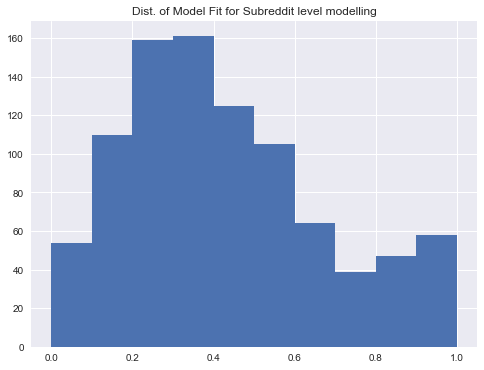

In [396]:
plt.hist(subreddit_model_perf['train_rsq']);
plt.title("Dist. of Model Fit for Subreddit level modelling")

Text(0.5,1,'Dist. of Model Train RMSE for Subreddit level modelling')

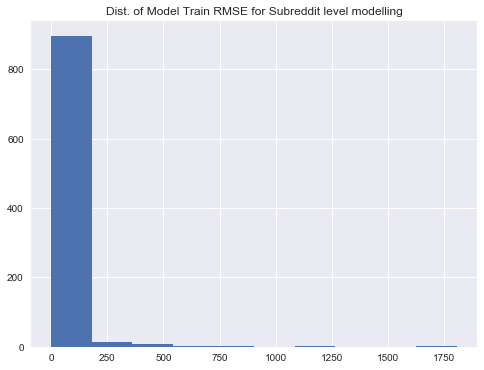

In [397]:
plt.hist(subreddit_model_perf['train_rmse']);
plt.title("Dist. of Model Train RMSE for Subreddit level modelling")

Text(0.5,1,'Dist. of Model Test RMSE for Subreddit level modelling')

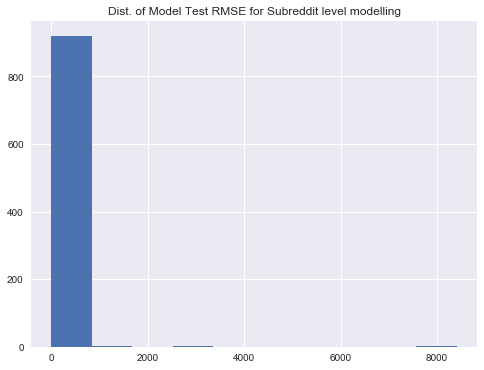

In [398]:
plt.hist(subreddit_model_perf['test_rmse']);
plt.title("Dist. of Model Test RMSE for Subreddit level modelling")

## Subreddit-URL modelling

In [399]:
modelling_data['subreddit_web_key']="subreddit_"+modelling_data['subreddit']+"_web_"+modelling_data['web_source']

keystoremove=modelling_data.groupby(['subreddit_web_key'],as_index=False).agg({'id':'nunique'})
keystoremove=keystoremove[keystoremove['id']<100].subreddit_web_key

In [401]:
modelling_data_filtered=modelling_data[~(modelling_data['subreddit_web_key'].isin(keystoremove))]
model=Lasso()

subreddit_web_model_perf_dict={'subreddit_web':[],'total_submissions':[],
                           'train_rsq':[],'test_rsq':[],'train_rmse':[],'test_rmse':[],
                          'sig_features':[]}

for subreddit_web_key in modelling_data_filtered.subreddit_web_key.unique():
    
    subreddit_dat=modelling_data_filtered[modelling_data_filtered['subreddit_web_key']==subreddit_web_key]
    X=subreddit_dat.loc[:, ~subreddit_dat.columns.isin(['num_comments','subreddit','id','author','web_source','subreddit_web_key'])]
    Y=subreddit_dat[['num_comments']]
    
    #day_dummies_dat = pd.get_dummies(X['created_day']).rename(columns=lambda x: 'Day_' + str(x))
    #hour_dummies_dat = pd.get_dummies(X['created_hour']).rename(columns=lambda x: 'Hour_' + str(x))
    
    #X.drop(['created_day','created_hour'],inplace=True,axis=1)
    
    #X=pd.concat([X,day_dummies_dat,hour_dummies_dat], axis=1)
    X.fillna(0,inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=400)
    
    model.fit(X_train,y_train)
    train_score=model.score(X_train,y_train)
    test_score=model.score(X_test,y_test)
    y_test_pred=model.predict(X_test)
    y_train_pred=model.predict(X_train)
    train_rmse=np.sqrt(np.mean(np.power((y_train.unstack()-y_train_pred),2)))
    test_rmse=np.sqrt(np.mean(np.power((y_test.unstack()-y_test_pred),2)))
    total_submission=subreddit_dat.shape[0]
    sig_feat=','.join(list(X.columns[model.coef_!=0]))
    
    #Adding all metrics to global Perf. Dict
    
    subreddit_web_model_perf_dict['subreddit_web'].append(subreddit_web_key)
    subreddit_web_model_perf_dict['total_submissions'].append(total_submission)
    
    subreddit_web_model_perf_dict['train_rsq'].append(train_score)
    subreddit_web_model_perf_dict['test_rsq'].append(test_score)
    
    subreddit_web_model_perf_dict['train_rmse'].append(train_rmse)
    subreddit_web_model_perf_dict['test_rmse'].append(test_rmse)
    
    subreddit_web_model_perf_dict['sig_features'].append(sig_feat)
    
    print("Subreddit-Web: "+str(subreddit_web_key)+" | "+"Total Sub: "+str(total_submission)+" | "+"Avg. Comments Train: "+str(np.mean(y_train['num_comments']))+" | "+"Avg. Comments Test: "+str(np.mean(y_test['num_comments']))+" | "+"Train R-Sq: "+str(train_score)+" | "+"Test R-Sq: "+str(test_score))

C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DestinyTheGame_web_reddit.com | Total Sub: 8475 | Avg. Comments Train: 26.257585974376266 | Avg. Comments Test: 27.23358238301219 | Train R-Sq: 0.4721028898069085 | Test R-Sq: 0.2579347365841125


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Fireteams_web_reddit.com | Total Sub: 23324 | Avg. Comments Train: 2.3542815141492097 | Avg. Comments Test: 2.3068019434124034 | Train R-Sq: 0.47131530897095497 | Test R-Sq: -0.0017850177424705294


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Showerthoughts_web_reddit.com | Total Sub: 22374 | Avg. Comments Train: 11.954792158865972 | Avg. Comments Test: 11.886042008044093 | Train R-Sq: 0.8584014810018651 | Test R-Sq: 0.802044180584047


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AskReddit_web_reddit.com | Total Sub: 150050 | Avg. Comments Train: 26.001932689103633 | Avg. Comments Test: 28.34106408974786 | Train R-Sq: 0.7086443522760157 | Test R-Sq: 0.6962397106129161


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Pets_web_reddit.com | Total Sub: 421 | Avg. Comments Train: 7.591836734693878 | Avg. Comments Test: 6.354330708661418 | Train R-Sq: 0.28775982486132323 | Test R-Sq: 0.21320135135826723


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Overwatch_web_reddit.com | Total Sub: 23419 | Avg. Comments Train: 15.19447325077777 | Avg. Comments Test: 14.677341303729007 | Train R-Sq: 0.24102690087641088 | Test R-Sq: 0.4025164085125041


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Overwatch_web_twitter.com | Total Sub: 144 | Avg. Comments Train: 33.12 | Avg. Comments Test: 65.3409090909091 | Train R-Sq: 0.547350710881493 | Test R-Sq: 0.9186344122455364


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DestinySherpa_web_reddit.com | Total Sub: 777 | Avg. Comments Train: 5.948434622467771 | Avg. Comments Test: 6.619658119658119 | Train R-Sq: 0.29828614630952155 | Test R-Sq: 0.247402441878106


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_xboxone_web_reddit.com | Total Sub: 5358 | Avg. Comments Train: 15.326933333333333 | Avg. Comments Test: 13.385572139303482 | Train R-Sq: 0.3339634380456423 | Test R-Sq: 0.1838475268319416


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_heroesofthestorm_web_reddit.com | Total Sub: 4870 | Avg. Comments Train: 18.79231446171898 | Avg. Comments Test: 19.51403148528405 | Train R-Sq: 0.4071522614208589 | Test R-Sq: 0.41286994005438754


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_The_Donald_web_reddit.com | Total Sub: 56369 | Avg. Comments Train: 10.743727507729737 | Avg. Comments Test: 10.333274200224706 | Train R-Sq: 0.2794017557332482 | Test R-Sq: 0.17352061985097333


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_The_Donald_web_twitter.com | Total Sub: 7479 | Avg. Comments Train: 21.31957975167144 | Avg. Comments Test: 20.10516934046346 | Train R-Sq: 0.581479501303416 | Test R-Sq: 0.6494080366305514


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_The_Donald_web_wikipedia.org | Total Sub: 256 | Avg. Comments Train: 6.653631284916201 | Avg. Comments Test: 4.662337662337662 | Train R-Sq: 0.730238411815749 | Test R-Sq: -0.7616103788483579


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_The_Donald_web_theguardian.com | Total Sub: 161 | Avg. Comments Train: 11.8125 | Avg. Comments Test: 7.244897959183674 | Train R-Sq: 0.7526710341761466 | Test R-Sq: 0.8439897347846503


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_The_Donald_web_facebook.com | Total Sub: 543 | Avg. Comments Train: 15.563157894736841 | Avg. Comments Test: 22.355828220858896 | Train R-Sq: 0.7693813731268587 | Test R-Sq: 0.5275767410822736


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_The_Donald_web_nytimes.com | Total Sub: 342 | Avg. Comments Train: 8.589958158995817 | Avg. Comments Test: 13.669902912621358 | Train R-Sq: 0.6807032908147698 | Test R-Sq: 0.46333735419723454


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_The_Donald_web_cnn.com | Total Sub: 276 | Avg. Comments Train: 1.1554404145077721 | Avg. Comments Test: 1.1566265060240963 | Train R-Sq: 0.21487877548662204 | Test R-Sq: 0.0039910120760298096


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_The_Donald_web_washingtonpost.com | Total Sub: 232 | Avg. Comments Train: 1.154320987654321 | Avg. Comments Test: 1.2714285714285714 | Train R-Sq: 0.00018886971644604955 | Test R-Sq: -0.014864690870123987


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_The_Donald_web_wordpress.com | Total Sub: 174 | Avg. Comments Train: 13.008264462809917 | Avg. Comments Test: 3.0 | Train R-Sq: 0.9486304946546903 | Test R-Sq: -2.0414075993208445


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Metalcore_web_reddit.com | Total Sub: 321 | Avg. Comments Train: 24.066964285714285 | Avg. Comments Test: 19.90721649484536 | Train R-Sq: 0.3907165615139191 | Test R-Sq: -0.45178596333531656


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_OutOfTheLoop_web_reddit.com | Total Sub: 2315 | Avg. Comments Train: 14.35679012345679 | Avg. Comments Test: 7.781294964028777 | Train R-Sq: 0.6747812196863996 | Test R-Sq: 0.7662874867696396


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_yugioh_web_reddit.com | Total Sub: 1617 | Avg. Comments Train: 21.246684350132625 | Avg. Comments Test: 22.522633744855966 | Train R-Sq: 0.3170396750271094 | Test R-Sq: 0.2947978046674561


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ireland_web_reddit.com | Total Sub: 644 | Avg. Comments Train: 27.04888888888889 | Avg. Comments Test: 23.077319587628867 | Train R-Sq: 0.24342474819227977 | Test R-Sq: 0.1176213701922878


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_pokemontrades_web_reddit.com | Total Sub: 16122 | Avg. Comments Train: 13.614355338945503 | Avg. Comments Test: 13.393425677072566 | Train R-Sq: 0.28879932136262265 | Test R-Sq: 0.1699412804937741


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Parenting_web_reddit.com | Total Sub: 972 | Avg. Comments Train: 23.272058823529413 | Avg. Comments Test: 21.695205479452056 | Train R-Sq: 0.36411624813256094 | Test R-Sq: 0.36264926847260975


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dirtykikpals_web_reddit.com | Total Sub: 3375 | Avg. Comments Train: 1.7091447925486876 | Avg. Comments Test: 1.6742349457058243 | Train R-Sq: 0.1026649355783511 | Test R-Sq: 0.010666845185223428


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RocketLeagueExchange_web_reddit.com | Total Sub: 106581 | Avg. Comments Train: 5.614039085328257 | Avg. Comments Test: 5.876465989053949 | Train R-Sq: 0.11510254989472657 | Test R-Sq: 0.09818423083945249


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_actuallesbians_web_reddit.com | Total Sub: 904 | Avg. Comments Train: 16.647151898734176 | Avg. Comments Test: 14.1875 | Train R-Sq: 0.3834114944521124 | Test R-Sq: 0.04034209404808564


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GlobalOffensiveTrade_web_reddit.com | Total Sub: 33499 | Avg. Comments Train: 3.058723186489829 | Avg. Comments Test: 2.979004975124378 | Train R-Sq: 0.27614392791556236 | Test R-Sq: 0.261998420534997


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_2007scape_web_reddit.com | Total Sub: 4968 | Avg. Comments Train: 9.970664365832615 | Avg. Comments Test: 9.974513749161636 | Train R-Sq: 0.40201995976682214 | Test R-Sq: 0.3514820695725933


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_discordapp_web_reddit.com | Total Sub: 805 | Avg. Comments Train: 3.689165186500888 | Avg. Comments Test: 3.772727272727273 | Train R-Sq: 0.22265400492395981 | Test R-Sq: 0.12671557647094445


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_spam_web_reddit.com | Total Sub: 8209 | Avg. Comments Train: 1.0262791507135398 | Avg. Comments Test: 1.0332927324401138 | Train R-Sq: 0.00021810796415466793 | Test R-Sq: -0.0002709090025276861


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_osugame_web_reddit.com | Total Sub: 972 | Avg. Comments Train: 11.669117647058824 | Avg. Comments Test: 14.452054794520548 | Train R-Sq: 0.5558125997294834 | Test R-Sq: 0.2703255720023736


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gaypornhunters_web_reddit.com | Total Sub: 708 | Avg. Comments Train: 2.1353535353535356 | Avg. Comments Test: 2.2018779342723005 | Train R-Sq: 0.23853898044742894 | Test R-Sq: 0.19326080505444587


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nfl_web_reddit.com | Total Sub: 2385 | Avg. Comments Train: 251.07849011384062 | Avg. Comments Test: 246.40083798882682 | Train R-Sq: 0.18451948141587826 | Test R-Sq: 0.16806244695102268


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nfl_web_twitter.com | Total Sub: 957 | Avg. Comments Train: 114.70702541106128 | Avg. Comments Test: 101.67708333333333 | Train R-Sq: 0.5980098323643093 | Test R-Sq: 0.513337968398014


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_pokemon_web_reddit.com | Total Sub: 14216 | Avg. Comments Train: 22.335041704351323 | Avg. Comments Test: 19.374208675263773 | Train R-Sq: 0.22953468561965973 | Test R-Sq: -0.12563308740041967


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_witcher_web_reddit.com | Total Sub: 1200 | Avg. Comments Train: 8.348809523809523 | Avg. Comments Test: 8.397222222222222 | Train R-Sq: 0.31793380155115514 | Test R-Sq: -6.215421031035658


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_askscience_web_reddit.com | Total Sub: 6090 | Avg. Comments Train: 5.48956134177809 | Avg. Comments Test: 8.661740558292282 | Train R-Sq: 0.7862568621970979 | Test R-Sq: 0.8544779807088877


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_cheatatmathhomework_web_reddit.com | Total Sub: 1358 | Avg. Comments Train: 3.411578947368421 | Avg. Comments Test: 3.4387254901960786 | Train R-Sq: 0.002154484742554197 | Test R-Sq: 0.01012591697506604


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Games_web_reddit.com | Total Sub: 869 | Avg. Comments Train: 37.28453947368421 | Avg. Comments Test: 45.55555555555556 | Train R-Sq: 0.7001032845094404 | Test R-Sq: 0.5766134214460772


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_explainlikeimfive_web_reddit.com | Total Sub: 10845 | Avg. Comments Train: 9.66236332499012 | Avg. Comments Test: 11.28057775046097 | Train R-Sq: 0.7525787019797757 | Test R-Sq: 0.6597175796863124


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Fitness_web_reddit.com | Total Sub: 5925 | Avg. Comments Train: 18.84735953701471 | Avg. Comments Test: 17.604049493813275 | Train R-Sq: 0.3594585208709822 | Test R-Sq: 0.4769677465960396


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_worldpowers_web_reddit.com | Total Sub: 2631 | Avg. Comments Train: 8.27485062466051 | Avg. Comments Test: 7.286075949367088 | Train R-Sq: 0.048921530347580726 | Test R-Sq: -0.008617538142420056


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AppNana_web_reddit.com | Total Sub: 584 | Avg. Comments Train: 1.232843137254902 | Avg. Comments Test: 1.2443181818181819 | Train R-Sq: 0.006216038844653382 | Test R-Sq: -0.012619054678089103


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_applehelp_web_reddit.com | Total Sub: 1341 | Avg. Comments Train: 4.337953091684435 | Avg. Comments Test: 4.255583126550868 | Train R-Sq: 0.11646116707092657 | Test R-Sq: 0.06748473168587599


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dirtypenpals_web_reddit.com | Total Sub: 1279 | Avg. Comments Train: 2.9675977653631285 | Avg. Comments Test: 2.90625 | Train R-Sq: 0.28140067237302846 | Test R-Sq: 0.15127945056393355


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_titanfall_web_reddit.com | Total Sub: 7369 | Avg. Comments Train: 13.528111671190384 | Avg. Comments Test: 12.071460877431027 | Train R-Sq: 0.3768517953806729 | Test R-Sq: -3.242392853772146


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Kappa_web_reddit.com | Total Sub: 593 | Avg. Comments Train: 12.506024096385541 | Avg. Comments Test: 10.758426966292134 | Train R-Sq: 0.4623971321329493 | Test R-Sq: 0.4552784624597701


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Kappa_web_twitter.com | Total Sub: 205 | Avg. Comments Train: 18.993006993006993 | Avg. Comments Test: 15.0 | Train R-Sq: 0.47724220967749353 | Test R-Sq: -0.05611624929403102


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AgeplayPenPals_web_reddit.com | Total Sub: 393 | Avg. Comments Train: 1.4 | Avg. Comments Test: 1.271186440677966 | Train R-Sq: 0.034097166911427834 | Test R-Sq: 0.051257366503732145


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_skyrim_web_reddit.com | Total Sub: 6620 | Avg. Comments Train: 8.60164005179111 | Avg. Comments Test: 9.295065458207452 | Train R-Sq: 0.3363993109595197 | Test R-Sq: 0.16090943136352354


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_wowguilds_web_reddit.com | Total Sub: 792 | Avg. Comments Train: 2.6588447653429603 | Avg. Comments Test: 2.563025210084034 | Train R-Sq: 0.052354555621058396 | Test R-Sq: 0.0468604417552928


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_breakingmom_web_reddit.com | Total Sub: 1363 | Avg. Comments Train: 14.452830188679245 | Avg. Comments Test: 13.54523227383863 | Train R-Sq: 0.2402219716432511 | Test R-Sq: 0.1736799456533007


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AskHistorians_web_reddit.com | Total Sub: 2299 | Avg. Comments Train: 6.003729024238657 | Avg. Comments Test: 6.633333333333334 | Train R-Sq: 0.7624211917279826 | Test R-Sq: 0.6013752864743767


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FUTMobile_web_reddit.com | Total Sub: 2284 | Avg. Comments Train: 6.934918648310388 | Avg. Comments Test: 7.208454810495627 | Train R-Sq: 0.13542958139409766 | Test R-Sq: 0.04177669380876381


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_relationships_web_reddit.com | Total Sub: 9933 | Avg. Comments Train: 18.933410038832157 | Avg. Comments Test: 16.960738255033558 | Train R-Sq: 0.4672875976617417 | Test R-Sq: 0.4992825931734136


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Undertale_web_reddit.com | Total Sub: 426 | Avg. Comments Train: 7.936241610738255 | Avg. Comments Test: 9.3828125 | Train R-Sq: 0.5034019642911475 | Test R-Sq: 0.2285596732328189


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Undertale_web_twitter.com | Total Sub: 154 | Avg. Comments Train: 6.4953271028037385 | Avg. Comments Test: 7.957446808510638 | Train R-Sq: 0.6107338502921784 | Test R-Sq: -0.3558653816366675


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gtaonline_web_reddit.com | Total Sub: 1251 | Avg. Comments Train: 16.488 | Avg. Comments Test: 15.444148936170214 | Train R-Sq: 0.5859581242754267 | Test R-Sq: 0.3539042156850224


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Guildwars2_web_reddit.com | Total Sub: 2216 | Avg. Comments Train: 25.96260477111541 | Avg. Comments Test: 24.330827067669173 | Train R-Sq: 0.48288959109425994 | Test R-Sq: 0.338598663387906


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CasualPokemonTrades_web_reddit.com | Total Sub: 2488 | Avg. Comments Train: 10.487650775416427 | Avg. Comments Test: 10.423025435073628 | Train R-Sq: 0.5918433162045937 | Test R-Sq: 0.6181520224386348


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_pokemongo_web_reddit.com | Total Sub: 7489 | Avg. Comments Train: 15.024036627241511 | Avg. Comments Test: 15.167779261237206 | Train R-Sq: 0.4662096468602385 | Test R-Sq: 0.6233417939375104


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_guns_web_reddit.com | Total Sub: 1648 | Avg. Comments Train: 25.357328707718995 | Avg. Comments Test: 25.953535353535354 | Train R-Sq: 0.5381679565355395 | Test R-Sq: 0.2904927718916619


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MDMA_web_reddit.com | Total Sub: 633 | Avg. Comments Train: 8.733634311512416 | Avg. Comments Test: 9.273684210526316 | Train R-Sq: 0.3083439650096945 | Test R-Sq: -0.044774369682741844


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_confession_web_reddit.com | Total Sub: 762 | Avg. Comments Train: 15.151969981238274 | Avg. Comments Test: 17.305676855895197 | Train R-Sq: 0.5102515619612662 | Test R-Sq: 0.5245724935352076


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_battlefield_one_web_reddit.com | Total Sub: 9746 | Avg. Comments Train: 10.710788625036646 | Avg. Comments Test: 9.96203830369357 | Train R-Sq: 0.25198156619603673 | Test R-Sq: 0.777739992112045


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_mentalhealth_web_reddit.com | Total Sub: 459 | Avg. Comments Train: 4.249221183800623 | Avg. Comments Test: 4.3478260869565215 | Train R-Sq: 0.15878992308082318 | Test R-Sq: 0.17259676919596878


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_legaladvice_web_reddit.com | Total Sub: 6312 | Avg. Comments Train: 11.638750565866909 | Avg. Comments Test: 11.162618796198522 | Train R-Sq: 0.5215862027237451 | Test R-Sq: -0.14649092344503956


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_leagueoflegends_web_reddit.com | Total Sub: 24149 | Avg. Comments Train: 19.206814955040226 | Avg. Comments Test: 21.119254658385092 | Train R-Sq: 0.5767299982835958 | Test R-Sq: 0.4603077707503327


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_leagueoflegends_web_twitter.com | Total Sub: 131 | Avg. Comments Train: 1.1318681318681318 | Avg. Comments Test: 1.1 | Train R-Sq: 0.011538294127857118 | Test R-Sq: 0.08296704851505987


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_HomeworkHelp_web_reddit.com | Total Sub: 1053 | Avg. Comments Train: 3.354138398914518 | Avg. Comments Test: 3.2278481012658227 | Train R-Sq: 0.0016389149215161325 | Test R-Sq: -0.006437609204465566


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Roleplaykik_web_reddit.com | Total Sub: 1076 | Avg. Comments Train: 2.5630810092961487 | Avg. Comments Test: 2.8142414860681115 | Train R-Sq: 0.012314756595111609 | Test R-Sq: -0.0144232619927962


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_personalfinance_web_reddit.com | Total Sub: 8014 | Avg. Comments Train: 13.6407559279729 | Avg. Comments Test: 13.673180873180874 | Train R-Sq: 0.660021899961915 | Test R-Sq: 0.5915268166165548


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_conspiracy_web_reddit.com | Total Sub: 3790 | Avg. Comments Train: 20.069732378439504 | Avg. Comments Test: 17.4221635883905 | Train R-Sq: 0.7175162649421521 | Test R-Sq: 0.5542291460721167


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_conspiracy_web_twitter.com | Total Sub: 200 | Avg. Comments Train: 27.542857142857144 | Avg. Comments Test: 16.95 | Train R-Sq: 0.5043991204785897 | Test R-Sq: 0.5001858369422714


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_drunkenpeasants_web_reddit.com | Total Sub: 781 | Avg. Comments Train: 8.137362637362637 | Avg. Comments Test: 10.05531914893617 | Train R-Sq: 0.35172811224945855 | Test R-Sq: 0.3890155095802178


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_writing_web_reddit.com | Total Sub: 1328 | Avg. Comments Train: 13.439181916038752 | Avg. Comments Test: 13.491228070175438 | Train R-Sq: 0.35763639458875296 | Test R-Sq: 0.1826929423719298


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CrazyIdeas_web_reddit.com | Total Sub: 840 | Avg. Comments Train: 9.134353741496598 | Avg. Comments Test: 8.30952380952381 | Train R-Sq: 0.7333997030902276 | Test R-Sq: 0.2321257781195022


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nba_web_reddit.com | Total Sub: 2497 | Avg. Comments Train: 128.01373783629077 | Avg. Comments Test: 152.87333333333333 | Train R-Sq: 0.3549348497753264 | Test R-Sq: 0.11783503726070532


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nba_web_twitter.com | Total Sub: 842 | Avg. Comments Train: 70.68251273344652 | Avg. Comments Test: 79.83794466403162 | Train R-Sq: 0.5892259187571084 | Test R-Sq: 0.5583083527115098


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MLS_web_reddit.com | Total Sub: 203 | Avg. Comments Train: 149.03521126760563 | Avg. Comments Test: 108.49180327868852 | Train R-Sq: 0.6977105669553763 | Test R-Sq: -0.18167266035655216


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MLS_web_twitter.com | Total Sub: 207 | Avg. Comments Train: 46.31944444444444 | Avg. Comments Test: 65.28571428571429 | Train R-Sq: 0.3785309064579485 | Test R-Sq: 0.7235945656169296


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_westworld_web_reddit.com | Total Sub: 8016 | Avg. Comments Train: 24.984672963821065 | Avg. Comments Test: 16.393762993762994 | Train R-Sq: 0.4376953395228994 | Test R-Sq: -0.02337416949866244


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Nexus6P_web_reddit.com | Total Sub: 972 | Avg. Comments Train: 10.891176470588235 | Avg. Comments Test: 13.636986301369863 | Train R-Sq: 0.459288354106526 | Test R-Sq: 0.3541971775042462


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_politics_web_nytimes.com | Total Sub: 1323 | Avg. Comments Train: 18.057235421166308 | Avg. Comments Test: 39.88413098236776 | Train R-Sq: 0.631264283100216 | Test R-Sq: 0.48943369501312345


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_politics_web_cnn.com | Total Sub: 1105 | Avg. Comments Train: 81.39456662354463 | Avg. Comments Test: 48.855421686746986 | Train R-Sq: 0.8225625195850945 | Test R-Sq: 0.8750521021558209


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_politics_web_washingtonpost.com | Total Sub: 1429 | Avg. Comments Train: 120.218 | Avg. Comments Test: 101.13986013986013 | Train R-Sq: 0.8019356927836947 | Test R-Sq: 0.7311625979259282


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_politics_web_huffingtonpost.com | Total Sub: 730 | Avg. Comments Train: 113.86105675146771 | Avg. Comments Test: 139.45205479452054 | Train R-Sq: 0.7616023924460514 | Test R-Sq: 0.8202220458124156


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_politics_web_theguardian.com | Total Sub: 565 | Avg. Comments Train: 119.27594936708861 | Avg. Comments Test: 48.82941176470588 | Train R-Sq: 0.6457158935728953 | Test R-Sq: 0.5865693776899228


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_politics_web_reddit.com | Total Sub: 214 | Avg. Comments Train: 1166.2080536912752 | Avg. Comments Test: 1084.446153846154 | Train R-Sq: 0.6518838007509691 | Test R-Sq: 0.31854850879906527


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_politics_web_twitter.com | Total Sub: 255 | Avg. Comments Train: 1.1123595505617978 | Avg. Comments Test: 1.0909090909090908 | Train R-Sq: 0.010863132696099731 | Test R-Sq: -0.01768723798899252


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dating_advice_web_reddit.com | Total Sub: 1592 | Avg. Comments Train: 5.880610412926392 | Avg. Comments Test: 5.822175732217573 | Train R-Sq: 0.2974012496355247 | Test R-Sq: 0.2779304407499258


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PSVR_web_reddit.com | Total Sub: 2959 | Avg. Comments Train: 16.174311926605505 | Avg. Comments Test: 16.541666666666668 | Train R-Sq: 0.32756216266797045 | Test R-Sq: 0.27310642121607664


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_tipofmypenis_web_reddit.com | Total Sub: 2188 | Avg. Comments Train: 2.257348138471587 | Avg. Comments Test: 2.08675799086758 | Train R-Sq: 0.5757926071284871 | Test R-Sq: 0.35836924278799975


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_elderscrollsonline_web_reddit.com | Total Sub: 3709 | Avg. Comments Train: 10.00693374422188 | Avg. Comments Test: 10.065588499550763 | Train R-Sq: 0.39468065880157277 | Test R-Sq: 0.3069015800246949


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GlobalOffensive_web_twitter.com | Total Sub: 260 | Avg. Comments Train: 56.104395604395606 | Avg. Comments Test: 93.02564102564102 | Train R-Sq: 0.5691530498628922 | Test R-Sq: 0.32636694575787284


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GlobalOffensive_web_reddit.com | Total Sub: 7522 | Avg. Comments Train: 16.758024691358024 | Avg. Comments Test: 17.134249003101463 | Train R-Sq: 0.5709640176887949 | Test R-Sq: 0.6568959512568741


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_TheRedPill_web_reddit.com | Total Sub: 731 | Avg. Comments Train: 46.154598825831705 | Avg. Comments Test: 46.872727272727275 | Train R-Sq: 0.5447115812954 | Test R-Sq: 0.7291198673761706


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hardwareswap_web_reddit.com | Total Sub: 5198 | Avg. Comments Train: 6.608301264431006 | Avg. Comments Test: 6.791666666666667 | Train R-Sq: 0.3072649323425509 | Test R-Sq: 0.22681815823684134


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GooglePixel_web_reddit.com | Total Sub: 3286 | Avg. Comments Train: 14.29304347826087 | Avg. Comments Test: 12.786004056795132 | Train R-Sq: 0.11632660254031879 | Test R-Sq: 0.21792648892279307


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_cscareerquestions_web_reddit.com | Total Sub: 2284 | Avg. Comments Train: 11.981852315394242 | Avg. Comments Test: 12.272594752186588 | Train R-Sq: 0.635704468176943 | Test R-Sq: 0.4792990925269932


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_buildapc_web_reddit.com | Total Sub: 19179 | Avg. Comments Train: 7.7731098696461824 | Avg. Comments Test: 7.531803962460897 | Train R-Sq: 0.7965021916830471 | Test R-Sq: 0.8225397229676896


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_offmychest_web_reddit.com | Total Sub: 2258 | Avg. Comments Train: 6.133544303797469 | Avg. Comments Test: 6.140117994100295 | Train R-Sq: 0.5009167363382532 | Test R-Sq: 0.2462040127753179


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_pcmasterrace_web_reddit.com | Total Sub: 12787 | Avg. Comments Train: 13.99877094972067 | Avg. Comments Test: 14.27547563200417 | Train R-Sq: 0.4202025532411484 | Test R-Sq: -4.293626239929263


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_bestof_web_reddit.com | Total Sub: 785 | Avg. Comments Train: 43.61566484517304 | Avg. Comments Test: 68.3177966101695 | Train R-Sq: 0.4647537424294437 | Test R-Sq: 0.6047452313957491


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_photography_web_reddit.com | Total Sub: 1315 | Avg. Comments Train: 22.803260869565218 | Avg. Comments Test: 19.043037974683543 | Train R-Sq: 0.40385090382511113 | Test R-Sq: 0.19218493881712118


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_wow_web_reddit.com | Total Sub: 8215 | Avg. Comments Train: 22.89686956521739 | Avg. Comments Test: 23.034888438133873 | Train R-Sq: 0.40339855657763524 | Test R-Sq: 0.46706562911297106


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_beertrade_web_reddit.com | Total Sub: 1620 | Avg. Comments Train: 4.617283950617284 | Avg. Comments Test: 5.6419753086419755 | Train R-Sq: 0.05989132881950854 | Test R-Sq: 0.04627480913378845


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_thedivision_web_reddit.com | Total Sub: 6340 | Avg. Comments Train: 15.6403785488959 | Avg. Comments Test: 17.072029442691903 | Train R-Sq: 0.44771580314398685 | Test R-Sq: 0.4189331297432446


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_streetwear_web_reddit.com | Total Sub: 2857 | Avg. Comments Train: 13.834417208604302 | Avg. Comments Test: 15.444055944055943 | Train R-Sq: 0.5307450807386271 | Test R-Sq: 0.5192950986138427


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_TeamRedditTeams_web_reddit.com | Total Sub: 828 | Avg. Comments Train: 2.302245250431779 | Avg. Comments Test: 2.285140562248996 | Train R-Sq: 0.06302480813889444 | Test R-Sq: 0.04328628988379357


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CasualConversation_web_reddit.com | Total Sub: 2171 | Avg. Comments Train: 34.50691244239631 | Avg. Comments Test: 30.75 | Train R-Sq: 0.21634400858248481 | Test R-Sq: 0.26779059062866517


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_tipofmytongue_web_reddit.com | Total Sub: 6282 | Avg. Comments Train: 4.119854446213327 | Avg. Comments Test: 4.26684350132626 | Train R-Sq: 0.25935031364232697 | Test R-Sq: 0.36536576377916447


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_sex_web_reddit.com | Total Sub: 4283 | Avg. Comments Train: 11.444296197464977 | Avg. Comments Test: 13.38910505836576 | Train R-Sq: 0.38748270617689007 | Test R-Sq: 0.3783512113873173


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_r4r_web_reddit.com | Total Sub: 1383 | Avg. Comments Train: 2.9266528925619837 | Avg. Comments Test: 3.4168674698795183 | Train R-Sq: 0.23105778117437983 | Test R-Sq: 0.22009891251383873


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Kikpals_web_reddit.com | Total Sub: 949 | Avg. Comments Train: 1.5948795180722892 | Avg. Comments Test: 1.743859649122807 | Train R-Sq: 0.11251906447691218 | Test R-Sq: 0.15487611644485577


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MensRights_web_reddit.com | Total Sub: 272 | Avg. Comments Train: 16.057894736842105 | Avg. Comments Test: 16.21951219512195 | Train R-Sq: 0.4102617159745986 | Test R-Sq: 0.10067679340169033


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Infinitewarfare_web_reddit.com | Total Sub: 7647 | Avg. Comments Train: 9.793535127055307 | Avg. Comments Test: 10.567320261437908 | Train R-Sq: 0.4463345379694491 | Test R-Sq: 0.5215611586930238


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NoStupidQuestions_web_reddit.com | Total Sub: 6715 | Avg. Comments Train: 7.499787234042553 | Avg. Comments Test: 6.9851116625310175 | Train R-Sq: 0.5086224854496479 | Test R-Sq: 0.43307774257300646


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_borrow_web_reddit.com | Total Sub: 1438 | Avg. Comments Train: 4.224652087475149 | Avg. Comments Test: 3.9050925925925926 | Train R-Sq: 0.1686079083301414 | Test R-Sq: 0.1343465647765686


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_unitedkingdom_web_reddit.com | Total Sub: 631 | Avg. Comments Train: 62.244897959183675 | Avg. Comments Test: 48.87894736842105 | Train R-Sq: 0.39579401654010443 | Test R-Sq: 0.39148738328241783


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_unitedkingdom_web_theguardian.com | Total Sub: 291 | Avg. Comments Train: 62.152709359605915 | Avg. Comments Test: 46.56818181818182 | Train R-Sq: 0.6251352439032047 | Test R-Sq: 0.32241458671975687


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Rainbow6_web_reddit.com | Total Sub: 7485 | Avg. Comments Train: 9.520519183050201 | Avg. Comments Test: 10.376224398931434 | Train R-Sq: 0.32871428088098276 | Test R-Sq: 0.21838213301565446


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_comicbooks_web_reddit.com | Total Sub: 868 | Avg. Comments Train: 20.133443163097198 | Avg. Comments Test: 19.21072796934866 | Train R-Sq: 0.290311724191083 | Test R-Sq: 0.13620393700841005


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_darksouls_web_reddit.com | Total Sub: 1063 | Avg. Comments Train: 15.021505376344086 | Avg. Comments Test: 13.871473354231975 | Train R-Sq: 0.341159418089797 | Test R-Sq: 0.37818559843002564


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_trees_web_reddit.com | Total Sub: 7035 | Avg. Comments Train: 8.602965069049553 | Avg. Comments Test: 8.504026527711984 | Train R-Sq: 0.7626877239604878 | Test R-Sq: 0.6263823330460889


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NBA2k_web_reddit.com | Total Sub: 3535 | Avg. Comments Train: 7.727566693613581 | Avg. Comments Test: 7.623939679547597 | Train R-Sq: 0.19865282267874262 | Test R-Sq: 0.28821982923556666


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CFB_web_reddit.com | Total Sub: 3202 | Avg. Comments Train: 199.88085676037483 | Avg. Comments Test: 201.86680541103019 | Train R-Sq: 0.17627337012791156 | Test R-Sq: 0.17322685909032864


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CFB_web_twitter.com | Total Sub: 123 | Avg. Comments Train: 2.4767441860465116 | Avg. Comments Test: 1.0810810810810811 | Train R-Sq: 0.9995429221213888 | Test R-Sq: -0.15828709334705082


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_HITsWorthTurkingFor_web_reddit.com | Total Sub: 1175 | Avg. Comments Train: 4.088807785888078 | Avg. Comments Test: 4.257790368271955 | Train R-Sq: 0.30011312911146193 | Test R-Sq: 0.30612111661705443


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SuicideWatch_web_reddit.com | Total Sub: 1643 | Avg. Comments Train: 5.739130434782608 | Avg. Comments Test: 5.448275862068965 | Train R-Sq: 0.23299898754995396 | Test R-Sq: 0.14643425661564946


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_youtube_web_reddit.com | Total Sub: 1235 | Avg. Comments Train: 4.09375 | Avg. Comments Test: 3.973045822102426 | Train R-Sq: 0.23175870704049806 | Test R-Sq: 0.19946888805637453


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WritingPrompts_web_reddit.com | Total Sub: 9886 | Avg. Comments Train: 4.458815028901734 | Avg. Comments Test: 4.943695212407283 | Train R-Sq: 0.8662719212712259 | Test R-Sq: 0.7760113917061293


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FIFA_web_reddit.com | Total Sub: 11296 | Avg. Comments Train: 12.526621980523586 | Avg. Comments Test: 14.678961345529654 | Train R-Sq: 0.40713690524647206 | Test R-Sq: 0.09013277234728467


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_tipofmyjoystick_web_reddit.com | Total Sub: 1037 | Avg. Comments Train: 5.624827586206896 | Avg. Comments Test: 6.096153846153846 | Train R-Sq: 0.11554530189560597 | Test R-Sq: 0.11366207106077253


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Battlefield_web_reddit.com | Total Sub: 2472 | Avg. Comments Train: 11.700578034682081 | Avg. Comments Test: 10.637466307277627 | Train R-Sq: 0.870061685598579 | Test R-Sq: 0.25744887592922516


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_cosplay_web_reddit.com | Total Sub: 165 | Avg. Comments Train: 3.3217391304347825 | Avg. Comments Test: 3.78 | Train R-Sq: 0.2146846706846144 | Test R-Sq: -0.0071705678333244816


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_GetMotivated_web_reddit.com | Total Sub: 348 | Avg. Comments Train: 18.11111111111111 | Avg. Comments Test: 7.219047619047619 | Train R-Sq: 0.5729948761173499 | Test R-Sq: 0.5249670790430321


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_techsupport_web_reddit.com | Total Sub: 6689 | Avg. Comments Train: 5.0166595472020505 | Avg. Comments Test: 5.022919780767315 | Train R-Sq: 0.3835247952315797 | Test R-Sq: 0.387250906810399


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Music_web_reddit.com | Total Sub: 2242 | Avg. Comments Train: 20.236456341618865 | Avg. Comments Test: 12.548291233283804 | Train R-Sq: 0.2888106371723256 | Test R-Sq: 0.15723307641573048


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EnoughTrumpSpam_web_reddit.com | Total Sub: 3230 | Avg. Comments Train: 19.4953560371517 | Avg. Comments Test: 24.391124871001033 | Train R-Sq: 0.7196555399256617 | Test R-Sq: 0.577886429381642


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EnoughTrumpSpam_web_twitter.com | Total Sub: 824 | Avg. Comments Train: 26.239583333333332 | Avg. Comments Test: 17.177419354838708 | Train R-Sq: 0.8955629171884902 | Test R-Sq: 0.7139320880804605


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EnoughTrumpSpam_web_nytimes.com | Total Sub: 227 | Avg. Comments Train: 16.31645569620253 | Avg. Comments Test: 6.36231884057971 | Train R-Sq: 0.9544566161394672 | Test R-Sq: -31.585930602875976


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EnoughTrumpSpam_web_washingtonpost.com | Total Sub: 222 | Avg. Comments Train: 5.683870967741935 | Avg. Comments Test: 26.388059701492537 | Train R-Sq: 0.791227794020043 | Test R-Sq: 0.8825014912501351


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EnoughTrumpSpam_web_theguardian.com | Total Sub: 106 | Avg. Comments Train: 8.91891891891892 | Avg. Comments Test: 10.46875 | Train R-Sq: 0.5994661989016723 | Test R-Sq: 0.16676514993868985


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EnoughTrumpSpam_web_huffingtonpost.com | Total Sub: 103 | Avg. Comments Train: 10.23611111111111 | Avg. Comments Test: 4.645161290322581 | Train R-Sq: 0.7465600015693628 | Test R-Sq: -0.06088360149579053


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EnoughTrumpSpam_web_cnn.com | Total Sub: 148 | Avg. Comments Train: 6.184466019417476 | Avg. Comments Test: 3.422222222222222 | Train R-Sq: 0.7283478236351878 | Test R-Sq: -0.09199132410158128


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hearthstone_web_reddit.com | Total Sub: 9233 | Avg. Comments Train: 20.644128113879002 | Avg. Comments Test: 21.204693140794223 | Train R-Sq: 0.2826446500007428 | Test R-Sq: 0.16766452616296165


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_secretsanta_web_reddit.com | Total Sub: 1111 | Avg. Comments Train: 9.463320463320464 | Avg. Comments Test: 12.754491017964073 | Train R-Sq: 0.30923950004821565 | Test R-Sq: 0.5377372825739097


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_movies_web_reddit.com | Total Sub: 1786 | Avg. Comments Train: 63.964 | Avg. Comments Test: 59.184701492537314 | Train R-Sq: 0.31810465505728236 | Test R-Sq: 0.27321963620407885


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dirtyr4r_web_reddit.com | Total Sub: 418 | Avg. Comments Train: 2.7945205479452055 | Avg. Comments Test: 3.2142857142857144 | Train R-Sq: 0.14616740384458016 | Test R-Sq: 0.18813873333418152


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_edmproduction_web_reddit.com | Total Sub: 1060 | Avg. Comments Train: 13.134770889487871 | Avg. Comments Test: 13.581761006289309 | Train R-Sq: 0.10154273733738339 | Test R-Sq: 0.23723108423725248


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RecruitCS_web_reddit.com | Total Sub: 1555 | Avg. Comments Train: 1.7159926470588236 | Avg. Comments Test: 1.7130620985010707 | Train R-Sq: 0.11697117542264035 | Test R-Sq: 0.08842365767214078


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RandomActsOfMuffDive_web_reddit.com | Total Sub: 1163 | Avg. Comments Train: 1.49017199017199 | Avg. Comments Test: 1.527220630372493 | Train R-Sq: 0.4877458373445974 | Test R-Sq: 0.39531210411021755


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Marvel_web_reddit.com | Total Sub: 622 | Avg. Comments Train: 15.142528735632183 | Avg. Comments Test: 15.251336898395722 | Train R-Sq: 0.5437358712474037 | Test R-Sq: 0.3570798631664809


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Coffee_web_reddit.com | Total Sub: 783 | Avg. Comments Train: 14.224452554744525 | Avg. Comments Test: 13.114893617021277 | Train R-Sq: 0.7894455095716484 | Test R-Sq: 0.40229499316800443


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SeattleWA_web_reddit.com | Total Sub: 415 | Avg. Comments Train: 26.63448275862069 | Avg. Comments Test: 27.36 | Train R-Sq: 0.13983103208789394 | Test R-Sq: 0.15932081373297224


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FlashTV_web_reddit.com | Total Sub: 1147 | Avg. Comments Train: 26.380299251870323 | Avg. Comments Test: 31.28985507246377 | Train R-Sq: 0.16074710151176452 | Test R-Sq: 0.2083431932913955


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Advice_web_reddit.com | Total Sub: 4117 | Avg. Comments Train: 4.907670947587643 | Avg. Comments Test: 5.283980582524272 | Train R-Sq: 0.42956285804269856 | Test R-Sq: 0.6578286251468621


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_skyrimmods_web_reddit.com | Total Sub: 4426 | Avg. Comments Train: 10.569722401549386 | Avg. Comments Test: 11.213102409638553 | Train R-Sq: 0.40518517757887557 | Test R-Sq: 0.10564124610500059


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MechanicalKeyboards_web_reddit.com | Total Sub: 2015 | Avg. Comments Train: 13.532624113475178 | Avg. Comments Test: 15.482644628099173 | Train R-Sq: 0.5385178899475092 | Test R-Sq: -0.45105235878734046


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Smite_web_reddit.com | Total Sub: 5258 | Avg. Comments Train: 18.911684782608695 | Avg. Comments Test: 18.23574144486692 | Train R-Sq: 0.2096110844478295 | Test R-Sq: 0.1929833855698475


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_windowsphone_web_reddit.com | Total Sub: 902 | Avg. Comments Train: 12.015847860538827 | Avg. Comments Test: 12.25830258302583 | Train R-Sq: 0.485421550097018 | Test R-Sq: 0.3644620151073549


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Eve_web_reddit.com | Total Sub: 2301 | Avg. Comments Train: 26.383850931677017 | Avg. Comments Test: 27.82778581765557 | Train R-Sq: 0.23244620385757397 | Test R-Sq: 0.3220236688025768


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_australia_web_reddit.com | Total Sub: 551 | Avg. Comments Train: 26.896103896103895 | Avg. Comments Test: 28.77710843373494 | Train R-Sq: 0.2135564067230058 | Test R-Sq: 0.45141894146541495


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_australia_web_theguardian.com | Total Sub: 137 | Avg. Comments Train: 56.83157894736842 | Avg. Comments Test: 40.95238095238095 | Train R-Sq: 0.3605956351135393 | Test R-Sq: 0.1924060976224592


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_askgaybros_web_reddit.com | Total Sub: 2016 | Avg. Comments Train: 22.378454996456412 | Avg. Comments Test: 19.755371900826447 | Train R-Sq: 0.39742950883467265 | Test R-Sq: 0.4773880495197284


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_shittyaskscience_web_reddit.com | Total Sub: 2158 | Avg. Comments Train: 5.481456953642384 | Avg. Comments Test: 5.907407407407407 | Train R-Sq: 0.9023931002255262 | Test R-Sq: 0.6235802405459174


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_vancouver_web_reddit.com | Total Sub: 699 | Avg. Comments Train: 18.70961145194274 | Avg. Comments Test: 18.457142857142856 | Train R-Sq: 0.37974524270446275 | Test R-Sq: 0.1136137218008081


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_beyondthebump_web_reddit.com | Total Sub: 1560 | Avg. Comments Train: 14.442307692307692 | Avg. Comments Test: 15.463675213675213 | Train R-Sq: 0.22272274712801088 | Test R-Sq: 0.27974527941313576


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_exxxchange_web_reddit.com | Total Sub: 300 | Avg. Comments Train: 1.9333333333333333 | Avg. Comments Test: 1.7666666666666666 | Train R-Sq: 0.3087373456179 | Test R-Sq: -0.6023834004190229


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_paragon_web_reddit.com | Total Sub: 2102 | Avg. Comments Train: 15.563562202583277 | Avg. Comments Test: 14.922345483359747 | Train R-Sq: 0.3810036160633692 | Test R-Sq: 0.2194886790225592


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_TheSilphRoad_web_reddit.com | Total Sub: 3510 | Avg. Comments Train: 26.788359788359788 | Avg. Comments Test: 26.316239316239315 | Train R-Sq: 0.5004178196763742 | Test R-Sq: 0.3914920577433812


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Pokemongiveaway_web_reddit.com | Total Sub: 2726 | Avg. Comments Train: 26.566037735849058 | Avg. Comments Test: 26.68948655256724 | Train R-Sq: 0.6529155508143843 | Test R-Sq: 0.6335555399254919


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_copypasta_web_reddit.com | Total Sub: 1987 | Avg. Comments Train: 2.866906474820144 | Avg. Comments Test: 3.0603015075376883 | Train R-Sq: 0.5371639584449275 | Test R-Sq: 0.5161497244392389


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CallOfDuty_web_reddit.com | Total Sub: 335 | Avg. Comments Train: 16.764957264957264 | Avg. Comments Test: 14.326732673267326 | Train R-Sq: 0.3206313978882972 | Test R-Sq: 0.6177638013739817


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_BleachBraveSouls_web_reddit.com | Total Sub: 1038 | Avg. Comments Train: 17.513774104683197 | Avg. Comments Test: 18.125 | Train R-Sq: 0.23751040092436462 | Test R-Sq: 0.32996543981906756


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PoliticalDiscussion_web_reddit.com | Total Sub: 2699 | Avg. Comments Train: 62.65802011646374 | Avg. Comments Test: 43.91975308641975 | Train R-Sq: 0.39540703310855085 | Test R-Sq: -0.06485791550280351


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_buildapcforme_web_reddit.com | Total Sub: 1347 | Avg. Comments Train: 4.89384288747346 | Avg. Comments Test: 4.676543209876543 | Train R-Sq: 0.1624720794823934 | Test R-Sq: 0.1457968690846666


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hillaryclinton_web_reddit.com | Total Sub: 677 | Avg. Comments Train: 112.43551797040169 | Avg. Comments Test: 133.4558823529412 | Train R-Sq: 0.5995328712986913 | Test R-Sq: 0.5496835106019655


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hillaryclinton_web_twitter.com | Total Sub: 782 | Avg. Comments Train: 21.021937842778794 | Avg. Comments Test: 20.127659574468087 | Train R-Sq: 0.8325461128944351 | Test R-Sq: 0.38058940160445376


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hillaryclinton_web_nytimes.com | Total Sub: 121 | Avg. Comments Train: 6.642857142857143 | Avg. Comments Test: 8.756756756756756 | Train R-Sq: 0.8075728715632914 | Test R-Sq: 0.5848855873598076


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hillaryclinton_web_washingtonpost.com | Total Sub: 113 | Avg. Comments Train: 8.594936708860759 | Avg. Comments Test: 21.970588235294116 | Train R-Sq: 0.425400275538952 | Test R-Sq: 0.749516850740447


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SkincareAddiction_web_reddit.com | Total Sub: 2033 | Avg. Comments Train: 6.476458186929023 | Avg. Comments Test: 5.842622950819672 | Train R-Sq: 0.26347852123843585 | Test R-Sq: 0.28907585135953606


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Jokes_web_reddit.com | Total Sub: 9365 | Avg. Comments Train: 12.82044241037376 | Avg. Comments Test: 11.539857651245551 | Train R-Sq: 0.7208426836599146 | Test R-Sq: 0.6086108743832382


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_math_web_reddit.com | Total Sub: 821 | Avg. Comments Train: 13.205574912891986 | Avg. Comments Test: 13.194331983805668 | Train R-Sq: 0.5652272911071751 | Test R-Sq: -2.0269313505703583


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DnD_web_reddit.com | Total Sub: 4613 | Avg. Comments Train: 15.506348714772376 | Avg. Comments Test: 14.701589595375722 | Train R-Sq: 0.21644313656079398 | Test R-Sq: 0.32846510924406636


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SwagBucks_web_reddit.com | Total Sub: 898 | Avg. Comments Train: 8.939490445859873 | Avg. Comments Test: 8.496296296296297 | Train R-Sq: 0.17886426935478042 | Test R-Sq: 0.27698968552131875


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RocketLeague_web_reddit.com | Total Sub: 3449 | Avg. Comments Train: 9.742336371168186 | Avg. Comments Test: 13.815458937198068 | Train R-Sq: 0.49456346305358745 | Test R-Sq: 0.03999820164382428


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_friendsafari_web_reddit.com | Total Sub: 5636 | Avg. Comments Train: 10.66108998732573 | Avg. Comments Test: 10.740390301596689 | Train R-Sq: 0.1717680816942423 | Test R-Sq: 0.23430466729686006


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Planetside_web_reddit.com | Total Sub: 872 | Avg. Comments Train: 20.965573770491805 | Avg. Comments Test: 20.38167938931298 | Train R-Sq: 0.3274365395961327 | Test R-Sq: 0.35009901845270563


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_roosterteeth_web_reddit.com | Total Sub: 654 | Avg. Comments Train: 17.13566739606127 | Avg. Comments Test: 16.451776649746193 | Train R-Sq: 0.3825499574725534 | Test R-Sq: 0.15446367515909354


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_mexico_web_reddit.com | Total Sub: 420 | Avg. Comments Train: 23.806122448979593 | Avg. Comments Test: 22.11904761904762 | Train R-Sq: 0.3395302914722603 | Test R-Sq: -0.3718996607844349


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DCcomics_web_reddit.com | Total Sub: 753 | Avg. Comments Train: 17.537001897533205 | Avg. Comments Test: 17.67699115044248 | Train R-Sq: 0.626931255104483 | Test R-Sq: -0.5655308695869798


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_darksouls3_web_reddit.com | Total Sub: 4941 | Avg. Comments Train: 18.305668016194332 | Avg. Comments Test: 18.05192178017532 | Train R-Sq: 0.4465008265806857 | Test R-Sq: 0.4085059897536373


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_HomeImprovement_web_reddit.com | Total Sub: 1498 | Avg. Comments Train: 9.776717557251908 | Avg. Comments Test: 10.277777777777779 | Train R-Sq: 0.5539261439266372 | Test R-Sq: 0.15740484301163893


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FurryKikPals_web_reddit.com | Total Sub: 1044 | Avg. Comments Train: 1.3534246575342466 | Avg. Comments Test: 1.4713375796178343 | Train R-Sq: 0.03402852100132503 | Test R-Sq: 0.016488586245995585


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FashionReps_web_reddit.com | Total Sub: 2183 | Avg. Comments Train: 13.17997382198953 | Avg. Comments Test: 12.75114503816794 | Train R-Sq: 0.35643677906792204 | Test R-Sq: -0.956575168998179


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SuggestALaptop_web_reddit.com | Total Sub: 2469 | Avg. Comments Train: 6.173611111111111 | Avg. Comments Test: 5.682860998650472 | Train R-Sq: 0.6853198120221444 | Test R-Sq: -1.54798585574741


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_civ_web_reddit.com | Total Sub: 2866 | Avg. Comments Train: 11.518444666001994 | Avg. Comments Test: 11.943023255813953 | Train R-Sq: 0.5153316565235124 | Test R-Sq: 0.5016404427409465


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_runescape_web_reddit.com | Total Sub: 3574 | Avg. Comments Train: 10.661335465813675 | Avg. Comments Test: 11.950605778191985 | Train R-Sq: 0.4637730860870902 | Test R-Sq: 0.5617778935688038


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AskWomen_web_reddit.com | Total Sub: 2354 | Avg. Comments Train: 38.407407407407405 | Avg. Comments Test: 38.835926449787834 | Train R-Sq: 0.5996629849013408 | Test R-Sq: 0.5830848611342243


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_graphic_design_web_reddit.com | Total Sub: 449 | Avg. Comments Train: 7.764331210191083 | Avg. Comments Test: 7.355555555555555 | Train R-Sq: 0.5659165446020735 | Test R-Sq: 0.6166047295370274


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_redditrequest_web_reddit.com | Total Sub: 383 | Avg. Comments Train: 2.3208955223880596 | Avg. Comments Test: 2.208695652173913 | Train R-Sq: 0.0750622578667478 | Test R-Sq: -0.0833172730808538


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_horror_web_reddit.com | Total Sub: 580 | Avg. Comments Train: 20.073891625615765 | Avg. Comments Test: 19.166666666666668 | Train R-Sq: 0.2853023868776523 | Test R-Sq: 0.33210660615231646


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_medicalschool_web_reddit.com | Total Sub: 656 | Avg. Comments Train: 19.703703703703702 | Avg. Comments Test: 16.98984771573604 | Train R-Sq: 0.3776148143013295 | Test R-Sq: 0.553229038874745


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_excel_web_reddit.com | Total Sub: 1408 | Avg. Comments Train: 6.418274111675127 | Avg. Comments Test: 6.58628841607565 | Train R-Sq: 0.25098953577925154 | Test R-Sq: 0.15333712434505997


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DBZDokkanBattle_web_reddit.com | Total Sub: 5085 | Avg. Comments Train: 12.02669289126159 | Avg. Comments Test: 11.682175622542594 | Train R-Sq: 0.3261095915640849 | Test R-Sq: 0.24890477090445695


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_apple_web_reddit.com | Total Sub: 4363 | Avg. Comments Train: 15.246234446627374 | Avg. Comments Test: 13.9755538579068 | Train R-Sq: 0.4116169711358997 | Test R-Sq: 0.36429380686992796


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_childfree_web_reddit.com | Total Sub: 1172 | Avg. Comments Train: 31.941463414634146 | Avg. Comments Test: 26.386363636363637 | Train R-Sq: 0.45899863867488955 | Test R-Sq: 0.3811271019658028


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_IAmA_web_reddit.com | Total Sub: 1430 | Avg. Comments Train: 112.5104895104895 | Avg. Comments Test: 51.536130536130536 | Train R-Sq: 0.8086754287034187 | Test R-Sq: -0.5524821797439645


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dbxv_web_reddit.com | Total Sub: 2123 | Avg. Comments Train: 8.545087483176312 | Avg. Comments Test: 9.067503924646783 | Train R-Sq: 0.3931126098269444 | Test R-Sq: 0.32541243578398227


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_depression_web_reddit.com | Total Sub: 5252 | Avg. Comments Train: 6.48993471164309 | Avg. Comments Test: 5.895939086294416 | Train R-Sq: 0.3419983223496911 | Test R-Sq: 0.14219480549543473


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PlanetDolan_web_reddit.com | Total Sub: 365 | Avg. Comments Train: 35.35294117647059 | Avg. Comments Test: 21.80909090909091 | Train R-Sq: 0.8834756920111003 | Test R-Sq: 0.6376378176838906


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_wallstreetbets_web_reddit.com | Total Sub: 1908 | Avg. Comments Train: 14.19250936329588 | Avg. Comments Test: 16.165794066317627 | Train R-Sq: 0.25052256798673334 | Test R-Sq: -2.66182146540949


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_findareddit_web_reddit.com | Total Sub: 865 | Avg. Comments Train: 3.4165289256198346 | Avg. Comments Test: 3.55 | Train R-Sq: 0.30569073063625796 | Test R-Sq: 0.29411783816864945


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_netflix_web_reddit.com | Total Sub: 467 | Avg. Comments Train: 5.914110429447852 | Avg. Comments Test: 5.035460992907802 | Train R-Sq: 0.7016595464137863 | Test R-Sq: 0.21485775831465082


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SchoolIdolFestival_web_reddit.com | Total Sub: 429 | Avg. Comments Train: 30.216666666666665 | Avg. Comments Test: 37.68217054263566 | Train R-Sq: 0.35479532903509703 | Test R-Sq: 0.006059460668108918


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_relationship_advice_web_reddit.com | Total Sub: 3196 | Avg. Comments Train: 9.463567277603934 | Avg. Comments Test: 8.763295099061523 | Train R-Sq: 0.36437452777312396 | Test R-Sq: 0.46609429965416005


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Geosim_web_reddit.com | Total Sub: 1254 | Avg. Comments Train: 9.391106043329533 | Avg. Comments Test: 8.679045092838196 | Train R-Sq: 0.10491255510288866 | Test R-Sq: -0.11839634623349893


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_kratom_web_reddit.com | Total Sub: 2196 | Avg. Comments Train: 17.171763175016267 | Avg. Comments Test: 16.83763277693475 | Train R-Sq: 0.10653149364638459 | Test R-Sq: 0.20153499282121556


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_newzealand_web_reddit.com | Total Sub: 650 | Avg. Comments Train: 40.01758241758242 | Avg. Comments Test: 32.93333333333333 | Train R-Sq: 0.5897619862817418 | Test R-Sq: 0.5676030653970959


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Guitar_web_reddit.com | Total Sub: 3255 | Avg. Comments Train: 11.379719051799825 | Avg. Comments Test: 11.041965199590583 | Train R-Sq: 0.5591374173333976 | Test R-Sq: 0.647414586932386


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_deadbydaylight_web_reddit.com | Total Sub: 2399 | Avg. Comments Train: 16.006551518761167 | Avg. Comments Test: 15.584722222222222 | Train R-Sq: 0.39228994251751015 | Test R-Sq: 0.4043452718855865


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_software_web_reddit.com | Total Sub: 188 | Avg. Comments Train: 5.702290076335878 | Avg. Comments Test: 6.280701754385965 | Train R-Sq: 0.35787187339508253 | Test R-Sq: 0.19474424288278003


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CoDCompetitive_web_twitter.com | Total Sub: 104 | Avg. Comments Train: 26.680555555555557 | Avg. Comments Test: 21.59375 | Train R-Sq: 0.43442285805205105 | Test R-Sq: -0.3573982853604676


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CoDCompetitive_web_reddit.com | Total Sub: 700 | Avg. Comments Train: 16.463265306122448 | Avg. Comments Test: 14.285714285714286 | Train R-Sq: 0.3073810299343199 | Test R-Sq: 0.28655154905969993


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_jailbreak_web_reddit.com | Total Sub: 3800 | Avg. Comments Train: 7.48233082706767 | Avg. Comments Test: 8.902631578947368 | Train R-Sq: 0.4312883299411525 | Test R-Sq: 0.31100434664854437


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_tifu_web_reddit.com | Total Sub: 3016 | Avg. Comments Train: 24.124585504500235 | Avg. Comments Test: 17.513812154696133 | Train R-Sq: 0.8982632122667716 | Test R-Sq: 0.8154540805956416


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_playstation_web_reddit.com | Total Sub: 441 | Avg. Comments Train: 6.279220779220779 | Avg. Comments Test: 5.849624060150376 | Train R-Sq: 0.7308975138799584 | Test R-Sq: 0.017172354418334757


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PhotoshopRequest_web_reddit.com | Total Sub: 478 | Avg. Comments Train: 4.005988023952096 | Avg. Comments Test: 3.888888888888889 | Train R-Sq: 0.30692398756889294 | Test R-Sq: 0.12913748708498374


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MMA_web_reddit.com | Total Sub: 896 | Avg. Comments Train: 104.66666666666667 | Avg. Comments Test: 150.15241635687732 | Train R-Sq: 0.13455637633115303 | Test R-Sq: 0.1457494751641697


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MMA_web_twitter.com | Total Sub: 360 | Avg. Comments Train: 89.84920634920636 | Avg. Comments Test: 87.73148148148148 | Train R-Sq: 0.6031547440161191 | Test R-Sq: 0.6016147416684835


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_suggestmeabook_web_reddit.com | Total Sub: 1013 | Avg. Comments Train: 7.992947813822285 | Avg. Comments Test: 8.046052631578947 | Train R-Sq: 0.46135946629287294 | Test R-Sq: 0.388070294725553


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_anime_web_reddit.com | Total Sub: 3752 | Avg. Comments Train: 39.878141660319876 | Avg. Comments Test: 39.276198934280636 | Train R-Sq: 0.38479769295786415 | Test R-Sq: 0.49438880617006475


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Shadowverse_web_reddit.com | Total Sub: 1138 | Avg. Comments Train: 10.925879396984925 | Avg. Comments Test: 11.497076023391813 | Train R-Sq: 0.28638198500761247 | Test R-Sq: 0.1866063330216352


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DotA2_web_reddit.com | Total Sub: 6597 | Avg. Comments Train: 21.763266190166775 | Avg. Comments Test: 21.979292929292928 | Train R-Sq: 0.4699115362515285 | Test R-Sq: 0.5107890657568435


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DotA2_web_twitter.com | Total Sub: 162 | Avg. Comments Train: 68.34513274336283 | Avg. Comments Test: 58.10204081632653 | Train R-Sq: 0.5482996998193135 | Test R-Sq: 0.5420386579535579


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NoFap_web_reddit.com | Total Sub: 5487 | Avg. Comments Train: 7.470833333333333 | Avg. Comments Test: 6.664845173041894 | Train R-Sq: 0.3188538230624893 | Test R-Sq: 0.5460803013911686


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_footballmanagergames_web_reddit.com | Total Sub: 790 | Avg. Comments Train: 6.466546112115732 | Avg. Comments Test: 6.232067510548523 | Train R-Sq: 0.17383259906743032 | Test R-Sq: 0.1856069188018047


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AskThe_Donald_web_reddit.com | Total Sub: 1497 | Avg. Comments Train: 13.579751671442216 | Avg. Comments Test: 15.168888888888889 | Train R-Sq: 0.3880657888889736 | Test R-Sq: 0.31942733382843747


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_raisedbynarcissists_web_reddit.com | Total Sub: 2949 | Avg. Comments Train: 12.170542635658915 | Avg. Comments Test: 13.824858757062147 | Train R-Sq: 0.46743331335216864 | Test R-Sq: 0.6058310127256297


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_circlejerk_web_reddit.com | Total Sub: 3441 | Avg. Comments Train: 4.024501661129568 | Avg. Comments Test: 3.1984511132623425 | Train R-Sq: 0.813404743113413 | Test R-Sq: 0.7024079405616721


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_pathofexile_web_reddit.com | Total Sub: 3709 | Avg. Comments Train: 19.75462249614792 | Avg. Comments Test: 17.893980233602875 | Train R-Sq: 0.3039088489413383 | Test R-Sq: 0.30125676618274555


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_watch_dogs_web_reddit.com | Total Sub: 1904 | Avg. Comments Train: 7.6006006006006 | Avg. Comments Test: 6.914335664335664 | Train R-Sq: 0.22362234294413263 | Test R-Sq: 0.33525584362259353


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PuzzleAndDragons_web_reddit.com | Total Sub: 1883 | Avg. Comments Train: 11.206373292867982 | Avg. Comments Test: 10.95221238938053 | Train R-Sq: 0.07418959046307272 | Test R-Sq: 0.05745001064316979


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Bitcoin_web_reddit.com | Total Sub: 1587 | Avg. Comments Train: 16.398198198198198 | Avg. Comments Test: 15.658280922431866 | Train R-Sq: 0.387540664396521 | Test R-Sq: 0.4161100510666167


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Bitcoin_web_twitter.com | Total Sub: 108 | Avg. Comments Train: 48.89333333333333 | Avg. Comments Test: 52.21212121212121 | Train R-Sq: 0.6968520064943906 | Test R-Sq: -5.652117201153343


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_asktrp_web_reddit.com | Total Sub: 1550 | Avg. Comments Train: 10.11336405529954 | Avg. Comments Test: 11.526881720430108 | Train R-Sq: 0.3311595439046462 | Test R-Sq: 0.3804077078316699


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FFRecordKeeper_web_reddit.com | Total Sub: 1412 | Avg. Comments Train: 31.178137651821864 | Avg. Comments Test: 25.75 | Train R-Sq: 0.2396392261045286 | Test R-Sq: 0.24871567137120895


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_electronic_cigarette_web_reddit.com | Total Sub: 3315 | Avg. Comments Train: 19.536637931034484 | Avg. Comments Test: 19.542713567839197 | Train R-Sq: 0.16515169973636612 | Test R-Sq: 0.043390452243945665


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_bjj_web_reddit.com | Total Sub: 1057 | Avg. Comments Train: 23.307171853856563 | Avg. Comments Test: 25.21383647798742 | Train R-Sq: 0.28899684527584835 | Test R-Sq: 0.31301087864331223


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_maddenmobilebuysell_web_reddit.com | Total Sub: 363 | Avg. Comments Train: 1.8976377952755905 | Avg. Comments Test: 1.8623853211009174 | Train R-Sq: 0.02624871589665634 | Test R-Sq: 0.020829844170373257


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_mechmarket_web_reddit.com | Total Sub: 2479 | Avg. Comments Train: 7.95043227665706 | Avg. Comments Test: 7.477150537634409 | Train R-Sq: 0.43272624690657824 | Test R-Sq: 0.10705877766448291


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Dentistry_web_reddit.com | Total Sub: 619 | Avg. Comments Train: 5.882217090069284 | Avg. Comments Test: 5.580645161290323 | Train R-Sq: 0.09160376938165249 | Test R-Sq: 0.1266599035561814


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RandomActsOfBlowJob_web_reddit.com | Total Sub: 2958 | Avg. Comments Train: 1.736231884057971 | Avg. Comments Test: 1.625 | Train R-Sq: 0.6017508169888772 | Test R-Sq: 0.32607052724004826


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dogs_web_reddit.com | Total Sub: 2081 | Avg. Comments Train: 10.688186813186814 | Avg. Comments Test: 11.024 | Train R-Sq: 0.27418496467516196 | Test R-Sq: 0.047753422227292175


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_BabyBumps_web_reddit.com | Total Sub: 2434 | Avg. Comments Train: 15.836758661186142 | Avg. Comments Test: 15.805745554035568 | Train R-Sq: 0.24990338749494134 | Test R-Sq: 0.10727224308201355


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AndroidQuestions_web_reddit.com | Total Sub: 1470 | Avg. Comments Train: 4.392614188532556 | Avg. Comments Test: 3.795918367346939 | Train R-Sq: 0.26353247810556 | Test R-Sq: 0.028754803748488263


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ContestOfChampions_web_reddit.com | Total Sub: 1032 | Avg. Comments Train: 13.301939058171746 | Avg. Comments Test: 13.106451612903227 | Train R-Sq: 0.06886642732291104 | Test R-Sq: 0.05707769816525976


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Unity3D_web_reddit.com | Total Sub: 659 | Avg. Comments Train: 5.765726681127982 | Avg. Comments Test: 5.575757575757576 | Train R-Sq: 0.1281252516139203 | Test R-Sq: 0.14639015101443043


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Anxiety_web_reddit.com | Total Sub: 1752 | Avg. Comments Train: 5.756933115823817 | Avg. Comments Test: 6.077946768060836 | Train R-Sq: 0.47022132043577614 | Test R-Sq: 0.3189336720882433


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_LifeProTips_web_reddit.com | Total Sub: 2681 | Avg. Comments Train: 28.21641791044776 | Avg. Comments Test: 28.765217391304347 | Train R-Sq: 0.8029190079714914 | Test R-Sq: 0.9096093247457899


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ptcgo_web_reddit.com | Total Sub: 892 | Avg. Comments Train: 12.193910256410257 | Avg. Comments Test: 12.32089552238806 | Train R-Sq: 0.4122994958743623 | Test R-Sq: 0.6402324382476743


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DarkNetMarkets_web_reddit.com | Total Sub: 1904 | Avg. Comments Train: 14.382882882882884 | Avg. Comments Test: 12.893356643356643 | Train R-Sq: 0.40272078892475194 | Test R-Sq: 0.05536623780613181


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_sysadmin_web_reddit.com | Total Sub: 2001 | Avg. Comments Train: 20.049285714285713 | Avg. Comments Test: 21.835274542429286 | Train R-Sq: 0.6452958476251223 | Test R-Sq: 0.775503232076972


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_summonerschool_web_reddit.com | Total Sub: 3596 | Avg. Comments Train: 19.248708780294002 | Avg. Comments Test: 22.405004633920296 | Train R-Sq: 0.02244401628849757 | Test R-Sq: 0.03637835053012517


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_pumparum_web_reddit.com | Total Sub: 1788 | Avg. Comments Train: 8.598721023181454 | Avg. Comments Test: 9.147113594040968 | Train R-Sq: 0.2741009758686308 | Test R-Sq: 0.42008787294954897


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DoesAnybodyElse_web_reddit.com | Total Sub: 696 | Avg. Comments Train: 8.827515400410677 | Avg. Comments Test: 10.23444976076555 | Train R-Sq: 0.7396154164837971 | Test R-Sq: 0.4827983713503412


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_synthesizers_web_reddit.com | Total Sub: 558 | Avg. Comments Train: 19.915384615384614 | Avg. Comments Test: 14.69047619047619 | Train R-Sq: 0.44130715347196603 | Test R-Sq: -1.3729935919919498


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_travel_web_reddit.com | Total Sub: 1508 | Avg. Comments Train: 8.532701421800947 | Avg. Comments Test: 9.015452538631347 | Train R-Sq: 0.3305799137960582 | Test R-Sq: 0.1796546551725815


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Catholicism_web_reddit.com | Total Sub: 678 | Avg. Comments Train: 16.531645569620252 | Avg. Comments Test: 18.975490196078432 | Train R-Sq: 0.13623699143020307 | Test R-Sq: -0.013013259510323172


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Incels_web_reddit.com | Total Sub: 992 | Avg. Comments Train: 35.85302593659942 | Avg. Comments Test: 32.83557046979866 | Train R-Sq: 0.21586937524954397 | Test R-Sq: -0.10361191664016922


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_asktransgender_web_reddit.com | Total Sub: 2820 | Avg. Comments Train: 13.823201621073961 | Avg. Comments Test: 14.771867612293144 | Train R-Sq: 0.33750348390105966 | Test R-Sq: 0.30103700274929424


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SquaredCircle_web_reddit.com | Total Sub: 4708 | Avg. Comments Train: 53.855235204855845 | Avg. Comments Test: 55.69143665958953 | Train R-Sq: 0.03258018579902566 | Test R-Sq: 0.054524405809739385


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SquaredCircle_web_twitter.com | Total Sub: 499 | Avg. Comments Train: 51.95415472779369 | Avg. Comments Test: 53.986666666666665 | Train R-Sq: 0.566469576841914 | Test R-Sq: 0.5512429382594185


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AskMen_web_reddit.com | Total Sub: 2329 | Avg. Comments Train: 44.37300613496932 | Avg. Comments Test: 45.68812589413448 | Train R-Sq: 0.16805982466418404 | Test R-Sq: 0.16431328537557466


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_funny_web_reddit.com | Total Sub: 453 | Avg. Comments Train: 3.413249211356467 | Avg. Comments Test: 4.485294117647059 | Train R-Sq: 0.4952682010200823 | Test R-Sq: 0.18502696349357795


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_tf2_web_reddit.com | Total Sub: 1620 | Avg. Comments Train: 15.24074074074074 | Avg. Comments Test: 17.279835390946502 | Train R-Sq: 0.5291659218491354 | Test R-Sq: 0.19254028252394517


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_sweden_web_reddit.com | Total Sub: 622 | Avg. Comments Train: 21.427586206896553 | Avg. Comments Test: 32.588235294117645 | Train R-Sq: 0.26206076956477564 | Test R-Sq: -0.1257122607412675


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_StarWars_web_reddit.com | Total Sub: 1070 | Avg. Comments Train: 26.96395193591455 | Avg. Comments Test: 23.146417445482864 | Train R-Sq: 0.3756804073729989 | Test R-Sq: -1.298900860986758


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nintendo_web_reddit.com | Total Sub: 1019 | Avg. Comments Train: 21.579242636746145 | Avg. Comments Test: 19.61437908496732 | Train R-Sq: 0.13236864213188448 | Test R-Sq: 0.09638066785030219


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_OkCupid_web_reddit.com | Total Sub: 919 | Avg. Comments Train: 71.48678071539658 | Avg. Comments Test: 73.65217391304348 | Train R-Sq: 0.23813060068974856 | Test R-Sq: 0.15921934194274123


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_fivenightsatfreddys_web_reddit.com | Total Sub: 1389 | Avg. Comments Train: 18.698559670781894 | Avg. Comments Test: 18.388489208633093 | Train R-Sq: 0.5238867143757631 | Test R-Sq: 0.6319143565132783


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_gaming_web_reddit.com | Total Sub: 4745 | Avg. Comments Train: 10.02198133092442 | Avg. Comments Test: 11.643960674157304 | Train R-Sq: 0.7749651385163273 | Test R-Sq: 0.6854281376748944


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_worldnews_web_theguardian.com | Total Sub: 581 | Avg. Comments Train: 90.93349753694581 | Avg. Comments Test: 62.48 | Train R-Sq: 0.7706386797483731 | Test R-Sq: 0.2435843871562774


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_worldnews_web_washingtonpost.com | Total Sub: 101 | Avg. Comments Train: 6.757142857142857 | Avg. Comments Test: 8.709677419354838 | Train R-Sq: 0.9659141857709446 | Test R-Sq: 0.9104082404060985


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_worldnews_web_cnn.com | Total Sub: 249 | Avg. Comments Train: 60.706896551724135 | Avg. Comments Test: 17.466666666666665 | Train R-Sq: 0.9004779896639967 | Test R-Sq: -4.150466711424442


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_worldnews_web_nytimes.com | Total Sub: 157 | Avg. Comments Train: 2.0825688073394497 | Avg. Comments Test: 2.625 | Train R-Sq: 0.5482290315727105 | Test R-Sq: 0.7433356654528467


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_worldnews_web_blogspot.com | Total Sub: 466 | Avg. Comments Train: 1.0245398773006136 | Avg. Comments Test: 1.0071428571428571 | Train R-Sq: 0.0011690352531056325 | Test R-Sq: -0.03988437055733418


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_worldnews_web_wordpress.com | Total Sub: 509 | Avg. Comments Train: 1.0224719101123596 | Avg. Comments Test: 1.026143790849673 | Train R-Sq: 0.0025546430576408596 | Test R-Sq: 0.0041037227888239824


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Twitch_web_reddit.com | Total Sub: 2030 | Avg. Comments Train: 6.719211822660099 | Avg. Comments Test: 6.302134646962233 | Train R-Sq: 0.26147777922132176 | Test R-Sq: 0.2349744479643028


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_seduction_web_reddit.com | Total Sub: 860 | Avg. Comments Train: 9.122923588039868 | Avg. Comments Test: 9.294573643410853 | Train R-Sq: 0.6358029094398637 | Test R-Sq: 0.10345585452058315


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DirtySnapchat_web_reddit.com | Total Sub: 1454 | Avg. Comments Train: 2.5398230088495577 | Avg. Comments Test: 2.4393592677345537 | Train R-Sq: 0.4432637971883816 | Test R-Sq: 0.26755458254869624


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PS4_web_reddit.com | Total Sub: 5994 | Avg. Comments Train: 11.199284862932062 | Avg. Comments Test: 12.106170094496942 | Train R-Sq: 0.4589294653270696 | Test R-Sq: 0.2657757514784481


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PokemonPlaza_web_reddit.com | Total Sub: 1404 | Avg. Comments Train: 14.40631364562118 | Avg. Comments Test: 19.38388625592417 | Train R-Sq: 0.451336892162215 | Test R-Sq: 0.3207825297500785


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_makinghiphop_web_reddit.com | Total Sub: 586 | Avg. Comments Train: 34.47317073170732 | Avg. Comments Test: 38.98863636363637 | Train R-Sq: 0.8747872409662375 | Test R-Sq: 0.8561979763474372


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ffxiv_web_reddit.com | Total Sub: 2072 | Avg. Comments Train: 26.697241379310345 | Avg. Comments Test: 27.040192926045016 | Train R-Sq: 0.39619883519117627 | Test R-Sq: 0.44145226909358204


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_fantasyfootball_web_reddit.com | Total Sub: 5673 | Avg. Comments Train: 68.91035003777387 | Avg. Comments Test: 58.91421856639248 | Train R-Sq: 0.13655685159389785 | Test R-Sq: 0.11681321390875245


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_fantasyfootball_web_twitter.com | Total Sub: 685 | Avg. Comments Train: 69.8580375782881 | Avg. Comments Test: 69.11650485436893 | Train R-Sq: 0.7662005474042625 | Test R-Sq: 0.7956436535862424


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_learnpython_web_reddit.com | Total Sub: 1493 | Avg. Comments Train: 6.5311004784688995 | Avg. Comments Test: 6.095982142857143 | Train R-Sq: 0.4984925939941983 | Test R-Sq: 0.12766910654109287


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_rupaulsdragrace_web_reddit.com | Total Sub: 658 | Avg. Comments Train: 27.004347826086956 | Avg. Comments Test: 20.86868686868687 | Train R-Sq: 0.19789575647043545 | Test R-Sq: -0.06396599820835824


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_history_web_reddit.com | Total Sub: 1143 | Avg. Comments Train: 18.62125 | Avg. Comments Test: 29.845481049562682 | Train R-Sq: 0.7215596214996916 | Test R-Sq: 0.8187343944081453


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MGTOW_web_reddit.com | Total Sub: 1197 | Avg. Comments Train: 19.19235364396655 | Avg. Comments Test: 17.4 | Train R-Sq: 0.515819067713678 | Test R-Sq: 0.6124619500908102


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_avengersacademygame_web_reddit.com | Total Sub: 1075 | Avg. Comments Train: 9.674202127659575 | Avg. Comments Test: 9.987616099071207 | Train R-Sq: 0.1896595832038822 | Test R-Sq: 0.3135095885961202


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_television_web_reddit.com | Total Sub: 932 | Avg. Comments Train: 39.08895705521472 | Avg. Comments Test: 36.63928571428571 | Train R-Sq: 0.5805664996624198 | Test R-Sq: 0.6083222718390597


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_minnesotavikings_web_reddit.com | Total Sub: 712 | Avg. Comments Train: 33.971887550200805 | Avg. Comments Test: 58.967289719626166 | Train R-Sq: 0.12002301128499915 | Test R-Sq: 0.08179413984925299


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_kickstarter_web_reddit.com | Total Sub: 134 | Avg. Comments Train: 3.989247311827957 | Avg. Comments Test: 4.0 | Train R-Sq: 0.38974554000520756 | Test R-Sq: 0.017457805887653


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CODZombies_web_reddit.com | Total Sub: 2961 | Avg. Comments Train: 12.153474903474903 | Avg. Comments Test: 11.352080989876265 | Train R-Sq: 0.5179404273055785 | Test R-Sq: 0.2979560762479382


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_UHCMatches_web_reddit.com | Total Sub: 827 | Avg. Comments Train: 1.9377162629757785 | Avg. Comments Test: 1.8795180722891567 | Train R-Sq: 0.024984930788523152 | Test R-Sq: 0.025661116040260664


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_teenagers_web_reddit.com | Total Sub: 2317 | Avg. Comments Train: 16.180135718692167 | Avg. Comments Test: 14.882183908045977 | Train R-Sq: 0.09200404327128442 | Test R-Sq: 0.05957217623823363


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WorldOfWarships_web_reddit.com | Total Sub: 1167 | Avg. Comments Train: 25.143382352941178 | Avg. Comments Test: 23.774928774928775 | Train R-Sq: 0.37365887398298425 | Test R-Sq: 0.2002314585471816


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DFO_web_reddit.com | Total Sub: 699 | Avg. Comments Train: 8.202453987730062 | Avg. Comments Test: 6.338095238095238 | Train R-Sq: 0.3065469632481196 | Test R-Sq: -0.6314871095108228


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MLBTheShow_web_reddit.com | Total Sub: 705 | Avg. Comments Train: 11.387423935091277 | Avg. Comments Test: 11.622641509433961 | Train R-Sq: 0.20088146834480158 | Test R-Sq: 0.050582788981543676


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dbz_web_reddit.com | Total Sub: 1582 | Avg. Comments Train: 37.43360433604336 | Avg. Comments Test: 24.812631578947368 | Train R-Sq: 0.8878060173850705 | Test R-Sq: 0.37942518790859026


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GameSale_web_reddit.com | Total Sub: 1582 | Avg. Comments Train: 6.084010840108401 | Avg. Comments Test: 6.347368421052631 | Train R-Sq: 0.24380257145662665 | Test R-Sq: 0.26479650678832045


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WeAreTheMusicMakers_web_reddit.com | Total Sub: 1140 | Avg. Comments Train: 9.738095238095237 | Avg. Comments Test: 10.669590643274853 | Train R-Sq: 0.8298646145540264 | Test R-Sq: 0.9052100805821636


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SCJerk_web_reddit.com | Total Sub: 842 | Avg. Comments Train: 3.789473684210526 | Avg. Comments Test: 3.8458498023715415 | Train R-Sq: 0.2007691053517151 | Test R-Sq: 0.1192439820396557


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_forhire_web_reddit.com | Total Sub: 609 | Avg. Comments Train: 2.4014084507042255 | Avg. Comments Test: 2.912568306010929 | Train R-Sq: 0.24186414393807165 | Test R-Sq: 0.10751696313441561


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GiftofGames_web_reddit.com | Total Sub: 1335 | Avg. Comments Train: 6.117773019271948 | Avg. Comments Test: 6.802992518703242 | Train R-Sq: 0.5766643270700157 | Test R-Sq: 0.46285932101811844


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_OverwatchUniversity_web_reddit.com | Total Sub: 1317 | Avg. Comments Train: 14.845819761129208 | Avg. Comments Test: 15.626262626262626 | Train R-Sq: 0.43511346152468255 | Test R-Sq: 0.33434704105600155


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RandomActsofCards_web_reddit.com | Total Sub: 989 | Avg. Comments Train: 10.148843930635838 | Avg. Comments Test: 8.956228956228957 | Train R-Sq: 0.3763688527963325 | Test R-Sq: 0.3944693373465362


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DiepioPartyLinks_web_reddit.com | Total Sub: 472 | Avg. Comments Train: 3.478787878787879 | Avg. Comments Test: 2.8309859154929575 | Train R-Sq: 0.01587652918275395 | Test R-Sq: -0.053405761806705865


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Multicopter_web_reddit.com | Total Sub: 640 | Avg. Comments Train: 9.6875 | Avg. Comments Test: 9.135416666666666 | Train R-Sq: 0.5186221524136434 | Test R-Sq: 0.40532145675651365


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_KingdomHearts_web_reddit.com | Total Sub: 1085 | Avg. Comments Train: 9.857707509881424 | Avg. Comments Test: 9.01840490797546 | Train R-Sq: 0.3561841836434989 | Test R-Sq: 0.4202180344504224


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FFXIVRECRUITMENT_web_reddit.com | Total Sub: 291 | Avg. Comments Train: 2.044334975369458 | Avg. Comments Test: 2.0795454545454546 | Train R-Sq: 0.001704197526962381 | Test R-Sq: 0.0028232512432794232


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_TwoXChromosomes_web_reddit.com | Total Sub: 1511 | Avg. Comments Train: 27.42100283822138 | Avg. Comments Test: 38.18281938325991 | Train R-Sq: 0.7338856556767854 | Test R-Sq: 0.24967505000601298


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AMA_web_reddit.com | Total Sub: 810 | Avg. Comments Train: 22.8342151675485 | Avg. Comments Test: 20.7119341563786 | Train R-Sq: 0.48851337416484175 | Test R-Sq: 0.29411625474044234


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_melbourne_web_reddit.com | Total Sub: 629 | Avg. Comments Train: 36.93409090909091 | Avg. Comments Test: 35.72486772486773 | Train R-Sq: 0.8280905564005298 | Test R-Sq: 0.7896327607224174


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Philippines_web_reddit.com | Total Sub: 1448 | Avg. Comments Train: 49.81342546890424 | Avg. Comments Test: 50.68735632183908 | Train R-Sq: 0.2765738752654492 | Test R-Sq: 0.2701869889976547


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AskDocs_web_reddit.com | Total Sub: 2438 | Avg. Comments Train: 3.487690504103165 | Avg. Comments Test: 3.5901639344262297 | Train R-Sq: 0.14756374163992303 | Test R-Sq: 0.15521042887856373


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_rant_web_reddit.com | Total Sub: 1000 | Avg. Comments Train: 7.232857142857143 | Avg. Comments Test: 7.213333333333333 | Train R-Sq: 0.5333434602550913 | Test R-Sq: 0.33452978306166925


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_changemyview_web_reddit.com | Total Sub: 785 | Avg. Comments Train: 65.1183970856102 | Avg. Comments Test: 63.20762711864407 | Train R-Sq: 0.5458293814482447 | Test R-Sq: 0.30155023546992377


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_lgbt_web_reddit.com | Total Sub: 539 | Avg. Comments Train: 11.13262599469496 | Avg. Comments Test: 10.993827160493828 | Train R-Sq: 0.9399162783753536 | Test R-Sq: -0.6035974879602191


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_thewalkingdead_web_reddit.com | Total Sub: 1470 | Avg. Comments Train: 43.07968901846453 | Avg. Comments Test: 47.91156462585034 | Train R-Sq: 0.4639172342748078 | Test R-Sq: 0.6061052455080584


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Drugs_web_reddit.com | Total Sub: 4464 | Avg. Comments Train: 12.764084507042254 | Avg. Comments Test: 14.308955223880597 | Train R-Sq: 0.5066422399266611 | Test R-Sq: 0.5174167478472318


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_malefashionadvice_web_reddit.com | Total Sub: 3209 | Avg. Comments Train: 13.906055209260908 | Avg. Comments Test: 12.631360332294912 | Train R-Sq: 0.5140441800240346 | Test R-Sq: 0.2200485193753845


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NoMansSkyTheGame_web_reddit.com | Total Sub: 3232 | Avg. Comments Train: 16.08443854995579 | Avg. Comments Test: 15.583505154639175 | Train R-Sq: 0.48912117381520026 | Test R-Sq: 0.32395547157466986


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_HelpMeFind_web_reddit.com | Total Sub: 488 | Avg. Comments Train: 2.6392961876832843 | Avg. Comments Test: 2.7755102040816326 | Train R-Sq: 0.05890924240370532 | Test R-Sq: -0.05873135805918506


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hapas_web_reddit.com | Total Sub: 387 | Avg. Comments Train: 14.170370370370371 | Avg. Comments Test: 15.495726495726496 | Train R-Sq: 0.2929463682833293 | Test R-Sq: 0.06721170026857182


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_iphone_web_reddit.com | Total Sub: 2052 | Avg. Comments Train: 8.165738161559888 | Avg. Comments Test: 7.357142857142857 | Train R-Sq: 0.43367130548443167 | Test R-Sq: -0.09994540551451435


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MandelaEffect_web_reddit.com | Total Sub: 493 | Avg. Comments Train: 25.695652173913043 | Avg. Comments Test: 23.64189189189189 | Train R-Sq: 0.7870901166905846 | Test R-Sq: 0.19443514887721902


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_rickandmorty_web_reddit.com | Total Sub: 401 | Avg. Comments Train: 7.496428571428571 | Avg. Comments Test: 5.768595041322314 | Train R-Sq: 0.1952087869489283 | Test R-Sq: 0.12904657308657252


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_lfg_web_reddit.com | Total Sub: 647 | Avg. Comments Train: 4.966814159292035 | Avg. Comments Test: 4.661538461538462 | Train R-Sq: 0.29905118687116156 | Test R-Sq: -0.008724569641678226


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AntiJokes_web_reddit.com | Total Sub: 489 | Avg. Comments Train: 6.081871345029239 | Avg. Comments Test: 5.891156462585034 | Train R-Sq: 0.8781149192234107 | Test R-Sq: 0.2941267935220374


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_smashbros_web_reddit.com | Total Sub: 1663 | Avg. Comments Train: 26.329037800687285 | Avg. Comments Test: 23.789579158316634 | Train R-Sq: 0.3953099767300017 | Test R-Sq: 0.22807354060084495


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_self_web_reddit.com | Total Sub: 1074 | Avg. Comments Train: 15.537949400798935 | Avg. Comments Test: 43.05882352941177 | Train R-Sq: 0.6889893013471355 | Test R-Sq: 0.9461493531047156


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_gwent_web_reddit.com | Total Sub: 1569 | Avg. Comments Train: 11.8224043715847 | Avg. Comments Test: 11.157112526539278 | Train R-Sq: 0.11871619644664255 | Test R-Sq: 0.13442745949585555


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ClashRoyale_web_reddit.com | Total Sub: 6176 | Avg. Comments Train: 12.532500578302106 | Avg. Comments Test: 11.937398812736104 | Train R-Sq: 0.4072487931304717 | Test R-Sq: 0.3176359184106755


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Cooking_web_reddit.com | Total Sub: 947 | Avg. Comments Train: 19.303625377643506 | Avg. Comments Test: 19.15438596491228 | Train R-Sq: 0.5179566944831303 | Test R-Sq: -0.2945021315114238


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_motorcycles_web_reddit.com | Total Sub: 1261 | Avg. Comments Train: 21.99206349206349 | Avg. Comments Test: 23.894459102902374 | Train R-Sq: 0.4856524129269487 | Test R-Sq: 0.34619776092035215


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_jobs_web_reddit.com | Total Sub: 1708 | Avg. Comments Train: 6.773221757322176 | Avg. Comments Test: 7.321637426900585 | Train R-Sq: 0.39592823788046505 | Test R-Sq: 0.4553619241088146


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_3dshacks_web_reddit.com | Total Sub: 957 | Avg. Comments Train: 31.112107623318387 | Avg. Comments Test: 24.90625 | Train R-Sq: 0.22425965618244478 | Test R-Sq: -0.1594056908658017


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_cowboys_web_reddit.com | Total Sub: 547 | Avg. Comments Train: 50.17277486910995 | Avg. Comments Test: 78.44242424242424 | Train R-Sq: 0.14845769722112911 | Test R-Sq: 0.08984653687755162


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_cowboys_web_twitter.com | Total Sub: 108 | Avg. Comments Train: 53.89333333333333 | Avg. Comments Test: 30.21212121212121 | Train R-Sq: 0.3057101361524589 | Test R-Sq: -3.969430966632058


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_supremeclothing_web_reddit.com | Total Sub: 1302 | Avg. Comments Train: 9.985729967069155 | Avg. Comments Test: 8.567774936061381 | Train R-Sq: 0.22126789038908215 | Test R-Sq: 0.22113673398462683


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Teachers_web_reddit.com | Total Sub: 709 | Avg. Comments Train: 12.183467741935484 | Avg. Comments Test: 11.582159624413146 | Train R-Sq: 0.45994803958999597 | Test R-Sq: -0.15620082615395026


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Piracy_web_reddit.com | Total Sub: 945 | Avg. Comments Train: 8.931921331316188 | Avg. Comments Test: 8.21830985915493 | Train R-Sq: 0.6340235677947852 | Test R-Sq: 0.7583837195864551


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_fakeid_web_reddit.com | Total Sub: 1690 | Avg. Comments Train: 11.404902789518173 | Avg. Comments Test: 10.447731755424064 | Train R-Sq: 0.17896446697612112 | Test R-Sq: 0.20374399440349955


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_StardustCrusaders_web_reddit.com | Total Sub: 701 | Avg. Comments Train: 24.17142857142857 | Avg. Comments Test: 22.18483412322275 | Train R-Sq: 0.7064144102423897 | Test R-Sq: 0.35191853151075025


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gamedev_web_reddit.com | Total Sub: 1016 | Avg. Comments Train: 15.340365682137834 | Avg. Comments Test: 15.714754098360656 | Train R-Sq: 0.27514616516182155 | Test R-Sq: 0.26624089543712326


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RotMG_web_reddit.com | Total Sub: 1050 | Avg. Comments Train: 12.085714285714285 | Avg. Comments Test: 12.803174603174604 | Train R-Sq: 0.43936123055391 | Test R-Sq: 0.24012004339373003


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MakeupAddiction_web_reddit.com | Total Sub: 2064 | Avg. Comments Train: 15.891274238227147 | Avg. Comments Test: 14.974193548387097 | Train R-Sq: 0.5725349708321734 | Test R-Sq: 0.5809024534939466


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NHLHUT_web_reddit.com | Total Sub: 3919 | Avg. Comments Train: 13.930003645643456 | Avg. Comments Test: 13.630952380952381 | Train R-Sq: 0.4257833675225238 | Test R-Sq: 0.4771838909017181


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_magicTCG_web_reddit.com | Total Sub: 2091 | Avg. Comments Train: 23.803144224196856 | Avg. Comments Test: 23.651273885350317 | Train R-Sq: 0.24111256219963584 | Test R-Sq: 0.25923048389662473


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AirForce_web_reddit.com | Total Sub: 809 | Avg. Comments Train: 21.604240282685513 | Avg. Comments Test: 21.506172839506174 | Train R-Sq: 0.8291111673806809 | Test R-Sq: 0.6903316473430312


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_raspberry_pi_web_reddit.com | Total Sub: 911 | Avg. Comments Train: 5.621664050235479 | Avg. Comments Test: 5.759124087591241 | Train R-Sq: 0.32011044779464215 | Test R-Sq: -0.055673215628532


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_JUSTNOMIL_web_reddit.com | Total Sub: 1428 | Avg. Comments Train: 30.47747747747748 | Avg. Comments Test: 29.153846153846153 | Train R-Sq: 0.5331673799206673 | Test R-Sq: 0.399236045843568


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SteamAccountsForSale_web_reddit.com | Total Sub: 277 | Avg. Comments Train: 2.4041450777202074 | Avg. Comments Test: 2.130952380952381 | Train R-Sq: 0.018830136981172862 | Test R-Sq: -0.21967086152267457


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_HillaryForPrison_web_twitter.com | Total Sub: 132 | Avg. Comments Train: 21.73913043478261 | Avg. Comments Test: 11.375 | Train R-Sq: 0.9403822207936791 | Test R-Sq: 0.4430635422956898


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_HillaryForPrison_web_reddit.com | Total Sub: 478 | Avg. Comments Train: 8.703592814371257 | Avg. Comments Test: 11.055555555555555 | Train R-Sq: 0.38639416373189817 | Test R-Sq: 0.787585304771926


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_whowouldwin_web_reddit.com | Total Sub: 2891 | Avg. Comments Train: 19.147305981216014 | Avg. Comments Test: 18.20852534562212 | Train R-Sq: 0.3506461689891346 | Test R-Sq: 0.3359871474383137


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_researchchemicals_web_reddit.com | Total Sub: 752 | Avg. Comments Train: 13.005703422053232 | Avg. Comments Test: 13.495575221238939 | Train R-Sq: 0.24263357895098533 | Test R-Sq: 0.28456634073760856


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Vive_web_reddit.com | Total Sub: 2571 | Avg. Comments Train: 15.844357976653697 | Avg. Comments Test: 15.812176165803109 | Train R-Sq: 0.28672565430971475 | Test R-Sq: 0.5267175091003111


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RoyaleRecruit_web_reddit.com | Total Sub: 615 | Avg. Comments Train: 2.0 | Avg. Comments Test: 1.9351351351351351 | Train R-Sq: 0.05707716316878164 | Test R-Sq: 0.06204959772394859


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_learnmath_web_reddit.com | Total Sub: 1029 | Avg. Comments Train: 5.052777777777778 | Avg. Comments Test: 4.705501618122978 | Train R-Sq: 0.22641281836286598 | Test R-Sq: 0.2232989140058883


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_razer_web_reddit.com | Total Sub: 762 | Avg. Comments Train: 6.74671669793621 | Avg. Comments Test: 6.550218340611353 | Train R-Sq: 0.45150916128218316 | Test R-Sq: 0.26042185866199496


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_headphones_web_reddit.com | Total Sub: 1498 | Avg. Comments Train: 14.018129770992367 | Avg. Comments Test: 16.213333333333335 | Train R-Sq: 0.5952414146117281 | Test R-Sq: 0.43650187837759324


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_BDSMpersonals_web_reddit.com | Total Sub: 145 | Avg. Comments Train: 2.603960396039604 | Avg. Comments Test: 2.7954545454545454 | Train R-Sq: 0.7543099830138615 | Test R-Sq: 0.27480556514888677


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_learnprogramming_web_reddit.com | Total Sub: 2509 | Avg. Comments Train: 6.369589977220957 | Avg. Comments Test: 7.254980079681275 | Train R-Sq: 0.5899950321863121 | Test R-Sq: -3.1198628229106395


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_drunk_web_reddit.com | Total Sub: 707 | Avg. Comments Train: 8.663967611336032 | Avg. Comments Test: 9.375586854460094 | Train R-Sq: 0.14004135423124642 | Test R-Sq: 0.1515470625229206


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_OverwatchLFT_web_reddit.com | Total Sub: 1483 | Avg. Comments Train: 3.3246628131021194 | Avg. Comments Test: 3.4629213483146066 | Train R-Sq: 0.04747532643533292 | Test R-Sq: 0.05284783226057432


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NSFW_KIK_web_reddit.com | Total Sub: 537 | Avg. Comments Train: 1.144 | Avg. Comments Test: 1.0740740740740742 | Train R-Sq: 0.030408236685958046 | Test R-Sq: -0.031959837227692134


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Military_web_reddit.com | Total Sub: 272 | Avg. Comments Train: 18.778947368421054 | Avg. Comments Test: 10.963414634146341 | Train R-Sq: 0.2731643295905065 | Test R-Sq: -1.5576199675041997


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_noveltranslations_web_reddit.com | Total Sub: 2424 | Avg. Comments Train: 7.423938679245283 | Avg. Comments Test: 8.344780219780219 | Train R-Sq: 0.41361041859509073 | Test R-Sq: 0.28566247954150925


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_rocket_league_trading_web_reddit.com | Total Sub: 2290 | Avg. Comments Train: 4.149095446038677 | Avg. Comments Test: 4.013100436681222 | Train R-Sq: 0.029113274111615794 | Test R-Sq: 0.028216860010263464


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_eu4_web_reddit.com | Total Sub: 2135 | Avg. Comments Train: 9.502677376171352 | Avg. Comments Test: 9.113884555382215 | Train R-Sq: 0.5464448345053203 | Test R-Sq: 0.5134206339619019


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_microgrowery_web_reddit.com | Total Sub: 796 | Avg. Comments Train: 9.831238779174146 | Avg. Comments Test: 8.364016736401673 | Train R-Sq: 0.28822199312308605 | Test R-Sq: 0.06856368630399201


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Metal_web_reddit.com | Total Sub: 218 | Avg. Comments Train: 57.10526315789474 | Avg. Comments Test: 63.71212121212121 | Train R-Sq: 0.4342117252815247 | Test R-Sq: 0.4104326465307213


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_videos_web_facebook.com | Total Sub: 227 | Avg. Comments Train: 1.0379746835443038 | Avg. Comments Test: 1.0724637681159421 | Train R-Sq: 0.0015436262228548658 | Test R-Sq: -0.011121441996933212


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_videos_web_twitter.com | Total Sub: 111 | Avg. Comments Train: 70.31168831168831 | Avg. Comments Test: 279.88235294117646 | Train R-Sq: 0.5097381571178995 | Test R-Sq: 0.7675501682427919


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_videos_web_blogspot.com | Total Sub: 332 | Avg. Comments Train: 1.0086206896551724 | Avg. Comments Test: 1.02 | Train R-Sq: 0.0 | Test R-Sq: -0.006606566526730084


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dishonored_web_reddit.com | Total Sub: 2784 | Avg. Comments Train: 11.486652977412732 | Avg. Comments Test: 12.214114832535886 | Train R-Sq: 0.4571500832894938 | Test R-Sq: 0.28705096524277696


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PoliticalVideo_web_wordpress.com | Total Sub: 124 | Avg. Comments Train: 1.0 | Avg. Comments Test: 1.0 | Train R-Sq: 1.0 | Test R-Sq: 1.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_OnePieceTC_web_reddit.com | Total Sub: 1520 | Avg. Comments Train: 24.92105263157895 | Avg. Comments Test: 20.08114035087719 | Train R-Sq: 0.411405224748534 | Test R-Sq: 0.010323759981042069


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Sneakers_web_reddit.com | Total Sub: 1670 | Avg. Comments Train: 11.207014542343885 | Avg. Comments Test: 12.558882235528943 | Train R-Sq: 0.36099061587893044 | Test R-Sq: 0.0827484273438499


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_food_web_reddit.com | Total Sub: 321 | Avg. Comments Train: 6.267857142857143 | Avg. Comments Test: 5.639175257731959 | Train R-Sq: 0.3050204490069136 | Test R-Sq: -0.008229538040980255


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_cars_web_reddit.com | Total Sub: 2373 | Avg. Comments Train: 25.56773028296207 | Avg. Comments Test: 31.168539325842698 | Train R-Sq: 0.19835146107728263 | Test R-Sq: 0.17834097632502166


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_giftcardexchange_web_reddit.com | Total Sub: 1546 | Avg. Comments Train: 2.4020332717190387 | Avg. Comments Test: 2.7564655172413794 | Train R-Sq: 0.053641468897330014 | Test R-Sq: 0.01562641742514559


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_computers_web_reddit.com | Total Sub: 900 | Avg. Comments Train: 3.984126984126984 | Avg. Comments Test: 4.196296296296296 | Train R-Sq: 0.23792743669325722 | Test R-Sq: 0.3036389045447053


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AskOuija_web_reddit.com | Total Sub: 2336 | Avg. Comments Train: 15.373700305810397 | Avg. Comments Test: 14.77888730385164 | Train R-Sq: 0.06785941509859361 | Test R-Sq: 0.14246360016025905


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_starcitizen_web_reddit.com | Total Sub: 2057 | Avg. Comments Train: 36.27588603196664 | Avg. Comments Test: 30.171521035598705 | Train R-Sq: 0.22758514327938295 | Test R-Sq: 0.18374867360206604


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Competitiveoverwatch_web_reddit.com | Total Sub: 1468 | Avg. Comments Train: 26.358325219084712 | Avg. Comments Test: 24.333333333333332 | Train R-Sq: 0.47371796470636857 | Test R-Sq: 0.4994384939458202


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_philosophy_web_reddit.com | Total Sub: 392 | Avg. Comments Train: 6.346715328467154 | Avg. Comments Test: 6.338983050847458 | Train R-Sq: 0.6336083562821421 | Test R-Sq: 0.9197329741679304


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_playrust_web_reddit.com | Total Sub: 3124 | Avg. Comments Train: 10.146386093321134 | Avg. Comments Test: 10.841151385927505 | Train R-Sq: 0.3446464529034988 | Test R-Sq: 0.30907044888707635


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Tinder_web_reddit.com | Total Sub: 484 | Avg. Comments Train: 20.325443786982248 | Avg. Comments Test: 11.493150684931507 | Train R-Sq: 0.8863848763083646 | Test R-Sq: 0.3147177561441562


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ForeverAlone_web_reddit.com | Total Sub: 698 | Avg. Comments Train: 21.15573770491803 | Avg. Comments Test: 19.623809523809523 | Train R-Sq: 0.34955463302045364 | Test R-Sq: -0.18383693747253127


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_csgotrade_web_reddit.com | Total Sub: 308 | Avg. Comments Train: 1.4325581395348836 | Avg. Comments Test: 1.2795698924731183 | Train R-Sq: 0.0044263193641608245 | Test R-Sq: -0.011540283611713997


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ShittyLifeProTips_web_reddit.com | Total Sub: 430 | Avg. Comments Train: 6.019933554817276 | Avg. Comments Test: 4.286821705426356 | Train R-Sq: 0.5312859599276625 | Test R-Sq: 0.7701128863675033


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Christianity_web_reddit.com | Total Sub: 1516 | Avg. Comments Train: 29.28746465598492 | Avg. Comments Test: 33.93186813186813 | Train R-Sq: 0.1985027171604121 | Test R-Sq: 0.23806732097430128


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_funkopop_web_reddit.com | Total Sub: 1159 | Avg. Comments Train: 12.84340320591862 | Avg. Comments Test: 19.080459770114942 | Train R-Sq: 0.31352962596733436 | Test R-Sq: 0.1910431574654632


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_argentina_web_reddit.com | Total Sub: 456 | Avg. Comments Train: 57.64576802507837 | Avg. Comments Test: 63.32846715328467 | Train R-Sq: 0.270936006118791 | Test R-Sq: 0.16366100346319257


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Kanye_web_reddit.com | Total Sub: 1140 | Avg. Comments Train: 11.832080200501252 | Avg. Comments Test: 13.956140350877194 | Train R-Sq: 0.28015524088824373 | Test R-Sq: 0.07128783057451593


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DBZDokkanMarketplace_web_reddit.com | Total Sub: 765 | Avg. Comments Train: 5.7214953271028035 | Avg. Comments Test: 5.843478260869565 | Train R-Sq: 0.08873235286158722 | Test R-Sq: 0.10892035774413134


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_fountainpens_web_reddit.com | Total Sub: 638 | Avg. Comments Train: 14.542600896860986 | Avg. Comments Test: 12.90625 | Train R-Sq: 0.1325891040346392 | Test R-Sq: 0.09395185751579005


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GrandTheftAutoV_web_reddit.com | Total Sub: 502 | Avg. Comments Train: 8.54131054131054 | Avg. Comments Test: 10.251655629139073 | Train R-Sq: 0.7350115389609293 | Test R-Sq: 0.3447512877765704


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_toronto_web_reddit.com | Total Sub: 331 | Avg. Comments Train: 19.181818181818183 | Avg. Comments Test: 17.81 | Train R-Sq: 0.6671668387547043 | Test R-Sq: 0.38833957593991375


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hometheater_web_reddit.com | Total Sub: 1113 | Avg. Comments Train: 7.214377406931964 | Avg. Comments Test: 8.182634730538922 | Train R-Sq: 0.4796978908672942 | Test R-Sq: 0.7665524618944254


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_casualiama_web_reddit.com | Total Sub: 1189 | Avg. Comments Train: 24.348557692307693 | Avg. Comments Test: 22.532212885154063 | Train R-Sq: 0.6251005799276896 | Test R-Sq: 0.7476464871968288


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GamerPals_web_reddit.com | Total Sub: 625 | Avg. Comments Train: 3.3020594965675056 | Avg. Comments Test: 3.6808510638297873 | Train R-Sq: 0.05112044108992708 | Test R-Sq: 0.048306809865250044


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Entrepreneur_web_reddit.com | Total Sub: 2338 | Avg. Comments Train: 10.231051344743276 | Avg. Comments Test: 10.525641025641026 | Train R-Sq: 0.5722692150776982 | Test R-Sq: -0.4242761046648764


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_opieandanthony_web_reddit.com | Total Sub: 954 | Avg. Comments Train: 18.475262368815592 | Avg. Comments Test: 18.529616724738677 | Train R-Sq: 0.5427924141656625 | Test R-Sq: 0.385504586101181


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_opieandanthony_web_twitter.com | Total Sub: 122 | Avg. Comments Train: 26.058823529411764 | Avg. Comments Test: 33.270270270270274 | Train R-Sq: 0.5348604762805295 | Test R-Sq: 0.28278910539988833


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Brawlhalla_web_reddit.com | Total Sub: 1050 | Avg. Comments Train: 9.4421768707483 | Avg. Comments Test: 9.777777777777779 | Train R-Sq: 0.19595444571928322 | Test R-Sq: 0.1180896037025495


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_stocks_web_reddit.com | Total Sub: 853 | Avg. Comments Train: 9.306532663316583 | Avg. Comments Test: 10.0703125 | Train R-Sq: 0.3740811582876804 | Test R-Sq: 0.5126755503751559


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_halo_web_reddit.com | Total Sub: 692 | Avg. Comments Train: 16.31404958677686 | Avg. Comments Test: 15.802884615384615 | Train R-Sq: 0.4827957514297208 | Test R-Sq: 0.27119986801678


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_stopdrinking_web_reddit.com | Total Sub: 3147 | Avg. Comments Train: 12.591734786557675 | Avg. Comments Test: 11.733333333333333 | Train R-Sq: 0.4752989415565916 | Test R-Sq: 0.4180979418863963


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_premed_web_reddit.com | Total Sub: 766 | Avg. Comments Train: 15.326492537313433 | Avg. Comments Test: 15.630434782608695 | Train R-Sq: 0.3276665518157008 | Test R-Sq: 0.2883748248813276


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MaddenUltimateTeam_web_reddit.com | Total Sub: 3703 | Avg. Comments Train: 10.213734567901234 | Avg. Comments Test: 10.433843384338434 | Train R-Sq: 0.2544132777173831 | Test R-Sq: 0.1525604734552305


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Needafriend_web_reddit.com | Total Sub: 533 | Avg. Comments Train: 4.2761394101876675 | Avg. Comments Test: 3.59375 | Train R-Sq: 0.3041888867970223 | Test R-Sq: 0.05427062312726094


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WWEGames_web_reddit.com | Total Sub: 689 | Avg. Comments Train: 5.9896265560165975 | Avg. Comments Test: 5.714975845410628 | Train R-Sq: 0.2606991503222875 | Test R-Sq: 0.3082167149595175


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_loseit_web_reddit.com | Total Sub: 2534 | Avg. Comments Train: 16.66779469825155 | Avg. Comments Test: 19.053876478318003 | Train R-Sq: 0.5515175434540892 | Test R-Sq: 0.25014726853338676


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_LSD_web_reddit.com | Total Sub: 1415 | Avg. Comments Train: 8.131313131313131 | Avg. Comments Test: 7.752941176470588 | Train R-Sq: 0.28220151994371745 | Test R-Sq: 0.20449154125135616


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Libertarian_web_reddit.com | Total Sub: 638 | Avg. Comments Train: 22.269058295964125 | Avg. Comments Test: 26.625 | Train R-Sq: 0.6661535800796978 | Test R-Sq: 0.5921621777618014


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_OnePiece_web_reddit.com | Total Sub: 1515 | Avg. Comments Train: 24.397169811320754 | Avg. Comments Test: 18.67912087912088 | Train R-Sq: 0.7613511335976597 | Test R-Sq: -2.697421005417408


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FinalFantasy_web_reddit.com | Total Sub: 1250 | Avg. Comments Train: 18.350857142857144 | Avg. Comments Test: 13.789333333333333 | Train R-Sq: 0.1768511927958798 | Test R-Sq: -1.2643853299844454


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_poker_web_reddit.com | Total Sub: 833 | Avg. Comments Train: 18.895368782161235 | Avg. Comments Test: 14.196 | Train R-Sq: 0.15597401204717565 | Test R-Sq: -0.39955909368901055


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dayz_web_reddit.com | Total Sub: 822 | Avg. Comments Train: 15.657391304347826 | Avg. Comments Test: 14.834008097165992 | Train R-Sq: 0.36075025526284765 | Test R-Sq: 0.4414203197699564


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ar15_web_reddit.com | Total Sub: 794 | Avg. Comments Train: 12.250450450450451 | Avg. Comments Test: 13.895397489539748 | Train R-Sq: 0.26671974433993784 | Test R-Sq: 0.7748280938702841


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MonsterHunter_web_reddit.com | Total Sub: 770 | Avg. Comments Train: 16.01669758812616 | Avg. Comments Test: 16.77922077922078 | Train R-Sq: 0.2213999362497129 | Test R-Sq: 0.026677883117110834


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WayOfTheBern_web_reddit.com | Total Sub: 674 | Avg. Comments Train: 45.54352441613588 | Avg. Comments Test: 24.625615763546797 | Train R-Sq: 0.6807634679671114 | Test R-Sq: 0.05233937438469538


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WayOfTheBern_web_twitter.com | Total Sub: 147 | Avg. Comments Train: 30.53921568627451 | Avg. Comments Test: 22.333333333333332 | Train R-Sq: 0.932658167104767 | Test R-Sq: 0.10821847803996376


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_blackdesertonline_web_reddit.com | Total Sub: 1931 | Avg. Comments Train: 11.906735751295336 | Avg. Comments Test: 13.763793103448275 | Train R-Sq: 0.1694491131368031 | Test R-Sq: 0.216762848871168


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_3DS_web_reddit.com | Total Sub: 1627 | Avg. Comments Train: 17.09138840070299 | Avg. Comments Test: 20.605316973415132 | Train R-Sq: 0.6964525038694567 | Test R-Sq: 0.2752885749535483


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_drums_web_reddit.com | Total Sub: 409 | Avg. Comments Train: 7.381118881118881 | Avg. Comments Test: 8.24390243902439 | Train R-Sq: 0.5184220961333 | Test R-Sq: 0.18602290711087366


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Patriots_web_reddit.com | Total Sub: 506 | Avg. Comments Train: 50.7909604519774 | Avg. Comments Test: 68.50657894736842 | Train R-Sq: 0.2713127386615112 | Test R-Sq: 0.25274821684648097


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Patriots_web_twitter.com | Total Sub: 134 | Avg. Comments Train: 33.655913978494624 | Avg. Comments Test: 42.048780487804876 | Train R-Sq: 0.3235814724619298 | Test R-Sq: 0.11831377750927852


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nosleep_web_reddit.com | Total Sub: 1866 | Avg. Comments Train: 13.987748851454825 | Avg. Comments Test: 13.528571428571428 | Train R-Sq: 0.7706304569912747 | Test R-Sq: 0.7244973638119302


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_france_web_reddit.com | Total Sub: 542 | Avg. Comments Train: 57.189973614775724 | Avg. Comments Test: 64.83435582822086 | Train R-Sq: 0.4953333009984882 | Test R-Sq: 0.5556233772023942


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hcteams_web_reddit.com | Total Sub: 1519 | Avg. Comments Train: 20.537158984007526 | Avg. Comments Test: 21.45394736842105 | Train R-Sq: 0.5162538969694939 | Test R-Sq: 0.33565877851304937


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_minecraftsuggestions_web_reddit.com | Total Sub: 1433 | Avg. Comments Train: 7.438683948155534 | Avg. Comments Test: 6.730232558139535 | Train R-Sq: 0.33750872073142013 | Test R-Sq: 0.09953232250043953


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_books_web_reddit.com | Total Sub: 1421 | Avg. Comments Train: 22.550301810865193 | Avg. Comments Test: 26.533957845433257 | Train R-Sq: 0.6304600138022796 | Test R-Sq: 0.7588332630660349


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Rivenmains_web_reddit.com | Total Sub: 640 | Avg. Comments Train: 9.546875 | Avg. Comments Test: 8.635416666666666 | Train R-Sq: 0.2899665449912052 | Test R-Sq: 0.0722575309507919


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_army_web_reddit.com | Total Sub: 637 | Avg. Comments Train: 34.31685393258427 | Avg. Comments Test: 40.135416666666664 | Train R-Sq: 0.2057135862688969 | Test R-Sq: 0.0792744000390484


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Windows10_web_reddit.com | Total Sub: 1239 | Avg. Comments Train: 6.325259515570934 | Avg. Comments Test: 5.201612903225806 | Train R-Sq: 0.4370904208056178 | Test R-Sq: 0.36354588990705416


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ApplyingToCollege_web_reddit.com | Total Sub: 1376 | Avg. Comments Train: 6.2232606438213915 | Avg. Comments Test: 5.743341404358354 | Train R-Sq: 0.31533720223521344 | Test R-Sq: 0.2847374858420971


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_h1z1_web_reddit.com | Total Sub: 2410 | Avg. Comments Train: 8.360995850622407 | Avg. Comments Test: 7.869986168741355 | Train R-Sq: 0.36347587850080854 | Test R-Sq: 0.39307948644586777


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_BattleRite_web_reddit.com | Total Sub: 1040 | Avg. Comments Train: 14.010989010989011 | Avg. Comments Test: 14.724358974358974 | Train R-Sq: 0.17174701236357737 | Test R-Sq: 0.005344914835722969


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_BigBrother_web_reddit.com | Total Sub: 723 | Avg. Comments Train: 163.9090909090909 | Avg. Comments Test: 180.52534562211983 | Train R-Sq: 0.3395195926242577 | Test R-Sq: 0.5167221576473431


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_stevenuniverse_web_reddit.com | Total Sub: 832 | Avg. Comments Train: 20.4020618556701 | Avg. Comments Test: 25.76 | Train R-Sq: 0.17991735820441812 | Test R-Sq: 0.18859481338722484


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EngineeringStudents_web_reddit.com | Total Sub: 782 | Avg. Comments Train: 9.760511882998172 | Avg. Comments Test: 9.05531914893617 | Train R-Sq: 0.32680994588609924 | Test R-Sq: 0.010656169078711586


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hockey_web_reddit.com | Total Sub: 1472 | Avg. Comments Train: 180.9116504854369 | Avg. Comments Test: 182.7737556561086 | Train R-Sq: 0.5164285239353088 | Test R-Sq: 0.18652126121399426


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hockey_web_twitter.com | Total Sub: 566 | Avg. Comments Train: 66.10353535353535 | Avg. Comments Test: 52.92941176470588 | Train R-Sq: 0.2802049362742143 | Test R-Sq: 0.2631660062449832


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ifyoulikeblank_web_reddit.com | Total Sub: 641 | Avg. Comments Train: 6.821428571428571 | Avg. Comments Test: 6.217616580310881 | Train R-Sq: 0.49988105160222046 | Test R-Sq: 0.42546206647638884


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MSLGame_web_reddit.com | Total Sub: 810 | Avg. Comments Train: 11.028218694885362 | Avg. Comments Test: 11.493827160493828 | Train R-Sq: 0.35068955609465136 | Test R-Sq: 0.3696199657286756


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_socialism_web_reddit.com | Total Sub: 623 | Avg. Comments Train: 19.823394495412845 | Avg. Comments Test: 13.95187165775401 | Train R-Sq: 0.9196502094850729 | Test R-Sq: 0.1328944491900843


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_notinteresting_web_reddit.com | Total Sub: 390 | Avg. Comments Train: 5.113553113553113 | Avg. Comments Test: 5.589743589743589 | Train R-Sq: 0.7716963149739864 | Test R-Sq: 0.28144599500386924


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_marvelstudios_web_reddit.com | Total Sub: 1408 | Avg. Comments Train: 24.390862944162436 | Avg. Comments Test: 17.39243498817967 | Train R-Sq: 0.23857637637287976 | Test R-Sq: -0.2208109510829366


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_churning_web_reddit.com | Total Sub: 638 | Avg. Comments Train: 61.78699551569507 | Avg. Comments Test: 69.296875 | Train R-Sq: 0.5208902218319816 | Test R-Sq: 0.5167481459062058


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Repsneakers_web_reddit.com | Total Sub: 1074 | Avg. Comments Train: 13.159786950732357 | Avg. Comments Test: 14.003095975232197 | Train R-Sq: 0.16361260642724937 | Test R-Sq: 0.12088287057470772


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Warframe_web_reddit.com | Total Sub: 4440 | Avg. Comments Train: 15.571428571428571 | Avg. Comments Test: 17.605105105105107 | Train R-Sq: 0.4861702466158019 | Test R-Sq: 0.09888365615191497


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_me_irl_web_reddit.com | Total Sub: 236 | Avg. Comments Train: 4.472727272727273 | Avg. Comments Test: 6.169014084507042 | Train R-Sq: 0.9476040835819085 | Test R-Sq: 0.9272766184438996


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_boardgames_web_reddit.com | Total Sub: 1920 | Avg. Comments Train: 23.087053571428573 | Avg. Comments Test: 23.850694444444443 | Train R-Sq: 0.21169924042205124 | Test R-Sq: 0.21911341777805116


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_summonerswar_web_reddit.com | Total Sub: 2447 | Avg. Comments Train: 24.712032710280372 | Avg. Comments Test: 25.814965986394558 | Train R-Sq: 0.6958628968512417 | Test R-Sq: 0.7082555471430063


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_opiates_web_reddit.com | Total Sub: 1765 | Avg. Comments Train: 16.096356275303645 | Avg. Comments Test: 17.162264150943397 | Train R-Sq: 0.2624478783385863 | Test R-Sq: 0.17602830902986455


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_todayilearned_web_wikipedia.org | Total Sub: 2441 | Avg. Comments Train: 60.324355971896956 | Avg. Comments Test: 48.84038199181446 | Train R-Sq: 0.7531184608691606 | Test R-Sq: 0.7323718661149556


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Android_web_reddit.com | Total Sub: 1780 | Avg. Comments Train: 25.12118780096308 | Avg. Comments Test: 21.60861423220974 | Train R-Sq: 0.5591375559427347 | Test R-Sq: 0.6010028649126673


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_StarWarsBattlefront_web_reddit.com | Total Sub: 837 | Avg. Comments Train: 12.001709401709402 | Avg. Comments Test: 14.198412698412698 | Train R-Sq: 0.5031364224149204 | Test R-Sq: 0.4754696507996692


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_socialskills_web_reddit.com | Total Sub: 524 | Avg. Comments Train: 6.866120218579235 | Avg. Comments Test: 5.772151898734177 | Train R-Sq: 0.4841331339850037 | Test R-Sq: -0.16628436906741606


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Frugal_web_reddit.com | Total Sub: 649 | Avg. Comments Train: 33.0352422907489 | Avg. Comments Test: 38.45128205128205 | Train R-Sq: 0.4139660044406279 | Test R-Sq: -2.6974399344806543


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_atheism_web_reddit.com | Total Sub: 1223 | Avg. Comments Train: 33.975467289719624 | Avg. Comments Test: 34.46049046321526 | Train R-Sq: 0.7732215976073092 | Test R-Sq: 0.5802665928820474


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hiphopheads_web_reddit.com | Total Sub: 932 | Avg. Comments Train: 39.15644171779141 | Avg. Comments Test: 69.26785714285714 | Train R-Sq: 0.6737404093737533 | Test R-Sq: 0.688568961444523


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hiphopheads_web_twitter.com | Total Sub: 133 | Avg. Comments Train: 57.344086021505376 | Avg. Comments Test: 33.6 | Train R-Sq: 0.6572401246278403 | Test R-Sq: 0.3876952620941637


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Amd_web_reddit.com | Total Sub: 1186 | Avg. Comments Train: 18.926506024096387 | Avg. Comments Test: 21.171348314606742 | Train R-Sq: 0.44825567066405564 | Test R-Sq: 0.40773525851527403


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_uwaterloo_web_reddit.com | Total Sub: 1131 | Avg. Comments Train: 9.951959544879898 | Avg. Comments Test: 9.820588235294117 | Train R-Sq: 0.27533514736157116 | Test R-Sq: 0.3416994760568155


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_diablo3_web_reddit.com | Total Sub: 807 | Avg. Comments Train: 10.453900709219859 | Avg. Comments Test: 8.469135802469136 | Train R-Sq: 0.7405298902934921 | Test R-Sq: -0.5575331034360951


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_airsoftmarket_web_reddit.com | Total Sub: 525 | Avg. Comments Train: 5.858310626702997 | Avg. Comments Test: 5.7974683544303796 | Train R-Sq: 0.21673309669910257 | Test R-Sq: 0.04104916738331543


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_trap_web_reddit.com | Total Sub: 211 | Avg. Comments Train: 20.401360544217688 | Avg. Comments Test: 19.296875 | Train R-Sq: 0.646717593172105 | Test R-Sq: 0.8104360734302942


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_finance_web_reddit.com | Total Sub: 160 | Avg. Comments Train: 10.053571428571429 | Avg. Comments Test: 9.0 | Train R-Sq: 0.7015438326935636 | Test R-Sq: -0.2579564884057979


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_fo4_web_reddit.com | Total Sub: 1656 | Avg. Comments Train: 11.681622088006902 | Avg. Comments Test: 10.843058350100604 | Train R-Sq: 0.3767831528363954 | Test R-Sq: 0.341217617099864


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_askphilosophy_web_reddit.com | Total Sub: 956 | Avg. Comments Train: 8.041853512705531 | Avg. Comments Test: 8.05226480836237 | Train R-Sq: 0.26892190169175945 | Test R-Sq: 0.26573882386695


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Ask_Politics_web_reddit.com | Total Sub: 808 | Avg. Comments Train: 7.642477876106195 | Avg. Comments Test: 6.753086419753086 | Train R-Sq: 0.46365892155097965 | Test R-Sq: 0.3926371231836995


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WikiLeaks_web_reddit.com | Total Sub: 513 | Avg. Comments Train: 19.785515320334262 | Avg. Comments Test: 22.27922077922078 | Train R-Sq: 0.4265693488344678 | Test R-Sq: 0.4534969202854666


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WikiLeaks_web_twitter.com | Total Sub: 161 | Avg. Comments Train: 36.5 | Avg. Comments Test: 60.97959183673469 | Train R-Sq: 0.7055602060305699 | Test R-Sq: -2.6275879073693216


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Seahawks_web_reddit.com | Total Sub: 341 | Avg. Comments Train: 87.67226890756302 | Avg. Comments Test: 64.10679611650485 | Train R-Sq: 0.2120266404487644 | Test R-Sq: 0.06072390318822229


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Seahawks_web_twitter.com | Total Sub: 114 | Avg. Comments Train: 34.46835443037975 | Avg. Comments Test: 31.4 | Train R-Sq: 0.40190914598335004 | Test R-Sq: 0.26614592278538063


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_weekendgunnit_web_reddit.com | Total Sub: 123 | Avg. Comments Train: 14.279069767441861 | Avg. Comments Test: 16.135135135135137 | Train R-Sq: 0.375370599543254 | Test R-Sq: -0.05682545811462525


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_chicago_web_reddit.com | Total Sub: 601 | Avg. Comments Train: 19.36190476190476 | Avg. Comments Test: 22.933701657458563 | Train R-Sq: 0.7878658384442602 | Test R-Sq: 0.14750665499283155


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_funkoswap_web_reddit.com | Total Sub: 1112 | Avg. Comments Train: 7.748071979434448 | Avg. Comments Test: 10.613772455089821 | Train R-Sq: 0.3904710133939431 | Test R-Sq: 0.13966670310581764


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AdoptMyVillager_web_reddit.com | Total Sub: 649 | Avg. Comments Train: 11.068281938325992 | Avg. Comments Test: 11.046153846153846 | Train R-Sq: 0.36123128906869156 | Test R-Sq: -0.4942999523986622


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SteamGameSwap_web_reddit.com | Total Sub: 655 | Avg. Comments Train: 3.2903930131004366 | Avg. Comments Test: 3.5431472081218276 | Train R-Sq: 0.12611183667803916 | Test R-Sq: 0.030880874220859725


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ACTrade_web_reddit.com | Total Sub: 2669 | Avg. Comments Train: 18.714132762312634 | Avg. Comments Test: 17.48689138576779 | Train R-Sq: 0.6081800873540292 | Test R-Sq: 0.47421869834924163


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_tmobile_web_reddit.com | Total Sub: 1420 | Avg. Comments Train: 12.332997987927566 | Avg. Comments Test: 11.199530516431924 | Train R-Sq: 0.31365994966810706 | Test R-Sq: -1.3976883773839806


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ottawa_web_reddit.com | Total Sub: 702 | Avg. Comments Train: 19.80651731160896 | Avg. Comments Test: 18.545023696682463 | Train R-Sq: 0.3268510811073485 | Test R-Sq: 0.16895598061640393


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MakeNewFriendsHere_web_reddit.com | Total Sub: 433 | Avg. Comments Train: 4.627062706270627 | Avg. Comments Test: 3.6538461538461537 | Train R-Sq: 0.16353082704884403 | Test R-Sq: -0.2458142933652827


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RWBY_web_reddit.com | Total Sub: 748 | Avg. Comments Train: 41.875717017208416 | Avg. Comments Test: 32.76888888888889 | Train R-Sq: 0.22447621856262712 | Test R-Sq: 0.4066462021384163


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RWBY_web_twitter.com | Total Sub: 208 | Avg. Comments Train: 17.944827586206898 | Avg. Comments Test: 14.968253968253968 | Train R-Sq: 0.20832909663447585 | Test R-Sq: -0.17120967510110452


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_bladeandsoul_web_reddit.com | Total Sub: 1039 | Avg. Comments Train: 11.075653370013756 | Avg. Comments Test: 12.76602564102564 | Train R-Sq: 0.22857465572209978 | Test R-Sq: -0.5577403272435582


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_technology_web_reddit.com | Total Sub: 648 | Avg. Comments Train: 7.403973509933775 | Avg. Comments Test: 3.7794871794871794 | Train R-Sq: 0.2784268795037744 | Test R-Sq: -0.008764820635528192


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_bloodborne_web_reddit.com | Total Sub: 1299 | Avg. Comments Train: 13.06050605060506 | Avg. Comments Test: 12.96923076923077 | Train R-Sq: 0.30902012900570397 | Test R-Sq: 0.2746831795404773


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_slashdiablo_web_reddit.com | Total Sub: 1268 | Avg. Comments Train: 7.829763246899661 | Avg. Comments Test: 8.018372703412073 | Train R-Sq: 0.22343472858114055 | Test R-Sq: 0.2819404534986768


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_exmormon_web_reddit.com | Total Sub: 2392 | Avg. Comments Train: 18.70310633213859 | Avg. Comments Test: 19.295264623955433 | Train R-Sq: 0.3966290160906073 | Test R-Sq: 0.3378117515938863


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MaddenMobileForums_web_reddit.com | Total Sub: 1193 | Avg. Comments Train: 6.677844311377245 | Avg. Comments Test: 7.432960893854749 | Train R-Sq: 0.540158434543759 | Test R-Sq: 0.5950363597913355


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ecigclassifieds_web_reddit.com | Total Sub: 690 | Avg. Comments Train: 9.26086956521739 | Avg. Comments Test: 9.101449275362318 | Train R-Sq: 0.0859559063016 | Test R-Sq: 0.043316554895007076


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_unturned_web_reddit.com | Total Sub: 645 | Avg. Comments Train: 9.891352549889135 | Avg. Comments Test: 11.010309278350515 | Train R-Sq: 0.23695768453655905 | Test R-Sq: 0.1319209779215652


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GameTrade_web_reddit.com | Total Sub: 720 | Avg. Comments Train: 5.099206349206349 | Avg. Comments Test: 4.462962962962963 | Train R-Sq: 0.07755476009315143 | Test R-Sq: -0.046358615829298344


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_houston_web_reddit.com | Total Sub: 652 | Avg. Comments Train: 18.089912280701753 | Avg. Comments Test: 20.244897959183675 | Train R-Sq: 0.3461408267393742 | Test R-Sq: 0.2656041055128292


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_pcgaming_web_reddit.com | Total Sub: 1135 | Avg. Comments Train: 26.661209068010077 | Avg. Comments Test: 21.173020527859236 | Train R-Sq: 0.2943269215336869 | Test R-Sq: 0.3815603699515657


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_mac_web_reddit.com | Total Sub: 763 | Avg. Comments Train: 6.801498127340824 | Avg. Comments Test: 5.77292576419214 | Train R-Sq: 0.36607593072527034 | Test R-Sq: 0.21619114726280908


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_london_web_reddit.com | Total Sub: 570 | Avg. Comments Train: 17.771929824561404 | Avg. Comments Test: 19.637426900584796 | Train R-Sq: 0.45156051175173584 | Test R-Sq: 0.4358509666507381


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_brasil_web_reddit.com | Total Sub: 783 | Avg. Comments Train: 27.791970802919707 | Avg. Comments Test: 24.770212765957446 | Train R-Sq: 0.3817716049279041 | Test R-Sq: 0.45318797732035143


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CHICubs_web_reddit.com | Total Sub: 800 | Avg. Comments Train: 16.489285714285714 | Avg. Comments Test: 15.470833333333333 | Train R-Sq: 0.8234187745121068 | Test R-Sq: -1.0839669656214617


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_megalinks_web_reddit.com | Total Sub: 443 | Avg. Comments Train: 10.19032258064516 | Avg. Comments Test: 7.571428571428571 | Train R-Sq: 0.1317345336551986 | Test R-Sq: 0.07960865335233658


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nocontext_web_reddit.com | Total Sub: 476 | Avg. Comments Train: 3.2312312312312312 | Avg. Comments Test: 2.4685314685314683 | Train R-Sq: 0.7413149470282074 | Test R-Sq: 0.9307768184277727


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ADHD_web_reddit.com | Total Sub: 1598 | Avg. Comments Train: 10.415026833631485 | Avg. Comments Test: 9.6125 | Train R-Sq: 0.541657139534456 | Test R-Sq: -0.11180226343467227


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_spotify_web_reddit.com | Total Sub: 395 | Avg. Comments Train: 5.981884057971015 | Avg. Comments Test: 5.5966386554621845 | Train R-Sq: 0.6904910218355185 | Test R-Sq: 0.20271455243851244


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_bravefrontier_web_reddit.com | Total Sub: 692 | Avg. Comments Train: 43.888429752066116 | Avg. Comments Test: 45.13942307692308 | Train R-Sq: 0.4396368569360861 | Test R-Sq: 0.431750482276565


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NintendoSwitch_web_reddit.com | Total Sub: 1221 | Avg. Comments Train: 33.82786885245902 | Avg. Comments Test: 35.56948228882834 | Train R-Sq: 0.4673727662961699 | Test R-Sq: 0.43581621237135515


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Pathfinder_RPG_web_reddit.com | Total Sub: 1509 | Avg. Comments Train: 18.511363636363637 | Avg. Comments Test: 17.693156732891833 | Train R-Sq: 0.29220351016924406 | Test R-Sq: -0.2668907292283753


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_sports_web_blogspot.com | Total Sub: 110 | Avg. Comments Train: 1.12987012987013 | Avg. Comments Test: 1.121212121212121 | Train R-Sq: 0.052558744183585526 | Test R-Sq: 0.056100459892648


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_sports_web_reddit.com | Total Sub: 230 | Avg. Comments Train: 8.73913043478261 | Avg. Comments Test: 8.159420289855072 | Train R-Sq: 0.7405470368696978 | Test R-Sq: 0.7782691794419527


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_boston_web_reddit.com | Total Sub: 523 | Avg. Comments Train: 20.136612021857925 | Avg. Comments Test: 17.286624203821656 | Train R-Sq: 0.543889662752674 | Test R-Sq: 0.3048895127371547


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_weddingplanning_web_reddit.com | Total Sub: 1162 | Avg. Comments Train: 15.865928659286594 | Avg. Comments Test: 14.189111747851003 | Train R-Sq: 0.14731748107029285 | Test R-Sq: -0.06989173891978329


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_google_web_reddit.com | Total Sub: 275 | Avg. Comments Train: 5.791666666666667 | Avg. Comments Test: 4.385542168674699 | Train R-Sq: 0.8054269521251203 | Test R-Sq: 0.5663246173333015


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Political_Revolution_web_reddit.com | Total Sub: 954 | Avg. Comments Train: 21.59670164917541 | Avg. Comments Test: 13.554006968641115 | Train R-Sq: 0.9070288565138077 | Test R-Sq: -0.7060556922964831


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Political_Revolution_web_twitter.com | Total Sub: 128 | Avg. Comments Train: 54.325842696629216 | Avg. Comments Test: 45.82051282051282 | Train R-Sq: 0.8477102868054315 | Test R-Sq: 0.6638613277852267


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gamingsuggestions_web_reddit.com | Total Sub: 860 | Avg. Comments Train: 8.255813953488373 | Avg. Comments Test: 8.720930232558139 | Train R-Sq: 0.3511119329255402 | Test R-Sq: 0.4200902064834398


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Aquariums_web_reddit.com | Total Sub: 1005 | Avg. Comments Train: 7.359886201991465 | Avg. Comments Test: 8.705298013245033 | Train R-Sq: 0.1442558054302484 | Test R-Sq: 0.39119151337438274


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AskScienceFiction_web_reddit.com | Total Sub: 1284 | Avg. Comments Train: 16.318485523385302 | Avg. Comments Test: 18.634715025906736 | Train R-Sq: 0.5625626480348531 | Test R-Sq: 0.5120716384642083


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Stellaris_web_reddit.com | Total Sub: 1089 | Avg. Comments Train: 11.406824146981627 | Avg. Comments Test: 9.706422018348624 | Train R-Sq: 0.46527605254163706 | Test R-Sq: 0.3762675713855843


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Silverbugs_web_reddit.com | Total Sub: 474 | Avg. Comments Train: 17.92749244712991 | Avg. Comments Test: 16.678321678321677 | Train R-Sq: 0.14301874101711798 | Test R-Sq: 0.02153994859957231


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_milliondollarextreme_web_reddit.com | Total Sub: 257 | Avg. Comments Train: 21.8268156424581 | Avg. Comments Test: 24.08974358974359 | Train R-Sq: 0.2856624347925598 | Test R-Sq: -2.0137243655079704


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_howardstern_web_reddit.com | Total Sub: 565 | Avg. Comments Train: 22.207594936708862 | Avg. Comments Test: 22.78235294117647 | Train R-Sq: 0.21348328288191554 | Test R-Sq: 0.17685080850914703


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_snapchat_web_reddit.com | Total Sub: 742 | Avg. Comments Train: 2.0578034682080926 | Avg. Comments Test: 2.2645739910313902 | Train R-Sq: 0.23808317953609337 | Test R-Sq: -0.31380486459638157


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_asoiaf_web_reddit.com | Total Sub: 919 | Avg. Comments Train: 35.60964230171073 | Avg. Comments Test: 29.33695652173913 | Train R-Sq: 0.42829361509981917 | Test R-Sq: 0.13244759506680226


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_KotakuInAction_web_reddit.com | Total Sub: 281 | Avg. Comments Train: 42.244897959183675 | Avg. Comments Test: 51.1764705882353 | Train R-Sq: 0.8362292246693933 | Test R-Sq: 0.14272569536758495


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_KotakuInAction_web_twitter.com | Total Sub: 122 | Avg. Comments Train: 61.98823529411764 | Avg. Comments Test: 73.5945945945946 | Train R-Sq: 0.882472766812192 | Test R-Sq: -3.857399173906658


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gameswap_web_reddit.com | Total Sub: 836 | Avg. Comments Train: 7.312820512820513 | Avg. Comments Test: 7.346613545816733 | Train R-Sq: 0.3728676948201718 | Test R-Sq: 0.11417321729201813


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GreenBayPackers_web_reddit.com | Total Sub: 415 | Avg. Comments Train: 76.9 | Avg. Comments Test: 51.432 | Train R-Sq: 0.20535282205495375 | Test R-Sq: 0.12155248421321328


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_survivor_web_reddit.com | Total Sub: 1227 | Avg. Comments Train: 36.54079254079254 | Avg. Comments Test: 39.953929539295395 | Train R-Sq: 0.25765114955791923 | Test R-Sq: 0.19313187393180842


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_csgo_web_reddit.com | Total Sub: 405 | Avg. Comments Train: 4.597173144876325 | Avg. Comments Test: 4.172131147540983 | Train R-Sq: 0.32740941578222527 | Test R-Sq: 0.19762990537279257


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_LosAngeles_web_reddit.com | Total Sub: 536 | Avg. Comments Train: 20.08 | Avg. Comments Test: 18.900621118012424 | Train R-Sq: 0.3684444641369219 | Test R-Sq: 0.25449255649279423


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WWE_web_reddit.com | Total Sub: 637 | Avg. Comments Train: 14.737078651685394 | Avg. Comments Test: 19.84375 | Train R-Sq: 0.05842325042599916 | Test R-Sq: 0.008494084809336666


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_fantasybball_web_reddit.com | Total Sub: 1720 | Avg. Comments Train: 29.131229235880397 | Avg. Comments Test: 25.924418604651162 | Train R-Sq: 0.3240133038894647 | Test R-Sq: 0.24023323979249586


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ImGoingToHellForThis_web_reddit.com | Total Sub: 167 | Avg. Comments Train: 5.844827586206897 | Avg. Comments Test: 5.254901960784314 | Train R-Sq: 0.5058195360511962 | Test R-Sq: 0.20299486771944397


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_lego_web_reddit.com | Total Sub: 433 | Avg. Comments Train: 9.102310231023102 | Avg. Comments Test: 10.253846153846155 | Train R-Sq: 0.2536330421054659 | Test R-Sq: 0.2493690387318264


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_cats_web_reddit.com | Total Sub: 684 | Avg. Comments Train: 4.006276150627615 | Avg. Comments Test: 4.009708737864078 | Train R-Sq: 0.22076184397579424 | Test R-Sq: -0.03693722303992297


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_TalesFromRetail_web_reddit.com | Total Sub: 581 | Avg. Comments Train: 38.039408866995075 | Avg. Comments Test: 36.42285714285714 | Train R-Sq: 0.7306084912915911 | Test R-Sq: 0.7539674254479055


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Portland_web_reddit.com | Total Sub: 593 | Avg. Comments Train: 34.506024096385545 | Avg. Comments Test: 35.91011235955056 | Train R-Sq: 0.6524793585378027 | Test R-Sq: 0.32997199235496844


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RocketLeagueFriends_web_reddit.com | Total Sub: 1264 | Avg. Comments Train: 2.909502262443439 | Avg. Comments Test: 2.9947368421052634 | Train R-Sq: 0.22444328265604305 | Test R-Sq: -0.07511438510550295


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MobiusFF_web_reddit.com | Total Sub: 1315 | Avg. Comments Train: 18.457608695652173 | Avg. Comments Test: 17.670886075949365 | Train R-Sq: 0.39275423334918635 | Test R-Sq: 0.40459117918382037


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_exjw_web_reddit.com | Total Sub: 851 | Avg. Comments Train: 18.258823529411764 | Avg. Comments Test: 19.77734375 | Train R-Sq: 0.25416237716818657 | Test R-Sq: 0.1541784369982354


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_harrypotter_web_reddit.com | Total Sub: 1510 | Avg. Comments Train: 14.793755912961212 | Avg. Comments Test: 18.026490066225165 | Train R-Sq: 0.14450932936258443 | Test R-Sq: -0.4345286195677487


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SampleSize_web_reddit.com | Total Sub: 441 | Avg. Comments Train: 3.353896103896104 | Avg. Comments Test: 2.210526315789474 | Train R-Sq: 0.6276410276779218 | Test R-Sq: -0.35965578745543114


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_golf_web_reddit.com | Total Sub: 669 | Avg. Comments Train: 15.786324786324787 | Avg. Comments Test: 13.124378109452737 | Train R-Sq: 0.20355509214870715 | Test R-Sq: -13.478452291012541


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Calgary_web_reddit.com | Total Sub: 531 | Avg. Comments Train: 27.619946091644206 | Avg. Comments Test: 26.54375 | Train R-Sq: 0.271293925068511 | Test R-Sq: 0.12657050171224893


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_The_Division_web_reddit.com | Total Sub: 902 | Avg. Comments Train: 6.942947702060222 | Avg. Comments Test: 6.763837638376383 | Train R-Sq: 0.16690023732270431 | Test R-Sq: 0.3368332265975248


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_teslamotors_web_reddit.com | Total Sub: 513 | Avg. Comments Train: 23.99442896935933 | Avg. Comments Test: 21.87012987012987 | Train R-Sq: 0.3782236713773902 | Test R-Sq: 0.14799279067926419


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_TheWeeknd_web_reddit.com | Total Sub: 567 | Avg. Comments Train: 9.52020202020202 | Avg. Comments Test: 8.198830409356725 | Train R-Sq: 0.216687406197961 | Test R-Sq: 0.11933105397437527


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GaryJohnson_web_reddit.com | Total Sub: 448 | Avg. Comments Train: 19.124600638977636 | Avg. Comments Test: 16.37037037037037 | Train R-Sq: 0.10046172690351851 | Test R-Sq: 0.43067281127437185


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_radiohead_web_reddit.com | Total Sub: 832 | Avg. Comments Train: 16.9106529209622 | Avg. Comments Test: 15.276 | Train R-Sq: 0.3131691666221592 | Test R-Sq: 0.21436733407804476


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_chess_web_reddit.com | Total Sub: 514 | Avg. Comments Train: 26.77715877437326 | Avg. Comments Test: 20.470967741935485 | Train R-Sq: 0.574416918782357 | Test R-Sq: 0.32299326063855494


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_britishproblems_web_reddit.com | Total Sub: 1436 | Avg. Comments Train: 18.938308457711443 | Avg. Comments Test: 17.89327146171694 | Train R-Sq: 0.7088033519846471 | Test R-Sq: 0.8486513596965272


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_manga_web_reddit.com | Total Sub: 888 | Avg. Comments Train: 12.528180354267311 | Avg. Comments Test: 14.745318352059925 | Train R-Sq: 0.25996054955008097 | Test R-Sq: 0.1834624107277325


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_swtor_web_reddit.com | Total Sub: 976 | Avg. Comments Train: 13.888726207906295 | Avg. Comments Test: 17.27645051194539 | Train R-Sq: 0.48612484010167867 | Test R-Sq: 0.35530312553106247


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Maplestory_web_reddit.com | Total Sub: 2256 | Avg. Comments Train: 7.832172260924636 | Avg. Comments Test: 8.32496307237814 | Train R-Sq: 0.43793675472222715 | Test R-Sq: 0.21787505186850964


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Nootropics_web_reddit.com | Total Sub: 648 | Avg. Comments Train: 11.673289183222957 | Avg. Comments Test: 11.64102564102564 | Train R-Sq: 0.549459973503389 | Test R-Sq: 0.5438410225989159


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_running_web_reddit.com | Total Sub: 1053 | Avg. Comments Train: 20.658073270013567 | Avg. Comments Test: 21.446202531645568 | Train R-Sq: 0.34310003197647976 | Test R-Sq: 0.2270676192664336


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_feedthebeast_web_reddit.com | Total Sub: 1569 | Avg. Comments Train: 10.7959927140255 | Avg. Comments Test: 9.615711252653927 | Train R-Sq: 0.5976425052100195 | Test R-Sq: 0.05432618167448444


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AppleWatch_web_reddit.com | Total Sub: 773 | Avg. Comments Train: 7.8909426987061 | Avg. Comments Test: 7.431034482758621 | Train R-Sq: 0.27851002127635105 | Test R-Sq: 0.2897576603911183


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Dota2Trade_web_reddit.com | Total Sub: 432 | Avg. Comments Train: 4.129139072847682 | Avg. Comments Test: 3.292307692307692 | Train R-Sq: 0.10064339671884814 | Test R-Sq: 0.02301466308531741


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Paladins_web_reddit.com | Total Sub: 2597 | Avg. Comments Train: 9.350577875619152 | Avg. Comments Test: 9.533333333333333 | Train R-Sq: 0.37503523772382374 | Test R-Sq: 0.24771568642410335


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_forza_web_reddit.com | Total Sub: 683 | Avg. Comments Train: 11.05857740585774 | Avg. Comments Test: 10.960975609756098 | Train R-Sq: 0.5083520068287692 | Test R-Sq: 0.06976865940591981


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_cigars_web_reddit.com | Total Sub: 1094 | Avg. Comments Train: 16.21830065359477 | Avg. Comments Test: 17.267477203647417 | Train R-Sq: 0.1973445550342693 | Test R-Sq: 0.1994405067882783


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_amiugly_web_reddit.com | Total Sub: 1016 | Avg. Comments Train: 16.30801687763713 | Avg. Comments Test: 15.091803278688525 | Train R-Sq: 0.4571210742805397 | Test R-Sq: 0.536908964398827


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_webdev_web_reddit.com | Total Sub: 1033 | Avg. Comments Train: 8.874135546334717 | Avg. Comments Test: 6.480645161290322 | Train R-Sq: 0.9226215469685545 | Test R-Sq: 0.4633750195683031


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Instagram_web_reddit.com | Total Sub: 192 | Avg. Comments Train: 16.253731343283583 | Avg. Comments Test: 3.706896551724138 | Train R-Sq: 0.9267526419275697 | Test R-Sq: -22.955351819096247


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_startups_web_reddit.com | Total Sub: 747 | Avg. Comments Train: 8.582375478927203 | Avg. Comments Test: 7.377777777777778 | Train R-Sq: 0.6534035117001874 | Test R-Sq: -0.19478048555129024


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_weed_web_reddit.com | Total Sub: 373 | Avg. Comments Train: 6.149425287356322 | Avg. Comments Test: 5.526785714285714 | Train R-Sq: 0.2558282240369618 | Test R-Sq: 0.07057268477184608


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Random_Acts_Of_Pizza_web_reddit.com | Total Sub: 917 | Avg. Comments Train: 2.517940717628705 | Avg. Comments Test: 1.9130434782608696 | Train R-Sq: 0.35176694811866605 | Test R-Sq: -0.7912142835628715


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Neverwinter_web_reddit.com | Total Sub: 821 | Avg. Comments Train: 10.548780487804878 | Avg. Comments Test: 10.097165991902834 | Train R-Sq: 0.2817024927821391 | Test R-Sq: 0.04460647966732967


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_canada_web_reddit.com | Total Sub: 608 | Avg. Comments Train: 42.383529411764705 | Avg. Comments Test: 40.86338797814208 | Train R-Sq: 0.7317101520204575 | Test R-Sq: -4.843746965524416


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_oculus_web_reddit.com | Total Sub: 1219 | Avg. Comments Train: 18.81594372801876 | Avg. Comments Test: 16.74863387978142 | Train R-Sq: 0.3473690775349849 | Test R-Sq: 0.05858768558178907


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FFXV_web_reddit.com | Total Sub: 3320 | Avg. Comments Train: 12.72289156626506 | Avg. Comments Test: 11.880522088353414 | Train R-Sq: 0.1322351622259449 | Test R-Sq: 0.32263547381818747


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_the_meltdown_web_reddit.com | Total Sub: 382 | Avg. Comments Train: 33.47940074906367 | Avg. Comments Test: 95.7304347826087 | Train R-Sq: 0.9041832141335368 | Test R-Sq: 0.6770420294292806


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_totalwar_web_reddit.com | Total Sub: 1021 | Avg. Comments Train: 16.00700280112045 | Avg. Comments Test: 18.553745928338763 | Train R-Sq: 0.37711138948455564 | Test R-Sq: 0.4211667240281277


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Starcitizen_trades_web_reddit.com | Total Sub: 602 | Avg. Comments Train: 8.52731591448931 | Avg. Comments Test: 4.265193370165746 | Train R-Sq: 0.9920210830639221 | Test R-Sq: -0.7100891201468997


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_quotes_web_reddit.com | Total Sub: 422 | Avg. Comments Train: 5.064406779661017 | Avg. Comments Test: 7.291338582677166 | Train R-Sq: 0.7785146600008509 | Test R-Sq: 0.6201842176740244


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_test_web_reddit.com | Total Sub: 286 | Avg. Comments Train: 9.865 | Avg. Comments Test: 6.709302325581396 | Train R-Sq: 0.19888931987252967 | Test R-Sq: 0.1255270750194356


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_democrats_web_reddit.com | Total Sub: 205 | Avg. Comments Train: 14.048951048951048 | Avg. Comments Test: 10.35483870967742 | Train R-Sq: 0.5421400494472339 | Test R-Sq: 0.40612968778243563


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FFBraveExvius_web_reddit.com | Total Sub: 3705 | Avg. Comments Train: 35.23062090242962 | Avg. Comments Test: 43.58812949640288 | Train R-Sq: 0.45490796460385 | Test R-Sq: 0.4803417531217732


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_korea_web_reddit.com | Total Sub: 392 | Avg. Comments Train: 16.09124087591241 | Avg. Comments Test: 12.73728813559322 | Train R-Sq: 0.2488989678154887 | Test R-Sq: 0.11143738141401505


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Monitors_web_reddit.com | Total Sub: 931 | Avg. Comments Train: 5.236559139784946 | Avg. Comments Test: 4.725 | Train R-Sq: 0.19872371901262242 | Test R-Sq: 0.15590641721209098


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gonewildaudio_web_reddit.com | Total Sub: 785 | Avg. Comments Train: 14.774134790528233 | Avg. Comments Test: 13.097457627118644 | Train R-Sq: 0.5095715256207141 | Test R-Sq: 0.3505801797317152


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_detroitlions_web_reddit.com | Total Sub: 550 | Avg. Comments Train: 30.6 | Avg. Comments Test: 12.296969696969697 | Train R-Sq: 0.45010164913596445 | Test R-Sq: -52.1877797704027


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_oneplus_web_reddit.com | Total Sub: 1769 | Avg. Comments Train: 10.065428109854604 | Avg. Comments Test: 10.48210922787194 | Train R-Sq: 0.3673997569588211 | Test R-Sq: 0.3642213437338804


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_BattlefieldLFG_web_reddit.com | Total Sub: 711 | Avg. Comments Train: 2.680080482897384 | Avg. Comments Test: 2.7523364485981308 | Train R-Sq: 0.008510100801016884 | Test R-Sq: -0.0018828601768277053


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AskTrumpSupporters_web_reddit.com | Total Sub: 1611 | Avg. Comments Train: 26.49600709849157 | Avg. Comments Test: 25.204545454545453 | Train R-Sq: 0.5325522485167202 | Test R-Sq: 0.4695709934412554


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nyc_web_reddit.com | Total Sub: 142 | Avg. Comments Train: 3.717171717171717 | Avg. Comments Test: 1.2790697674418605 | Train R-Sq: 0.7284230269763718 | Test R-Sq: -0.6931600536433458


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Conservative_web_reddit.com | Total Sub: 298 | Avg. Comments Train: 36.39903846153846 | Avg. Comments Test: 31.92222222222222 | Train R-Sq: 0.2557119215984469 | Test R-Sq: -0.4920092810731711


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_malehairadvice_web_reddit.com | Total Sub: 349 | Avg. Comments Train: 3.0942622950819674 | Avg. Comments Test: 3.466666666666667 | Train R-Sq: 0.5331242536319468 | Test R-Sq: 0.07628866420421632


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PokeMoonSun_web_reddit.com | Total Sub: 3138 | Avg. Comments Train: 8.811930783242259 | Avg. Comments Test: 7.875796178343949 | Train R-Sq: 0.12991873368991647 | Test R-Sq: -0.021621616007955202


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_exmuslim_web_reddit.com | Total Sub: 559 | Avg. Comments Train: 22.723785166240408 | Avg. Comments Test: 23.05952380952381 | Train R-Sq: 0.20191124983666753 | Test R-Sq: 0.07463133947952072


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_singapore_web_reddit.com | Total Sub: 459 | Avg. Comments Train: 60.74766355140187 | Avg. Comments Test: 50.89855072463768 | Train R-Sq: 0.33549885499717924 | Test R-Sq: -0.08408295872942628


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_BMW_web_reddit.com | Total Sub: 297 | Avg. Comments Train: 6.367149758454106 | Avg. Comments Test: 7.955555555555556 | Train R-Sq: 0.05183413436472617 | Test R-Sq: 0.07332839134214864


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nvidia_web_reddit.com | Total Sub: 1675 | Avg. Comments Train: 10.011092150170649 | Avg. Comments Test: 14.606361829025845 | Train R-Sq: 0.5832710830008896 | Test R-Sq: -0.32707789943004273


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dndnext_web_reddit.com | Total Sub: 1219 | Avg. Comments Train: 17.569753810082062 | Avg. Comments Test: 16.983606557377048 | Train R-Sq: 0.2709785678506109 | Test R-Sq: 0.14884146592702863


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Minecraft_web_reddit.com | Total Sub: 1479 | Avg. Comments Train: 8.400966183574878 | Avg. Comments Test: 10.031531531531531 | Train R-Sq: 0.5864867621580119 | Test R-Sq: 0.6470890496450779


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DIY_web_reddit.com | Total Sub: 1083 | Avg. Comments Train: 6.8430079155672825 | Avg. Comments Test: 9.095384615384615 | Train R-Sq: 0.9308656165866636 | Test R-Sq: 0.9563784631859338


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Madden_web_reddit.com | Total Sub: 851 | Avg. Comments Train: 6.2 | Avg. Comments Test: 5.71875 | Train R-Sq: 0.3067071632326781 | Test R-Sq: 0.4862396534564164


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_asmr_web_reddit.com | Total Sub: 139 | Avg. Comments Train: 5.309278350515464 | Avg. Comments Test: 9.880952380952381 | Train R-Sq: 0.17425461307562695 | Test R-Sq: 0.35068665752287875


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_usedpanties_web_reddit.com | Total Sub: 156 | Avg. Comments Train: 1.4954128440366972 | Avg. Comments Test: 1.8085106382978724 | Train R-Sq: 0.011617258766329575 | Test R-Sq: -0.042472456823533955


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_playark_web_reddit.com | Total Sub: 1215 | Avg. Comments Train: 14.76235294117647 | Avg. Comments Test: 12.978082191780821 | Train R-Sq: 0.32351016135784405 | Test R-Sq: 0.33166856920885157


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Austin_web_reddit.com | Total Sub: 607 | Avg. Comments Train: 23.721698113207548 | Avg. Comments Test: 21.491803278688526 | Train R-Sq: 0.5777559140907621 | Test R-Sq: 0.02908600256673421


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Ebay_web_reddit.com | Total Sub: 488 | Avg. Comments Train: 7.008797653958944 | Avg. Comments Test: 6.775510204081633 | Train R-Sq: 0.19426205846474542 | Test R-Sq: 0.1565076288406222


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Fishing_web_reddit.com | Total Sub: 194 | Avg. Comments Train: 6.311111111111111 | Avg. Comments Test: 7.3559322033898304 | Train R-Sq: 0.24361138762661416 | Test R-Sq: 0.09660008804127074


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_POLITIC_web_reddit.com | Total Sub: 168 | Avg. Comments Train: 5.230769230769231 | Avg. Comments Test: 6.019607843137255 | Train R-Sq: 0.07493046318361529 | Test R-Sq: -0.028599052604797004


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Naruto_web_reddit.com | Total Sub: 650 | Avg. Comments Train: 16.64835164835165 | Avg. Comments Test: 15.723076923076922 | Train R-Sq: 0.14267251149766325 | Test R-Sq: 0.2639372496617214


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_translator_web_reddit.com | Total Sub: 558 | Avg. Comments Train: 4.112820512820512 | Avg. Comments Test: 4.517857142857143 | Train R-Sq: 0.22527567713879892 | Test R-Sq: 0.14567629257270664


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_csgo_trading_web_reddit.com | Total Sub: 682 | Avg. Comments Train: 1.3396226415094339 | Avg. Comments Test: 1.5853658536585367 | Train R-Sq: 0.008807976202527601 | Test R-Sq: -0.02492450841562222


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MachineLearning_web_reddit.com | Total Sub: 110 | Avg. Comments Train: 10.220779220779221 | Avg. Comments Test: 12.151515151515152 | Train R-Sq: 0.2573492907006415 | Test R-Sq: 0.1479934426839552


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ShouldIbuythisgame_web_reddit.com | Total Sub: 895 | Avg. Comments Train: 7.5814696485623 | Avg. Comments Test: 7.657992565055762 | Train R-Sq: 0.4830061057452145 | Test R-Sq: 0.1651510157525714


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WhereIsAssange_web_reddit.com | Total Sub: 763 | Avg. Comments Train: 24.640449438202246 | Avg. Comments Test: 23.83842794759825 | Train R-Sq: 0.42499039995543564 | Test R-Sq: 0.3121697463061087


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_guitarpedals_web_reddit.com | Total Sub: 458 | Avg. Comments Train: 12.090625 | Avg. Comments Test: 12.55072463768116 | Train R-Sq: 0.3359618524169372 | Test R-Sq: 0.15903086620280582


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ftm_web_reddit.com | Total Sub: 1112 | Avg. Comments Train: 9.99357326478149 | Avg. Comments Test: 10.080838323353293 | Train R-Sq: 0.12014928373095925 | Test R-Sq: 0.16477316928855856


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_indiegameswap_web_reddit.com | Total Sub: 1157 | Avg. Comments Train: 8.370828182941903 | Avg. Comments Test: 9.238505747126437 | Train R-Sq: 0.02728430928305359 | Test R-Sq: 0.025534348053049664


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Vaping_web_reddit.com | Total Sub: 984 | Avg. Comments Train: 6.517441860465116 | Avg. Comments Test: 6.4358108108108105 | Train R-Sq: 0.1633570109113227 | Test R-Sq: 0.06394872817565989


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_marketing_web_reddit.com | Total Sub: 310 | Avg. Comments Train: 5.88479262672811 | Avg. Comments Test: 4.602150537634409 | Train R-Sq: 0.3198081408506518 | Test R-Sq: -0.972400699775896


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_bodybuilding_web_reddit.com | Total Sub: 321 | Avg. Comments Train: 26.508928571428573 | Avg. Comments Test: 20.216494845360824 | Train R-Sq: 0.3728676625969525 | Test R-Sq: 0.4912819531854796


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_donaldglover_web_reddit.com | Total Sub: 969 | Avg. Comments Train: 7.165191740412979 | Avg. Comments Test: 6.285223367697594 | Train R-Sq: 0.33443844396985745 | Test R-Sq: -2.0859003508178495


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FULLCOMMUNISM_web_reddit.com | Total Sub: 312 | Avg. Comments Train: 10.79816513761468 | Avg. Comments Test: 9.893617021276595 | Train R-Sq: 0.8812041902909425 | Test R-Sq: 0.6055649239830969


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Gamingcirclejerk_web_reddit.com | Total Sub: 751 | Avg. Comments Train: 14.735238095238095 | Avg. Comments Test: 14.548672566371682 | Train R-Sq: 0.7833489898575738 | Test R-Sq: 0.7641701075217285


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_starbucks_web_reddit.com | Total Sub: 759 | Avg. Comments Train: 11.75894538606403 | Avg. Comments Test: 14.030701754385966 | Train R-Sq: 0.14917223366580323 | Test R-Sq: 0.15450572486137604


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PlanetCoaster_web_reddit.com | Total Sub: 2004 | Avg. Comments Train: 7.444365192582025 | Avg. Comments Test: 7.6096345514950166 | Train R-Sq: 0.35523282436364845 | Test R-Sq: -0.015392222122653898


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_islam_web_reddit.com | Total Sub: 442 | Avg. Comments Train: 20.83495145631068 | Avg. Comments Test: 21.37593984962406 | Train R-Sq: 0.13403867403496605 | Test R-Sq: 0.0469103043788931


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hacking_web_reddit.com | Total Sub: 300 | Avg. Comments Train: 9.238095238095237 | Avg. Comments Test: 9.044444444444444 | Train R-Sq: 0.5886358128801579 | Test R-Sq: -0.11775103936469566


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_sharditkeepit_web_reddit.com | Total Sub: 908 | Avg. Comments Train: 3.6346456692913387 | Avg. Comments Test: 3.597069597069597 | Train R-Sq: 0.03810938022120247 | Test R-Sq: 0.03300290707263398


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Monstercat_web_reddit.com | Total Sub: 323 | Avg. Comments Train: 22.716814159292035 | Avg. Comments Test: 20.175257731958762 | Train R-Sq: 0.5495769560958506 | Test R-Sq: -0.08867818172012454


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NewTubers_web_reddit.com | Total Sub: 1672 | Avg. Comments Train: 8.346153846153847 | Avg. Comments Test: 7.607569721115538 | Train R-Sq: 0.3964121902757522 | Test R-Sq: 0.26388761187784227


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_masseffect_web_reddit.com | Total Sub: 1190 | Avg. Comments Train: 18.334933973589436 | Avg. Comments Test: 19.098039215686274 | Train R-Sq: 0.5318898736197926 | Test R-Sq: -0.28344372972504317


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_startrek_web_reddit.com | Total Sub: 590 | Avg. Comments Train: 23.02179176755448 | Avg. Comments Test: 24.423728813559322 | Train R-Sq: 0.7020536393969568 | Test R-Sq: -0.018810792400469234


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_syriancivilwar_web_reddit.com | Total Sub: 413 | Avg. Comments Train: 20.92733564013841 | Avg. Comments Test: 20.419354838709676 | Train R-Sq: 0.3769869316632595 | Test R-Sq: 0.2374250352331564


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_syriancivilwar_web_twitter.com | Total Sub: 1467 | Avg. Comments Train: 15.303118908382066 | Avg. Comments Test: 15.199546485260772 | Train R-Sq: 0.5658750020565344 | Test R-Sq: 0.18484419191419155


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_southpark_web_reddit.com | Total Sub: 627 | Avg. Comments Train: 18.075342465753426 | Avg. Comments Test: 30.005291005291006 | Train R-Sq: 0.3167161045694632 | Test R-Sq: -18.566994629745416


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FifaCareers_web_reddit.com | Total Sub: 632 | Avg. Comments Train: 7.622171945701357 | Avg. Comments Test: 8.336842105263157 | Train R-Sq: 0.2956725770279659 | Test R-Sq: 0.28840685391500964


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_podemos_web_reddit.com | Total Sub: 1276 | Avg. Comments Train: 10.907054871220605 | Avg. Comments Test: 9.120104438642297 | Train R-Sq: 0.16291155303444727 | Test R-Sq: -0.05650923367993732


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_podemos_web_twitter.com | Total Sub: 179 | Avg. Comments Train: 8.624 | Avg. Comments Test: 10.62962962962963 | Train R-Sq: 0.5322348207936565 | Test R-Sq: 0.24584897623016244


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_arrow_web_reddit.com | Total Sub: 1244 | Avg. Comments Train: 20.391954022988507 | Avg. Comments Test: 28.735294117647058 | Train R-Sq: 0.27477649304332574 | Test R-Sq: 0.22268019947877238


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_mopeio_web_reddit.com | Total Sub: 686 | Avg. Comments Train: 7.65625 | Avg. Comments Test: 8.237864077669903 | Train R-Sq: 0.28010824058291517 | Test R-Sq: 0.11091558514367561


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_playrustlfg_web_reddit.com | Total Sub: 553 | Avg. Comments Train: 2.2661498708010335 | Avg. Comments Test: 2.36144578313253 | Train R-Sq: 0.0045431743505222055 | Test R-Sq: -0.007794426763058971


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Sexsells_web_reddit.com | Total Sub: 268 | Avg. Comments Train: 1.7807486631016043 | Avg. Comments Test: 1.8148148148148149 | Train R-Sq: 0.17999937753312234 | Test R-Sq: 0.16651160259580766


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Hunting_web_reddit.com | Total Sub: 362 | Avg. Comments Train: 8.723320158102768 | Avg. Comments Test: 9.678899082568808 | Train R-Sq: 0.6942093952662294 | Test R-Sq: -0.2023159809253834


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FrankOcean_web_reddit.com | Total Sub: 1224 | Avg. Comments Train: 6.699766355140187 | Avg. Comments Test: 6.641304347826087 | Train R-Sq: 0.2806414998239247 | Test R-Sq: 0.030241387460178792


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FalloutMods_web_reddit.com | Total Sub: 496 | Avg. Comments Train: 6.821325648414986 | Avg. Comments Test: 7.221476510067114 | Train R-Sq: 0.19029054703744785 | Test R-Sq: 0.07489057112748787


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SWGalaxyOfHeroes_web_reddit.com | Total Sub: 1507 | Avg. Comments Train: 14.368121442125236 | Avg. Comments Test: 13.706401766004415 | Train R-Sq: 0.3970736991974398 | Test R-Sq: -0.023099371331589902


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MtF_web_reddit.com | Total Sub: 427 | Avg. Comments Train: 8.0 | Avg. Comments Test: 7.75968992248062 | Train R-Sq: 0.3464523213827606 | Test R-Sq: -0.016249333505203634


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_shrooms_web_reddit.com | Total Sub: 429 | Avg. Comments Train: 7.91 | Avg. Comments Test: 7.341085271317829 | Train R-Sq: 0.32407211856023144 | Test R-Sq: -0.18138676896149675


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_worldbuilding_web_reddit.com | Total Sub: 1232 | Avg. Comments Train: 22.65429234338747 | Avg. Comments Test: 24.756756756756758 | Train R-Sq: 0.2904931902331065 | Test R-Sq: 0.39683889692588425


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_skiing_web_reddit.com | Total Sub: 407 | Avg. Comments Train: 12.507042253521126 | Avg. Comments Test: 13.105691056910569 | Train R-Sq: 0.5557855877417055 | Test R-Sq: -3.007717952842203


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_space_web_reddit.com | Total Sub: 367 | Avg. Comments Train: 12.25390625 | Avg. Comments Test: 13.117117117117116 | Train R-Sq: 0.7663201042147373 | Test R-Sq: 0.7017483569042939


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_warriors_web_reddit.com | Total Sub: 508 | Avg. Comments Train: 47.94929577464789 | Avg. Comments Test: 35.333333333333336 | Train R-Sq: 0.3060577655414656 | Test R-Sq: 0.16489858293520343


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_arma_web_reddit.com | Total Sub: 351 | Avg. Comments Train: 7.481632653061224 | Avg. Comments Test: 10.962264150943396 | Train R-Sq: 0.4568348139135598 | Test R-Sq: 0.4546771420549384


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_vinyl_web_reddit.com | Total Sub: 381 | Avg. Comments Train: 21.593984962406015 | Avg. Comments Test: 13.852173913043478 | Train R-Sq: 0.2920852317385231 | Test R-Sq: 0.1981821492355751


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_wowservers_web_reddit.com | Total Sub: 854 | Avg. Comments Train: 21.906197654941373 | Avg. Comments Test: 20.53307392996109 | Train R-Sq: 0.8369932550734939 | Test R-Sq: 0.3499762483893033


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_sydney_web_reddit.com | Total Sub: 471 | Avg. Comments Train: 27.623100303951368 | Avg. Comments Test: 29.528169014084508 | Train R-Sq: 0.41035719819933625 | Test R-Sq: 0.2007532802704538


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gardening_web_reddit.com | Total Sub: 342 | Avg. Comments Train: 5.677824267782427 | Avg. Comments Test: 5.242718446601942 | Train R-Sq: 0.6287684947736856 | Test R-Sq: -0.17420765848386432


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Diablo_web_reddit.com | Total Sub: 969 | Avg. Comments Train: 22.75221238938053 | Avg. Comments Test: 30.38144329896907 | Train R-Sq: 0.19255319126236226 | Test R-Sq: 0.20460452684295205


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_listentothis_web_reddit.com | Total Sub: 400 | Avg. Comments Train: 7.510714285714286 | Avg. Comments Test: 8.725 | Train R-Sq: 0.9636705945850792 | Test R-Sq: 0.4333724719674631


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Enough_Sanders_Spam_web_reddit.com | Total Sub: 646 | Avg. Comments Train: 18.216814159292035 | Avg. Comments Test: 20.030927835051546 | Train R-Sq: 0.4383126045454784 | Test R-Sq: 0.14175019629618246


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Enough_Sanders_Spam_web_twitter.com | Total Sub: 157 | Avg. Comments Train: 12.596330275229358 | Avg. Comments Test: 12.4375 | Train R-Sq: 0.48770193417995744 | Test R-Sq: -0.8023543592288898


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GilmoreGirls_web_reddit.com | Total Sub: 1348 | Avg. Comments Train: 21.54506892895016 | Avg. Comments Test: 23.02716049382716 | Train R-Sq: 0.31577359722919257 | Test R-Sq: 0.2557314051326295


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Drama_web_reddit.com | Total Sub: 616 | Avg. Comments Train: 49.37587006960557 | Avg. Comments Test: 42.77297297297297 | Train R-Sq: 0.432218444480145 | Test R-Sq: 0.49244566484796526


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_javascript_web_reddit.com | Total Sub: 374 | Avg. Comments Train: 11.796934865900383 | Avg. Comments Test: 7.0 | Train R-Sq: 0.5553138723195717 | Test R-Sq: 0.24568104626595866


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Terraria_web_reddit.com | Total Sub: 889 | Avg. Comments Train: 7.70096463022508 | Avg. Comments Test: 9.198501872659175 | Train R-Sq: 0.3167531929279701 | Test R-Sq: 0.5247990848533053


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dataisbeautiful_web_reddit.com | Total Sub: 148 | Avg. Comments Train: 2.0679611650485437 | Avg. Comments Test: 2.111111111111111 | Train R-Sq: 0.9237698381183888 | Test R-Sq: 0.2569038021271547


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_subaru_web_reddit.com | Total Sub: 637 | Avg. Comments Train: 6.170786516853933 | Avg. Comments Test: 6.645833333333333 | Train R-Sq: 0.24742457789510208 | Test R-Sq: -0.1472550964378725


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AnimalCrossing_web_reddit.com | Total Sub: 1629 | Avg. Comments Train: 8.964912280701755 | Avg. Comments Test: 7.3885480572597135 | Train R-Sq: 0.6207673005499015 | Test R-Sq: -13.064095389782413


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ShinyPokemon_web_reddit.com | Total Sub: 392 | Avg. Comments Train: 5.821167883211679 | Avg. Comments Test: 7.169491525423729 | Train R-Sq: 0.8700775210590779 | Test R-Sq: 0.8585827630601132


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_altright_web_reddit.com | Total Sub: 569 | Avg. Comments Train: 13.761306532663317 | Avg. Comments Test: 17.064327485380115 | Train R-Sq: 0.45303808808995394 | Test R-Sq: 0.33625411292567864


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_blackfriday_web_reddit.com | Total Sub: 366 | Avg. Comments Train: 10.5234375 | Avg. Comments Test: 21.89090909090909 | Train R-Sq: 0.2256957198668902 | Test R-Sq: -0.49459043064168484


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_crochet_web_reddit.com | Total Sub: 302 | Avg. Comments Train: 6.791469194312796 | Avg. Comments Test: 6.967032967032967 | Train R-Sq: 0.20271573292582457 | Test R-Sq: 0.14869674003561784


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_environment_web_reddit.com | Total Sub: 134 | Avg. Comments Train: 15.763440860215054 | Avg. Comments Test: 5.024390243902439 | Train R-Sq: 0.9961256888611116 | Test R-Sq: 0.4290411849878435


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_IASIP_web_reddit.com | Total Sub: 195 | Avg. Comments Train: 8.757352941176471 | Avg. Comments Test: 9.203389830508474 | Train R-Sq: 0.5138118789087056 | Test R-Sq: 0.7981290034054136


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_croatia_web_reddit.com | Total Sub: 353 | Avg. Comments Train: 24.88663967611336 | Avg. Comments Test: 24.59433962264151 | Train R-Sq: 0.29501835800465337 | Test R-Sq: -0.3599623326235506


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Turkey_web_reddit.com | Total Sub: 201 | Avg. Comments Train: 18.142857142857142 | Avg. Comments Test: 21.24590163934426 | Train R-Sq: 0.33326722422228505 | Test R-Sq: 0.12078706689985473


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SargonofAkkad_web_reddit.com | Total Sub: 150 | Avg. Comments Train: 6.961904761904762 | Avg. Comments Test: 8.4 | Train R-Sq: 0.5007650415860252 | Test R-Sq: 0.3800136978537476


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ufc_web_reddit.com | Total Sub: 233 | Avg. Comments Train: 16.177914110429448 | Avg. Comments Test: 16.82857142857143 | Train R-Sq: 0.4707130006951368 | Test R-Sq: -0.4596256728268597


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Le_Pen_web_reddit.com | Total Sub: 398 | Avg. Comments Train: 7.320143884892087 | Avg. Comments Test: 7.383333333333334 | Train R-Sq: 0.5226796920268495 | Test R-Sq: 0.4547722048756948


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_TyrannyGame_web_reddit.com | Total Sub: 1179 | Avg. Comments Train: 11.413333333333334 | Avg. Comments Test: 11.025423728813559 | Train R-Sq: 0.4506113466007663 | Test R-Sq: 0.013797497351799137


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_portugal_web_reddit.com | Total Sub: 654 | Avg. Comments Train: 32.53610503282276 | Avg. Comments Test: 30.614213197969544 | Train R-Sq: 0.281884988173554 | Test R-Sq: 0.2126454137166387


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_frugalmalefashion_web_reddit.com | Total Sub: 290 | Avg. Comments Train: 22.645320197044335 | Avg. Comments Test: 19.563218390804597 | Train R-Sq: 0.5039012766946991 | Test R-Sq: 0.5873440959730266


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Polska_web_reddit.com | Total Sub: 102 | Avg. Comments Train: 23.549295774647888 | Avg. Comments Test: 33.903225806451616 | Train R-Sq: 0.44828355540388315 | Test R-Sq: 0.1820890714511788


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Steep_web_reddit.com | Total Sub: 1189 | Avg. Comments Train: 7.21875 | Avg. Comments Test: 10.38935574229692 | Train R-Sq: 0.22391170169614938 | Test R-Sq: 0.06353991462125941


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SantasLittleHelpers_web_reddit.com | Total Sub: 1087 | Avg. Comments Train: 11.58421052631579 | Avg. Comments Test: 10.654434250764526 | Train R-Sq: 0.277201324496677 | Test R-Sq: 0.4133709273557704


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GameDeals_web_reddit.com | Total Sub: 128 | Avg. Comments Train: 74.66292134831461 | Avg. Comments Test: 43.51282051282051 | Train R-Sq: 0.8642032328469728 | Test R-Sq: 0.5378480299049984


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CODModernWarfare_web_reddit.com | Total Sub: 1873 | Avg. Comments Train: 12.65675057208238 | Avg. Comments Test: 12.053380782918149 | Train R-Sq: 0.5424516386007348 | Test R-Sq: 0.39334101088116347


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DirtySexyKikPals_web_reddit.com | Total Sub: 446 | Avg. Comments Train: 1.6057692307692308 | Avg. Comments Test: 1.3208955223880596 | Train R-Sq: 0.011234606412755088 | Test R-Sq: -0.08172367069687025


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_college_web_reddit.com | Total Sub: 952 | Avg. Comments Train: 7.9474474474474475 | Avg. Comments Test: 7.216783216783217 | Train R-Sq: 0.47566030577538954 | Test R-Sq: 0.39737781902235103


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Cod4Remastered_web_reddit.com | Total Sub: 1601 | Avg. Comments Train: 9.932142857142857 | Avg. Comments Test: 8.825363825363825 | Train R-Sq: 0.2372972976956873 | Test R-Sq: 0.1764284586461241


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Diepio_web_reddit.com | Total Sub: 1377 | Avg. Comments Train: 12.175493250259606 | Avg. Comments Test: 13.51207729468599 | Train R-Sq: 0.24620935967510357 | Test R-Sq: 0.23396772860110893


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GearsOfWar_web_reddit.com | Total Sub: 1518 | Avg. Comments Train: 12.217514124293785 | Avg. Comments Test: 13.68640350877193 | Train R-Sq: 0.46153501934425856 | Test R-Sq: 0.3921484328175524


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_answers_web_reddit.com | Total Sub: 632 | Avg. Comments Train: 6.599547511312217 | Avg. Comments Test: 7.494736842105263 | Train R-Sq: 0.5507512941364718 | Test R-Sq: 0.4266794427922729


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AmericanHorrorStory_web_reddit.com | Total Sub: 1387 | Avg. Comments Train: 20.4020618556701 | Avg. Comments Test: 18.65947242206235 | Train R-Sq: 0.1290350399562421 | Test R-Sq: 0.19678129476050177


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_news_web_cnn.com | Total Sub: 196 | Avg. Comments Train: 137.007299270073 | Avg. Comments Test: 51.33898305084746 | Train R-Sq: 0.9029367517036867 | Test R-Sq: -1.710919275172499


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_news_web_theguardian.com | Total Sub: 169 | Avg. Comments Train: 57.95762711864407 | Avg. Comments Test: 65.17647058823529 | Train R-Sq: 0.8210334842171759 | Test R-Sq: 0.6547338412518139


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_news_web_nytimes.com | Total Sub: 110 | Avg. Comments Train: 59.44155844155844 | Avg. Comments Test: 20.09090909090909 | Train R-Sq: 0.7844544470952817 | Test R-Sq: 0.4570709666421263


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_news_web_washingtonpost.com | Total Sub: 152 | Avg. Comments Train: 92.34905660377359 | Avg. Comments Test: 597.5434782608696 | Train R-Sq: 0.7061626679149606 | Test R-Sq: 0.8015956955307464


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_news_web_blogspot.com | Total Sub: 182 | Avg. Comments Train: 1.0551181102362204 | Avg. Comments Test: 1.0545454545454545 | Train R-Sq: 0.02121883074666786 | Test R-Sq: -0.09535365093813564


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_news_web_wordpress.com | Total Sub: 286 | Avg. Comments Train: 1.01 | Avg. Comments Test: 1.0 | Train R-Sq: 0.0 | Test R-Sq: 0.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CrusaderKings_web_reddit.com | Total Sub: 800 | Avg. Comments Train: 10.541071428571428 | Avg. Comments Test: 9.420833333333333 | Train R-Sq: 0.6576915259294075 | Test R-Sq: 0.5643921051157961


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_theydidthemath_web_reddit.com | Total Sub: 510 | Avg. Comments Train: 4.616246498599439 | Avg. Comments Test: 5.111111111111111 | Train R-Sq: 0.6701727958218111 | Test R-Sq: -1.7639198422483433


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MechanicAdvice_web_reddit.com | Total Sub: 1357 | Avg. Comments Train: 6.968387776606955 | Avg. Comments Test: 7.620098039215686 | Train R-Sq: 0.2372761334244856 | Test R-Sq: 0.4036040537090848


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_christmas_web_reddit.com | Total Sub: 296 | Avg. Comments Train: 8.06280193236715 | Avg. Comments Test: 8.157303370786517 | Train R-Sq: 0.15683360730758866 | Test R-Sq: 0.23086700727656073


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Filmmakers_web_reddit.com | Total Sub: 608 | Avg. Comments Train: 7.468235294117647 | Avg. Comments Test: 7.240437158469946 | Train R-Sq: 0.4003116129957943 | Test R-Sq: 0.5458014071093709


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dadjokes_web_reddit.com | Total Sub: 565 | Avg. Comments Train: 7.815189873417721 | Avg. Comments Test: 6.311764705882353 | Train R-Sq: 0.8305352342075373 | Test R-Sq: 0.5977480176827064


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_homestuck_web_reddit.com | Total Sub: 537 | Avg. Comments Train: 16.048 | Avg. Comments Test: 16.09259259259259 | Train R-Sq: 0.22797703470965835 | Test R-Sq: 0.4141190600277549


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_btc_web_reddit.com | Total Sub: 705 | Avg. Comments Train: 24.385395537525355 | Avg. Comments Test: 23.193396226415093 | Train R-Sq: 0.41757241230029196 | Test R-Sq: 0.2111810352728376


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_btc_web_twitter.com | Total Sub: 128 | Avg. Comments Train: 31.865168539325843 | Avg. Comments Test: 30.384615384615383 | Train R-Sq: 0.5157510814460073 | Test R-Sq: 0.3234692852646648


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_keto_web_reddit.com | Total Sub: 2497 | Avg. Comments Train: 13.880366342301087 | Avg. Comments Test: 12.356 | Train R-Sq: 0.5202613430364412 | Test R-Sq: 0.44289759073594426


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_web_design_web_reddit.com | Total Sub: 603 | Avg. Comments Train: 8.203791469194313 | Avg. Comments Test: 5.011049723756906 | Train R-Sq: 0.567618562330844 | Test R-Sq: 0.3360699005566943


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_baseball_web_twitter.com | Total Sub: 288 | Avg. Comments Train: 72.7363184079602 | Avg. Comments Test: 85.58620689655173 | Train R-Sq: 0.7175949953347733 | Test R-Sq: 0.4067910448623986


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_baseball_web_reddit.com | Total Sub: 950 | Avg. Comments Train: 183.49774436090226 | Avg. Comments Test: 159.60701754385966 | Train R-Sq: 0.8893746877455274 | Test R-Sq: -177.85231248487838


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gameofthrones_web_reddit.com | Total Sub: 655 | Avg. Comments Train: 16.395196506550217 | Avg. Comments Test: 16.83248730964467 | Train R-Sq: 0.2883008778306242 | Test R-Sq: 0.2034263595034599


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_beermoney_web_reddit.com | Total Sub: 647 | Avg. Comments Train: 11.595132743362832 | Avg. Comments Test: 10.95897435897436 | Train R-Sq: 0.16542807461806475 | Test R-Sq: 0.29722902218882663


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_vita_web_reddit.com | Total Sub: 665 | Avg. Comments Train: 12.012903225806452 | Avg. Comments Test: 13.115 | Train R-Sq: 0.5454548995903197 | Test R-Sq: 0.314318767807781


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_vegan_web_reddit.com | Total Sub: 1103 | Avg. Comments Train: 12.873056994818652 | Avg. Comments Test: 13.697885196374623 | Train R-Sq: 0.38162553478686934 | Test R-Sq: 0.2949422020397483


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Fallout_web_reddit.com | Total Sub: 1320 | Avg. Comments Train: 23.676406926406926 | Avg. Comments Test: 20.98989898989899 | Train R-Sq: 0.6820064441723653 | Test R-Sq: -5.910999055275453


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Nerf_web_reddit.com | Total Sub: 556 | Avg. Comments Train: 12.63496143958869 | Avg. Comments Test: 12.323353293413174 | Train R-Sq: 0.24416567533354716 | Test R-Sq: -0.2972969980413416


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_androidapps_web_reddit.com | Total Sub: 976 | Avg. Comments Train: 11.36163982430454 | Avg. Comments Test: 11.873720136518772 | Train R-Sq: 0.38365223251458447 | Test R-Sq: 0.238544953037185


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DC_Cinematic_web_reddit.com | Total Sub: 817 | Avg. Comments Train: 18.612959719789842 | Avg. Comments Test: 22.121951219512194 | Train R-Sq: 0.24306057687202343 | Test R-Sq: 0.17198426857915683


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DC_Cinematic_web_twitter.com | Total Sub: 108 | Avg. Comments Train: 22.24 | Avg. Comments Test: 52.75757575757576 | Train R-Sq: 0.21184516728372438 | Test R-Sq: 0.750114932655131


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Warthunder_web_reddit.com | Total Sub: 905 | Avg. Comments Train: 17.454976303317537 | Avg. Comments Test: 16.827205882352942 | Train R-Sq: 0.3910644005595972 | Test R-Sq: 0.28943842443554574


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DunderMifflin_web_reddit.com | Total Sub: 346 | Avg. Comments Train: 8.400826446280991 | Avg. Comments Test: 10.25 | Train R-Sq: 0.1558589407818156 | Test R-Sq: -0.022060198454230795


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_oaklandraiders_web_reddit.com | Total Sub: 593 | Avg. Comments Train: 26.395180722891567 | Avg. Comments Test: 27.93258426966292 | Train R-Sq: 0.13152599288144462 | Test R-Sq: 0.0821156571396715


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_oaklandraiders_web_twitter.com | Total Sub: 107 | Avg. Comments Train: 14.094594594594595 | Avg. Comments Test: 15.424242424242424 | Train R-Sq: 0.44668769232176253 | Test R-Sq: -0.08140676918686651


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_paydaytheheist_web_reddit.com | Total Sub: 671 | Avg. Comments Train: 18.756929637526653 | Avg. Comments Test: 15.084158415841584 | Train R-Sq: 0.11589735754587016 | Test R-Sq: -1.0624965048601336


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NASCAR_web_reddit.com | Total Sub: 424 | Avg. Comments Train: 75.83783783783784 | Avg. Comments Test: 98.125 | Train R-Sq: 0.21201087129351015 | Test R-Sq: 0.24523373115152303


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ShadowBan_web_reddit.com | Total Sub: 879 | Avg. Comments Train: 1.1739837398373985 | Avg. Comments Test: 1.2348484848484849 | Train R-Sq: 0.0 | Test R-Sq: -0.011446623060126226


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Atlanta_web_reddit.com | Total Sub: 582 | Avg. Comments Train: 19.23832923832924 | Avg. Comments Test: 17.588571428571427 | Train R-Sq: 0.5340588006800364 | Test R-Sq: 0.48216284473792603


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_soccer_web_twitter.com | Total Sub: 745 | Avg. Comments Train: 70.14395393474088 | Avg. Comments Test: 67.40178571428571 | Train R-Sq: 0.479739096279097 | Test R-Sq: 0.3947296532754321


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_soccer_web_reddit.com | Total Sub: 1226 | Avg. Comments Train: 110.88694638694639 | Avg. Comments Test: 91.23097826086956 | Train R-Sq: 0.2856174203178993 | Test R-Sq: 0.11172335759338647


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_soccer_web_theguardian.com | Total Sub: 154 | Avg. Comments Train: 49.02803738317757 | Avg. Comments Test: 56.808510638297875 | Train R-Sq: 0.6940872126885471 | Test R-Sq: 0.3112119758667887


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_soccer_web_blogspot.com | Total Sub: 265 | Avg. Comments Train: 1.1675675675675676 | Avg. Comments Test: 1.25 | Train R-Sq: 4.516912950147667e-05 | Test R-Sq: -0.007130137385978008


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_india_web_reddit.com | Total Sub: 1681 | Avg. Comments Train: 29.864795918367346 | Avg. Comments Test: 29.48910891089109 | Train R-Sq: 0.40193870484942895 | Test R-Sq: 0.3223265052541848


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Art_web_reddit.com | Total Sub: 272 | Avg. Comments Train: 2.473684210526316 | Avg. Comments Test: 2.1097560975609757 | Train R-Sq: 0.2030026274361838 | Test R-Sq: -0.1500173034655412


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Art_web_wordpress.com | Total Sub: 106 | Avg. Comments Train: 1.0405405405405406 | Avg. Comments Test: 1.125 | Train R-Sq: 0.01046136414819343 | Test R-Sq: -0.030658133466987314


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_joinsquad_web_reddit.com | Total Sub: 720 | Avg. Comments Train: 13.28968253968254 | Avg. Comments Test: 12.106481481481481 | Train R-Sq: 0.4639776391867358 | Test R-Sq: 0.04023408742737855


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Watches_web_reddit.com | Total Sub: 780 | Avg. Comments Train: 14.173992673992673 | Avg. Comments Test: 14.431623931623932 | Train R-Sq: 0.4008499680392766 | Test R-Sq: 0.3333781597458242


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Accounting_web_reddit.com | Total Sub: 1036 | Avg. Comments Train: 10.718620689655172 | Avg. Comments Test: 9.913183279742766 | Train R-Sq: 0.21824926143861634 | Test R-Sq: 0.15155064603643897


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_fireemblem_web_reddit.com | Total Sub: 679 | Avg. Comments Train: 31.301052631578948 | Avg. Comments Test: 33.950980392156865 | Train R-Sq: 0.19618339539340657 | Test R-Sq: -0.007235886461281593


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_indieheads_web_reddit.com | Total Sub: 205 | Avg. Comments Train: 86.03496503496504 | Avg. Comments Test: 66.69354838709677 | Train R-Sq: 0.5433097103584609 | Test R-Sq: 0.46687288116156755


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_China_web_reddit.com | Total Sub: 338 | Avg. Comments Train: 22.77542372881356 | Avg. Comments Test: 18.029411764705884 | Train R-Sq: 0.4374168846344926 | Test R-Sq: -0.2522635850524617


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_starcraft_web_reddit.com | Total Sub: 1186 | Avg. Comments Train: 17.43253012048193 | Avg. Comments Test: 13.957865168539326 | Train R-Sq: 0.44157933264583804 | Test R-Sq: 0.08386941922406599


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Surface_web_reddit.com | Total Sub: 1367 | Avg. Comments Train: 8.358786610878662 | Avg. Comments Test: 7.644768856447689 | Train R-Sq: 0.5119631379297492 | Test R-Sq: 0.2868587942361105


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_2b2t_web_reddit.com | Total Sub: 499 | Avg. Comments Train: 8.584527220630372 | Avg. Comments Test: 8.78 | Train R-Sq: 0.4282143700393507 | Test R-Sq: 0.39478975938495153


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_metacanada_web_reddit.com | Total Sub: 287 | Avg. Comments Train: 9.155 | Avg. Comments Test: 12.701149425287356 | Train R-Sq: 0.3279987292378256 | Test R-Sq: 0.5292577794095636


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_vaporents_web_reddit.com | Total Sub: 1106 | Avg. Comments Train: 11.081395348837209 | Avg. Comments Test: 10.822289156626505 | Train R-Sq: 0.20631903908663285 | Test R-Sq: -0.039589224320136784


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GalaxyS7_web_reddit.com | Total Sub: 1188 | Avg. Comments Train: 12.462093862815884 | Avg. Comments Test: 10.484593837535014 | Train R-Sq: 0.475779179896508 | Test R-Sq: -0.010765148550788695


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Ice_Poseidon_web_reddit.com | Total Sub: 606 | Avg. Comments Train: 10.285377358490566 | Avg. Comments Test: 8.56043956043956 | Train R-Sq: 0.5430999048581355 | Test R-Sq: 0.288277013360562


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Gunners_web_reddit.com | Total Sub: 600 | Avg. Comments Train: 47.43333333333333 | Avg. Comments Test: 49.9 | Train R-Sq: 0.2883059509116298 | Test R-Sq: 0.053700600565699474


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Gunners_web_twitter.com | Total Sub: 152 | Avg. Comments Train: 25.82075471698113 | Avg. Comments Test: 27.065217391304348 | Train R-Sq: 0.3632775886397088 | Test R-Sq: 0.22215767378446336


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Steam_web_reddit.com | Total Sub: 1955 | Avg. Comments Train: 7.980994152046784 | Avg. Comments Test: 7.8654173764906306 | Train R-Sq: 0.28425128273127026 | Test R-Sq: 0.6318532875444273


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MLPLounge_web_reddit.com | Total Sub: 571 | Avg. Comments Train: 30.005012531328322 | Avg. Comments Test: 28.540697674418606 | Train R-Sq: 0.14752705854618664 | Test R-Sq: 0.23389383007738807


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_TownofSalemgame_web_reddit.com | Total Sub: 918 | Avg. Comments Train: 10.09968847352025 | Avg. Comments Test: 9.86231884057971 | Train R-Sq: 0.1639778707418892 | Test R-Sq: 0.23253176393272945


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_kpop_web_reddit.com | Total Sub: 332 | Avg. Comments Train: 29.05603448275862 | Avg. Comments Test: 38.66 | Train R-Sq: 0.30347885067073244 | Test R-Sq: 0.16685941313056885


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_kpop_web_twitter.com | Total Sub: 139 | Avg. Comments Train: 22.144329896907216 | Avg. Comments Test: 25.11904761904762 | Train R-Sq: 0.8049464055934914 | Test R-Sq: 0.538556068428506


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CollegeBasketball_web_reddit.com | Total Sub: 895 | Avg. Comments Train: 60.88178913738019 | Avg. Comments Test: 77.04460966542752 | Train R-Sq: 0.2001305687151682 | Test R-Sq: 0.12555322676016167


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CollegeBasketball_web_twitter.com | Total Sub: 126 | Avg. Comments Train: 25.625 | Avg. Comments Test: 46.026315789473685 | Train R-Sq: 0.3896089483995584 | Test R-Sq: 0.8030820554274325


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PersonalFinanceCanada_web_reddit.com | Total Sub: 958 | Avg. Comments Train: 12.661194029850746 | Avg. Comments Test: 14.15625 | Train R-Sq: 0.3509479232567153 | Test R-Sq: 0.42205217691086144


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_rugbyunion_web_reddit.com | Total Sub: 445 | Avg. Comments Train: 79.18006430868168 | Avg. Comments Test: 85.71641791044776 | Train R-Sq: 0.3739737993709258 | Test R-Sq: -1.1303641197924854


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_tattoos_web_reddit.com | Total Sub: 188 | Avg. Comments Train: 4.969465648854962 | Avg. Comments Test: 3.982456140350877 | Train R-Sq: 0.5335124788357912 | Test R-Sq: 0.32101062446190676


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_airsoft_web_reddit.com | Total Sub: 1121 | Avg. Comments Train: 12.081632653061224 | Avg. Comments Test: 11.13946587537092 | Train R-Sq: 0.3859303572471052 | Test R-Sq: 0.01054217643874722


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_FantasyPL_web_reddit.com | Total Sub: 999 | Avg. Comments Train: 25.064377682403432 | Avg. Comments Test: 25.723333333333333 | Train R-Sq: 0.09934874611943621 | Test R-Sq: 0.1138376733679406


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RainbowSixSiege_web_reddit.com | Total Sub: 424 | Avg. Comments Train: 7.216216216216216 | Avg. Comments Test: 4.984375 | Train R-Sq: 0.3762919904486736 | Test R-Sq: 0.18092657527910372


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_h3h3productions_web_reddit.com | Total Sub: 268 | Avg. Comments Train: 11.080213903743315 | Avg. Comments Test: 8.037037037037036 | Train R-Sq: 0.5120719716648735 | Test R-Sq: 0.30711501308360034


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_knifeclub_web_reddit.com | Total Sub: 249 | Avg. Comments Train: 17.79310344827586 | Avg. Comments Test: 15.2 | Train R-Sq: 0.37405876052827847 | Test R-Sq: -3.58318039940706


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_leafs_web_reddit.com | Total Sub: 312 | Avg. Comments Train: 64.46330275229357 | Avg. Comments Test: 76.73404255319149 | Train R-Sq: 0.7066145900832571 | Test R-Sq: 0.47957857504204604


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_leafs_web_twitter.com | Total Sub: 112 | Avg. Comments Train: 46.01282051282051 | Avg. Comments Test: 40.529411764705884 | Train R-Sq: 0.3878910082037986 | Test R-Sq: -1.2954010573533936


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_sneakermarket_web_reddit.com | Total Sub: 212 | Avg. Comments Train: 5.351351351351352 | Avg. Comments Test: 5.5 | Train R-Sq: 0.29907598519667955 | Test R-Sq: 0.13066690416984372


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_factorio_web_reddit.com | Total Sub: 567 | Avg. Comments Train: 15.755050505050505 | Avg. Comments Test: 17.304093567251464 | Train R-Sq: 0.27819055258624326 | Test R-Sq: 0.23253880749386568


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MemeEconomy_web_reddit.com | Total Sub: 280 | Avg. Comments Train: 5.1020408163265305 | Avg. Comments Test: 3.4761904761904763 | Train R-Sq: 0.68837841595852 | Test R-Sq: 0.2736300281782337


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_StardewValley_web_reddit.com | Total Sub: 634 | Avg. Comments Train: 12.451467268623025 | Avg. Comments Test: 13.947643979057592 | Train R-Sq: 0.13243360212223454 | Test R-Sq: -6.842680651850732


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Anarchism_web_reddit.com | Total Sub: 386 | Avg. Comments Train: 17.033333333333335 | Avg. Comments Test: 15.913793103448276 | Train R-Sq: 0.45425286291123623 | Test R-Sq: 0.321610260082816


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gopro_web_reddit.com | Total Sub: 248 | Avg. Comments Train: 9.329479768786127 | Avg. Comments Test: 8.16 | Train R-Sq: 0.913558139364073 | Test R-Sq: 0.20869128985956398


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_tennis_web_reddit.com | Total Sub: 219 | Avg. Comments Train: 54.66013071895425 | Avg. Comments Test: 43.92424242424242 | Train R-Sq: 0.26944411831760884 | Test R-Sq: 0.1869665558458431


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_pakistan_web_reddit.com | Total Sub: 112 | Avg. Comments Train: 31.28205128205128 | Avg. Comments Test: 17.647058823529413 | Train R-Sq: 0.2847032272493455 | Test R-Sq: -2.2852690573728283


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dankmemes_web_reddit.com | Total Sub: 173 | Avg. Comments Train: 6.2809917355371905 | Avg. Comments Test: 3.9615384615384617 | Train R-Sq: 0.5198845405228973 | Test R-Sq: -0.9188163899739051


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EDM_web_reddit.com | Total Sub: 242 | Avg. Comments Train: 13.088757396449704 | Avg. Comments Test: 11.150684931506849 | Train R-Sq: 0.2494676360718482 | Test R-Sq: 0.4123414120833648


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_blender_web_reddit.com | Total Sub: 202 | Avg. Comments Train: 4.950354609929078 | Avg. Comments Test: 4.836065573770492 | Train R-Sq: 0.26181871624951647 | Test R-Sq: 0.1402678262405801


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_thenetherlands_web_reddit.com | Total Sub: 284 | Avg. Comments Train: 52.63131313131313 | Avg. Comments Test: 45.906976744186046 | Train R-Sq: 0.41802995701813384 | Test R-Sq: 0.137327637337065


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_thegrandtour_web_reddit.com | Total Sub: 433 | Avg. Comments Train: 22.191419141914192 | Avg. Comments Test: 23.79230769230769 | Train R-Sq: 0.9093040161533876 | Test R-Sq: -0.021732345668977082


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_googlehome_web_reddit.com | Total Sub: 791 | Avg. Comments Train: 9.269439421338156 | Avg. Comments Test: 7.609243697478991 | Train R-Sq: 0.22662384414435022 | Test R-Sq: 0.1413167453497698


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PS4Pro_web_reddit.com | Total Sub: 1449 | Avg. Comments Train: 11.863905325443787 | Avg. Comments Test: 10.657471264367816 | Train R-Sq: 0.43594507941448624 | Test R-Sq: 0.327752935506901


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_rpg_web_reddit.com | Total Sub: 746 | Avg. Comments Train: 18.21455938697318 | Avg. Comments Test: 17.9375 | Train R-Sq: 0.28674342685003273 | Test R-Sq: 0.1974201326888262


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ethereum_web_reddit.com | Total Sub: 509 | Avg. Comments Train: 11.308988764044944 | Avg. Comments Test: 13.718954248366012 | Train R-Sq: 0.3018097724175681 | Test R-Sq: 0.5180448275911808


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Homebrewing_web_reddit.com | Total Sub: 1148 | Avg. Comments Train: 16.63013698630137 | Avg. Comments Test: 15.76231884057971 | Train R-Sq: 0.3762714940636265 | Test R-Sq: 0.44293015591776064


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EliteDangerous_web_reddit.com | Total Sub: 2340 | Avg. Comments Train: 21.899267399267398 | Avg. Comments Test: 17.89316239316239 | Train R-Sq: 0.6196546650271038 | Test R-Sq: -0.26329160117514405


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ukpolitics_web_reddit.com | Total Sub: 275 | Avg. Comments Train: 65.43229166666667 | Avg. Comments Test: 78.48192771084338 | Train R-Sq: 0.4269904816340949 | Test R-Sq: 0.07833395528950349


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ukpolitics_web_theguardian.com | Total Sub: 308 | Avg. Comments Train: 51.925581395348836 | Avg. Comments Test: 55.784946236559136 | Train R-Sq: 0.4375260515113262 | Test R-Sq: 0.11711125961990099


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ukpolitics_web_twitter.com | Total Sub: 169 | Avg. Comments Train: 86.22881355932203 | Avg. Comments Test: 92.52941176470588 | Train R-Sq: 0.7532761655900833 | Test R-Sq: 0.4050115589221511


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NameThatSong_web_reddit.com | Total Sub: 411 | Avg. Comments Train: 2.3101045296167246 | Avg. Comments Test: 2.556451612903226 | Train R-Sq: 0.01833880918633468 | Test R-Sq: -0.019704651861009115


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_reddevils_web_reddit.com | Total Sub: 506 | Avg. Comments Train: 55.58757062146893 | Avg. Comments Test: 64.21710526315789 | Train R-Sq: 0.3136091712779592 | Test R-Sq: 0.3320805712234901


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_reddevils_web_twitter.com | Total Sub: 172 | Avg. Comments Train: 30.366666666666667 | Avg. Comments Test: 43.59615384615385 | Train R-Sq: 0.41072073118541536 | Test R-Sq: 0.05774105946617081


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Bandnames_web_reddit.com | Total Sub: 242 | Avg. Comments Train: 2.7337278106508878 | Avg. Comments Test: 2.5205479452054793 | Train R-Sq: 0.4919280808668285 | Test R-Sq: 0.699882177797839


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Meditation_web_reddit.com | Total Sub: 569 | Avg. Comments Train: 9.417085427135678 | Avg. Comments Test: 10.964912280701755 | Train R-Sq: 0.4472838628769349 | Test R-Sq: 0.23068729348617026


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Kossacks_for_Sanders_web_reddit.com | Total Sub: 264 | Avg. Comments Train: 15.41304347826087 | Avg. Comments Test: 15.8625 | Train R-Sq: 0.2498475902933176 | Test R-Sq: 0.007693810307621618


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Kossacks_for_Sanders_web_twitter.com | Total Sub: 100 | Avg. Comments Train: 11.428571428571429 | Avg. Comments Test: 36.56666666666667 | Train R-Sq: 0.5072232616777941 | Test R-Sq: 0.6358398006863941


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_mylittlepony_web_reddit.com | Total Sub: 211 | Avg. Comments Train: 18.904761904761905 | Avg. Comments Test: 10.71875 | Train R-Sq: 0.5258059730466185 | Test R-Sq: 0.050375064726124304


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_3Dprinting_web_reddit.com | Total Sub: 1203 | Avg. Comments Train: 10.136579572446555 | Avg. Comments Test: 9.98060941828255 | Train R-Sq: 0.3899606651565099 | Test R-Sq: 0.05933361974214557


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_ClashOfClans_web_reddit.com | Total Sub: 901 | Avg. Comments Train: 8.863492063492064 | Avg. Comments Test: 8.280442804428045 | Train R-Sq: 0.3252466470414802 | Test R-Sq: 0.158271325659336


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_LeagueConnect_web_reddit.com | Total Sub: 602 | Avg. Comments Train: 2.7292161520190024 | Avg. Comments Test: 2.56353591160221 | Train R-Sq: 0.3017710637262231 | Test R-Sq: -1.2173377347732313


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_blackmirror_web_reddit.com | Total Sub: 699 | Avg. Comments Train: 16.05521472392638 | Avg. Comments Test: 14.790476190476191 | Train R-Sq: 0.35307916600313605 | Test R-Sq: 0.4015350151177973


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RimWorld_web_reddit.com | Total Sub: 782 | Avg. Comments Train: 15.771480804387568 | Avg. Comments Test: 21.08936170212766 | Train R-Sq: 0.385241989794906 | Test R-Sq: 0.739732006798147


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_linux_web_reddit.com | Total Sub: 343 | Avg. Comments Train: 28.954166666666666 | Avg. Comments Test: 31.990291262135923 | Train R-Sq: 0.5268874005753967 | Test R-Sq: 0.3779783528290751


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RealEstate_web_reddit.com | Total Sub: 598 | Avg. Comments Train: 11.801435406698564 | Avg. Comments Test: 10.227777777777778 | Train R-Sq: 0.5463977651820007 | Test R-Sq: 0.40504381647493015


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Fantasy_Football_web_reddit.com | Total Sub: 2752 | Avg. Comments Train: 3.6666666666666665 | Avg. Comments Test: 3.532687651331719 | Train R-Sq: 0.2564353369942749 | Test R-Sq: 0.12659005530471024


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_investing_web_reddit.com | Total Sub: 1244 | Avg. Comments Train: 18.022988505747126 | Avg. Comments Test: 17.13368983957219 | Train R-Sq: 0.5756652704579 | Test R-Sq: 0.28053079578768336


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_bicycling_web_reddit.com | Total Sub: 565 | Avg. Comments Train: 10.784810126582279 | Avg. Comments Test: 9.635294117647058 | Train R-Sq: 0.15826759806625723 | Test R-Sq: 0.24104148704591877


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Cricket_web_reddit.com | Total Sub: 438 | Avg. Comments Train: 172.2843137254902 | Avg. Comments Test: 304.4166666666667 | Train R-Sq: 0.44331490457986356 | Test R-Sq: 0.19269325216989028


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nomanshigh_web_reddit.com | Total Sub: 364 | Avg. Comments Train: 11.740157480314961 | Avg. Comments Test: 14.072727272727272 | Train R-Sq: 0.648033450230415 | Test R-Sq: 0.24572123311901095


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WorldofTanks_web_reddit.com | Total Sub: 842 | Avg. Comments Train: 19.04923599320883 | Avg. Comments Test: 18.359683794466402 | Train R-Sq: 0.27926132943718596 | Test R-Sq: 0.3335825024965474


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Metallica_web_reddit.com | Total Sub: 601 | Avg. Comments Train: 14.235714285714286 | Avg. Comments Test: 18.204419889502763 | Train R-Sq: 0.18591501921798048 | Test R-Sq: -0.04547878628596447


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_italy_web_reddit.com | Total Sub: 546 | Avg. Comments Train: 35.69895287958115 | Avg. Comments Test: 39.44512195121951 | Train R-Sq: 0.40018774325273165 | Test R-Sq: 0.5374399394817184


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_bipolar_web_reddit.com | Total Sub: 1218 | Avg. Comments Train: 8.55868544600939 | Avg. Comments Test: 8.46174863387978 | Train R-Sq: 0.2153676165412799 | Test R-Sq: 0.13254786385041606


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AsianBeauty_web_reddit.com | Total Sub: 610 | Avg. Comments Train: 40.32084309133489 | Avg. Comments Test: 42.76502732240437 | Train R-Sq: 0.6667886951389362 | Test R-Sq: 0.57874260893063


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_furry_web_reddit.com | Total Sub: 378 | Avg. Comments Train: 18.375 | Avg. Comments Test: 15.728070175438596 | Train R-Sq: 0.2980816585603322 | Test R-Sq: 0.10233504368926283


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_vainglorygame_web_reddit.com | Total Sub: 925 | Avg. Comments Train: 12.038639876352395 | Avg. Comments Test: 11.79136690647482 | Train R-Sq: 0.31237669995472916 | Test R-Sq: 0.38559752035326444


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NarutoBlazing_web_reddit.com | Total Sub: 722 | Avg. Comments Train: 11.635643564356435 | Avg. Comments Test: 12.732718894009217 | Train R-Sq: 0.26927215463319476 | Test R-Sq: 0.1337957942807414


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_business_web_reddit.com | Total Sub: 198 | Avg. Comments Train: 2.5217391304347827 | Avg. Comments Test: 1.95 | Train R-Sq: 0.3825113947301576 | Test R-Sq: 0.020397478423749504


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_business_web_wordpress.com | Total Sub: 154 | Avg. Comments Train: 1.0186915887850467 | Avg. Comments Test: 1.0212765957446808 | Train R-Sq: 0.0023238497801911784 | Test R-Sq: -0.014403621061458649


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_proED_web_reddit.com | Total Sub: 837 | Avg. Comments Train: 10.217094017094016 | Avg. Comments Test: 8.71031746031746 | Train R-Sq: 0.33910433733151946 | Test R-Sq: 0.22437415131023486


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_AndroidGaming_web_reddit.com | Total Sub: 344 | Avg. Comments Train: 14.508333333333333 | Avg. Comments Test: 14.884615384615385 | Train R-Sq: 0.8320866589982359 | Test R-Sq: 0.6771560529276919


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_weedstocks_web_reddit.com | Total Sub: 748 | Avg. Comments Train: 12.94263862332696 | Avg. Comments Test: 11.071111111111112 | Train R-Sq: 0.32262663599235386 | Test R-Sq: 0.24942096510211342


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_StreetFighter_web_reddit.com | Total Sub: 782 | Avg. Comments Train: 18.491773308957953 | Avg. Comments Test: 18.451063829787234 | Train R-Sq: 0.5049283156421778 | Test R-Sq: 0.1356479207954513


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PhantomForces_web_reddit.com | Total Sub: 595 | Avg. Comments Train: 13.836538461538462 | Avg. Comments Test: 13.46927374301676 | Train R-Sq: 0.2123073198406782 | Test R-Sq: 0.21660496152051378


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Subreddit-Web: subreddit_europe_web_reddit.com | Total Sub: 206 | Avg. Comments Train: 77.44444444444444 | Avg. Comments Test: 66.90322580645162 | Train R-Sq: 0.6951966461812433 | Test R-Sq: 0.121830433771562


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_europe_web_theguardian.com | Total Sub: 142 | Avg. Comments Train: 43.01010101010101 | Avg. Comments Test: 62.86046511627907 | Train R-Sq: 0.8386269383501728 | Test R-Sq: 0.23183120225697118


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Warhammer40k_web_reddit.com | Total Sub: 995 | Avg. Comments Train: 10.833333333333334 | Avg. Comments Test: 9.588628762541806 | Train R-Sq: 0.23719007741257225 | Test R-Sq: 0.07862452966408029


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_learndota2_web_reddit.com | Total Sub: 892 | Avg. Comments Train: 12.073717948717949 | Avg. Comments Test: 14.264925373134329 | Train R-Sq: 0.3276595951066422 | Test R-Sq: 0.2980931502069756


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_lakers_web_reddit.com | Total Sub: 598 | Avg. Comments Train: 42.38755980861244 | Avg. Comments Test: 34.33888888888889 | Train R-Sq: 0.5867363272796862 | Test R-Sq: 0.10403656547677298


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_formula1_web_reddit.com | Total Sub: 915 | Avg. Comments Train: 46.496875 | Avg. Comments Test: 87.54181818181819 | Train R-Sq: 0.3362625637755544 | Test R-Sq: 0.2846835365519823


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_formula1_web_twitter.com | Total Sub: 116 | Avg. Comments Train: 39.2962962962963 | Avg. Comments Test: 37.94285714285714 | Train R-Sq: 0.6900318405154429 | Test R-Sq: -0.32181412431376555


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_heat_web_twitter.com | Total Sub: 260 | Avg. Comments Train: 2.8516483516483517 | Avg. Comments Test: 3.4615384615384617 | Train R-Sq: 0.3146152358741465 | Test R-Sq: 0.40837152289981427


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_heat_web_reddit.com | Total Sub: 141 | Avg. Comments Train: 65.55102040816327 | Avg. Comments Test: 92.5813953488372 | Train R-Sq: 0.6996195299586041 | Test R-Sq: 0.6238045239515693


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_popheads_web_reddit.com | Total Sub: 232 | Avg. Comments Train: 81.91358024691358 | Avg. Comments Test: 59.8 | Train R-Sq: 0.1770225799524815 | Test R-Sq: -0.949737479650207


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_electronics_web_reddit.com | Total Sub: 147 | Avg. Comments Train: 3.3333333333333335 | Avg. Comments Test: 1.4666666666666666 | Train R-Sq: 0.7646879329419762 | Test R-Sq: -2.1407656392852608


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PokemonCreate_web_reddit.com | Total Sub: 1853 | Avg. Comments Train: 5.390131071703932 | Avg. Comments Test: 5.140287769784172 | Train R-Sq: 0.9024700543189142 | Test R-Sq: 0.7146970827733667


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_analog_web_reddit.com | Total Sub: 115 | Avg. Comments Train: 28.1125 | Avg. Comments Test: 9.571428571428571 | Train R-Sq: 0.6383858557408604 | Test R-Sq: -5.1455196387475155


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_walmart_web_reddit.com | Total Sub: 1059 | Avg. Comments Train: 11.665317139001349 | Avg. Comments Test: 11.084905660377359 | Train R-Sq: 0.2681688617938247 | Test R-Sq: 0.12184318034100938


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_beards_web_reddit.com | Total Sub: 205 | Avg. Comments Train: 3.923076923076923 | Avg. Comments Test: 4.032258064516129 | Train R-Sq: 0.3231556258493944 | Test R-Sq: -0.005823368175698951


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gadgets_web_reddit.com | Total Sub: 220 | Avg. Comments Train: 3.948051948051948 | Avg. Comments Test: 3.5757575757575757 | Train R-Sq: 0.900334651497396 | Test R-Sq: 0.7924516565103784


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_bindingofisaac_web_reddit.com | Total Sub: 546 | Avg. Comments Train: 11.633507853403142 | Avg. Comments Test: 10.786585365853659 | Train R-Sq: 0.26481229325721745 | Test R-Sq: 0.16943074413622072


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_linuxquestions_web_reddit.com | Total Sub: 812 | Avg. Comments Train: 6.915492957746479 | Avg. Comments Test: 6.836065573770492 | Train R-Sq: 0.2789071065559261 | Test R-Sq: 0.19531603488850582


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_lgv20_web_reddit.com | Total Sub: 708 | Avg. Comments Train: 9.973737373737373 | Avg. Comments Test: 10.333333333333334 | Train R-Sq: 0.20451809901017526 | Test R-Sq: -0.06629559398796103


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Futurology_web_reddit.com | Total Sub: 257 | Avg. Comments Train: 17.92737430167598 | Avg. Comments Test: 16.858974358974358 | Train R-Sq: 0.5072290607242413 | Test R-Sq: -1818.9365124483006


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_hearthstonecirclejerk_web_reddit.com | Total Sub: 416 | Avg. Comments Train: 2.993127147766323 | Avg. Comments Test: 2.944 | Train R-Sq: 0.09519351881908522 | Test R-Sq: 0.12441001981385837


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Wordpress_web_reddit.com | Total Sub: 556 | Avg. Comments Train: 5.817480719794345 | Avg. Comments Test: 5.251497005988024 | Train R-Sq: 0.322278700961237 | Test R-Sq: 0.1742296866407279


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_DNCleaks_web_reddit.com | Total Sub: 175 | Avg. Comments Train: 11.278688524590164 | Avg. Comments Test: 52.905660377358494 | Train R-Sq: 0.753620901608019 | Test R-Sq: 0.9839570490293804


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_aviation_web_reddit.com | Total Sub: 168 | Avg. Comments Train: 7.444444444444445 | Avg. Comments Test: 8.862745098039216 | Train R-Sq: 0.4149179706403663 | Test R-Sq: 0.08237059134062308


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_MTB_web_reddit.com | Total Sub: 556 | Avg. Comments Train: 15.048843187660669 | Avg. Comments Test: 17.65868263473054 | Train R-Sq: 0.2911596047707553 | Test R-Sq: 0.2234368596495283


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_PvZHeroes_web_reddit.com | Total Sub: 640 | Avg. Comments Train: 9.084821428571429 | Avg. Comments Test: 8.59375 | Train R-Sq: 0.15362390676057514 | Test R-Sq: 0.13794852555003345


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_LateStageCapitalism_web_reddit.com | Total Sub: 236 | Avg. Comments Train: 18.490909090909092 | Avg. Comments Test: 27.985915492957748 | Train R-Sq: 0.6923722151978053 | Test R-Sq: 0.819285630164277


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_southafrica_web_reddit.com | Total Sub: 307 | Avg. Comments Train: 20.088785046728972 | Avg. Comments Test: 19.849462365591396 | Train R-Sq: 0.3548573307827333 | Test R-Sq: 0.09356023142897363


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_bakchodi_web_reddit.com | Total Sub: 311 | Avg. Comments Train: 16.235023041474655 | Avg. Comments Test: 20.882978723404257 | Train R-Sq: 0.15496338998131243 | Test R-Sq: -0.033756830010483574


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Gifts_web_reddit.com | Total Sub: 203 | Avg. Comments Train: 4.528169014084507 | Avg. Comments Test: 5.245901639344262 | Train R-Sq: 0.010855581061718467 | Test R-Sq: -0.03670554503576162


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_grandorder_web_reddit.com | Total Sub: 680 | Avg. Comments Train: 23.63235294117647 | Avg. Comments Test: 26.00980392156863 | Train R-Sq: 0.3041951152180301 | Test R-Sq: 0.15681569510542703


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_grandorder_web_twitter.com | Total Sub: 257 | Avg. Comments Train: 9.508379888268156 | Avg. Comments Test: 12.0 | Train R-Sq: 0.1325139922152394 | Test R-Sq: 0.124970291893704


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_zootopia_web_reddit.com | Total Sub: 191 | Avg. Comments Train: 13.0 | Avg. Comments Test: 16.879310344827587 | Train R-Sq: 0.20880672413711343 | Test R-Sq: 0.13657854253803114


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Jeep_web_reddit.com | Total Sub: 303 | Avg. Comments Train: 5.915094339622642 | Avg. Comments Test: 7.417582417582418 | Train R-Sq: 0.3783080639231334 | Test R-Sq: 0.5078028493668827


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_EDH_web_reddit.com | Total Sub: 1159 | Avg. Comments Train: 26.859432799013565 | Avg. Comments Test: 23.112068965517242 | Train R-Sq: 0.34076380648606586 | Test R-Sq: 0.18530044582287908


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_dubai_web_reddit.com | Total Sub: 679 | Avg. Comments Train: 16.57263157894737 | Avg. Comments Test: 17.32843137254902 | Train R-Sq: 0.27918995429529614 | Test R-Sq: 0.3168628532746247


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_KerbalSpaceProgram_web_reddit.com | Total Sub: 500 | Avg. Comments Train: 13.128571428571428 | Avg. Comments Test: 11.393333333333333 | Train R-Sq: 0.6135559282678196 | Test R-Sq: 0.20274052311344648


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_GiIvaSunner_web_reddit.com | Total Sub: 360 | Avg. Comments Train: 7.591269841269841 | Avg. Comments Test: 7.694444444444445 | Train R-Sq: 0.0721310445883312 | Test R-Sq: 0.24423919359693813


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_homelab_web_reddit.com | Total Sub: 1023 | Avg. Comments Train: 10.5 | Avg. Comments Test: 9.644951140065146 | Train R-Sq: 0.44618377225927286 | Test R-Sq: 0.1881253368872382


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Gunpla_web_reddit.com | Total Sub: 525 | Avg. Comments Train: 12.32425068119891 | Avg. Comments Test: 8.449367088607595 | Train R-Sq: 0.582414875691483 | Test R-Sq: -5.4918252806374825


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_newsokur_web_reddit.com | Total Sub: 170 | Avg. Comments Train: 28.134453781512605 | Avg. Comments Test: 31.372549019607842 | Train R-Sq: 0.6746142221304372 | Test R-Sq: -0.6046957900754197


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_jillstein_web_reddit.com | Total Sub: 207 | Avg. Comments Train: 11.118055555555555 | Avg. Comments Test: 10.873015873015873 | Train R-Sq: 0.2856293213576868 | Test R-Sq: 0.36874677097518604


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Suomi_web_reddit.com | Total Sub: 191 | Avg. Comments Train: 44.63157894736842 | Avg. Comments Test: 39.293103448275865 | Train R-Sq: 0.3422892131392993 | Test R-Sq: -1.0541950217704126


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_LiverpoolFC_web_reddit.com | Total Sub: 379 | Avg. Comments Train: 56.41509433962264 | Avg. Comments Test: 49.921052631578945 | Train R-Sq: 0.557473964768346 | Test R-Sq: 0.601919649993488


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_LiverpoolFC_web_twitter.com | Total Sub: 127 | Avg. Comments Train: 33.11363636363637 | Avg. Comments Test: 31.358974358974358 | Train R-Sq: 0.479471731734323 | Test R-Sq: 0.28167425739138074


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_law_web_reddit.com | Total Sub: 125 | Avg. Comments Train: 6.862068965517241 | Avg. Comments Test: 8.447368421052632 | Train R-Sq: 0.5453576309413852 | Test R-Sq: 0.7625158292768417


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_misc_web_reddit.com | Total Sub: 812 | Avg. Comments Train: 1.0827464788732395 | Avg. Comments Test: 1.0163934426229508 | Train R-Sq: 0.18553019680810579 | Test R-Sq: -0.2728790996650967


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_de_web_reddit.com | Total Sub: 642 | Avg. Comments Train: 46.71714922048998 | Avg. Comments Test: 58.72538860103627 | Train R-Sq: 0.41078157763138934 | Test R-Sq: 0.09225908842581887


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_greece_web_reddit.com | Total Sub: 167 | Avg. Comments Train: 27.28448275862069 | Avg. Comments Test: 17.392156862745097 | Train R-Sq: 0.49738936092996544 | Test R-Sq: 0.23742600711157258


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Anarcho_Capitalism_web_reddit.com | Total Sub: 331 | Avg. Comments Train: 20.943722943722943 | Avg. Comments Test: 19.27 | Train R-Sq: 0.33803310451012514 | Test R-Sq: 0.30775410017522586


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_gamegrumps_web_reddit.com | Total Sub: 313 | Avg. Comments Train: 8.529680365296803 | Avg. Comments Test: 7.4361702127659575 | Train R-Sq: 0.23412318605798407 | Test R-Sq: 0.033556332613103534


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_CitiesSkylines_web_reddit.com | Total Sub: 385 | Avg. Comments Train: 7.698884758364312 | Avg. Comments Test: 5.25 | Train R-Sq: 0.784952236787391 | Test R-Sq: -0.2874258807784158


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Denmark_web_reddit.com | Total Sub: 334 | Avg. Comments Train: 27.699570815450645 | Avg. Comments Test: 39.91089108910891 | Train R-Sq: 0.30267921423729327 | Test R-Sq: 0.07623675039163003


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Romania_web_reddit.com | Total Sub: 318 | Avg. Comments Train: 33.04504504504504 | Avg. Comments Test: 32.583333333333336 | Train R-Sq: 0.554409364342805 | Test R-Sq: 0.1776389717460818


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_HillaryMeltdown_web_reddit.com | Total Sub: 138 | Avg. Comments Train: 10.072916666666666 | Avg. Comments Test: 13.404761904761905 | Train R-Sq: 0.4186233349315628 | Test R-Sq: 0.08102807250114619


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_newsokunomoral_web_reddit.com | Total Sub: 243 | Avg. Comments Train: 15.388235294117647 | Avg. Comments Test: 12.095890410958905 | Train R-Sq: 0.4187458405239556 | Test R-Sq: 0.047202637645024643


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_TwoBestFriendsPlay_web_reddit.com | Total Sub: 393 | Avg. Comments Train: 22.683636363636364 | Avg. Comments Test: 21.76271186440678 | Train R-Sq: 0.3706239434127073 | Test R-Sq: 0.2122264051749877


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_XWingTMG_web_reddit.com | Total Sub: 706 | Avg. Comments Train: 15.955465587044534 | Avg. Comments Test: 15.608490566037736 | Train R-Sq: 0.3935130268905882 | Test R-Sq: 0.14658326970378355


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_farmingsimulator_web_reddit.com | Total Sub: 788 | Avg. Comments Train: 8.72595281306715 | Avg. Comments Test: 8.962025316455696 | Train R-Sq: 0.2345384386251801 | Test R-Sq: 0.17870133845174196


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_the_schulz_web_reddit.com | Total Sub: 159 | Avg. Comments Train: 9.117117117117116 | Avg. Comments Test: 12.395833333333334 | Train R-Sq: 0.31828578838050514 | Test R-Sq: 0.20045182606719714


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_nsfw_web_reddit.com | Total Sub: 224 | Avg. Comments Train: 1.0 | Avg. Comments Test: 1.0 | Train R-Sq: 1.0 | Test R-Sq: 1.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_woodworking_web_reddit.com | Total Sub: 908 | Avg. Comments Train: 8.228346456692913 | Avg. Comments Test: 8.333333333333334 | Train R-Sq: 0.38802006634565556 | Test R-Sq: -0.214588863161294


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_russia_web_reddit.com | Total Sub: 171 | Avg. Comments Train: 13.596638655462185 | Avg. Comments Test: 18.48076923076923 | Train R-Sq: 0.4394619842498829 | Test R-Sq: 0.2614249649857957


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_SEO_web_reddit.com | Total Sub: 386 | Avg. Comments Train: 6.933333333333334 | Avg. Comments Test: 7.068965517241379 | Train R-Sq: 0.21548170211366488 | Test R-Sq: 0.03161195334806566


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Boxing_web_reddit.com | Total Sub: 254 | Avg. Comments Train: 65.98305084745763 | Avg. Comments Test: 30.051948051948052 | Train R-Sq: 0.8923180798250905 | Test R-Sq: -7.994230245440052


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_WaltDisneyWorld_web_reddit.com | Total Sub: 428 | Avg. Comments Train: 13.638795986622073 | Avg. Comments Test: 10.744186046511627 | Train R-Sq: 0.29743581173810874 | Test R-Sq: -0.11857195276271183


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Re_Zero_web_reddit.com | Total Sub: 182 | Avg. Comments Train: 17.976377952755904 | Avg. Comments Test: 17.581818181818182 | Train R-Sq: 0.17280232944996243 | Test R-Sq: -0.02295063696632771


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_NSFW_GIF_web_twitter.com | Total Sub: 2116 | Avg. Comments Train: 1.0 | Avg. Comments Test: 1.0 | Train R-Sq: 1.0 | Test R-Sq: 1.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Rabbits_web_reddit.com | Total Sub: 259 | Avg. Comments Train: 5.657458563535911 | Avg. Comments Test: 5.67948717948718 | Train R-Sq: 0.06707089329894633 | Test R-Sq: 0.03228737379554081


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_LabourUK_web_twitter.com | Total Sub: 124 | Avg. Comments Train: 27.988372093023255 | Avg. Comments Test: 22.657894736842106 | Train R-Sq: 0.3192209928672409 | Test R-Sq: -0.32129830248847546


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_Boobies_web_reddit.com | Total Sub: 108 | Avg. Comments Train: 1.0 | Avg. Comments Test: 1.0 | Train R-Sq: 1.0 | Test R-Sq: 1.0


C:\Users\bhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Subreddit-Web: subreddit_RealGirls_web_reddit.com | Total Sub: 106 | Avg. Comments Train: 1.6216216216216217 | Avg. Comments Test: 1.0 | Train R-Sq: 0.9999704523472895 | Test R-Sq: 0.0


In [402]:
subreddit_web_model_perf_dat=pd.DataFrame(subreddit_web_model_perf_dict)
subreddit_web_model_perf_dat.to_csv("Subreddit_WebSource_Model_Perf.csv")

Text(0.5,1,'Dist. of Model Fit for Subreddit-URL level modelling')

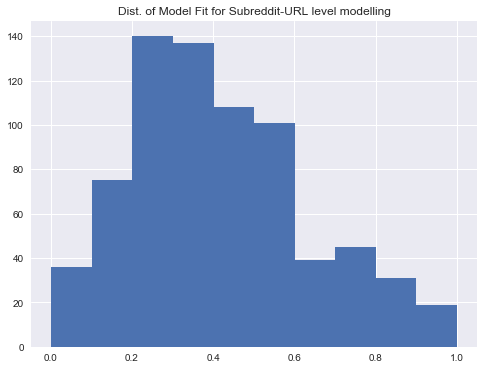

In [408]:
plt.hist(subreddit_web_model_perf_dat[subreddit_web_model_perf_dat['test_rsq']>0].train_rsq);
plt.title("Dist. of Model Fit for Subreddit-URL level modelling");

Text(0.5,1,'Dist. of Model Fit for Subreddit-URL level modelling')

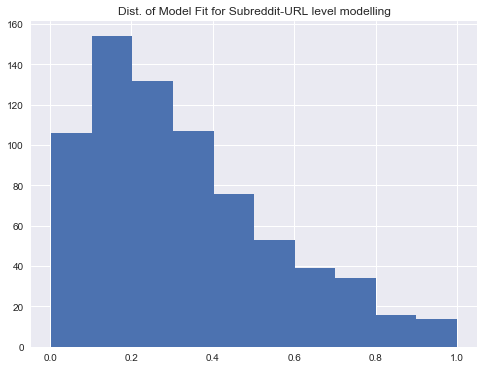

In [407]:
plt.hist(subreddit_web_model_perf_dat[subreddit_web_model_perf_dat['test_rsq']>0].test_rsq);
plt.title("Dist. of Model Fit for Subreddit-URL level modelling");

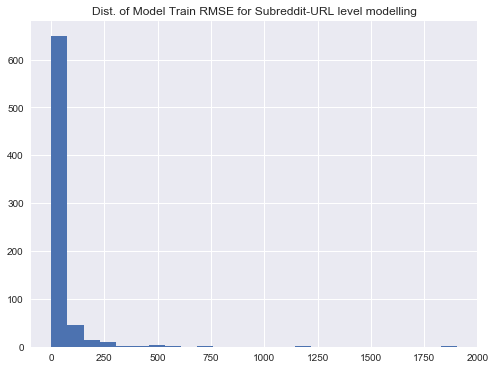

In [417]:
plt.hist(subreddit_web_model_perf_dat[(subreddit_web_model_perf_dat['test_rsq']>0)].train_rmse,bins=25);
plt.title("Dist. of Model Train RMSE for Subreddit-URL level modelling");

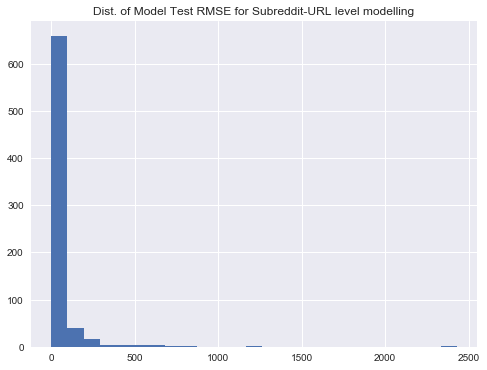

In [418]:
plt.hist(subreddit_web_model_perf_dat[(subreddit_web_model_perf_dat['test_rsq']>0)].test_rmse,bins=25);
plt.title("Dist. of Model Test RMSE for Subreddit-URL level modelling");

In [421]:
subreddit_web_model_perf_dat['rsq_ratio']=subreddit_web_model_perf_dat['test_rsq']/subreddit_web_model_perf_dat['train_rsq']

In [425]:
subreddit_web_model_perf_dat['rmse_ratio']=subreddit_web_model_perf_dat['test_rmse']/subreddit_web_model_perf_dat['train_rmse']

In [428]:
subreddit_web_model_perf_dat['rmse_ratio']=np.where(np.isinf(subreddit_web_model_perf_dat['rmse_ratio']) |
                                                    np.isnan(subreddit_web_model_perf_dat['rmse_ratio']),0,subreddit_web_model_perf_dat['rmse_ratio'])

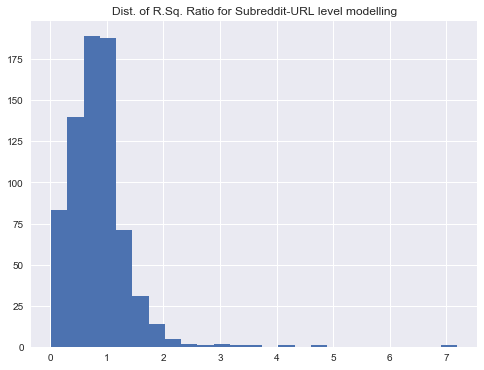

In [429]:
plt.hist(subreddit_web_model_perf_dat[(subreddit_web_model_perf_dat['test_rsq']>0)].rsq_ratio,bins=25);
plt.title("Dist. of R.Sq. Ratio for Subreddit-URL level modelling");

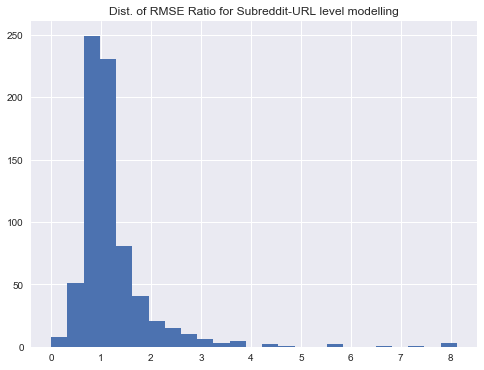

In [431]:
plt.hist(subreddit_web_model_perf_dat[(subreddit_web_model_perf_dat['test_rsq']>0)].rmse_ratio,bins=25);
plt.title("Dist. of RMSE Ratio for Subreddit-URL level modelling");

In [516]:
# Choose only good models to analyse
subreddit_web_model_perf_filter_dat=subreddit_web_model_perf_dat[(subreddit_web_model_perf_dat['train_rsq']>0)]

In [517]:
len(subreddit_web_model_perf_dat)

918

In [518]:
#Percentage of models that can be analysed
len(subreddit_web_model_perf_filter_dat)*100/len(subreddit_web_model_perf_dat)

99.67320261437908

In [519]:
subreddit_web_model_perf_filter_dat.head()

subreddit_web  total_submissions  train_rsq  \
0  subreddit_DestinyTheGame_web_reddit.com               8475   0.472103   
1       subreddit_Fireteams_web_reddit.com              23324   0.471315   
2  subreddit_Showerthoughts_web_reddit.com              22374   0.858401   
3       subreddit_AskReddit_web_reddit.com             150050   0.708644   
4            subreddit_Pets_web_reddit.com                421   0.287760   

   test_rsq  train_rmse   test_rmse  \
0  0.257935   53.731331   75.701760   
1 -0.001785    1.826523    1.583783   
2  0.802044   34.205786   39.732702   
3  0.696240  223.639190  230.124487   
4  0.213201    6.694435    4.657249   

                                        sig_features  rsq_ratio  rmse_ratio  
0  ups,title_length,selftText_len,avg_comments_pe...   0.546353    1.408894  
1  selftText_len,time_since_last_sub_subRedditAut...  -0.003787    0.867103  
2  ups,title_length,selftText_len,time_since_last...   0.934346    1.161578  
3  ups,title_length,selftText_len,avg_comments_pe...   0.982495    1.028999  
4  ups,title_length,selftText_len,avg_comments_pe...   0.740900    0.695690

In [520]:
# How many subreddits picked a feature as significant for a particular URL?
feature_set=subreddit_dat.columns[~subreddit_dat.columns.isin(['num_comments','subreddit','id',
                                                              'author','web_source','subreddit_web_key'])]
for feature in feature_set:
    subreddit_web_model_perf_filter_dat[feature]=subreddit_web_model_perf_filter_dat['sig_features'].str.contains(feature,case=False,regex=True)

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [521]:
subreddit_expand_dat=subreddit_web_model_perf_filter_dat['subreddit_web'].str.split('_web_',expand=True)
subreddit_expand_dat.columns=['subreddit','web_source','del']
subreddit_expand_dat.drop(['del'],inplace=True,axis=1)
subreddit_expand_dat['subreddit']=subreddit_expand_dat['subreddit'].str.replace('subreddit_','')
subreddit_web_model_perf_filter_dat=pd.concat([subreddit_web_model_perf_filter_dat,subreddit_expand_dat],axis=1)

In [522]:
web_source_subreddit_cnt_dat=subreddit_web_model_perf_filter_dat.groupby(['web_source'],as_index=False).agg({'subreddit':'nunique'})

In [523]:
feature_set=['web_source',
             'is_self', 'over_18', 'ups', 'downs', 'title_length', 'selftText_len',
           'title_sentiment_subjectivity', 'title_sentiment_polarity',
           'avg_comments_perday', 'subreddit_deleted', 'subreddit_removed',
           'SubTitle_Sim2Subreddit', 'SubTitle_Sim2WebSource',
           'time_since_last_sub_websourceSubReddit',
           'time_since_last_sub_SubReddit', 'time_since_last_sub_websource',
           'time_since_last_sub_subRedditAuth', 'avg_score_authsubreddit',
           'is_author_flair', 'is_link_flair', 'num_unq_authors_persubreddit',
           'no_subreddits_perauth', 'no_websource_perauth',
           'avg_comments_persubreddit_y', 'submission_age',
           'prev_post_num_comments']
subreddit_web_model_perf_filter_dat=subreddit_web_model_perf_filter_dat[feature_set]

In [524]:
sigFeatDat=subreddit_web_model_perf_filter_dat.groupby(['web_source'],as_index=False).sum(axis=1)

In [525]:
sigFeatDat=sigFeatDat.melt(id_vars=['web_source'])
sigFeatDat.columns=['web_source','feat','sig_subreddit_cnt']

In [526]:
sigFeatDat=sigFeatDat[sigFeatDat['sig_subreddit_cnt']>0]

In [527]:
sigFeatDat=sigFeatDat.merge(web_source_subreddit_cnt_dat,on=['web_source'])

In [528]:
sigFeatDat['pct_impt']=sigFeatDat['sig_subreddit_cnt']/sigFeatDat['subreddit']

In [529]:
sigFeatDat.sort_values(['web_source','pct_impt'],ascending=False).pivot(index='feat',columns='web_source',values='pct_impt')

web_source                             blogspot.com cnn.com design  \
feat                                                                 
SubTitle_Sim2Subreddit                          NaN     0.2    NaN   
SubTitle_Sim2WebSource                          NaN     0.2    NaN   
avg_comments_perday                             NaN     0.6    NaN   
avg_score_authsubreddit                         NaN     0.8      1   
is_author_flair                                 NaN     0.2    NaN   
is_link_flair                                   NaN     0.6    NaN   
is_self                                         NaN     NaN    NaN   
no_subreddits_perauth                           NaN     0.8      1   
no_websource_perauth                            NaN     0.6    NaN   
over_18                                         NaN     NaN    NaN   
prev_post_num_comments                          NaN     0.8    NaN   
selftText_len                                   NaN     NaN      1   
submission_age                                    1       1      1   
time_since_last_sub_SubReddit                  0.25       1      1   
time_since_last_sub_subRedditAuth              0.25       1      1   
time_since_last_sub_websource                   NaN     0.6    NaN   
time_since_last_sub_websourceSubReddit          NaN     0.6    NaN   
title_length                                    NaN     0.8      1   
title_sentiment_polarity                        NaN     0.4    NaN   
title_sentiment_subjectivity                    NaN     0.4    NaN   
ups                                             NaN       1      1   

web_source                             facebook.com huffingtonpost.com  \
feat                                                                     
SubTitle_Sim2Subreddit                          NaN                NaN   
SubTitle_Sim2WebSource                          NaN                0.5   
avg_comments_perday                             0.5                0.5   
avg_score_authsubreddit                         0.5                  1   
is_author_flair                                 0.5                0.5   
is_link_flair                                   NaN                0.5   
is_self                                         NaN                NaN   
no_subreddits_perauth                           NaN                  1   
no_websource_perauth                            0.5                  1   
over_18                                         NaN                NaN   
prev_post_num_comments                          0.5                  1   
selftText_len                                   NaN                NaN   
submission_age                                    1                  1   
time_since_last_sub_SubReddit                   0.5                  1   
time_since_last_sub_subRedditAuth               0.5                  1   
time_since_last_sub_websource                   0.5                  1   
time_since_last_sub_websourceSubReddit          0.5                  1   
title_length                                    0.5                  1   
title_sentiment_polarity                        NaN                0.5   
title_sentiment_subjectivity                    NaN                0.5   
ups                                             0.5                  1   

web_source                             nytimes.com reddit.com theguardian.com  \
feat                                                                            
SubTitle_Sim2Subreddit                         NaN  0.0293399             0.1   
SubTitle_Sim2WebSource                    0.333333   0.118582             0.1   
avg_comments_perday                       0.333333   0.634474             0.9   
avg_score_authsubreddit                          1   0.822738               1   
is_author_flair                                NaN   0.144254             0.4   
is_link_flair                                  NaN   0.143032             0.3   
is_self                               